In [1]:

# example of defining the discriminator model
# example of fitting an auxiliary classifier gan (ac-gan) on fashion mnsit
from numpy import zeros
from numpy import ones
from numpy import expand_dims
from numpy.random import randn
from numpy.random import randint
from keras.datasets.fashion_mnist import load_data
from keras.optimizers import Adam
from keras.models import Model
from keras.layers import Input
from keras.layers import Dense
from keras.layers import Reshape
from keras.layers import Flatten
from keras.layers import Conv2D
from keras.layers import Conv2DTranspose, UpSampling2D
from keras.layers import LeakyReLU
from keras.layers import BatchNormalization
from keras.layers import Dropout
from keras.layers import Embedding
from keras.layers import Activation
from keras.layers import Concatenate
from keras.initializers import RandomNormal
from matplotlib import pyplot
import numpy as np
from PIL import Image , ImageStat
import cv2
import glob
import imageio
import matplotlib.pyplot as plt
import os
import PIL
from tensorflow.keras import layers
import time
import tensorflow as tf
from IPython import display
from keras.utils.vis_utils import plot_model

2023-07-06 15:51:47.949355: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
path1 = glob.glob("/home/rezaz/deeplearningProject/Generative-Adversarial-Networks/src/Dataset/Class 1/*.png")
class1 = []

for img in path1:
    n = cv2.imread(img)
    class1.append(n)
class1 = np.array(class1)

path2 = glob.glob("/home/rezaz/deeplearningProject/Generative-Adversarial-Networks/src/Dataset/Class 2/*.png")
class2 = []
for img in path2:
    n = cv2.imread(img)
    class2.append(n)
class2 = np.array(class2)

path3 = glob.glob("/home/rezaz/deeplearningProject/Generative-Adversarial-Networks/src/Dataset/Class 3/*.png")
class3 = []
for img in path3:
    n = cv2.imread(img)
    class3.append(n)
class3 = np.array(class3)

path4 = glob.glob("/home/rezaz/deeplearningProject/Generative-Adversarial-Networks/src/Dataset/Class 4/*.png")
class4 = []
for img in path4:
    n = cv2.imread(img)
    class4.append(n)
class4 = np.array(class4)

path5 = glob.glob("/home/rezaz/deeplearningProject/Generative-Adversarial-Networks/src/Dataset/Class 5/*.png")
class5 = []
for img in path5:
    n = cv2.imread(img)
    class5.append(n)
class5 = np.array(class5)

In [3]:
k=[]
for i in range(1005):
  if i<201:
    k.append(1)
  elif 201<i<402:
    k.append(2)
  elif 402<i<603:
    k.append(3)
  elif 603<i<804:
    k.append(4)
  else:
    k.append(5)
yt = np.array(k)  

In [4]:
np.random.shuffle(yt)

In [5]:
train_images = np.concatenate((class1, class2 , class3, class4 ,class5), axis=0)

In [6]:
train_images.shape

(1005, 32, 32, 3)

In [7]:
np.random.shuffle(train_images)

# AC-GAN

In [8]:
# define the standalone discriminator model
def define_discriminator(in_shape=(32,32,3), n_classes=10):
	# weight initialization
	init = RandomNormal(stddev=0.02)
	# image input
	in_image = Input(shape=in_shape)
	# downsample to 14x14
	
	fe = Conv2D(32, (3,3), strides=(2,2), padding='same', kernel_initializer=init)(in_image)
	fe = LeakyReLU(alpha=0.2)(fe)
	fe = Dropout(0.2)(fe)
	# normal
	fe = Conv2D(64, (3,3), padding='same', kernel_initializer=init)(fe)
	fe = BatchNormalization()(fe)
	fe = LeakyReLU(alpha=0.2)(fe)
	fe = Dropout(0.2)(fe)
	# downsample to 7x7
	fe = Conv2D(128, (3,3), strides=(2,2), padding='same', kernel_initializer=init)(fe)
	fe = BatchNormalization()(fe)
	fe = LeakyReLU(alpha=0.2)(fe)
	fe = Dropout(0.5)(fe)
	# normal
	fe = Conv2D(256, (3,3), padding='same', kernel_initializer=init)(fe)
	fe = BatchNormalization()(fe)
	fe = LeakyReLU(alpha=0.2)(fe)
	fe = Dropout(0.2)(fe)
	# flatten feature maps
	fe = Flatten()(fe)
	# real/fake output
	out1 = Dense(1, activation='sigmoid')(fe)
	# class label output
	out2 = Dense(n_classes, activation='softmax')(fe)
	# define model
	model = Model(in_image, [out1, out2])
	# compile model
	opt = Adam(lr=0.0002, beta_1=0.5)
	model.compile(loss=['binary_crossentropy', 'sparse_categorical_crossentropy'], optimizer=opt)
	return model

In [9]:
# define the discriminator model
model = define_discriminator()
# summarize the model
model.summary()

2023-07-06 15:51:51.010393: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.
/home/rezaz/anaconda3/envs/py310/lib/python3.10/site-packages/keras/initializers/initializers.py:120: UserWarning: The initializer RandomNormal is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initalizer instance more than once.
  warnings.warn(


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 32, 32, 3)]  0           []                               
                                                                                                  
 conv2d (Conv2D)                (None, 16, 16, 32)   896         ['input_1[0][0]']                
                                                                                                  
 leaky_re_lu (LeakyReLU)        (None, 16, 16, 32)   0           ['conv2d[0][0]']                 
                                                                                                  
 dropout (Dropout)              (None, 16, 16, 32)   0           ['leaky_re_lu[0][0]']            
                                                                                              

/home/rezaz/anaconda3/envs/py310/lib/python3.10/site-packages/keras/optimizers/legacy/adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


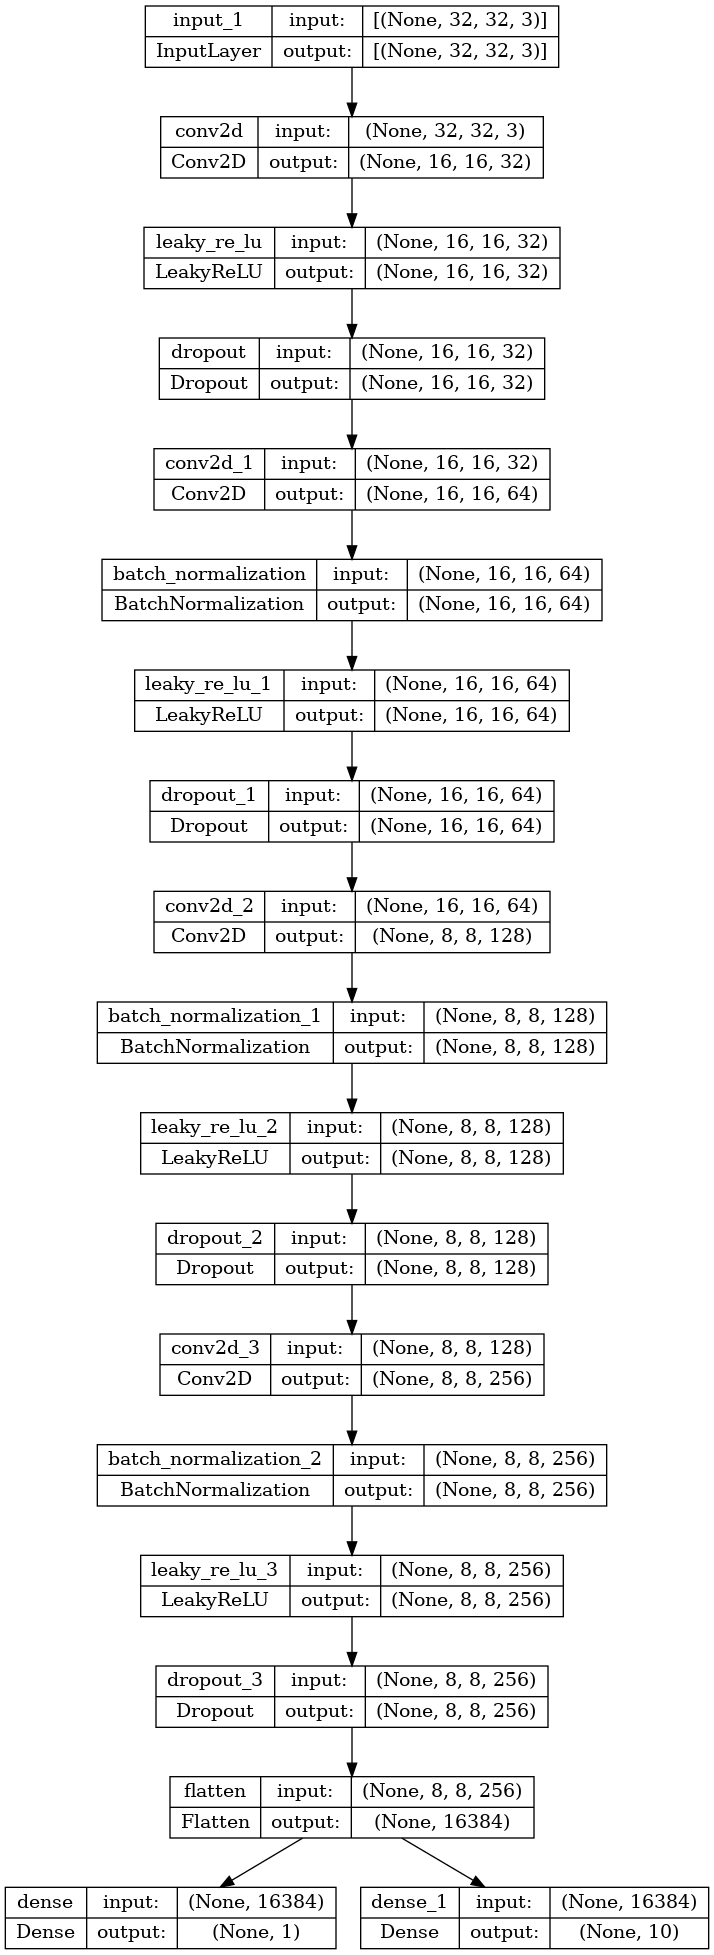

In [10]:
# plot the model
plot_model(model, to_file='discriminator_plot.png', show_shapes=True, show_layer_names=True)

In [11]:
# define the standalone generator model
def define_generator(latent_dim, n_classes=10):
 # weight initialization
 init = RandomNormal(stddev=0.02)
 # label input
 in_label = Input(shape=(1,))
 # embedding for categorical input
 li = Embedding(n_classes, 50)(in_label)
 # linear multiplication
 n_nodes = 8 * 8
 li = Dense(n_nodes, kernel_initializer=init)(li)
 # reshape to additional channel
 li = Reshape((8, 8, 1))(li)
 # image generator input
 in_lat = Input(shape=(latent_dim,))
 # foundation for 7x7 image
 n_nodes = 512 * 8 * 8
 gen = Dense(n_nodes, kernel_initializer=init)(in_lat)
 gen = Activation('relu')(gen)
 gen = Reshape((8, 8, 512))(gen)
 # merge image gen and label input
 merge = Concatenate()([gen, li])
 # upsample to 14x14
 gen = Conv2DTranspose(256, (5,5), strides=(2,2), padding='same', kernel_initializer=init)(merge)
 gen = BatchNormalization()(gen)
 gen = Activation('relu')(gen)

 gen = Conv2DTranspose(128, (5,5), strides=(2,2), padding='same', kernel_initializer=init)(merge)
 gen = BatchNormalization()(gen)
 gen = Activation('relu')(gen)
 # upsample to 28x28
 gen = Conv2DTranspose(3, (5,5), strides=(2,2), padding='same', kernel_initializer=init)(gen)
 out_layer = Activation('tanh')(gen)
 # define model
 model = Model([in_lat, in_label], out_layer)
 return model

In [12]:
# define the size of the latent space
latent_dim = 100
# define the generator model
model = define_generator(latent_dim)
# summarize the model
model.summary()


Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 100)]        0           []                               
                                                                                                  
 input_2 (InputLayer)           [(None, 1)]          0           []                               
                                                                                                  
 dense_3 (Dense)                (None, 32768)        3309568     ['input_3[0][0]']                
                                                                                                  
 embedding (Embedding)          (None, 1, 50)        500         ['input_2[0][0]']                
                                                                                            

/home/rezaz/anaconda3/envs/py310/lib/python3.10/site-packages/keras/initializers/initializers.py:120: UserWarning: The initializer RandomNormal is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initalizer instance more than once.
  warnings.warn(


 reshape_1 (Reshape)            (None, 8, 8, 512)    0           ['activation[0][0]']             
                                                                                                  
 reshape (Reshape)              (None, 8, 8, 1)      0           ['dense_2[0][0]']                
                                                                                                  
 concatenate (Concatenate)      (None, 8, 8, 513)    0           ['reshape_1[0][0]',              
                                                                  'reshape[0][0]']                
                                                                                                  
 conv2d_transpose_1 (Conv2DTran  (None, 16, 16, 128)  1641728    ['concatenate[0][0]']            
 spose)                                                                                           
                                                                                                  
 batch_nor

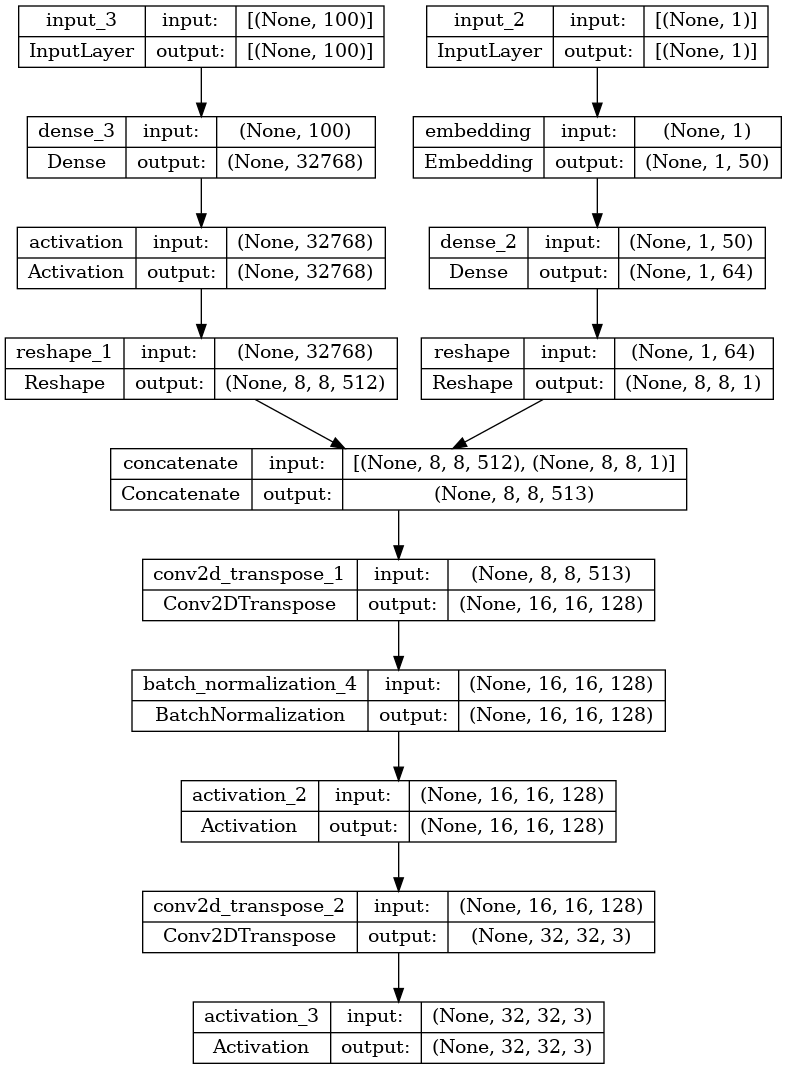

In [13]:
# plot the model
plot_model(model, to_file='generator_plot.png', show_shapes=True, show_layer_names=True)

In [14]:
# define the combined generator and discriminator model, for updating the generator
def define_gan(g_model, d_model):
	# make weights in the discriminator not trainable
	for layer in d_model.layers:
		if not isinstance(layer, BatchNormalization):
			layer.trainable = False
	# connect the outputs of the generator to the inputs of the discriminator
	gan_output = d_model(g_model.output)
	# define gan model as taking noise and label and outputting real/fake and label outputs
	model = Model(g_model.input, gan_output)
	# compile model
	opt = Adam(lr=0.0002, beta_1=0.5)
	model.compile(loss=['binary_crossentropy', 'sparse_categorical_crossentropy'], optimizer=opt)
	return model

In [15]:
# load images
def load_real_samples():
	# load dataset
	# (trainX, trainy), (_, _) = load_data()
	# expand to 3d, e.g. add channels
	# X = expand_dims(trainX, axis=-1)
	# convert from ints to floats
	X = train_images.astype('float32')
	# scale from [0,255] to [-1,1]
	X = (X - 127.5) / 127.5
	print(X.shape, yt.shape)
	return [X, yt]

In [16]:
# select real samples
def generate_real_samples(dataset, n_samples):
	# split into images and labels
	images, labels = dataset
	# choose random instances
	ix = randint(0, images.shape[0], n_samples)
	# select images and labels
	X, labels = images[ix], labels[ix]
	# generate class labels
	y = ones((n_samples, 1))
	return [X, labels], y

In [17]:
# generate points in latent space as input for the generator
def generate_latent_points(latent_dim, n_samples, n_classes=10):
	# generate points in the latent space
	x_input = randn(latent_dim * n_samples)
	# reshape into a batch of inputs for the network
	z_input = x_input.reshape(n_samples, latent_dim)
	# generate labels
	labels = randint(0, n_classes, n_samples)
	return [z_input, labels]

In [18]:

# use the generator to generate n fake examples, with class labels
def generate_fake_samples(generator, latent_dim, n_samples):
 # generate points in latent space
 z_input, labels_input = generate_latent_points(latent_dim, n_samples)
 # predict outputs
 images = generator.predict([z_input, labels_input])
 # create class labels
 y = zeros((n_samples, 1))
 return [images, labels_input], y

In [19]:
# generate samples and save as a plot and save the model
def summarize_performance(step, g_model, latent_dim, n_samples=100):
	# prepare fake examples
	[X, _], _ = generate_fake_samples(g_model, latent_dim, n_samples)
	# scale from [-1,1] to [0,1]
	X = (X + 1) / 2.0
	# plot images
	for i in range(25):
		# define subplot
		# pyplot.figure(figsize=(10,6))
		pyplot.subplot(5,5, 1 + i)
		# pyplot.figure(figsize=(32,32))
		# turn off axis
		pyplot.axis('off')
		# plot raw pixel data
		pyplot.imshow(X[i, :, :, 0], cmap='gray')
	# save plot to file
	filename1 = 'generated_plot_%04d.png' % (step+1)
	pyplot.savefig(filename1)
	pyplot.close()
	# save the generator model
	filename2 = 'model_%04d.h5' % (step+1)
	g_model.save(filename2)
	print('>Saved: %s and %s' % (filename1, filename2))

In [20]:
# create a line plot of loss for the gan and save to file
def plot_history(dr1, dr2, df1, df2, g1, g2):

	# plot history
  pyplot.figure(figsize=(10,6))
  pyplot.plot(dr1, label='discriminator_loss on real Data')
  pyplot.plot(dr2, label='discriminator_Class_loss on real Data')
  pyplot.plot(df1, label='discriminator_loss on fake Data')
  pyplot.plot(df2, label='discriminator_Class_loss on fake Data')
  pyplot.plot(g1, label='generator_loss')
  pyplot.plot(g2, label='generator_Class_loss')
  pyplot.legend()
  pyplot.savefig('plot_line_plot_loss.png')
  pyplot.close()

In [21]:
# train the generator and discriminator
def train(g_model, d_model, gan_model, dataset, latent_dim, n_epochs=10, n_batch=64):
	# calculate the number of batches per training epoch
	bat_per_epo = int(dataset[0].shape[0] / n_batch)
	# calculate the number of training iterations
	n_steps = bat_per_epo * n_epochs
	# calculate the size of half a batch of samples
	half_batch = int(n_batch / 2)
  # lists for keeping track of loss
	dr1, dr2, df1, df2, g1, g2 = list(), list(), list(),list(), list(), list()
	# manually enumerate epochs
	for i in range(n_steps):
		# get randomly selected 'real' samples
		[X_real, labels_real], y_real = generate_real_samples(dataset, half_batch)
		# update discriminator model weights
		_,d_r1,d_r2 = d_model.train_on_batch(X_real, [y_real, labels_real])
		# generate 'fake' examples
		[X_fake, labels_fake], y_fake = generate_fake_samples(g_model, latent_dim, half_batch)
		# update discriminator model weights
		_,d_f,d_f2 = d_model.train_on_batch(X_fake, [y_fake, labels_fake])
		# prepare points in latent space as input for the generator
		[z_input, z_labels] = generate_latent_points(latent_dim, n_batch)
		# create inverted labels for the fake samples
		y_gan = ones((n_batch, 1))
		# update the generator via the discriminator's error
		_,g_1,g_2 = gan_model.train_on_batch([z_input, z_labels], [y_gan, z_labels])
		dr1.append(d_r1)
		dr2.append(d_r2)
		df1.append(d_f)
		df2.append(d_f2)
		g1.append(g_1)
		g2.append(g_2)

		# summarize loss on this batch
		print('>%d, dr[%.3f,%.3f], df[%.3f,%.3f], g[%.3f,%.3f]' % (i+1, d_r1,d_r2, d_f,d_f2, g_1,g_2))
		# evaluate the model performance every 'epoch'
		if (i+1) % (bat_per_epo * 10) == 0:
			summarize_performance(i, g_model, latent_dim)
	# line plots of loss
	plot_history(dr1, dr2, df1, df2, g1, g2)

In [22]:

# size of the latent space
latent_dim = 120
# create the discriminator
discriminator = define_discriminator()
# create the generator
generator = define_generator(latent_dim)
# create the gan
gan_model = define_gan(generator, discriminator)
# load image data
dataset = load_real_samples()
# train model

train(generator, discriminator, gan_model, dataset, latent_dim, n_epochs=200, n_batch=64)
# train(generator, discriminator, gan_model, dataset, latent_dim)

/home/rezaz/anaconda3/envs/py310/lib/python3.10/site-packages/keras/initializers/initializers.py:120: UserWarning: The initializer RandomNormal is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initalizer instance more than once.
  warnings.warn(
/home/rezaz/anaconda3/envs/py310/lib/python3.10/site-packages/keras/optimizers/legacy/adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


(1005, 32, 32, 3) (1005,)


2023-07-06 15:51:53.064851: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]


1/1 [==============================] - 0s 258ms/step


2023-07-06 15:51:55.155264: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]
2023-07-06 15:51:55.363188: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_3' with dtype int64 and shape [64]
	 [[{{node Placeholder/_3}}]]


>1, dr[0.772,2.945], df[1.391,3.100], g[0.634,2.848]


2023-07-06 15:51:57.255895: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]


1/1 [==============================] - 0s 141ms/step


2023-07-06 15:51:57.666157: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]
2023-07-06 15:51:58.037077: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_3' with dtype int64 and shape [64]
	 [[{{node Placeholder/_3}}]]


>2, dr[0.344,2.769], df[0.947,2.910], g[0.969,2.810]


2023-07-06 15:51:58.644519: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]


1/1 [==============================] - 0s 213ms/step


2023-07-06 15:51:59.266016: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]
2023-07-06 15:51:59.594588: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_3' with dtype int64 and shape [64]
	 [[{{node Placeholder/_3}}]]


>3, dr[0.273,2.295], df[0.729,2.990], g[1.479,2.737]


2023-07-06 15:52:00.184014: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]


1/1 [==============================] - 0s 238ms/step


2023-07-06 15:52:00.655507: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]
2023-07-06 15:52:00.847929: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_3' with dtype int64 and shape [64]
	 [[{{node Placeholder/_3}}]]


>4, dr[0.206,1.907], df[0.415,2.995], g[1.941,2.576]


2023-07-06 15:52:01.691663: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]


1/1 [==============================] - 0s 169ms/step


2023-07-06 15:52:02.165825: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]
2023-07-06 15:52:02.366634: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_3' with dtype int64 and shape [64]
	 [[{{node Placeholder/_3}}]]


>5, dr[0.239,2.414], df[0.356,2.836], g[1.953,2.834]


2023-07-06 15:52:02.969405: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]


1/1 [==============================] - 0s 491ms/step


2023-07-06 15:52:03.948236: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]
2023-07-06 15:52:04.386660: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_3' with dtype int64 and shape [64]
	 [[{{node Placeholder/_3}}]]


>6, dr[0.171,1.961], df[0.211,2.869], g[2.114,2.701]


2023-07-06 15:52:05.285211: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]


1/1 [==============================] - 0s 216ms/step


2023-07-06 15:52:05.809350: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]
2023-07-06 15:52:06.050232: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_3' with dtype int64 and shape [64]
	 [[{{node Placeholder/_3}}]]


>7, dr[0.179,1.936], df[0.347,2.873], g[2.040,2.902]


2023-07-06 15:52:06.781782: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]


1/1 [==============================] - 0s 242ms/step


2023-07-06 15:52:07.254223: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]
2023-07-06 15:52:07.563565: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_3' with dtype int64 and shape [64]
	 [[{{node Placeholder/_3}}]]


>8, dr[0.174,1.941], df[0.306,2.700], g[2.203,2.917]


2023-07-06 15:52:09.118826: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]


1/1 [==============================] - 0s 160ms/step


2023-07-06 15:52:09.907067: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]
2023-07-06 15:52:10.103419: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_3' with dtype int64 and shape [64]
	 [[{{node Placeholder/_3}}]]


>9, dr[0.135,2.290], df[0.289,2.733], g[2.139,2.930]


2023-07-06 15:52:10.727067: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]


1/1 [==============================] - 0s 222ms/step


2023-07-06 15:52:11.217218: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]
2023-07-06 15:52:11.382888: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_3' with dtype int64 and shape [64]
	 [[{{node Placeholder/_3}}]]


>10, dr[0.156,2.399], df[0.248,2.574], g[2.208,2.733]


2023-07-06 15:52:12.066802: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]


1/1 [==============================] - 0s 185ms/step


2023-07-06 15:52:12.514424: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]
2023-07-06 15:52:12.726353: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_3' with dtype int64 and shape [64]
	 [[{{node Placeholder/_3}}]]


>11, dr[0.130,2.083], df[0.182,2.857], g[2.297,2.625]


2023-07-06 15:52:13.473647: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]


1/1 [==============================] - 0s 159ms/step


2023-07-06 15:52:13.933429: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]
2023-07-06 15:52:14.147151: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_3' with dtype int64 and shape [64]
	 [[{{node Placeholder/_3}}]]


>12, dr[0.131,2.090], df[0.144,2.994], g[2.232,2.796]


2023-07-06 15:52:15.023090: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]


1/1 [==============================] - 0s 298ms/step


2023-07-06 15:52:15.654789: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]
2023-07-06 15:52:16.305267: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_3' with dtype int64 and shape [64]
	 [[{{node Placeholder/_3}}]]


>13, dr[0.123,2.360], df[0.227,2.480], g[2.129,3.063]


2023-07-06 15:52:17.343036: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]


1/1 [==============================] - 0s 180ms/step


2023-07-06 15:52:18.015359: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]
2023-07-06 15:52:18.429209: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_3' with dtype int64 and shape [64]
	 [[{{node Placeholder/_3}}]]


>14, dr[0.095,2.288], df[0.198,2.875], g[2.175,2.814]


2023-07-06 15:52:19.233398: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]


1/1 [==============================] - 0s 350ms/step


2023-07-06 15:52:20.107955: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]
2023-07-06 15:52:20.586690: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_3' with dtype int64 and shape [64]
	 [[{{node Placeholder/_3}}]]


>15, dr[0.080,2.105], df[0.159,2.783], g[2.101,2.679]


2023-07-06 15:52:21.529410: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]


1/1 [==============================] - 0s 223ms/step


2023-07-06 15:52:22.177122: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]
2023-07-06 15:52:22.481942: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_3' with dtype int64 and shape [64]
	 [[{{node Placeholder/_3}}]]


>16, dr[0.093,1.813], df[0.178,3.139], g[2.044,2.948]


2023-07-06 15:52:23.314017: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]


1/1 [==============================] - 0s 212ms/step


2023-07-06 15:52:23.882023: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]
2023-07-06 15:52:24.302305: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_3' with dtype int64 and shape [64]
	 [[{{node Placeholder/_3}}]]


>17, dr[0.141,2.218], df[0.119,2.807], g[1.961,2.864]


2023-07-06 15:52:25.068847: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]


1/1 [==============================] - 0s 139ms/step


2023-07-06 15:52:25.520876: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]
2023-07-06 15:52:25.748150: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_3' with dtype int64 and shape [64]
	 [[{{node Placeholder/_3}}]]


>18, dr[0.098,2.447], df[0.112,2.862], g[1.614,3.296]


2023-07-06 15:52:26.604579: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]


1/1 [==============================] - 0s 416ms/step


2023-07-06 15:52:27.311892: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]
2023-07-06 15:52:27.718170: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_3' with dtype int64 and shape [64]
	 [[{{node Placeholder/_3}}]]


>19, dr[0.081,1.787], df[0.266,2.781], g[1.743,2.789]


2023-07-06 15:52:28.936739: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]


1/1 [==============================] - 0s 397ms/step


2023-07-06 15:52:29.727636: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]
2023-07-06 15:52:30.319608: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_3' with dtype int64 and shape [64]
	 [[{{node Placeholder/_3}}]]


>20, dr[0.099,2.463], df[0.156,3.063], g[2.013,2.767]


2023-07-06 15:52:31.580403: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]


1/1 [==============================] - 0s 212ms/step


2023-07-06 15:52:32.274298: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]
2023-07-06 15:52:32.613575: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_3' with dtype int64 and shape [64]
	 [[{{node Placeholder/_3}}]]


>21, dr[0.097,1.980], df[0.174,2.757], g[1.817,2.905]


2023-07-06 15:52:33.281488: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]


1/1 [==============================] - 0s 199ms/step


2023-07-06 15:52:33.753662: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]
2023-07-06 15:52:34.084820: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_3' with dtype int64 and shape [64]
	 [[{{node Placeholder/_3}}]]


>22, dr[0.122,1.993], df[0.103,2.904], g[2.048,2.995]


2023-07-06 15:52:34.749811: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]


1/1 [==============================] - 0s 168ms/step


2023-07-06 15:52:35.247517: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]
2023-07-06 15:52:35.494741: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_3' with dtype int64 and shape [64]
	 [[{{node Placeholder/_3}}]]


>23, dr[0.111,2.185], df[0.100,2.862], g[1.634,2.669]


2023-07-06 15:52:36.247047: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]


1/1 [==============================] - 0s 349ms/step


2023-07-06 15:52:36.952752: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]
2023-07-06 15:52:37.343257: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_3' with dtype int64 and shape [64]
	 [[{{node Placeholder/_3}}]]


>24, dr[0.072,2.502], df[0.133,2.415], g[1.477,2.790]


2023-07-06 15:52:38.399856: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]


1/1 [==============================] - 0s 139ms/step


2023-07-06 15:52:39.062812: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]
2023-07-06 15:52:39.424520: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_3' with dtype int64 and shape [64]
	 [[{{node Placeholder/_3}}]]


>25, dr[0.088,2.131], df[0.121,2.839], g[1.472,3.161]


2023-07-06 15:52:40.043353: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]


1/1 [==============================] - 0s 133ms/step


2023-07-06 15:52:40.496894: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]
2023-07-06 15:52:40.854976: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_3' with dtype int64 and shape [64]
	 [[{{node Placeholder/_3}}]]


>26, dr[0.079,2.023], df[0.091,2.529], g[1.494,2.825]


2023-07-06 15:52:41.742015: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]


1/1 [==============================] - 0s 172ms/step


2023-07-06 15:52:42.382117: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]
2023-07-06 15:52:42.724383: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_3' with dtype int64 and shape [64]
	 [[{{node Placeholder/_3}}]]


>27, dr[0.083,2.068], df[0.122,3.260], g[1.250,2.990]


2023-07-06 15:52:43.460114: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]


1/1 [==============================] - 0s 186ms/step


2023-07-06 15:52:44.033164: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]
2023-07-06 15:52:44.198781: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_3' with dtype int64 and shape [64]
	 [[{{node Placeholder/_3}}]]


>28, dr[0.056,2.225], df[0.047,2.871], g[1.321,2.904]


2023-07-06 15:52:44.856542: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]


1/1 [==============================] - 0s 151ms/step


2023-07-06 15:52:45.376760: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]
2023-07-06 15:52:45.582810: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_3' with dtype int64 and shape [64]
	 [[{{node Placeholder/_3}}]]


>29, dr[0.126,2.053], df[0.064,2.792], g[1.263,2.921]


2023-07-06 15:52:46.223857: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]


1/1 [==============================] - 0s 168ms/step


2023-07-06 15:52:46.706939: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]
2023-07-06 15:52:46.877711: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_3' with dtype int64 and shape [64]
	 [[{{node Placeholder/_3}}]]


>30, dr[0.082,2.241], df[0.072,2.898], g[1.013,3.012]


2023-07-06 15:52:47.528379: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]


1/1 [==============================] - 0s 151ms/step


2023-07-06 15:52:48.003888: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]
2023-07-06 15:52:48.191617: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_3' with dtype int64 and shape [64]
	 [[{{node Placeholder/_3}}]]


>31, dr[0.113,2.296], df[0.103,2.840], g[0.853,3.094]


2023-07-06 15:52:48.874421: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]


1/1 [==============================] - 0s 220ms/step


2023-07-06 15:52:49.409651: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]
2023-07-06 15:52:49.573555: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_3' with dtype int64 and shape [64]
	 [[{{node Placeholder/_3}}]]


>32, dr[0.083,1.969], df[0.093,3.201], g[0.888,3.268]


2023-07-06 15:52:50.234242: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]


1/1 [==============================] - 0s 177ms/step


2023-07-06 15:52:50.697131: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]
2023-07-06 15:52:50.912720: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_3' with dtype int64 and shape [64]
	 [[{{node Placeholder/_3}}]]


>33, dr[0.062,2.335], df[0.080,3.011], g[1.042,3.225]


2023-07-06 15:52:51.553317: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]


1/1 [==============================] - 0s 166ms/step


2023-07-06 15:52:52.221592: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]
2023-07-06 15:52:52.368084: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_3' with dtype int64 and shape [64]
	 [[{{node Placeholder/_3}}]]


>34, dr[0.087,2.468], df[0.042,2.691], g[0.685,2.903]


2023-07-06 15:52:53.260367: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]


1/1 [==============================] - 0s 166ms/step


2023-07-06 15:52:54.082083: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]
2023-07-06 15:52:54.407908: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_3' with dtype int64 and shape [64]
	 [[{{node Placeholder/_3}}]]


>35, dr[0.057,2.018], df[0.085,3.061], g[0.678,2.956]


2023-07-06 15:52:55.204267: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]


1/1 [==============================] - 0s 193ms/step


2023-07-06 15:52:55.687782: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]
2023-07-06 15:52:56.230130: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_3' with dtype int64 and shape [64]
	 [[{{node Placeholder/_3}}]]


>36, dr[0.042,2.264], df[0.072,2.664], g[0.679,3.447]


2023-07-06 15:52:56.852805: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]


1/1 [==============================] - 0s 158ms/step


2023-07-06 15:52:57.325596: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]
2023-07-06 15:52:57.512087: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_3' with dtype int64 and shape [64]
	 [[{{node Placeholder/_3}}]]


>37, dr[0.071,2.233], df[0.088,2.666], g[0.915,2.992]


2023-07-06 15:52:58.159750: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]


1/1 [==============================] - 0s 143ms/step


2023-07-06 15:52:58.635311: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]
2023-07-06 15:52:58.948991: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_3' with dtype int64 and shape [64]
	 [[{{node Placeholder/_3}}]]


>38, dr[0.042,2.037], df[0.047,2.574], g[0.795,3.067]


2023-07-06 15:52:59.652197: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]


1/1 [==============================] - 0s 338ms/step


2023-07-06 15:53:00.253032: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]
2023-07-06 15:53:00.528792: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_3' with dtype int64 and shape [64]
	 [[{{node Placeholder/_3}}]]


>39, dr[0.060,2.101], df[0.072,2.571], g[0.803,2.992]


2023-07-06 15:53:01.433528: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]


1/1 [==============================] - 0s 167ms/step


2023-07-06 15:53:01.864723: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]
2023-07-06 15:53:02.084575: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_3' with dtype int64 and shape [64]
	 [[{{node Placeholder/_3}}]]


>40, dr[0.059,2.315], df[0.064,3.020], g[0.817,3.076]


2023-07-06 15:53:02.762830: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]


1/1 [==============================] - 0s 198ms/step


2023-07-06 15:53:03.309030: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]
2023-07-06 15:53:03.513558: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_3' with dtype int64 and shape [64]
	 [[{{node Placeholder/_3}}]]


>41, dr[0.050,2.080], df[0.113,2.356], g[0.824,3.233]


2023-07-06 15:53:04.271846: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]


1/1 [==============================] - 0s 156ms/step


2023-07-06 15:53:04.834089: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]
2023-07-06 15:53:05.017028: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_3' with dtype int64 and shape [64]
	 [[{{node Placeholder/_3}}]]


>42, dr[0.041,2.257], df[0.065,2.997], g[0.907,2.882]


2023-07-06 15:53:05.612407: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]


1/1 [==============================] - 0s 132ms/step


2023-07-06 15:53:06.096960: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]
2023-07-06 15:53:06.346328: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_3' with dtype int64 and shape [64]
	 [[{{node Placeholder/_3}}]]


>43, dr[0.090,1.893], df[0.043,2.852], g[0.718,3.004]


2023-07-06 15:53:06.976117: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]


1/1 [==============================] - 0s 147ms/step


2023-07-06 15:53:07.500844: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]
2023-07-06 15:53:07.694261: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_3' with dtype int64 and shape [64]
	 [[{{node Placeholder/_3}}]]


>44, dr[0.053,2.102], df[0.061,2.881], g[0.635,2.920]


2023-07-06 15:53:08.332611: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]


1/1 [==============================] - 0s 160ms/step


2023-07-06 15:53:08.906536: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]
2023-07-06 15:53:09.191793: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_3' with dtype int64 and shape [64]
	 [[{{node Placeholder/_3}}]]


>45, dr[0.040,1.709], df[0.082,2.664], g[0.759,3.196]


2023-07-06 15:53:10.075365: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]


1/1 [==============================] - 0s 177ms/step


2023-07-06 15:53:10.681589: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]
2023-07-06 15:53:11.062488: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_3' with dtype int64 and shape [64]
	 [[{{node Placeholder/_3}}]]


>46, dr[0.064,1.728], df[0.045,2.874], g[0.763,3.089]


2023-07-06 15:53:11.635199: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]


1/1 [==============================] - 0s 127ms/step


2023-07-06 15:53:12.181993: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]
2023-07-06 15:53:12.558200: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_3' with dtype int64 and shape [64]
	 [[{{node Placeholder/_3}}]]


>47, dr[0.070,1.650], df[0.068,3.009], g[0.608,3.210]


2023-07-06 15:53:13.062036: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]


1/1 [==============================] - 0s 193ms/step


2023-07-06 15:53:13.496127: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]
2023-07-06 15:53:13.742061: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_3' with dtype int64 and shape [64]
	 [[{{node Placeholder/_3}}]]


>48, dr[0.074,2.528], df[0.072,2.868], g[0.564,2.881]


2023-07-06 15:53:14.502186: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]


1/1 [==============================] - 0s 166ms/step


2023-07-06 15:53:15.040822: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]
2023-07-06 15:53:15.271827: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_3' with dtype int64 and shape [64]
	 [[{{node Placeholder/_3}}]]


>49, dr[0.064,2.015], df[0.106,2.724], g[0.495,3.516]


2023-07-06 15:53:15.879425: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]


1/1 [==============================] - 0s 198ms/step


2023-07-06 15:53:16.390772: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]
2023-07-06 15:53:16.655772: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_3' with dtype int64 and shape [64]
	 [[{{node Placeholder/_3}}]]


>50, dr[0.044,2.244], df[0.057,2.836], g[0.686,3.232]


2023-07-06 15:53:17.336588: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]


1/1 [==============================] - 0s 141ms/step


2023-07-06 15:53:17.855619: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]
2023-07-06 15:53:18.188911: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_3' with dtype int64 and shape [64]
	 [[{{node Placeholder/_3}}]]


>51, dr[0.068,2.165], df[0.029,2.821], g[0.769,3.142]


2023-07-06 15:53:18.822703: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]


1/1 [==============================] - 0s 138ms/step


2023-07-06 15:53:19.290593: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]
2023-07-06 15:53:19.488649: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_3' with dtype int64 and shape [64]
	 [[{{node Placeholder/_3}}]]


>52, dr[0.055,2.154], df[0.071,2.730], g[0.687,2.873]


2023-07-06 15:53:20.143983: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]


1/1 [==============================] - 0s 158ms/step


2023-07-06 15:53:20.691549: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]
2023-07-06 15:53:21.011272: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_3' with dtype int64 and shape [64]
	 [[{{node Placeholder/_3}}]]


>53, dr[0.037,1.769], df[0.029,3.137], g[0.780,2.715]


2023-07-06 15:53:21.728244: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]


1/1 [==============================] - 0s 232ms/step


2023-07-06 15:53:22.168521: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]
2023-07-06 15:53:22.447567: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_3' with dtype int64 and shape [64]
	 [[{{node Placeholder/_3}}]]


>54, dr[0.050,1.782], df[0.032,2.884], g[0.682,3.031]


2023-07-06 15:53:23.099312: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]


1/1 [==============================] - 0s 153ms/step


2023-07-06 15:53:23.601033: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]
2023-07-06 15:53:23.837954: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_3' with dtype int64 and shape [64]
	 [[{{node Placeholder/_3}}]]


>55, dr[0.055,1.968], df[0.077,2.856], g[0.601,2.930]


2023-07-06 15:53:24.499870: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]


1/1 [==============================] - 0s 144ms/step


2023-07-06 15:53:25.026677: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]
2023-07-06 15:53:25.277915: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_3' with dtype int64 and shape [64]
	 [[{{node Placeholder/_3}}]]


>56, dr[0.048,2.078], df[0.052,3.127], g[0.568,2.862]


2023-07-06 15:53:25.893077: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]


1/1 [==============================] - 0s 237ms/step


2023-07-06 15:53:26.373301: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]
2023-07-06 15:53:26.692726: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_3' with dtype int64 and shape [64]
	 [[{{node Placeholder/_3}}]]


>57, dr[0.047,1.975], df[0.034,2.686], g[0.502,2.762]


2023-07-06 15:53:27.346255: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]


1/1 [==============================] - 0s 153ms/step


2023-07-06 15:53:27.879748: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]
2023-07-06 15:53:28.151654: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_3' with dtype int64 and shape [64]
	 [[{{node Placeholder/_3}}]]


>58, dr[0.041,2.353], df[0.200,2.627], g[0.704,3.078]


2023-07-06 15:53:28.849809: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]


1/1 [==============================] - 0s 224ms/step


2023-07-06 15:53:29.519934: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]
2023-07-06 15:53:29.725502: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_3' with dtype int64 and shape [64]
	 [[{{node Placeholder/_3}}]]


>59, dr[0.067,2.246], df[0.040,3.034], g[0.783,2.972]


2023-07-06 15:53:30.369724: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]


1/1 [==============================] - 0s 151ms/step


2023-07-06 15:53:30.881409: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]
2023-07-06 15:53:31.138640: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_3' with dtype int64 and shape [64]
	 [[{{node Placeholder/_3}}]]


>60, dr[0.074,1.639], df[0.031,2.893], g[0.741,2.896]


2023-07-06 15:53:31.842754: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]


1/1 [==============================] - 0s 167ms/step


2023-07-06 15:53:32.391789: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]
2023-07-06 15:53:32.715775: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_3' with dtype int64 and shape [64]
	 [[{{node Placeholder/_3}}]]


>61, dr[0.049,2.110], df[0.046,2.564], g[0.759,3.197]


2023-07-06 15:53:33.439749: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]


1/1 [==============================] - 0s 160ms/step


2023-07-06 15:53:33.967007: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]
2023-07-06 15:53:34.196313: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_3' with dtype int64 and shape [64]
	 [[{{node Placeholder/_3}}]]


>62, dr[0.050,1.748], df[0.067,3.013], g[0.665,2.908]


2023-07-06 15:53:34.918444: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]


1/1 [==============================] - 0s 148ms/step


2023-07-06 15:53:35.454198: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]
2023-07-06 15:53:35.778982: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_3' with dtype int64 and shape [64]
	 [[{{node Placeholder/_3}}]]


>63, dr[0.060,1.865], df[0.039,3.001], g[0.580,2.902]


2023-07-06 15:53:36.432493: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]


1/1 [==============================] - 0s 195ms/step


2023-07-06 15:53:36.924946: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]
2023-07-06 15:53:37.336231: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_3' with dtype int64 and shape [64]
	 [[{{node Placeholder/_3}}]]


>64, dr[0.029,2.003], df[0.039,2.839], g[0.615,2.997]


2023-07-06 15:53:37.953914: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]


1/1 [==============================] - 0s 145ms/step


2023-07-06 15:53:38.502022: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]
2023-07-06 15:53:38.719149: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_3' with dtype int64 and shape [64]
	 [[{{node Placeholder/_3}}]]


>65, dr[0.024,1.801], df[0.021,3.085], g[0.628,3.440]


2023-07-06 15:53:39.350392: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]


1/1 [==============================] - 0s 162ms/step


2023-07-06 15:53:39.917851: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]
2023-07-06 15:53:40.219508: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_3' with dtype int64 and shape [64]
	 [[{{node Placeholder/_3}}]]


>66, dr[0.039,2.202], df[0.059,3.162], g[0.491,2.963]


2023-07-06 15:53:40.974497: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]


1/1 [==============================] - 0s 136ms/step


2023-07-06 15:53:41.514050: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]
2023-07-06 15:53:41.834585: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_3' with dtype int64 and shape [64]
	 [[{{node Placeholder/_3}}]]


>67, dr[0.076,1.785], df[0.044,2.950], g[0.524,3.012]


2023-07-06 15:53:42.560122: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]


1/1 [==============================] - 0s 136ms/step


2023-07-06 15:53:43.078551: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]
2023-07-06 15:53:43.428534: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_3' with dtype int64 and shape [64]
	 [[{{node Placeholder/_3}}]]


>68, dr[0.044,2.068], df[0.059,2.840], g[0.450,2.956]


2023-07-06 15:53:44.127618: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]


1/1 [==============================] - 0s 134ms/step


2023-07-06 15:53:44.681034: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]
2023-07-06 15:53:45.070469: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_3' with dtype int64 and shape [64]
	 [[{{node Placeholder/_3}}]]


>69, dr[0.061,1.925], df[0.114,2.902], g[0.566,3.110]


2023-07-06 15:53:45.680081: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]


1/1 [==============================] - 0s 159ms/step


2023-07-06 15:53:46.212321: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]
2023-07-06 15:53:46.555084: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_3' with dtype int64 and shape [64]
	 [[{{node Placeholder/_3}}]]


>70, dr[0.085,1.992], df[0.050,2.604], g[0.646,3.097]


2023-07-06 15:53:47.266114: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]


1/1 [==============================] - 0s 156ms/step


2023-07-06 15:53:47.805427: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]
2023-07-06 15:53:48.043800: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_3' with dtype int64 and shape [64]
	 [[{{node Placeholder/_3}}]]


>71, dr[0.072,1.732], df[0.029,3.105], g[0.312,2.981]


2023-07-06 15:53:48.756671: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]


1/1 [==============================] - 0s 140ms/step


2023-07-06 15:53:49.253676: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]
2023-07-06 15:53:49.452733: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_3' with dtype int64 and shape [64]
	 [[{{node Placeholder/_3}}]]


>72, dr[0.016,1.878], df[0.093,3.336], g[0.392,3.022]


2023-07-06 15:53:50.110139: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]


1/1 [==============================] - 0s 160ms/step


2023-07-06 15:53:50.585418: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]
2023-07-06 15:53:50.836613: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_3' with dtype int64 and shape [64]
	 [[{{node Placeholder/_3}}]]


>73, dr[0.097,1.893], df[0.047,2.966], g[0.526,3.092]


2023-07-06 15:53:51.595471: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]


1/1 [==============================] - 0s 159ms/step


2023-07-06 15:53:52.126793: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]
2023-07-06 15:53:52.540675: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_3' with dtype int64 and shape [64]
	 [[{{node Placeholder/_3}}]]


>74, dr[0.058,1.708], df[0.104,2.581], g[0.608,3.019]


2023-07-06 15:53:53.295784: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]


1/1 [==============================] - 0s 193ms/step


2023-07-06 15:53:53.804063: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]
2023-07-06 15:53:54.025977: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_3' with dtype int64 and shape [64]
	 [[{{node Placeholder/_3}}]]


>75, dr[0.031,2.426], df[0.020,2.912], g[0.435,2.929]


2023-07-06 15:53:54.689028: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]


1/1 [==============================] - 0s 183ms/step


2023-07-06 15:53:55.168000: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]
2023-07-06 15:53:55.498432: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_3' with dtype int64 and shape [64]
	 [[{{node Placeholder/_3}}]]


>76, dr[0.031,2.112], df[0.035,2.608], g[0.379,3.858]


2023-07-06 15:53:56.193241: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]


1/1 [==============================] - 0s 137ms/step


2023-07-06 15:53:56.685663: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]
2023-07-06 15:53:57.011600: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_3' with dtype int64 and shape [64]
	 [[{{node Placeholder/_3}}]]


>77, dr[0.029,1.764], df[0.106,3.060], g[0.572,3.627]


2023-07-06 15:53:57.726525: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]


1/1 [==============================] - 0s 145ms/step


2023-07-06 15:53:58.238226: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]
2023-07-06 15:53:58.579447: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_3' with dtype int64 and shape [64]
	 [[{{node Placeholder/_3}}]]


>78, dr[0.041,2.207], df[0.015,3.046], g[1.076,3.015]


2023-07-06 15:53:59.195243: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]


1/1 [==============================] - 0s 176ms/step


2023-07-06 15:53:59.742810: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]
2023-07-06 15:54:00.019679: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_3' with dtype int64 and shape [64]
	 [[{{node Placeholder/_3}}]]


>79, dr[0.077,1.825], df[0.022,3.154], g[0.360,3.112]


2023-07-06 15:54:00.753742: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]


1/1 [==============================] - 0s 183ms/step


2023-07-06 15:54:01.207274: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]
2023-07-06 15:54:01.479445: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_3' with dtype int64 and shape [64]
	 [[{{node Placeholder/_3}}]]


>80, dr[0.056,1.758], df[0.114,2.783], g[0.694,3.484]


2023-07-06 15:54:02.149110: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]


1/1 [==============================] - 0s 205ms/step


2023-07-06 15:54:02.586417: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]
2023-07-06 15:54:02.820933: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_3' with dtype int64 and shape [64]
	 [[{{node Placeholder/_3}}]]


>81, dr[0.051,1.886], df[0.027,2.867], g[0.695,3.160]


2023-07-06 15:54:03.551447: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]


1/1 [==============================] - 0s 157ms/step


2023-07-06 15:54:04.099568: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]
2023-07-06 15:54:04.450451: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_3' with dtype int64 and shape [64]
	 [[{{node Placeholder/_3}}]]


>82, dr[0.077,2.019], df[0.044,2.942], g[0.351,3.159]


2023-07-06 15:54:05.155901: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]


1/1 [==============================] - 0s 126ms/step


2023-07-06 15:54:05.659182: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]
2023-07-06 15:54:06.046022: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_3' with dtype int64 and shape [64]
	 [[{{node Placeholder/_3}}]]


>83, dr[0.036,1.839], df[0.036,2.550], g[0.511,3.461]


2023-07-06 15:54:06.665242: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]


1/1 [==============================] - 0s 130ms/step


2023-07-06 15:54:07.202776: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]
2023-07-06 15:54:07.438561: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_3' with dtype int64 and shape [64]
	 [[{{node Placeholder/_3}}]]


>84, dr[0.096,2.286], df[0.072,3.020], g[0.701,3.405]


2023-07-06 15:54:08.154290: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]


1/1 [==============================] - 0s 144ms/step


2023-07-06 15:54:08.741528: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]
2023-07-06 15:54:08.906291: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_3' with dtype int64 and shape [64]
	 [[{{node Placeholder/_3}}]]


>85, dr[0.054,1.861], df[0.022,2.832], g[0.346,3.132]


2023-07-06 15:54:09.588970: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]


1/1 [==============================] - 0s 146ms/step


2023-07-06 15:54:10.056900: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]
2023-07-06 15:54:10.468397: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_3' with dtype int64 and shape [64]
	 [[{{node Placeholder/_3}}]]


>86, dr[0.026,2.086], df[0.106,2.839], g[0.508,3.047]


2023-07-06 15:54:11.131241: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]


1/1 [==============================] - 0s 191ms/step


2023-07-06 15:54:11.595676: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]
2023-07-06 15:54:11.973486: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_3' with dtype int64 and shape [64]
	 [[{{node Placeholder/_3}}]]


>87, dr[0.041,1.932], df[0.022,2.977], g[0.782,3.447]


2023-07-06 15:54:12.635135: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]


1/1 [==============================] - 0s 176ms/step


2023-07-06 15:54:13.253866: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]
2023-07-06 15:54:13.513929: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_3' with dtype int64 and shape [64]
	 [[{{node Placeholder/_3}}]]


>88, dr[0.039,2.087], df[0.031,2.608], g[0.368,3.423]


2023-07-06 15:54:14.278741: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]


1/1 [==============================] - 0s 172ms/step


2023-07-06 15:54:14.843458: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]
2023-07-06 15:54:15.199218: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_3' with dtype int64 and shape [64]
	 [[{{node Placeholder/_3}}]]


>89, dr[0.049,2.197], df[0.078,2.636], g[0.446,3.350]


2023-07-06 15:54:15.888280: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]


1/1 [==============================] - 0s 211ms/step


2023-07-06 15:54:16.331344: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]
2023-07-06 15:54:16.676529: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_3' with dtype int64 and shape [64]
	 [[{{node Placeholder/_3}}]]


>90, dr[0.053,1.805], df[0.034,2.905], g[0.324,3.569]


2023-07-06 15:54:17.295474: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]


1/1 [==============================] - 0s 219ms/step


2023-07-06 15:54:17.771543: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]
2023-07-06 15:54:17.997917: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_3' with dtype int64 and shape [64]
	 [[{{node Placeholder/_3}}]]


>91, dr[0.028,1.898], df[0.059,3.104], g[0.327,3.327]


2023-07-06 15:54:18.765980: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]


1/1 [==============================] - 0s 159ms/step


2023-07-06 15:54:19.286915: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]
2023-07-06 15:54:19.597760: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_3' with dtype int64 and shape [64]
	 [[{{node Placeholder/_3}}]]


>92, dr[0.016,2.516], df[0.014,2.949], g[0.912,2.819]


2023-07-06 15:54:20.218956: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]


1/1 [==============================] - 0s 194ms/step


2023-07-06 15:54:20.768769: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]
2023-07-06 15:54:21.047985: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_3' with dtype int64 and shape [64]
	 [[{{node Placeholder/_3}}]]


>93, dr[0.102,1.866], df[0.045,2.705], g[0.412,3.345]


2023-07-06 15:54:21.896634: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]


1/1 [==============================] - 0s 251ms/step


2023-07-06 15:54:22.362939: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]
2023-07-06 15:54:22.721096: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_3' with dtype int64 and shape [64]
	 [[{{node Placeholder/_3}}]]


>94, dr[0.025,2.068], df[0.086,2.834], g[0.472,3.359]


2023-07-06 15:54:23.494157: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]


1/1 [==============================] - 0s 142ms/step


2023-07-06 15:54:23.978235: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]
2023-07-06 15:54:24.302657: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_3' with dtype int64 and shape [64]
	 [[{{node Placeholder/_3}}]]


>95, dr[0.023,2.170], df[0.024,2.732], g[0.456,3.180]


2023-07-06 15:54:25.005242: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]


1/1 [==============================] - 0s 200ms/step


2023-07-06 15:54:25.497068: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]
2023-07-06 15:54:25.854150: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_3' with dtype int64 and shape [64]
	 [[{{node Placeholder/_3}}]]


>96, dr[0.070,2.012], df[0.062,2.993], g[0.855,3.059]


2023-07-06 15:54:26.509915: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]


1/1 [==============================] - 0s 197ms/step


2023-07-06 15:54:26.998859: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]
2023-07-06 15:54:27.378458: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_3' with dtype int64 and shape [64]
	 [[{{node Placeholder/_3}}]]


>97, dr[0.050,2.073], df[0.024,2.943], g[0.456,3.083]


2023-07-06 15:54:28.096545: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]


1/1 [==============================] - 0s 171ms/step


2023-07-06 15:54:28.630831: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]
2023-07-06 15:54:29.012207: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_3' with dtype int64 and shape [64]
	 [[{{node Placeholder/_3}}]]


>98, dr[0.047,2.055], df[0.133,3.088], g[0.652,2.824]


2023-07-06 15:54:29.739109: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]


1/1 [==============================] - 0s 220ms/step


2023-07-06 15:54:30.254974: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]
2023-07-06 15:54:30.921078: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_3' with dtype int64 and shape [64]
	 [[{{node Placeholder/_3}}]]


>99, dr[0.121,2.202], df[0.068,2.489], g[0.606,2.740]


2023-07-06 15:54:31.630454: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]


1/1 [==============================] - 0s 181ms/step


2023-07-06 15:54:32.208267: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]
2023-07-06 15:54:32.432741: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_3' with dtype int64 and shape [64]
	 [[{{node Placeholder/_3}}]]


>100, dr[0.061,2.107], df[0.053,2.979], g[0.274,3.051]


2023-07-06 15:54:33.252523: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]


1/1 [==============================] - 0s 207ms/step


2023-07-06 15:54:33.755841: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]
2023-07-06 15:54:34.051053: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_3' with dtype int64 and shape [64]
	 [[{{node Placeholder/_3}}]]


>101, dr[0.035,2.150], df[0.093,2.966], g[0.201,3.889]


2023-07-06 15:54:34.762780: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]


1/1 [==============================] - 0s 139ms/step


2023-07-06 15:54:35.296169: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]
2023-07-06 15:54:35.639439: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_3' with dtype int64 and shape [64]
	 [[{{node Placeholder/_3}}]]


>102, dr[0.021,2.021], df[0.043,2.392], g[0.857,3.258]


2023-07-06 15:54:36.303756: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]


1/1 [==============================] - 0s 153ms/step


2023-07-06 15:54:36.822027: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]
2023-07-06 15:54:37.316825: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_3' with dtype int64 and shape [64]
	 [[{{node Placeholder/_3}}]]


>103, dr[0.037,1.695], df[0.027,2.850], g[0.656,2.958]


2023-07-06 15:54:37.954635: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]


1/1 [==============================] - 0s 177ms/step


2023-07-06 15:54:38.673866: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]
2023-07-06 15:54:38.837040: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_3' with dtype int64 and shape [64]
	 [[{{node Placeholder/_3}}]]


>104, dr[0.034,1.762], df[0.033,2.593], g[0.956,3.006]


2023-07-06 15:54:39.438271: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]


1/1 [==============================] - 0s 231ms/step


2023-07-06 15:54:39.908454: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]
2023-07-06 15:54:40.125663: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_3' with dtype int64 and shape [64]
	 [[{{node Placeholder/_3}}]]


>105, dr[0.034,2.167], df[0.010,2.827], g[0.251,3.312]


2023-07-06 15:54:40.779508: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]


1/1 [==============================] - 0s 154ms/step


2023-07-06 15:54:41.294776: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]
2023-07-06 15:54:41.564285: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_3' with dtype int64 and shape [64]
	 [[{{node Placeholder/_3}}]]


>106, dr[0.042,1.831], df[0.641,2.857], g[4.286,2.774]


2023-07-06 15:54:42.313216: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]


1/1 [==============================] - 0s 190ms/step


2023-07-06 15:54:42.803690: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]
2023-07-06 15:54:43.201740: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_3' with dtype int64 and shape [64]
	 [[{{node Placeholder/_3}}]]


>107, dr[1.268,1.910], df[0.404,2.891], g[0.459,2.772]


2023-07-06 15:54:43.812389: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]


1/1 [==============================] - 0s 179ms/step


2023-07-06 15:54:44.261256: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]
2023-07-06 15:54:44.654719: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_3' with dtype int64 and shape [64]
	 [[{{node Placeholder/_3}}]]


>108, dr[0.030,1.828], df[0.050,2.911], g[1.212,2.543]


2023-07-06 15:54:45.444500: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]


1/1 [==============================] - 0s 132ms/step


2023-07-06 15:54:45.927129: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]
2023-07-06 15:54:46.234345: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_3' with dtype int64 and shape [64]
	 [[{{node Placeholder/_3}}]]


>109, dr[0.018,1.817], df[0.041,2.643], g[0.749,2.851]


2023-07-06 15:54:46.840557: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]


1/1 [==============================] - 0s 292ms/step


2023-07-06 15:54:47.560542: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]
2023-07-06 15:54:48.218820: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_3' with dtype int64 and shape [64]
	 [[{{node Placeholder/_3}}]]


>110, dr[0.038,2.438], df[0.049,2.775], g[0.337,2.985]


2023-07-06 15:54:48.906343: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]


1/1 [==============================] - 0s 173ms/step


2023-07-06 15:54:49.462390: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]
2023-07-06 15:54:49.722920: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_3' with dtype int64 and shape [64]
	 [[{{node Placeholder/_3}}]]


>111, dr[0.023,2.175], df[0.091,2.486], g[1.570,3.033]


2023-07-06 15:54:50.369498: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]


1/1 [==============================] - 0s 138ms/step


2023-07-06 15:54:50.880451: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]
2023-07-06 15:54:51.251539: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_3' with dtype int64 and shape [64]
	 [[{{node Placeholder/_3}}]]


>112, dr[0.178,1.920], df[0.019,3.112], g[0.231,3.190]


2023-07-06 15:54:51.875650: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]


1/1 [==============================] - 0s 187ms/step


2023-07-06 15:54:52.382747: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]
2023-07-06 15:54:52.651432: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_3' with dtype int64 and shape [64]
	 [[{{node Placeholder/_3}}]]


>113, dr[0.014,1.994], df[0.195,3.023], g[1.585,2.858]


2023-07-06 15:54:53.412464: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]


1/1 [==============================] - 0s 185ms/step


2023-07-06 15:54:53.924157: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]
2023-07-06 15:54:54.310713: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_3' with dtype int64 and shape [64]
	 [[{{node Placeholder/_3}}]]


>114, dr[0.153,1.838], df[0.010,2.800], g[0.404,3.080]


2023-07-06 15:54:55.016039: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]


1/1 [==============================] - 0s 248ms/step


2023-07-06 15:54:55.475565: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]
2023-07-06 15:54:55.835749: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_3' with dtype int64 and shape [64]
	 [[{{node Placeholder/_3}}]]


>115, dr[0.063,2.068], df[0.237,2.458], g[1.602,3.054]


2023-07-06 15:54:56.558138: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]


1/1 [==============================] - 0s 234ms/step


2023-07-06 15:54:57.083908: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]
2023-07-06 15:54:57.439615: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_3' with dtype int64 and shape [64]
	 [[{{node Placeholder/_3}}]]


>116, dr[0.226,2.052], df[0.020,2.667], g[0.557,3.038]


2023-07-06 15:54:58.190989: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]


1/1 [==============================] - 0s 180ms/step


2023-07-06 15:54:58.744969: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]
2023-07-06 15:54:59.046301: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_3' with dtype int64 and shape [64]
	 [[{{node Placeholder/_3}}]]


>117, dr[0.057,1.791], df[0.019,2.995], g[0.452,3.117]


2023-07-06 15:54:59.874937: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]


1/1 [==============================] - 0s 166ms/step


2023-07-06 15:55:00.505420: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]
2023-07-06 15:55:00.880126: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_3' with dtype int64 and shape [64]
	 [[{{node Placeholder/_3}}]]


>118, dr[0.055,2.358], df[0.042,2.743], g[0.327,3.064]


2023-07-06 15:55:01.629867: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]


1/1 [==============================] - 0s 128ms/step


2023-07-06 15:55:02.152733: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]
2023-07-06 15:55:02.472248: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_3' with dtype int64 and shape [64]
	 [[{{node Placeholder/_3}}]]


>119, dr[0.077,1.879], df[0.030,2.721], g[0.349,3.123]


2023-07-06 15:55:03.148873: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]


1/1 [==============================] - 0s 175ms/step


2023-07-06 15:55:03.663769: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]
2023-07-06 15:55:03.898399: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_3' with dtype int64 and shape [64]
	 [[{{node Placeholder/_3}}]]


>120, dr[0.039,2.000], df[0.026,2.293], g[0.088,3.538]


2023-07-06 15:55:04.579628: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]


1/1 [==============================] - 0s 142ms/step


2023-07-06 15:55:05.066544: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]
2023-07-06 15:55:05.502165: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_3' with dtype int64 and shape [64]
	 [[{{node Placeholder/_3}}]]


>121, dr[0.009,1.670], df[0.164,2.658], g[0.408,3.058]


2023-07-06 15:55:06.225626: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]


1/1 [==============================] - 0s 157ms/step


2023-07-06 15:55:06.723474: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]
2023-07-06 15:55:07.081930: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_3' with dtype int64 and shape [64]
	 [[{{node Placeholder/_3}}]]


>122, dr[0.020,1.573], df[0.001,2.653], g[0.446,3.207]


2023-07-06 15:55:07.704742: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]


1/1 [==============================] - 0s 203ms/step


2023-07-06 15:55:08.176183: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]
2023-07-06 15:55:08.517604: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_3' with dtype int64 and shape [64]
	 [[{{node Placeholder/_3}}]]


>123, dr[0.031,1.943], df[0.010,2.892], g[0.323,3.537]


2023-07-06 15:55:09.198701: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]


1/1 [==============================] - 0s 144ms/step


2023-07-06 15:55:09.748368: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]
2023-07-06 15:55:10.035931: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_3' with dtype int64 and shape [64]
	 [[{{node Placeholder/_3}}]]


>124, dr[0.051,1.794], df[0.013,2.689], g[0.488,3.128]


2023-07-06 15:55:10.737564: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]


1/1 [==============================] - 0s 285ms/step


2023-07-06 15:55:11.290771: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]
2023-07-06 15:55:11.599340: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_3' with dtype int64 and shape [64]
	 [[{{node Placeholder/_3}}]]


>125, dr[0.061,2.150], df[0.006,2.930], g[0.026,3.478]


2023-07-06 15:55:12.235083: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]


1/1 [==============================] - 0s 199ms/step


2023-07-06 15:55:12.720701: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]
2023-07-06 15:55:12.893735: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_3' with dtype int64 and shape [64]
	 [[{{node Placeholder/_3}}]]


>126, dr[0.004,1.679], df[0.484,2.231], g[2.008,2.819]


2023-07-06 15:55:13.537983: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]


1/1 [==============================] - 0s 191ms/step


2023-07-06 15:55:13.935813: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]
2023-07-06 15:55:14.157520: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_3' with dtype int64 and shape [64]
	 [[{{node Placeholder/_3}}]]


>127, dr[0.335,1.627], df[0.000,2.761], g[0.627,3.263]


2023-07-06 15:55:14.802787: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]


1/1 [==============================] - 0s 173ms/step


2023-07-06 15:55:15.256924: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]
2023-07-06 15:55:15.468635: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_3' with dtype int64 and shape [64]
	 [[{{node Placeholder/_3}}]]


>128, dr[0.099,1.984], df[0.055,2.695], g[0.335,3.515]


2023-07-06 15:55:16.259315: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]


1/1 [==============================] - 0s 156ms/step


2023-07-06 15:55:16.774593: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]
2023-07-06 15:55:17.016852: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_3' with dtype int64 and shape [64]
	 [[{{node Placeholder/_3}}]]


>129, dr[0.042,2.101], df[0.009,2.880], g[0.193,2.942]


2023-07-06 15:55:17.632211: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]


1/1 [==============================] - 0s 191ms/step


2023-07-06 15:55:18.075616: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]
2023-07-06 15:55:18.289883: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_3' with dtype int64 and shape [64]
	 [[{{node Placeholder/_3}}]]


>130, dr[0.021,1.699], df[0.029,2.538], g[0.490,3.214]


2023-07-06 15:55:18.933104: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]


1/1 [==============================] - 0s 179ms/step


2023-07-06 15:55:19.336682: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]
2023-07-06 15:55:19.683875: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_3' with dtype int64 and shape [64]
	 [[{{node Placeholder/_3}}]]


>131, dr[0.058,2.076], df[0.025,2.504], g[0.368,2.581]


2023-07-06 15:55:21.050966: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]


1/1 [==============================] - 0s 124ms/step


2023-07-06 15:55:21.870977: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]
2023-07-06 15:55:22.141677: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_3' with dtype int64 and shape [64]
	 [[{{node Placeholder/_3}}]]


>132, dr[0.015,1.768], df[0.035,2.758], g[0.524,2.690]


2023-07-06 15:55:22.858061: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]


1/1 [==============================] - 0s 229ms/step


2023-07-06 15:55:23.431611: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]
2023-07-06 15:55:23.631060: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_3' with dtype int64 and shape [64]
	 [[{{node Placeholder/_3}}]]


>133, dr[0.062,1.651], df[0.010,2.702], g[0.145,3.125]


2023-07-06 15:55:24.345163: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]


1/1 [==============================] - 0s 215ms/step


2023-07-06 15:55:24.860840: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]
2023-07-06 15:55:25.060579: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_3' with dtype int64 and shape [64]
	 [[{{node Placeholder/_3}}]]


>134, dr[0.022,1.655], df[0.161,2.822], g[0.847,2.802]


2023-07-06 15:55:25.708788: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]


1/1 [==============================] - 0s 218ms/step


2023-07-06 15:55:26.197841: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]
2023-07-06 15:55:26.482971: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_3' with dtype int64 and shape [64]
	 [[{{node Placeholder/_3}}]]


>135, dr[0.056,2.082], df[0.004,3.280], g[0.207,3.456]


2023-07-06 15:55:27.116392: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]


1/1 [==============================] - 0s 153ms/step


2023-07-06 15:55:27.542338: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]
2023-07-06 15:55:27.753740: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_3' with dtype int64 and shape [64]
	 [[{{node Placeholder/_3}}]]


>136, dr[0.017,2.264], df[0.216,2.487], g[1.546,3.161]


2023-07-06 15:55:28.350767: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]


1/1 [==============================] - 0s 255ms/step


2023-07-06 15:55:28.869109: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]
2023-07-06 15:55:29.040695: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_3' with dtype int64 and shape [64]
	 [[{{node Placeholder/_3}}]]


>137, dr[0.103,2.024], df[0.001,2.853], g[1.418,2.832]


2023-07-06 15:55:29.683414: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]


1/1 [==============================] - 0s 139ms/step


2023-07-06 15:55:30.163486: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]
2023-07-06 15:55:30.383806: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_3' with dtype int64 and shape [64]
	 [[{{node Placeholder/_3}}]]


>138, dr[0.194,1.691], df[0.071,3.016], g[0.483,3.198]


2023-07-06 15:55:31.025558: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]


1/1 [==============================] - 0s 153ms/step


2023-07-06 15:55:31.501155: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]
2023-07-06 15:55:31.748585: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_3' with dtype int64 and shape [64]
	 [[{{node Placeholder/_3}}]]


>139, dr[0.049,1.810], df[0.025,2.582], g[0.188,3.069]


2023-07-06 15:55:32.350878: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]


1/1 [==============================] - 0s 186ms/step


2023-07-06 15:55:32.827491: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]
2023-07-06 15:55:33.178166: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_3' with dtype int64 and shape [64]
	 [[{{node Placeholder/_3}}]]


>140, dr[0.020,1.851], df[0.018,2.927], g[0.043,3.290]


2023-07-06 15:55:33.743628: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]


1/1 [==============================] - 0s 136ms/step


2023-07-06 15:55:34.204169: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]
2023-07-06 15:55:34.395258: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_3' with dtype int64 and shape [64]
	 [[{{node Placeholder/_3}}]]


>141, dr[0.009,1.873], df[0.306,2.158], g[1.306,3.035]


2023-07-06 15:55:35.095917: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]


1/1 [==============================] - 0s 182ms/step


2023-07-06 15:55:35.715525: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]
2023-07-06 15:55:35.960014: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_3' with dtype int64 and shape [64]
	 [[{{node Placeholder/_3}}]]


>142, dr[0.100,1.698], df[0.001,2.436], g[0.765,3.348]


2023-07-06 15:55:36.788009: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]


1/1 [==============================] - 0s 131ms/step


2023-07-06 15:55:37.263991: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]
2023-07-06 15:55:37.508958: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_3' with dtype int64 and shape [64]
	 [[{{node Placeholder/_3}}]]


>143, dr[0.047,1.930], df[0.023,2.475], g[0.951,2.827]


2023-07-06 15:55:38.299041: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]


1/1 [==============================] - 0s 199ms/step


2023-07-06 15:55:38.823203: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]
2023-07-06 15:55:39.032919: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_3' with dtype int64 and shape [64]
	 [[{{node Placeholder/_3}}]]


>144, dr[0.096,1.953], df[0.006,2.184], g[0.602,2.988]


2023-07-06 15:55:39.634600: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]


1/1 [==============================] - 0s 132ms/step


2023-07-06 15:55:40.101858: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]
2023-07-06 15:55:40.353711: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_3' with dtype int64 and shape [64]
	 [[{{node Placeholder/_3}}]]


>145, dr[0.029,1.953], df[0.016,2.297], g[0.136,3.282]


2023-07-06 15:55:40.990620: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]


1/1 [==============================] - 0s 137ms/step


2023-07-06 15:55:41.451584: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]
2023-07-06 15:55:41.703550: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_3' with dtype int64 and shape [64]
	 [[{{node Placeholder/_3}}]]


>146, dr[0.008,1.942], df[0.125,2.404], g[1.843,2.634]


2023-07-06 15:55:42.392572: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]


1/1 [==============================] - 0s 175ms/step


2023-07-06 15:55:42.871823: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]
2023-07-06 15:55:43.219275: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_3' with dtype int64 and shape [64]
	 [[{{node Placeholder/_3}}]]


>147, dr[0.197,2.458], df[0.009,2.382], g[0.336,2.859]


2023-07-06 15:55:43.910174: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]


1/1 [==============================] - 0s 170ms/step


2023-07-06 15:55:44.382125: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]
2023-07-06 15:55:44.651020: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_3' with dtype int64 and shape [64]
	 [[{{node Placeholder/_3}}]]


>148, dr[0.026,1.723], df[0.086,2.583], g[0.406,2.494]


2023-07-06 15:55:45.300714: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]


1/1 [==============================] - 0s 196ms/step


2023-07-06 15:55:45.815046: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]
2023-07-06 15:55:46.001156: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_3' with dtype int64 and shape [64]
	 [[{{node Placeholder/_3}}]]


>149, dr[0.042,1.898], df[0.004,2.418], g[0.165,2.858]


2023-07-06 15:55:46.637953: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]


1/1 [==============================] - 0s 185ms/step


2023-07-06 15:55:47.104829: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]
2023-07-06 15:55:47.315284: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_3' with dtype int64 and shape [64]
	 [[{{node Placeholder/_3}}]]


>150, dr[0.011,2.033], df[0.119,2.580], g[0.737,2.657]
4/4 [==============================] - 1s 150ms/step
>Saved: generated_plot_0150.png and model_0150.h5


2023-07-06 15:55:49.595718: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]


1/1 [==============================] - 0s 146ms/step


2023-07-06 15:55:50.080270: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]
2023-07-06 15:55:50.272675: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_3' with dtype int64 and shape [64]
	 [[{{node Placeholder/_3}}]]


>151, dr[0.067,1.810], df[0.001,2.594], g[0.925,2.671]


2023-07-06 15:55:50.920357: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]


1/1 [==============================] - 0s 206ms/step


2023-07-06 15:55:51.427838: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]
2023-07-06 15:55:51.783388: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_3' with dtype int64 and shape [64]
	 [[{{node Placeholder/_3}}]]


>152, dr[0.101,1.684], df[0.061,2.330], g[0.300,2.610]


2023-07-06 15:55:52.651070: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]


1/1 [==============================] - 0s 169ms/step


2023-07-06 15:55:53.115103: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]
2023-07-06 15:55:53.517144: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_3' with dtype int64 and shape [64]
	 [[{{node Placeholder/_3}}]]


>153, dr[0.011,1.915], df[0.018,2.356], g[0.338,2.973]


2023-07-06 15:55:54.143875: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]


1/1 [==============================] - 0s 133ms/step


2023-07-06 15:55:54.674276: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]
2023-07-06 15:55:54.828422: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_3' with dtype int64 and shape [64]
	 [[{{node Placeholder/_3}}]]


>154, dr[0.023,2.085], df[0.026,2.148], g[0.504,2.680]


2023-07-06 15:55:55.442196: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]


1/1 [==============================] - 0s 125ms/step


2023-07-06 15:55:55.874048: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]
2023-07-06 15:55:56.225965: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_3' with dtype int64 and shape [64]
	 [[{{node Placeholder/_3}}]]


>155, dr[0.070,1.864], df[0.017,2.151], g[0.068,3.085]


2023-07-06 15:55:56.985884: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]


1/1 [==============================] - 0s 189ms/step


2023-07-06 15:55:57.485122: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]
2023-07-06 15:55:57.717046: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_3' with dtype int64 and shape [64]
	 [[{{node Placeholder/_3}}]]


>156, dr[0.004,1.767], df[0.907,2.138], g[8.050,2.606]


2023-07-06 15:55:58.420361: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]


1/1 [==============================] - 0s 139ms/step


2023-07-06 15:55:58.930857: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]
2023-07-06 15:55:59.164302: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_3' with dtype int64 and shape [64]
	 [[{{node Placeholder/_3}}]]


>157, dr[2.059,1.870], df[0.229,2.228], g[0.105,2.880]


2023-07-06 15:55:59.889340: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]


1/1 [==============================] - 0s 146ms/step


2023-07-06 15:56:00.448852: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]
2023-07-06 15:56:00.648769: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_3' with dtype int64 and shape [64]
	 [[{{node Placeholder/_3}}]]


>158, dr[0.002,1.536], df[0.072,2.237], g[0.859,2.491]


2023-07-06 15:56:01.326218: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]


1/1 [==============================] - 0s 156ms/step


2023-07-06 15:56:01.802185: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]
2023-07-06 15:56:01.995928: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_3' with dtype int64 and shape [64]
	 [[{{node Placeholder/_3}}]]


>159, dr[0.010,2.169], df[0.005,2.351], g[0.596,2.983]


2023-07-06 15:56:02.666145: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]


1/1 [==============================] - 0s 125ms/step


2023-07-06 15:56:03.186099: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]
2023-07-06 15:56:03.365643: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_3' with dtype int64 and shape [64]
	 [[{{node Placeholder/_3}}]]


>160, dr[0.002,2.080], df[0.099,2.255], g[0.933,2.868]


2023-07-06 15:56:03.972001: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]


1/1 [==============================] - 0s 198ms/step


2023-07-06 15:56:04.464923: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]
2023-07-06 15:56:04.816828: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_3' with dtype int64 and shape [64]
	 [[{{node Placeholder/_3}}]]


>161, dr[0.006,1.756], df[0.003,2.545], g[0.840,3.026]


2023-07-06 15:56:05.356189: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]


1/1 [==============================] - 0s 219ms/step


2023-07-06 15:56:05.847608: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]
2023-07-06 15:56:06.081545: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_3' with dtype int64 and shape [64]
	 [[{{node Placeholder/_3}}]]


>162, dr[0.006,2.006], df[0.009,2.203], g[0.684,2.614]


2023-07-06 15:56:06.763629: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]


1/1 [==============================] - 0s 181ms/step


2023-07-06 15:56:07.251793: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]
2023-07-06 15:56:07.608587: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_3' with dtype int64 and shape [64]
	 [[{{node Placeholder/_3}}]]


>163, dr[0.071,1.754], df[0.018,2.304], g[1.054,2.443]


2023-07-06 15:56:08.133677: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]


1/1 [==============================] - 0s 146ms/step


2023-07-06 15:56:08.631028: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]
2023-07-06 15:56:08.905618: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_3' with dtype int64 and shape [64]
	 [[{{node Placeholder/_3}}]]


>164, dr[0.024,1.850], df[0.016,2.215], g[0.415,2.906]


2023-07-06 15:56:09.462220: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]


1/1 [==============================] - 0s 131ms/step


2023-07-06 15:56:09.990894: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]
2023-07-06 15:56:10.332902: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_3' with dtype int64 and shape [64]
	 [[{{node Placeholder/_3}}]]


>165, dr[0.007,1.936], df[0.128,1.788], g[0.972,2.441]


2023-07-06 15:56:10.941294: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]


1/1 [==============================] - 0s 255ms/step


2023-07-06 15:56:11.563952: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]
2023-07-06 15:56:11.687063: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_3' with dtype int64 and shape [64]
	 [[{{node Placeholder/_3}}]]


>166, dr[0.044,1.638], df[0.003,2.138], g[0.570,3.022]


2023-07-06 15:56:12.258438: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]


1/1 [==============================] - 0s 130ms/step


2023-07-06 15:56:12.744035: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]
2023-07-06 15:56:12.985613: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_3' with dtype int64 and shape [64]
	 [[{{node Placeholder/_3}}]]


>167, dr[0.036,2.003], df[0.082,2.480], g[0.547,2.866]


2023-07-06 15:56:13.672398: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]


1/1 [==============================] - 0s 304ms/step


2023-07-06 15:56:14.264649: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]
2023-07-06 15:56:14.471340: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_3' with dtype int64 and shape [64]
	 [[{{node Placeholder/_3}}]]


>168, dr[0.026,1.754], df[0.008,1.763], g[1.018,2.663]


2023-07-06 15:56:15.106788: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]


1/1 [==============================] - 0s 144ms/step


2023-07-06 15:56:15.562562: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]
2023-07-06 15:56:15.848060: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_3' with dtype int64 and shape [64]
	 [[{{node Placeholder/_3}}]]


>169, dr[0.048,1.983], df[0.007,2.226], g[0.977,2.543]


2023-07-06 15:56:16.560429: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]


1/1 [==============================] - 0s 152ms/step


2023-07-06 15:56:17.004844: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]
2023-07-06 15:56:17.301822: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_3' with dtype int64 and shape [64]
	 [[{{node Placeholder/_3}}]]


>170, dr[0.030,1.613], df[0.004,2.352], g[0.835,2.427]


2023-07-06 15:56:17.981246: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]


1/1 [==============================] - 0s 279ms/step


2023-07-06 15:56:18.536356: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]
2023-07-06 15:56:18.859125: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_3' with dtype int64 and shape [64]
	 [[{{node Placeholder/_3}}]]


>171, dr[0.046,2.015], df[0.011,2.258], g[0.258,2.457]


2023-07-06 15:56:19.495095: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]


1/1 [==============================] - 0s 140ms/step


2023-07-06 15:56:19.966363: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]
2023-07-06 15:56:20.128637: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_3' with dtype int64 and shape [64]
	 [[{{node Placeholder/_3}}]]


>172, dr[0.032,1.777], df[0.084,2.152], g[0.477,2.808]


2023-07-06 15:56:20.801269: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]


1/1 [==============================] - 0s 150ms/step


2023-07-06 15:56:21.328664: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]
2023-07-06 15:56:21.591564: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_3' with dtype int64 and shape [64]
	 [[{{node Placeholder/_3}}]]


>173, dr[0.020,2.048], df[0.013,2.016], g[0.463,2.604]


2023-07-06 15:56:22.254415: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]


1/1 [==============================] - 0s 115ms/step


2023-07-06 15:56:22.773584: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]
2023-07-06 15:56:23.071409: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_3' with dtype int64 and shape [64]
	 [[{{node Placeholder/_3}}]]


>174, dr[0.033,1.856], df[0.036,2.020], g[0.521,2.519]


2023-07-06 15:56:23.726422: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]


1/1 [==============================] - 0s 168ms/step


2023-07-06 15:56:24.210395: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]
2023-07-06 15:56:24.587528: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_3' with dtype int64 and shape [64]
	 [[{{node Placeholder/_3}}]]


>175, dr[0.023,1.763], df[0.012,2.056], g[0.520,2.466]


2023-07-06 15:56:25.233978: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]


1/1 [==============================] - 0s 156ms/step


2023-07-06 15:56:25.699396: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]
2023-07-06 15:56:25.954502: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_3' with dtype int64 and shape [64]
	 [[{{node Placeholder/_3}}]]


>176, dr[0.022,1.623], df[0.067,1.818], g[0.882,2.165]


2023-07-06 15:56:26.562530: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]


1/1 [==============================] - 0s 154ms/step


2023-07-06 15:56:27.074765: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]
2023-07-06 15:56:27.417981: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_3' with dtype int64 and shape [64]
	 [[{{node Placeholder/_3}}]]


>177, dr[0.050,1.614], df[0.005,1.999], g[0.722,2.718]


2023-07-06 15:56:28.009584: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]


1/1 [==============================] - 0s 158ms/step


2023-07-06 15:56:28.554331: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]
2023-07-06 15:56:28.830357: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_3' with dtype int64 and shape [64]
	 [[{{node Placeholder/_3}}]]


>178, dr[0.035,1.737], df[0.013,1.915], g[0.454,2.415]


2023-07-06 15:56:29.494010: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]


1/1 [==============================] - 0s 197ms/step


2023-07-06 15:56:30.010558: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]
2023-07-06 15:56:30.325788: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_3' with dtype int64 and shape [64]
	 [[{{node Placeholder/_3}}]]


>179, dr[0.008,1.799], df[0.059,2.109], g[0.673,2.448]


2023-07-06 15:56:30.937025: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]


1/1 [==============================] - 0s 177ms/step


2023-07-06 15:56:31.432190: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]
2023-07-06 15:56:31.689364: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_3' with dtype int64 and shape [64]
	 [[{{node Placeholder/_3}}]]


>180, dr[0.030,1.822], df[0.011,2.430], g[0.800,2.310]


2023-07-06 15:56:32.398523: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]


1/1 [==============================] - 0s 135ms/step


2023-07-06 15:56:32.833649: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]
2023-07-06 15:56:33.098791: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_3' with dtype int64 and shape [64]
	 [[{{node Placeholder/_3}}]]


>181, dr[0.038,1.573], df[0.086,1.643], g[1.103,2.505]


2023-07-06 15:56:33.760424: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]


1/1 [==============================] - 0s 197ms/step


2023-07-06 15:56:34.203797: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]
2023-07-06 15:56:34.433594: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_3' with dtype int64 and shape [64]
	 [[{{node Placeholder/_3}}]]


>182, dr[0.030,1.832], df[0.006,1.904], g[1.497,2.108]


2023-07-06 15:56:35.204609: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]


1/1 [==============================] - 0s 190ms/step


2023-07-06 15:56:35.685099: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]
2023-07-06 15:56:35.965798: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_3' with dtype int64 and shape [64]
	 [[{{node Placeholder/_3}}]]


>183, dr[0.065,2.082], df[0.021,2.211], g[0.989,2.236]


2023-07-06 15:56:36.659558: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]


1/1 [==============================] - 0s 260ms/step


2023-07-06 15:56:37.233966: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]
2023-07-06 15:56:37.527761: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_3' with dtype int64 and shape [64]
	 [[{{node Placeholder/_3}}]]


>184, dr[0.068,1.396], df[0.046,1.954], g[1.164,2.480]


2023-07-06 15:56:38.175754: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]


1/1 [==============================] - 0s 183ms/step


2023-07-06 15:56:38.660300: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]
2023-07-06 15:56:38.888794: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_3' with dtype int64 and shape [64]
	 [[{{node Placeholder/_3}}]]


>185, dr[0.054,1.852], df[0.035,1.796], g[0.955,2.488]


2023-07-06 15:56:39.681890: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]


1/1 [==============================] - 0s 162ms/step


2023-07-06 15:56:40.189905: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]
2023-07-06 15:56:40.495420: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_3' with dtype int64 and shape [64]
	 [[{{node Placeholder/_3}}]]


>186, dr[0.020,1.884], df[0.038,2.380], g[1.373,2.018]


2023-07-06 15:56:41.094614: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]


1/1 [==============================] - 0s 130ms/step


2023-07-06 15:56:41.582593: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]
2023-07-06 15:56:41.925547: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_3' with dtype int64 and shape [64]
	 [[{{node Placeholder/_3}}]]


>187, dr[0.043,1.927], df[0.026,2.003], g[1.098,2.119]


2023-07-06 15:56:42.540434: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]


1/1 [==============================] - 0s 120ms/step


2023-07-06 15:56:43.026790: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]
2023-07-06 15:56:43.458329: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_3' with dtype int64 and shape [64]
	 [[{{node Placeholder/_3}}]]


>188, dr[0.018,1.544], df[0.014,2.171], g[2.242,2.104]


2023-07-06 15:56:44.082650: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]


1/1 [==============================] - 0s 122ms/step


2023-07-06 15:56:44.557932: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]
2023-07-06 15:56:44.860719: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_3' with dtype int64 and shape [64]
	 [[{{node Placeholder/_3}}]]


>189, dr[0.080,1.933], df[0.058,1.973], g[1.126,2.392]


2023-07-06 15:56:45.542420: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]


1/1 [==============================] - 0s 202ms/step


2023-07-06 15:56:46.025501: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]
2023-07-06 15:56:46.222020: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_3' with dtype int64 and shape [64]
	 [[{{node Placeholder/_3}}]]


>190, dr[0.016,1.824], df[0.010,1.839], g[1.149,2.350]


2023-07-06 15:56:46.974609: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]


1/1 [==============================] - 0s 215ms/step


2023-07-06 15:56:47.422469: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]
2023-07-06 15:56:47.637281: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_3' with dtype int64 and shape [64]
	 [[{{node Placeholder/_3}}]]


>191, dr[0.056,2.191], df[0.033,1.953], g[0.966,1.999]


2023-07-06 15:56:48.353907: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]


1/1 [==============================] - 0s 177ms/step


2023-07-06 15:56:48.893018: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]
2023-07-06 15:56:49.173697: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_3' with dtype int64 and shape [64]
	 [[{{node Placeholder/_3}}]]


>192, dr[0.013,1.648], df[0.024,1.877], g[1.033,2.142]


2023-07-06 15:56:49.949791: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]


1/1 [==============================] - 0s 157ms/step


2023-07-06 15:56:50.448816: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]
2023-07-06 15:56:50.781129: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_3' with dtype int64 and shape [64]
	 [[{{node Placeholder/_3}}]]


>193, dr[0.015,1.991], df[0.019,2.454], g[1.623,2.120]


2023-07-06 15:56:51.449338: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]


1/1 [==============================] - 0s 196ms/step


2023-07-06 15:56:51.889935: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]
2023-07-06 15:56:52.159549: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_3' with dtype int64 and shape [64]
	 [[{{node Placeholder/_3}}]]


>194, dr[0.046,2.110], df[0.021,2.768], g[0.926,2.393]


2023-07-06 15:56:52.878485: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]


1/1 [==============================] - 0s 148ms/step


2023-07-06 15:56:53.329566: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]
2023-07-06 15:56:53.554683: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_3' with dtype int64 and shape [64]
	 [[{{node Placeholder/_3}}]]


>195, dr[0.026,2.128], df[0.142,2.259], g[2.699,1.957]


2023-07-06 15:56:54.210975: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]


1/1 [==============================] - 0s 156ms/step


2023-07-06 15:56:54.671264: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]
2023-07-06 15:56:54.878685: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_3' with dtype int64 and shape [64]
	 [[{{node Placeholder/_3}}]]


>196, dr[0.070,1.881], df[0.002,1.868], g[3.279,2.343]


2023-07-06 15:56:55.565846: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]


1/1 [==============================] - 0s 196ms/step


2023-07-06 15:56:56.092417: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]
2023-07-06 15:56:56.296217: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_3' with dtype int64 and shape [64]
	 [[{{node Placeholder/_3}}]]


>197, dr[0.039,1.958], df[0.001,2.032], g[2.083,2.185]


2023-07-06 15:56:57.022721: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]


1/1 [==============================] - 0s 204ms/step


2023-07-06 15:56:57.473564: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]
2023-07-06 15:56:57.779786: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_3' with dtype int64 and shape [64]
	 [[{{node Placeholder/_3}}]]


>198, dr[0.072,1.968], df[0.017,1.676], g[0.915,2.881]


2023-07-06 15:56:58.520330: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]


1/1 [==============================] - 0s 184ms/step


2023-07-06 15:56:59.033009: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]
2023-07-06 15:56:59.334391: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_3' with dtype int64 and shape [64]
	 [[{{node Placeholder/_3}}]]


>199, dr[0.018,2.012], df[0.119,1.780], g[2.390,1.975]


2023-07-06 15:57:00.465285: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]


1/1 [==============================] - 0s 162ms/step


2023-07-06 15:57:01.030888: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]
2023-07-06 15:57:01.267896: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_3' with dtype int64 and shape [64]
	 [[{{node Placeholder/_3}}]]


>200, dr[0.060,1.965], df[0.004,2.345], g[1.073,2.396]


2023-07-06 15:57:01.892290: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]


1/1 [==============================] - 0s 195ms/step


2023-07-06 15:57:02.500450: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]
2023-07-06 15:57:02.703806: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_3' with dtype int64 and shape [64]
	 [[{{node Placeholder/_3}}]]


>201, dr[0.038,1.942], df[0.099,1.900], g[1.727,2.015]


2023-07-06 15:57:03.534407: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]


1/1 [==============================] - 0s 140ms/step


2023-07-06 15:57:04.045266: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]
2023-07-06 15:57:04.217614: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_3' with dtype int64 and shape [64]
	 [[{{node Placeholder/_3}}]]


>202, dr[0.039,1.932], df[0.004,1.790], g[2.036,2.095]


2023-07-06 15:57:04.756110: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]


1/1 [==============================] - 0s 138ms/step


2023-07-06 15:57:05.202041: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]
2023-07-06 15:57:05.425813: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_3' with dtype int64 and shape [64]
	 [[{{node Placeholder/_3}}]]


>203, dr[0.099,1.947], df[0.095,2.222], g[1.044,2.204]


2023-07-06 15:57:06.042254: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]


1/1 [==============================] - 0s 175ms/step


2023-07-06 15:57:06.642164: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]
2023-07-06 15:57:06.833606: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_3' with dtype int64 and shape [64]
	 [[{{node Placeholder/_3}}]]


>204, dr[0.007,1.776], df[0.014,2.127], g[1.435,2.297]


2023-07-06 15:57:07.489542: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]


1/1 [==============================] - 0s 129ms/step


2023-07-06 15:57:07.954643: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]
2023-07-06 15:57:08.304014: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_3' with dtype int64 and shape [64]
	 [[{{node Placeholder/_3}}]]


>205, dr[0.021,1.906], df[0.035,2.011], g[1.255,2.024]


2023-07-06 15:57:08.882607: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]


1/1 [==============================] - 0s 137ms/step


2023-07-06 15:57:09.306702: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]
2023-07-06 15:57:09.640490: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_3' with dtype int64 and shape [64]
	 [[{{node Placeholder/_3}}]]


>206, dr[0.061,1.803], df[0.061,1.825], g[1.579,2.323]


2023-07-06 15:57:10.233335: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]


1/1 [==============================] - 0s 164ms/step


2023-07-06 15:57:10.690454: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]
2023-07-06 15:57:10.984108: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_3' with dtype int64 and shape [64]
	 [[{{node Placeholder/_3}}]]


>207, dr[0.040,1.721], df[0.037,1.960], g[1.684,2.186]


2023-07-06 15:57:11.670728: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]


1/1 [==============================] - 0s 137ms/step


2023-07-06 15:57:12.157757: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]
2023-07-06 15:57:12.336823: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_3' with dtype int64 and shape [64]
	 [[{{node Placeholder/_3}}]]


>208, dr[0.043,1.780], df[0.017,1.690], g[1.979,2.380]


2023-07-06 15:57:13.036789: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]


1/1 [==============================] - 0s 180ms/step


2023-07-06 15:57:13.525379: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]
2023-07-06 15:57:13.715781: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_3' with dtype int64 and shape [64]
	 [[{{node Placeholder/_3}}]]


>209, dr[0.041,1.658], df[0.015,1.916], g[2.471,2.171]


2023-07-06 15:57:14.312977: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]


1/1 [==============================] - 0s 204ms/step


2023-07-06 15:57:14.866494: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]
2023-07-06 15:57:15.169670: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_3' with dtype int64 and shape [64]
	 [[{{node Placeholder/_3}}]]


>210, dr[0.055,1.847], df[0.011,2.146], g[1.112,1.787]


2023-07-06 15:57:15.775453: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]


1/1 [==============================] - 0s 145ms/step


2023-07-06 15:57:16.252416: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]
2023-07-06 15:57:16.552386: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_3' with dtype int64 and shape [64]
	 [[{{node Placeholder/_3}}]]


>211, dr[0.021,1.741], df[0.086,1.930], g[2.220,2.038]


2023-07-06 15:57:17.187189: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]


1/1 [==============================] - 0s 156ms/step


2023-07-06 15:57:17.690673: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]
2023-07-06 15:57:17.925094: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_3' with dtype int64 and shape [64]
	 [[{{node Placeholder/_3}}]]


>212, dr[0.115,2.174], df[0.031,1.763], g[0.914,2.180]


2023-07-06 15:57:18.640922: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]


1/1 [==============================] - 0s 194ms/step


2023-07-06 15:57:19.191275: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]
2023-07-06 15:57:19.539020: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_3' with dtype int64 and shape [64]
	 [[{{node Placeholder/_3}}]]


>213, dr[0.015,1.842], df[0.107,2.522], g[3.032,1.863]


2023-07-06 15:57:20.168414: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]


1/1 [==============================] - 0s 261ms/step


2023-07-06 15:57:20.826243: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]
2023-07-06 15:57:21.040923: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_3' with dtype int64 and shape [64]
	 [[{{node Placeholder/_3}}]]


>214, dr[0.144,1.919], df[0.046,1.961], g[2.086,1.995]


2023-07-06 15:57:21.796743: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]


1/1 [==============================] - 0s 170ms/step


2023-07-06 15:57:22.258939: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]
2023-07-06 15:57:22.564368: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_3' with dtype int64 and shape [64]
	 [[{{node Placeholder/_3}}]]


>215, dr[0.026,2.037], df[0.029,2.061], g[2.185,2.106]


2023-07-06 15:57:23.198741: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]


1/1 [==============================] - 0s 162ms/step


2023-07-06 15:57:23.709395: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]
2023-07-06 15:57:23.930465: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_3' with dtype int64 and shape [64]
	 [[{{node Placeholder/_3}}]]


>216, dr[0.035,1.945], df[0.071,1.948], g[2.827,2.084]


2023-07-06 15:57:24.616053: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]


1/1 [==============================] - 0s 146ms/step


2023-07-06 15:57:25.092163: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]
2023-07-06 15:57:25.477916: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_3' with dtype int64 and shape [64]
	 [[{{node Placeholder/_3}}]]


>217, dr[0.079,2.036], df[0.028,2.073], g[1.863,2.367]


2023-07-06 15:57:26.161026: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]


1/1 [==============================] - 0s 168ms/step


2023-07-06 15:57:26.656203: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]
2023-07-06 15:57:27.009670: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_3' with dtype int64 and shape [64]
	 [[{{node Placeholder/_3}}]]


>218, dr[0.036,1.925], df[0.033,2.331], g[1.893,2.004]


2023-07-06 15:57:27.744450: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]


1/1 [==============================] - 0s 146ms/step


2023-07-06 15:57:28.224239: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]
2023-07-06 15:57:28.597029: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_3' with dtype int64 and shape [64]
	 [[{{node Placeholder/_3}}]]


>219, dr[0.037,1.608], df[0.031,1.782], g[1.544,2.144]


2023-07-06 15:57:29.191649: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]


1/1 [==============================] - 0s 148ms/step


2023-07-06 15:57:29.633176: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]
2023-07-06 15:57:29.833555: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_3' with dtype int64 and shape [64]
	 [[{{node Placeholder/_3}}]]


>220, dr[0.027,2.098], df[0.026,1.652], g[1.722,2.042]


2023-07-06 15:57:30.591014: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]


1/1 [==============================] - 0s 142ms/step


2023-07-06 15:57:31.275922: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]
2023-07-06 15:57:31.477884: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_3' with dtype int64 and shape [64]
	 [[{{node Placeholder/_3}}]]


>221, dr[0.049,1.940], df[0.097,1.751], g[2.734,2.107]


2023-07-06 15:57:32.188783: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]


1/1 [==============================] - 0s 163ms/step


2023-07-06 15:57:32.722393: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]
2023-07-06 15:57:32.929293: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_3' with dtype int64 and shape [64]
	 [[{{node Placeholder/_3}}]]


>222, dr[0.032,1.829], df[0.011,2.017], g[3.407,2.014]


2023-07-06 15:57:33.680914: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]


1/1 [==============================] - 0s 137ms/step


2023-07-06 15:57:34.195765: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]
2023-07-06 15:57:34.587402: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_3' with dtype int64 and shape [64]
	 [[{{node Placeholder/_3}}]]


>223, dr[0.162,2.160], df[0.124,1.797], g[2.336,1.703]


2023-07-06 15:57:35.169261: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]


1/1 [==============================] - 0s 175ms/step


2023-07-06 15:57:35.716509: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]
2023-07-06 15:57:36.043913: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_3' with dtype int64 and shape [64]
	 [[{{node Placeholder/_3}}]]


>224, dr[0.084,2.146], df[0.021,1.716], g[2.241,2.243]


2023-07-06 15:57:36.712787: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]


1/1 [==============================] - 0s 173ms/step


2023-07-06 15:57:37.236279: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]
2023-07-06 15:57:37.528798: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_3' with dtype int64 and shape [64]
	 [[{{node Placeholder/_3}}]]


>225, dr[0.006,1.940], df[0.031,2.080], g[2.995,2.144]


2023-07-06 15:57:38.193116: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]


1/1 [==============================] - 0s 171ms/step


2023-07-06 15:57:38.694881: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]
2023-07-06 15:57:39.082684: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_3' with dtype int64 and shape [64]
	 [[{{node Placeholder/_3}}]]


>226, dr[0.051,1.869], df[0.058,2.155], g[5.658,1.848]


2023-07-06 15:57:39.863449: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]


1/1 [==============================] - 0s 203ms/step


2023-07-06 15:57:40.339527: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]
2023-07-06 15:57:40.590738: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_3' with dtype int64 and shape [64]
	 [[{{node Placeholder/_3}}]]


>227, dr[0.470,2.094], df[1.493,2.100], g[10.957,2.040]


2023-07-06 15:57:41.287051: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]


1/1 [==============================] - 0s 153ms/step


2023-07-06 15:57:41.840338: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]
2023-07-06 15:57:42.048935: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_3' with dtype int64 and shape [64]
	 [[{{node Placeholder/_3}}]]


>228, dr[1.548,1.964], df[0.063,2.070], g[0.682,2.304]


2023-07-06 15:57:42.756638: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]


1/1 [==============================] - 0s 141ms/step


2023-07-06 15:57:43.310871: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]
2023-07-06 15:57:43.723721: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_3' with dtype int64 and shape [64]
	 [[{{node Placeholder/_3}}]]


>229, dr[0.000,1.725], df[0.527,1.635], g[3.376,2.121]


2023-07-06 15:57:44.430333: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]


1/1 [==============================] - 0s 140ms/step


2023-07-06 15:57:44.920011: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]
2023-07-06 15:57:45.133011: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_3' with dtype int64 and shape [64]
	 [[{{node Placeholder/_3}}]]


>230, dr[0.002,1.797], df[0.002,1.866], g[6.317,1.627]


2023-07-06 15:57:45.794140: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]


1/1 [==============================] - 0s 135ms/step


2023-07-06 15:57:46.204260: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]
2023-07-06 15:57:46.599181: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_3' with dtype int64 and shape [64]
	 [[{{node Placeholder/_3}}]]


>231, dr[0.073,1.988], df[0.004,1.820], g[5.356,1.855]


2023-07-06 15:57:47.172779: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]


1/1 [==============================] - 0s 161ms/step


2023-07-06 15:57:47.686070: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]
2023-07-06 15:57:47.919591: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_3' with dtype int64 and shape [64]
	 [[{{node Placeholder/_3}}]]


>232, dr[0.048,1.622], df[0.015,2.067], g[3.521,1.956]


2023-07-06 15:57:48.562628: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]


1/1 [==============================] - 0s 153ms/step


2023-07-06 15:57:49.010634: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]
2023-07-06 15:57:49.287322: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_3' with dtype int64 and shape [64]
	 [[{{node Placeholder/_3}}]]


>233, dr[0.032,1.948], df[0.092,1.840], g[3.216,2.154]


2023-07-06 15:57:50.059342: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]


1/1 [==============================] - 0s 189ms/step


2023-07-06 15:57:50.502833: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]
2023-07-06 15:57:50.798619: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_3' with dtype int64 and shape [64]
	 [[{{node Placeholder/_3}}]]


>234, dr[0.034,1.898], df[0.121,1.762], g[4.523,1.896]


2023-07-06 15:57:51.337150: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]


1/1 [==============================] - 0s 160ms/step


2023-07-06 15:57:51.805921: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]
2023-07-06 15:57:52.014053: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_3' with dtype int64 and shape [64]
	 [[{{node Placeholder/_3}}]]


>235, dr[0.153,1.690], df[0.040,2.162], g[3.931,1.767]


2023-07-06 15:57:52.658498: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]


1/1 [==============================] - 0s 138ms/step


2023-07-06 15:57:53.173990: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]
2023-07-06 15:57:53.468670: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_3' with dtype int64 and shape [64]
	 [[{{node Placeholder/_3}}]]


>236, dr[0.058,2.251], df[0.044,2.046], g[3.102,1.779]


2023-07-06 15:57:54.121204: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]


1/1 [==============================] - 0s 157ms/step


2023-07-06 15:57:54.574513: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]
2023-07-06 15:57:54.922238: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_3' with dtype int64 and shape [64]
	 [[{{node Placeholder/_3}}]]


>237, dr[0.018,1.925], df[0.048,1.908], g[2.904,2.347]


2023-07-06 15:57:55.766450: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]


1/1 [==============================] - 0s 294ms/step


2023-07-06 15:57:56.586355: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]
2023-07-06 15:57:57.252737: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_3' with dtype int64 and shape [64]
	 [[{{node Placeholder/_3}}]]


>238, dr[0.064,2.097], df[0.074,2.411], g[3.249,1.804]


2023-07-06 15:57:58.049660: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]


1/1 [==============================] - 0s 289ms/step


2023-07-06 15:57:58.752230: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]
2023-07-06 15:57:59.091633: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_3' with dtype int64 and shape [64]
	 [[{{node Placeholder/_3}}]]


>239, dr[0.056,1.988], df[0.051,1.958], g[3.333,1.925]


2023-07-06 15:57:59.880805: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]


1/1 [==============================] - 0s 379ms/step


2023-07-06 15:58:00.740673: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]
2023-07-06 15:58:00.959557: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_3' with dtype int64 and shape [64]
	 [[{{node Placeholder/_3}}]]


>240, dr[0.059,2.055], df[0.064,1.890], g[2.697,2.359]


2023-07-06 15:58:01.657966: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]


1/1 [==============================] - 0s 140ms/step


2023-07-06 15:58:02.203423: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]
2023-07-06 15:58:02.469983: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_3' with dtype int64 and shape [64]
	 [[{{node Placeholder/_3}}]]


>241, dr[0.055,1.648], df[0.048,1.843], g[3.590,1.920]


2023-07-06 15:58:03.171231: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]


1/1 [==============================] - 0s 167ms/step


2023-07-06 15:58:03.639706: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]
2023-07-06 15:58:03.971539: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_3' with dtype int64 and shape [64]
	 [[{{node Placeholder/_3}}]]


>242, dr[0.032,1.952], df[0.015,2.121], g[3.954,2.032]


2023-07-06 15:58:04.684191: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]


1/1 [==============================] - 0s 133ms/step


2023-07-06 15:58:05.144395: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]
2023-07-06 15:58:05.427945: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_3' with dtype int64 and shape [64]
	 [[{{node Placeholder/_3}}]]


>243, dr[0.026,1.993], df[0.008,2.200], g[2.873,2.303]


2023-07-06 15:58:06.114442: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]


1/1 [==============================] - 0s 172ms/step


2023-07-06 15:58:06.602464: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]
2023-07-06 15:58:06.797150: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_3' with dtype int64 and shape [64]
	 [[{{node Placeholder/_3}}]]


>244, dr[0.060,1.932], df[0.055,2.079], g[2.685,2.177]


2023-07-06 15:58:07.469900: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]


1/1 [==============================] - 0s 141ms/step


2023-07-06 15:58:08.026480: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]
2023-07-06 15:58:08.254735: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_3' with dtype int64 and shape [64]
	 [[{{node Placeholder/_3}}]]


>245, dr[0.033,2.089], df[0.034,1.804], g[2.772,1.900]


2023-07-06 15:58:08.931243: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]


1/1 [==============================] - 0s 275ms/step


2023-07-06 15:58:09.557131: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]
2023-07-06 15:58:09.890164: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_3' with dtype int64 and shape [64]
	 [[{{node Placeholder/_3}}]]


>246, dr[0.071,1.530], df[0.013,1.876], g[2.393,1.980]


2023-07-06 15:58:10.494533: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]


1/1 [==============================] - 0s 181ms/step


2023-07-06 15:58:10.925955: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]
2023-07-06 15:58:11.106321: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_3' with dtype int64 and shape [64]
	 [[{{node Placeholder/_3}}]]


>247, dr[0.030,1.918], df[0.017,1.690], g[2.134,1.950]


2023-07-06 15:58:11.721249: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]


1/1 [==============================] - 0s 269ms/step


2023-07-06 15:58:12.201584: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]
2023-07-06 15:58:12.475260: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_3' with dtype int64 and shape [64]
	 [[{{node Placeholder/_3}}]]


>248, dr[0.029,2.041], df[0.044,1.697], g[2.080,2.229]


2023-07-06 15:58:13.163087: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]


1/1 [==============================] - 0s 167ms/step


2023-07-06 15:58:13.654834: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]
2023-07-06 15:58:13.935523: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_3' with dtype int64 and shape [64]
	 [[{{node Placeholder/_3}}]]


>249, dr[0.058,2.057], df[0.075,1.709], g[2.223,2.151]


2023-07-06 15:58:14.676964: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]


1/1 [==============================] - 0s 140ms/step


2023-07-06 15:58:15.202899: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]
2023-07-06 15:58:15.461691: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_3' with dtype int64 and shape [64]
	 [[{{node Placeholder/_3}}]]


>250, dr[0.019,1.785], df[0.024,1.881], g[2.615,1.833]


2023-07-06 15:58:16.180318: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]


1/1 [==============================] - 0s 139ms/step


2023-07-06 15:58:16.647697: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]
2023-07-06 15:58:17.068711: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_3' with dtype int64 and shape [64]
	 [[{{node Placeholder/_3}}]]


>251, dr[0.016,1.563], df[0.016,1.742], g[3.019,2.102]


2023-07-06 15:58:17.764520: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]


1/1 [==============================] - 0s 142ms/step


2023-07-06 15:58:18.248423: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]
2023-07-06 15:58:18.529597: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_3' with dtype int64 and shape [64]
	 [[{{node Placeholder/_3}}]]


>252, dr[0.032,2.226], df[0.066,2.107], g[3.399,2.057]


2023-07-06 15:58:19.126785: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]


1/1 [==============================] - 0s 196ms/step


2023-07-06 15:58:19.662717: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]
2023-07-06 15:58:20.036334: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_3' with dtype int64 and shape [64]
	 [[{{node Placeholder/_3}}]]


>253, dr[0.018,1.974], df[0.018,2.009], g[3.975,1.841]


2023-07-06 15:58:20.655766: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]


1/1 [==============================] - 0s 191ms/step


2023-07-06 15:58:21.149285: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]
2023-07-06 15:58:21.380705: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_3' with dtype int64 and shape [64]
	 [[{{node Placeholder/_3}}]]


>254, dr[0.084,1.927], df[0.021,2.034], g[3.247,2.040]


2023-07-06 15:58:22.113338: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]


1/1 [==============================] - 0s 137ms/step


2023-07-06 15:58:22.576733: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]
2023-07-06 15:58:22.780985: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_3' with dtype int64 and shape [64]
	 [[{{node Placeholder/_3}}]]


>255, dr[0.055,2.045], df[0.134,2.318], g[4.479,1.666]


2023-07-06 15:58:23.443242: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]


1/1 [==============================] - 0s 128ms/step


2023-07-06 15:58:23.904724: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]
2023-07-06 15:58:24.245226: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_3' with dtype int64 and shape [64]
	 [[{{node Placeholder/_3}}]]


>256, dr[0.091,1.708], df[0.009,1.988], g[4.939,1.876]


2023-07-06 15:58:24.871819: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]


1/1 [==============================] - 0s 214ms/step


2023-07-06 15:58:25.379651: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]
2023-07-06 15:58:25.561861: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_3' with dtype int64 and shape [64]
	 [[{{node Placeholder/_3}}]]


>257, dr[0.024,2.067], df[0.037,1.805], g[5.124,1.877]


2023-07-06 15:58:26.202249: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]


1/1 [==============================] - 0s 240ms/step


2023-07-06 15:58:26.739011: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]
2023-07-06 15:58:26.968476: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_3' with dtype int64 and shape [64]
	 [[{{node Placeholder/_3}}]]


>258, dr[0.050,1.862], df[0.021,1.918], g[3.769,1.905]


2023-07-06 15:58:27.613515: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]


1/1 [==============================] - 0s 156ms/step


2023-07-06 15:58:28.118507: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]
2023-07-06 15:58:28.477401: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_3' with dtype int64 and shape [64]
	 [[{{node Placeholder/_3}}]]


>259, dr[0.025,1.804], df[0.064,2.033], g[2.909,1.928]


2023-07-06 15:58:29.094647: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]


1/1 [==============================] - 0s 210ms/step


2023-07-06 15:58:29.526651: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]
2023-07-06 15:58:29.863702: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_3' with dtype int64 and shape [64]
	 [[{{node Placeholder/_3}}]]


>260, dr[0.022,1.700], df[0.060,1.880], g[4.593,1.990]


2023-07-06 15:58:30.514770: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]


1/1 [==============================] - 0s 161ms/step


2023-07-06 15:58:31.002531: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]
2023-07-06 15:58:31.323751: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_3' with dtype int64 and shape [64]
	 [[{{node Placeholder/_3}}]]


>261, dr[0.042,1.782], df[0.020,1.834], g[5.346,1.960]


2023-07-06 15:58:31.956840: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]


1/1 [==============================] - 0s 192ms/step


2023-07-06 15:58:32.481510: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]
2023-07-06 15:58:33.152018: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_3' with dtype int64 and shape [64]
	 [[{{node Placeholder/_3}}]]


>262, dr[0.129,1.949], df[0.029,1.761], g[3.027,1.926]


2023-07-06 15:58:33.862669: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]


1/1 [==============================] - 0s 203ms/step


2023-07-06 15:58:34.337687: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]
2023-07-06 15:58:34.634255: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_3' with dtype int64 and shape [64]
	 [[{{node Placeholder/_3}}]]


>263, dr[0.032,1.620], df[0.141,1.913], g[3.977,1.826]


2023-07-06 15:58:35.179681: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]


1/1 [==============================] - 0s 170ms/step


2023-07-06 15:58:35.649446: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]
2023-07-06 15:58:36.075787: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_3' with dtype int64 and shape [64]
	 [[{{node Placeholder/_3}}]]


>264, dr[0.068,2.177], df[0.040,1.930], g[3.974,1.805]


2023-07-06 15:58:36.849763: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]


1/1 [==============================] - 0s 137ms/step


2023-07-06 15:58:37.331223: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]
2023-07-06 15:58:37.552252: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_3' with dtype int64 and shape [64]
	 [[{{node Placeholder/_3}}]]


>265, dr[0.081,1.907], df[0.044,1.781], g[3.175,2.046]


2023-07-06 15:58:38.231191: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]


1/1 [==============================] - 0s 294ms/step


2023-07-06 15:58:38.763210: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]
2023-07-06 15:58:38.905435: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_3' with dtype int64 and shape [64]
	 [[{{node Placeholder/_3}}]]


>266, dr[0.019,1.807], df[0.038,2.019], g[2.972,1.851]


2023-07-06 15:58:39.506165: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]


1/1 [==============================] - 0s 211ms/step


2023-07-06 15:58:40.149988: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]
2023-07-06 15:58:40.351006: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_3' with dtype int64 and shape [64]
	 [[{{node Placeholder/_3}}]]


>267, dr[0.022,1.977], df[0.035,1.783], g[2.651,1.876]


2023-07-06 15:58:41.111174: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]


1/1 [==============================] - 0s 145ms/step


2023-07-06 15:58:41.595213: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]
2023-07-06 15:58:41.935977: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_3' with dtype int64 and shape [64]
	 [[{{node Placeholder/_3}}]]


>268, dr[0.045,1.963], df[0.122,1.777], g[3.048,1.835]


2023-07-06 15:58:42.580536: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]


1/1 [==============================] - 0s 163ms/step


2023-07-06 15:58:43.083298: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]
2023-07-06 15:58:43.451712: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_3' with dtype int64 and shape [64]
	 [[{{node Placeholder/_3}}]]


>269, dr[0.157,1.955], df[0.177,2.035], g[2.826,2.012]


2023-07-06 15:58:44.047770: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]


1/1 [==============================] - 0s 146ms/step


2023-07-06 15:58:44.546228: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]
2023-07-06 15:58:44.735577: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_3' with dtype int64 and shape [64]
	 [[{{node Placeholder/_3}}]]


>270, dr[0.068,1.572], df[0.048,1.365], g[3.249,1.841]


2023-07-06 15:58:45.493244: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]


1/1 [==============================] - 0s 138ms/step


2023-07-06 15:58:46.005083: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]
2023-07-06 15:58:46.313475: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_3' with dtype int64 and shape [64]
	 [[{{node Placeholder/_3}}]]


>271, dr[0.135,2.259], df[0.126,1.832], g[3.194,1.854]


2023-07-06 15:58:46.976254: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]


1/1 [==============================] - 0s 178ms/step


2023-07-06 15:58:47.517082: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]
2023-07-06 15:58:47.704575: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_3' with dtype int64 and shape [64]
	 [[{{node Placeholder/_3}}]]


>272, dr[0.074,1.721], df[0.055,1.919], g[3.161,1.912]


2023-07-06 15:58:48.451321: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]


1/1 [==============================] - 0s 184ms/step


2023-07-06 15:58:48.987960: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]
2023-07-06 15:58:49.179907: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_3' with dtype int64 and shape [64]
	 [[{{node Placeholder/_3}}]]


>273, dr[0.058,1.662], df[0.071,1.965], g[3.648,1.960]


2023-07-06 15:58:49.816467: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]


1/1 [==============================] - 0s 148ms/step


2023-07-06 15:58:50.315700: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]
2023-07-06 15:58:50.534093: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_3' with dtype int64 and shape [64]
	 [[{{node Placeholder/_3}}]]


>274, dr[0.132,2.020], df[0.087,1.545], g[2.893,1.927]


2023-07-06 15:58:51.151726: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]


1/1 [==============================] - 0s 137ms/step


2023-07-06 15:58:51.579326: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]
2023-07-06 15:58:51.927170: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_3' with dtype int64 and shape [64]
	 [[{{node Placeholder/_3}}]]


>275, dr[0.014,2.007], df[0.084,1.545], g[4.311,1.769]


2023-07-06 15:58:52.623757: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]


1/1 [==============================] - 0s 219ms/step


2023-07-06 15:58:53.162941: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]
2023-07-06 15:58:53.513205: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_3' with dtype int64 and shape [64]
	 [[{{node Placeholder/_3}}]]


>276, dr[0.075,1.852], df[0.050,1.771], g[4.283,1.912]


2023-07-06 15:58:54.089342: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]


1/1 [==============================] - 0s 148ms/step


2023-07-06 15:58:54.540456: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]
2023-07-06 15:58:54.772834: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_3' with dtype int64 and shape [64]
	 [[{{node Placeholder/_3}}]]


>277, dr[0.047,1.823], df[0.026,1.574], g[3.601,1.930]


2023-07-06 15:58:55.530108: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]


1/1 [==============================] - 0s 146ms/step


2023-07-06 15:58:56.029596: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]
2023-07-06 15:58:56.247105: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_3' with dtype int64 and shape [64]
	 [[{{node Placeholder/_3}}]]


>278, dr[0.058,2.029], df[0.045,1.585], g[3.220,1.466]


2023-07-06 15:58:56.806979: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]


1/1 [==============================] - 0s 200ms/step


2023-07-06 15:58:57.264621: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]
2023-07-06 15:58:57.542011: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_3' with dtype int64 and shape [64]
	 [[{{node Placeholder/_3}}]]


>279, dr[0.060,2.027], df[0.057,1.507], g[2.581,2.281]


2023-07-06 15:58:58.355747: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]


1/1 [==============================] - 0s 155ms/step


2023-07-06 15:58:58.833505: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]
2023-07-06 15:58:59.044065: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_3' with dtype int64 and shape [64]
	 [[{{node Placeholder/_3}}]]


>280, dr[0.045,2.050], df[0.059,1.726], g[2.842,1.390]


2023-07-06 15:58:59.699493: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]


1/1 [==============================] - 0s 223ms/step


2023-07-06 15:59:00.213873: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]
2023-07-06 15:59:00.443449: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_3' with dtype int64 and shape [64]
	 [[{{node Placeholder/_3}}]]


>281, dr[0.022,1.651], df[0.038,1.392], g[3.703,1.606]


2023-07-06 15:59:01.134579: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]


1/1 [==============================] - 0s 145ms/step


2023-07-06 15:59:01.612158: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]
2023-07-06 15:59:01.929205: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_3' with dtype int64 and shape [64]
	 [[{{node Placeholder/_3}}]]


>282, dr[0.074,1.860], df[0.030,1.878], g[2.939,1.640]


2023-07-06 15:59:02.601218: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]


1/1 [==============================] - 0s 174ms/step


2023-07-06 15:59:03.077493: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]
2023-07-06 15:59:03.292257: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_3' with dtype int64 and shape [64]
	 [[{{node Placeholder/_3}}]]


>283, dr[0.029,1.897], df[0.101,1.590], g[3.644,1.931]


2023-07-06 15:59:04.060739: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]


1/1 [==============================] - 0s 206ms/step


2023-07-06 15:59:04.632254: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]
2023-07-06 15:59:04.917046: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_3' with dtype int64 and shape [64]
	 [[{{node Placeholder/_3}}]]


>284, dr[0.052,1.924], df[0.022,1.742], g[3.599,1.993]


2023-07-06 15:59:05.600614: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]


1/1 [==============================] - 0s 145ms/step


2023-07-06 15:59:06.088510: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]
2023-07-06 15:59:06.570077: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_3' with dtype int64 and shape [64]
	 [[{{node Placeholder/_3}}]]


>285, dr[0.075,1.881], df[0.070,1.363], g[3.225,1.771]


2023-07-06 15:59:07.255218: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]


1/1 [==============================] - 0s 129ms/step


2023-07-06 15:59:07.712126: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]
2023-07-06 15:59:07.931695: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_3' with dtype int64 and shape [64]
	 [[{{node Placeholder/_3}}]]


>286, dr[0.025,1.503], df[0.053,1.560], g[3.390,1.997]


2023-07-06 15:59:08.616003: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]


1/1 [==============================] - 0s 121ms/step


2023-07-06 15:59:09.115572: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]
2023-07-06 15:59:09.410118: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_3' with dtype int64 and shape [64]
	 [[{{node Placeholder/_3}}]]


>287, dr[0.110,2.094], df[0.057,1.695], g[2.917,1.909]


2023-07-06 15:59:10.150302: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]


1/1 [==============================] - 0s 195ms/step


2023-07-06 15:59:10.646606: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]
2023-07-06 15:59:10.995787: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_3' with dtype int64 and shape [64]
	 [[{{node Placeholder/_3}}]]


>288, dr[0.081,1.941], df[0.165,1.900], g[3.908,1.798]


2023-07-06 15:59:11.703701: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]


1/1 [==============================] - 0s 176ms/step


2023-07-06 15:59:12.214613: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]
2023-07-06 15:59:12.438712: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_3' with dtype int64 and shape [64]
	 [[{{node Placeholder/_3}}]]


>289, dr[0.120,1.906], df[0.176,1.447], g[4.323,1.630]


2023-07-06 15:59:13.811234: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]


1/1 [==============================] - 0s 285ms/step


2023-07-06 15:59:14.567027: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]
2023-07-06 15:59:14.819803: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_3' with dtype int64 and shape [64]
	 [[{{node Placeholder/_3}}]]


>290, dr[0.146,2.109], df[0.070,1.771], g[4.378,1.616]


2023-07-06 15:59:15.485732: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]


1/1 [==============================] - 0s 214ms/step


2023-07-06 15:59:16.031133: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]
2023-07-06 15:59:16.214803: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_3' with dtype int64 and shape [64]
	 [[{{node Placeholder/_3}}]]


>291, dr[0.132,1.827], df[0.030,1.894], g[2.586,1.627]


2023-07-06 15:59:17.107078: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]


1/1 [==============================] - 0s 137ms/step


2023-07-06 15:59:17.763970: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]
2023-07-06 15:59:17.923274: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_3' with dtype int64 and shape [64]
	 [[{{node Placeholder/_3}}]]


>292, dr[0.014,1.724], df[0.116,1.384], g[3.280,1.957]


2023-07-06 15:59:18.532455: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]


1/1 [==============================] - 0s 143ms/step


2023-07-06 15:59:18.957000: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]
2023-07-06 15:59:19.176747: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_3' with dtype int64 and shape [64]
	 [[{{node Placeholder/_3}}]]


>293, dr[0.231,1.874], df[0.402,1.978], g[4.844,1.776]


2023-07-06 15:59:19.830940: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]


1/1 [==============================] - 0s 161ms/step


2023-07-06 15:59:20.327138: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]
2023-07-06 15:59:20.555430: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_3' with dtype int64 and shape [64]
	 [[{{node Placeholder/_3}}]]


>294, dr[0.176,1.945], df[0.108,1.660], g[4.615,1.739]


2023-07-06 15:59:21.251837: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]


1/1 [==============================] - 0s 124ms/step


2023-07-06 15:59:21.840879: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]
2023-07-06 15:59:22.081363: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_3' with dtype int64 and shape [64]
	 [[{{node Placeholder/_3}}]]


>295, dr[0.343,2.060], df[0.741,2.022], g[7.516,1.545]


2023-07-06 15:59:22.806818: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]


1/1 [==============================] - 0s 166ms/step


2023-07-06 15:59:23.329256: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]
2023-07-06 15:59:23.575674: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_3' with dtype int64 and shape [64]
	 [[{{node Placeholder/_3}}]]


>296, dr[0.568,1.877], df[0.178,1.550], g[2.384,1.763]


2023-07-06 15:59:24.414591: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]


1/1 [==============================] - 0s 146ms/step


2023-07-06 15:59:24.909571: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]
2023-07-06 15:59:25.119707: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_3' with dtype int64 and shape [64]
	 [[{{node Placeholder/_3}}]]


>297, dr[0.012,1.850], df[0.138,1.901], g[4.185,1.807]


2023-07-06 15:59:25.821436: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]


1/1 [==============================] - 0s 133ms/step


2023-07-06 15:59:26.287451: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]
2023-07-06 15:59:26.501142: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_3' with dtype int64 and shape [64]
	 [[{{node Placeholder/_3}}]]


>298, dr[0.125,1.768], df[0.068,1.463], g[4.162,1.579]


2023-07-06 15:59:27.151652: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]


1/1 [==============================] - 0s 132ms/step


2023-07-06 15:59:27.620829: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]
2023-07-06 15:59:28.005839: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_3' with dtype int64 and shape [64]
	 [[{{node Placeholder/_3}}]]


>299, dr[0.040,1.883], df[0.071,1.774], g[4.516,1.900]


2023-07-06 15:59:28.796862: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]


1/1 [==============================] - 0s 143ms/step


2023-07-06 15:59:29.267670: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]
2023-07-06 15:59:29.562643: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_3' with dtype int64 and shape [64]
	 [[{{node Placeholder/_3}}]]


>300, dr[0.096,1.968], df[0.102,1.366], g[3.871,1.821]
4/4 [==============================] - 1s 193ms/step
>Saved: generated_plot_0300.png and model_0300.h5


2023-07-06 15:59:31.849645: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]


1/1 [==============================] - 0s 144ms/step


2023-07-06 15:59:32.330494: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]
2023-07-06 15:59:32.591639: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_3' with dtype int64 and shape [64]
	 [[{{node Placeholder/_3}}]]


>301, dr[0.123,1.901], df[0.031,1.389], g[3.121,1.813]


2023-07-06 15:59:33.307822: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]


1/1 [==============================] - 0s 420ms/step


2023-07-06 15:59:34.104796: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]
2023-07-06 15:59:34.415060: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_3' with dtype int64 and shape [64]
	 [[{{node Placeholder/_3}}]]


>302, dr[0.018,1.949], df[0.221,1.606], g[4.523,1.634]


2023-07-06 15:59:35.254414: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]


1/1 [==============================] - 0s 126ms/step


2023-07-06 15:59:35.773467: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]
2023-07-06 15:59:36.015041: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_3' with dtype int64 and shape [64]
	 [[{{node Placeholder/_3}}]]


>303, dr[0.102,1.364], df[0.010,1.826], g[3.560,1.617]


2023-07-06 15:59:36.842256: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]


1/1 [==============================] - 0s 191ms/step


2023-07-06 15:59:37.289825: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]
2023-07-06 15:59:37.530726: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_3' with dtype int64 and shape [64]
	 [[{{node Placeholder/_3}}]]


>304, dr[0.099,1.724], df[0.252,1.771], g[3.712,1.710]


2023-07-06 15:59:38.238092: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]


1/1 [==============================] - 0s 221ms/step


2023-07-06 15:59:38.780908: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]
2023-07-06 15:59:39.117883: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_3' with dtype int64 and shape [64]
	 [[{{node Placeholder/_3}}]]


>305, dr[0.095,2.033], df[0.043,1.550], g[3.921,1.772]


2023-07-06 15:59:39.955704: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]


1/1 [==============================] - 0s 231ms/step


2023-07-06 15:59:40.382970: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]
2023-07-06 15:59:40.800456: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_3' with dtype int64 and shape [64]
	 [[{{node Placeholder/_3}}]]


>306, dr[0.221,1.742], df[0.245,1.530], g[4.338,1.567]


2023-07-06 15:59:41.434242: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]


1/1 [==============================] - 0s 185ms/step


2023-07-06 15:59:41.968894: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]
2023-07-06 15:59:42.159560: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_3' with dtype int64 and shape [64]
	 [[{{node Placeholder/_3}}]]


>307, dr[0.046,1.754], df[0.028,1.341], g[4.263,1.762]


2023-07-06 15:59:42.795112: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]


1/1 [==============================] - 0s 314ms/step


2023-07-06 15:59:43.366456: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]
2023-07-06 15:59:43.692459: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_3' with dtype int64 and shape [64]
	 [[{{node Placeholder/_3}}]]


>308, dr[0.133,1.850], df[0.050,1.388], g[3.210,1.538]


2023-07-06 15:59:44.332394: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]


1/1 [==============================] - 0s 182ms/step


2023-07-06 15:59:44.999900: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]
2023-07-06 15:59:45.395434: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_3' with dtype int64 and shape [64]
	 [[{{node Placeholder/_3}}]]


>309, dr[0.140,1.986], df[0.131,1.756], g[2.725,1.671]


2023-07-06 15:59:45.918624: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]


1/1 [==============================] - 0s 138ms/step


2023-07-06 15:59:46.449989: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]
2023-07-06 15:59:46.619963: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_3' with dtype int64 and shape [64]
	 [[{{node Placeholder/_3}}]]


>310, dr[0.072,2.003], df[0.158,1.309], g[4.193,1.545]


2023-07-06 15:59:47.272216: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]


1/1 [==============================] - 0s 166ms/step


2023-07-06 15:59:47.764845: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]
2023-07-06 15:59:48.022969: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_3' with dtype int64 and shape [64]
	 [[{{node Placeholder/_3}}]]


>311, dr[0.163,1.804], df[0.152,1.664], g[4.424,1.445]


2023-07-06 15:59:48.730860: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]


1/1 [==============================] - 0s 184ms/step


2023-07-06 15:59:49.214113: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]
2023-07-06 15:59:49.619358: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_3' with dtype int64 and shape [64]
	 [[{{node Placeholder/_3}}]]


>312, dr[0.198,1.858], df[0.067,1.532], g[2.532,1.958]


2023-07-06 15:59:50.254135: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]


1/1 [==============================] - 0s 217ms/step


2023-07-06 15:59:50.663904: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]
2023-07-06 15:59:50.873810: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_3' with dtype int64 and shape [64]
	 [[{{node Placeholder/_3}}]]


>313, dr[0.054,1.626], df[0.199,1.272], g[3.687,1.523]


2023-07-06 15:59:51.817178: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]


1/1 [==============================] - 0s 394ms/step


2023-07-06 15:59:52.650257: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]
2023-07-06 15:59:52.845246: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_3' with dtype int64 and shape [64]
	 [[{{node Placeholder/_3}}]]


>314, dr[0.127,1.852], df[0.146,1.281], g[3.598,1.298]


2023-07-06 15:59:53.520464: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]


1/1 [==============================] - 0s 153ms/step


2023-07-06 15:59:53.943435: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]
2023-07-06 15:59:54.311224: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_3' with dtype int64 and shape [64]
	 [[{{node Placeholder/_3}}]]


>315, dr[0.097,1.436], df[0.123,1.617], g[3.897,1.376]


2023-07-06 15:59:54.918456: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]


1/1 [==============================] - 0s 134ms/step


2023-07-06 15:59:55.375723: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]
2023-07-06 15:59:55.727182: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_3' with dtype int64 and shape [64]
	 [[{{node Placeholder/_3}}]]


>316, dr[0.300,2.011], df[0.416,1.846], g[3.980,1.767]


2023-07-06 15:59:56.546128: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]


1/1 [==============================] - 0s 160ms/step


2023-07-06 15:59:57.037672: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]
2023-07-06 15:59:57.271883: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_3' with dtype int64 and shape [64]
	 [[{{node Placeholder/_3}}]]


>317, dr[0.313,2.115], df[0.328,1.702], g[6.924,1.586]


2023-07-06 15:59:57.958252: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]


1/1 [==============================] - 0s 226ms/step


2023-07-06 15:59:58.513603: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]
2023-07-06 15:59:58.936589: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_3' with dtype int64 and shape [64]
	 [[{{node Placeholder/_3}}]]


>318, dr[0.731,1.976], df[0.156,1.465], g[2.965,1.498]


2023-07-06 15:59:59.556892: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]


1/1 [==============================] - 0s 184ms/step


2023-07-06 16:00:00.040485: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]
2023-07-06 16:00:00.394800: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_3' with dtype int64 and shape [64]
	 [[{{node Placeholder/_3}}]]


>319, dr[0.084,1.700], df[0.396,1.535], g[3.861,1.627]


2023-07-06 16:00:01.053694: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]


1/1 [==============================] - 0s 189ms/step


2023-07-06 16:00:01.512348: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]
2023-07-06 16:00:01.740034: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_3' with dtype int64 and shape [64]
	 [[{{node Placeholder/_3}}]]


>320, dr[0.173,2.158], df[0.069,1.467], g[3.202,1.770]


2023-07-06 16:00:02.459610: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]


1/1 [==============================] - 0s 200ms/step


2023-07-06 16:00:03.005456: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]
2023-07-06 16:00:03.281936: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_3' with dtype int64 and shape [64]
	 [[{{node Placeholder/_3}}]]


>321, dr[0.093,1.893], df[0.190,1.267], g[3.365,1.559]


2023-07-06 16:00:03.973722: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]


1/1 [==============================] - 0s 126ms/step


2023-07-06 16:00:04.521149: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]
2023-07-06 16:00:04.742574: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_3' with dtype int64 and shape [64]
	 [[{{node Placeholder/_3}}]]


>322, dr[0.324,1.824], df[0.359,1.568], g[5.036,1.413]


2023-07-06 16:00:05.381641: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]


1/1 [==============================] - 0s 129ms/step


2023-07-06 16:00:05.899655: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]
2023-07-06 16:00:06.224996: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_3' with dtype int64 and shape [64]
	 [[{{node Placeholder/_3}}]]


>323, dr[0.391,1.834], df[0.318,1.701], g[3.574,1.548]


2023-07-06 16:00:06.978931: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]


1/1 [==============================] - 0s 171ms/step


2023-07-06 16:00:07.454035: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]
2023-07-06 16:00:07.787544: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_3' with dtype int64 and shape [64]
	 [[{{node Placeholder/_3}}]]


>324, dr[0.146,1.831], df[0.158,1.265], g[4.813,1.516]


2023-07-06 16:00:08.386465: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]


1/1 [==============================] - 0s 140ms/step


2023-07-06 16:00:08.842303: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]
2023-07-06 16:00:09.163150: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_3' with dtype int64 and shape [64]
	 [[{{node Placeholder/_3}}]]


>325, dr[0.253,1.897], df[0.271,1.355], g[3.651,1.573]


2023-07-06 16:00:09.871227: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]


1/1 [==============================] - 0s 207ms/step


2023-07-06 16:00:10.354973: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]
2023-07-06 16:00:10.735699: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_3' with dtype int64 and shape [64]
	 [[{{node Placeholder/_3}}]]


>326, dr[0.152,2.153], df[0.145,1.458], g[3.321,1.500]


2023-07-06 16:00:11.452914: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]


1/1 [==============================] - 0s 195ms/step


2023-07-06 16:00:11.967527: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]
2023-07-06 16:00:12.223068: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_3' with dtype int64 and shape [64]
	 [[{{node Placeholder/_3}}]]


>327, dr[0.153,1.795], df[0.451,1.699], g[5.829,1.507]


2023-07-06 16:00:12.846832: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]


1/1 [==============================] - 0s 161ms/step


2023-07-06 16:00:13.299971: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]
2023-07-06 16:00:13.659550: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_3' with dtype int64 and shape [64]
	 [[{{node Placeholder/_3}}]]


>328, dr[0.908,1.646], df[1.008,1.534], g[3.932,1.874]


2023-07-06 16:00:14.220771: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]


1/1 [==============================] - 0s 177ms/step


2023-07-06 16:00:14.774465: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]
2023-07-06 16:00:14.982110: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_3' with dtype int64 and shape [64]
	 [[{{node Placeholder/_3}}]]


>329, dr[0.219,1.850], df[0.161,1.125], g[4.675,1.576]


2023-07-06 16:00:15.689836: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]


1/1 [==============================] - 0s 138ms/step


2023-07-06 16:00:16.181825: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]
2023-07-06 16:00:16.531132: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_3' with dtype int64 and shape [64]
	 [[{{node Placeholder/_3}}]]


>330, dr[0.315,1.908], df[0.040,1.382], g[2.876,1.462]


2023-07-06 16:00:17.159405: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]


1/1 [==============================] - 0s 156ms/step


2023-07-06 16:00:17.638138: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]
2023-07-06 16:00:17.817439: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_3' with dtype int64 and shape [64]
	 [[{{node Placeholder/_3}}]]


>331, dr[0.067,2.122], df[0.087,1.191], g[2.731,1.548]


2023-07-06 16:00:18.554644: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]


1/1 [==============================] - 0s 135ms/step


2023-07-06 16:00:19.027836: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]
2023-07-06 16:00:19.365653: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_3' with dtype int64 and shape [64]
	 [[{{node Placeholder/_3}}]]


>332, dr[0.012,1.763], df[0.063,1.326], g[4.230,1.451]


2023-07-06 16:00:20.002561: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]


1/1 [==============================] - 0s 199ms/step


2023-07-06 16:00:20.540117: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]
2023-07-06 16:00:20.844906: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_3' with dtype int64 and shape [64]
	 [[{{node Placeholder/_3}}]]


>333, dr[0.264,2.114], df[0.416,1.708], g[3.850,1.424]


2023-07-06 16:00:22.135465: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]


1/1 [==============================] - 0s 161ms/step


2023-07-06 16:00:22.984349: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]
2023-07-06 16:00:23.206853: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_3' with dtype int64 and shape [64]
	 [[{{node Placeholder/_3}}]]


>334, dr[0.280,1.879], df[0.133,1.541], g[3.203,1.704]


2023-07-06 16:00:23.908309: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]


1/1 [==============================] - 0s 229ms/step


2023-07-06 16:00:24.389450: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]
2023-07-06 16:00:24.640621: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_3' with dtype int64 and shape [64]
	 [[{{node Placeholder/_3}}]]


>335, dr[0.139,2.022], df[0.268,1.306], g[3.618,2.097]


2023-07-06 16:00:25.545415: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]


1/1 [==============================] - 0s 269ms/step


2023-07-06 16:00:26.070808: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]
2023-07-06 16:00:26.337755: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_3' with dtype int64 and shape [64]
	 [[{{node Placeholder/_3}}]]


>336, dr[0.212,1.569], df[0.125,1.284], g[3.641,1.517]


2023-07-06 16:00:26.955889: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]


1/1 [==============================] - 0s 138ms/step


2023-07-06 16:00:27.392017: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]
2023-07-06 16:00:27.620473: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_3' with dtype int64 and shape [64]
	 [[{{node Placeholder/_3}}]]


>337, dr[0.170,1.974], df[0.516,1.456], g[4.265,1.560]


2023-07-06 16:00:28.262276: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]


1/1 [==============================] - 0s 166ms/step


2023-07-06 16:00:28.698959: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]
2023-07-06 16:00:29.056702: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_3' with dtype int64 and shape [64]
	 [[{{node Placeholder/_3}}]]


>338, dr[0.158,1.606], df[0.004,1.243], g[4.587,1.521]


2023-07-06 16:00:29.839786: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]


1/1 [==============================] - 0s 141ms/step


2023-07-06 16:00:30.355573: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]
2023-07-06 16:00:30.663527: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_3' with dtype int64 and shape [64]
	 [[{{node Placeholder/_3}}]]


>339, dr[0.372,2.004], df[0.145,1.072], g[1.218,2.153]


2023-07-06 16:00:31.313860: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]


1/1 [==============================] - 0s 178ms/step


2023-07-06 16:00:31.790630: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]
2023-07-06 16:00:32.073544: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_3' with dtype int64 and shape [64]
	 [[{{node Placeholder/_3}}]]


>340, dr[0.009,1.999], df[0.330,1.225], g[3.122,2.010]


2023-07-06 16:00:32.722173: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]


1/1 [==============================] - 0s 244ms/step


2023-07-06 16:00:33.308158: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]
2023-07-06 16:00:33.531178: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_3' with dtype int64 and shape [64]
	 [[{{node Placeholder/_3}}]]


>341, dr[0.179,2.085], df[0.032,1.265], g[2.343,1.575]


2023-07-06 16:00:34.250333: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]


1/1 [==============================] - 0s 157ms/step


2023-07-06 16:00:34.864220: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]
2023-07-06 16:00:35.201620: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_3' with dtype int64 and shape [64]
	 [[{{node Placeholder/_3}}]]


>342, dr[0.041,1.843], df[0.121,1.401], g[1.819,2.201]


2023-07-06 16:00:35.977100: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]


1/1 [==============================] - 0s 296ms/step


2023-07-06 16:00:36.994553: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]
2023-07-06 16:00:37.205106: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_3' with dtype int64 and shape [64]
	 [[{{node Placeholder/_3}}]]


>343, dr[0.074,1.775], df[0.078,1.225], g[2.693,1.707]


2023-07-06 16:00:37.861629: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]


1/1 [==============================] - 0s 193ms/step


2023-07-06 16:00:38.447462: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]
2023-07-06 16:00:38.744241: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_3' with dtype int64 and shape [64]
	 [[{{node Placeholder/_3}}]]


>344, dr[0.208,1.577], df[0.266,1.361], g[2.650,1.379]


2023-07-06 16:00:39.534405: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]


1/1 [==============================] - 0s 180ms/step


2023-07-06 16:00:39.996310: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]
2023-07-06 16:00:40.186585: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_3' with dtype int64 and shape [64]
	 [[{{node Placeholder/_3}}]]


>345, dr[0.130,1.934], df[0.177,1.099], g[3.481,1.444]


2023-07-06 16:00:41.022657: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]


1/1 [==============================] - 0s 193ms/step


2023-07-06 16:00:41.605615: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]
2023-07-06 16:00:41.974581: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_3' with dtype int64 and shape [64]
	 [[{{node Placeholder/_3}}]]


>346, dr[0.122,2.093], df[0.090,1.291], g[3.125,1.332]


2023-07-06 16:00:42.686936: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]


1/1 [==============================] - 0s 145ms/step


2023-07-06 16:00:43.253319: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]
2023-07-06 16:00:43.545538: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_3' with dtype int64 and shape [64]
	 [[{{node Placeholder/_3}}]]


>347, dr[0.272,1.905], df[0.212,1.417], g[2.253,1.837]


2023-07-06 16:00:44.166326: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]


1/1 [==============================] - 0s 144ms/step


2023-07-06 16:00:44.711683: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]
2023-07-06 16:00:45.083485: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_3' with dtype int64 and shape [64]
	 [[{{node Placeholder/_3}}]]


>348, dr[0.023,1.769], df[0.138,1.417], g[4.237,1.500]


2023-07-06 16:00:45.811145: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]


1/1 [==============================] - 0s 209ms/step


2023-07-06 16:00:46.300416: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]
2023-07-06 16:00:46.523629: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_3' with dtype int64 and shape [64]
	 [[{{node Placeholder/_3}}]]


>349, dr[0.290,1.824], df[0.385,1.316], g[3.685,1.386]


2023-07-06 16:00:47.284799: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]


1/1 [==============================] - 0s 143ms/step


2023-07-06 16:00:47.761630: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]
2023-07-06 16:00:48.151551: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_3' with dtype int64 and shape [64]
	 [[{{node Placeholder/_3}}]]


>350, dr[0.388,2.031], df[0.502,1.679], g[4.597,1.841]


2023-07-06 16:00:48.805969: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]


1/1 [==============================] - 0s 280ms/step


2023-07-06 16:00:49.400566: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]
2023-07-06 16:00:49.565196: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_3' with dtype int64 and shape [64]
	 [[{{node Placeholder/_3}}]]


>351, dr[0.443,1.993], df[0.267,1.639], g[3.390,1.353]


2023-07-06 16:00:50.172300: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]


1/1 [==============================] - 0s 238ms/step


2023-07-06 16:00:50.640963: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]
2023-07-06 16:00:51.056047: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_3' with dtype int64 and shape [64]
	 [[{{node Placeholder/_3}}]]


>352, dr[0.289,1.570], df[0.365,1.273], g[3.501,1.509]


2023-07-06 16:00:51.732750: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]


1/1 [==============================] - 0s 135ms/step


2023-07-06 16:00:52.213036: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]
2023-07-06 16:00:52.406649: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_3' with dtype int64 and shape [64]
	 [[{{node Placeholder/_3}}]]


>353, dr[0.180,1.801], df[0.083,1.119], g[3.274,1.343]


2023-07-06 16:00:53.944053: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]


1/1 [==============================] - 0s 216ms/step


2023-07-06 16:00:54.530631: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]
2023-07-06 16:00:54.745809: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_3' with dtype int64 and shape [64]
	 [[{{node Placeholder/_3}}]]


>354, dr[0.168,1.927], df[0.326,1.027], g[3.739,1.423]


2023-07-06 16:00:55.640208: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]


1/1 [==============================] - 0s 188ms/step


2023-07-06 16:00:56.162933: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]
2023-07-06 16:00:56.632393: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_3' with dtype int64 and shape [64]
	 [[{{node Placeholder/_3}}]]


>355, dr[0.130,2.161], df[0.096,1.538], g[4.098,1.473]


2023-07-06 16:00:57.263884: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]


1/1 [==============================] - 0s 190ms/step


2023-07-06 16:00:57.709742: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]
2023-07-06 16:00:58.013452: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_3' with dtype int64 and shape [64]
	 [[{{node Placeholder/_3}}]]


>356, dr[0.530,2.028], df[0.515,1.330], g[2.800,1.600]


2023-07-06 16:00:58.631310: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]


1/1 [==============================] - 0s 164ms/step


2023-07-06 16:00:59.131381: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]
2023-07-06 16:00:59.343693: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_3' with dtype int64 and shape [64]
	 [[{{node Placeholder/_3}}]]


>357, dr[0.243,1.644], df[0.128,1.490], g[2.505,1.645]


2023-07-06 16:00:59.984058: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]


1/1 [==============================] - 0s 160ms/step


2023-07-06 16:01:00.518994: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]
2023-07-06 16:01:00.799733: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_3' with dtype int64 and shape [64]
	 [[{{node Placeholder/_3}}]]


>358, dr[0.354,1.670], df[0.784,1.459], g[4.203,1.600]


2023-07-06 16:01:01.508993: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]


1/1 [==============================] - 0s 150ms/step


2023-07-06 16:01:02.062689: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]
2023-07-06 16:01:02.447701: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_3' with dtype int64 and shape [64]
	 [[{{node Placeholder/_3}}]]


>359, dr[0.297,2.048], df[0.178,1.338], g[3.766,1.657]


2023-07-06 16:01:03.098839: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]


1/1 [==============================] - 0s 197ms/step


2023-07-06 16:01:03.543116: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]
2023-07-06 16:01:03.972056: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_3' with dtype int64 and shape [64]
	 [[{{node Placeholder/_3}}]]


>360, dr[0.307,2.064], df[0.521,1.529], g[6.178,1.502]


2023-07-06 16:01:04.616521: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]


1/1 [==============================] - 0s 178ms/step


2023-07-06 16:01:05.133409: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]
2023-07-06 16:01:05.367679: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_3' with dtype int64 and shape [64]
	 [[{{node Placeholder/_3}}]]


>361, dr[0.841,2.022], df[0.722,1.238], g[4.253,1.731]


2023-07-06 16:01:06.116465: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]


1/1 [==============================] - 0s 203ms/step


2023-07-06 16:01:06.712156: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]
2023-07-06 16:01:07.025129: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_3' with dtype int64 and shape [64]
	 [[{{node Placeholder/_3}}]]


>362, dr[0.956,2.364], df[1.688,1.486], g[5.347,1.528]


2023-07-06 16:01:07.673787: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]


1/1 [==============================] - 0s 279ms/step


2023-07-06 16:01:08.177407: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]
2023-07-06 16:01:08.427622: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_3' with dtype int64 and shape [64]
	 [[{{node Placeholder/_3}}]]


>363, dr[0.477,1.726], df[0.038,1.356], g[5.617,1.628]


2023-07-06 16:01:09.095060: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]


1/1 [==============================] - 0s 221ms/step


2023-07-06 16:01:09.685152: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]
2023-07-06 16:01:09.830680: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_3' with dtype int64 and shape [64]
	 [[{{node Placeholder/_3}}]]


>364, dr[0.427,2.137], df[0.249,1.881], g[2.640,1.769]


2023-07-06 16:01:10.512349: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]


1/1 [==============================] - 0s 180ms/step


2023-07-06 16:01:11.042446: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]
2023-07-06 16:01:11.430819: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_3' with dtype int64 and shape [64]
	 [[{{node Placeholder/_3}}]]


>365, dr[0.145,2.006], df[0.495,1.481], g[4.765,1.552]


2023-07-06 16:01:12.232325: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]


1/1 [==============================] - 0s 184ms/step


2023-07-06 16:01:12.715369: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]
2023-07-06 16:01:13.090073: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_3' with dtype int64 and shape [64]
	 [[{{node Placeholder/_3}}]]


>366, dr[0.382,1.980], df[0.156,1.269], g[3.625,1.542]


2023-07-06 16:01:13.816817: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]


1/1 [==============================] - 0s 276ms/step


2023-07-06 16:01:14.380781: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]
2023-07-06 16:01:14.675655: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_3' with dtype int64 and shape [64]
	 [[{{node Placeholder/_3}}]]


>367, dr[0.122,1.810], df[0.378,1.288], g[4.700,1.582]


2023-07-06 16:01:15.295232: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]


1/1 [==============================] - 0s 189ms/step


2023-07-06 16:01:15.794306: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]
2023-07-06 16:01:16.202995: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_3' with dtype int64 and shape [64]
	 [[{{node Placeholder/_3}}]]


>368, dr[0.505,2.001], df[0.273,1.475], g[3.622,1.775]


2023-07-06 16:01:16.926710: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]


1/1 [==============================] - 0s 198ms/step


2023-07-06 16:01:17.349320: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]
2023-07-06 16:01:17.572987: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_3' with dtype int64 and shape [64]
	 [[{{node Placeholder/_3}}]]


>369, dr[0.166,1.969], df[0.481,1.571], g[4.318,1.656]


2023-07-06 16:01:18.351149: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]


1/1 [==============================] - 0s 164ms/step


2023-07-06 16:01:18.863120: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]
2023-07-06 16:01:19.173984: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_3' with dtype int64 and shape [64]
	 [[{{node Placeholder/_3}}]]


>370, dr[0.588,1.819], df[0.449,1.285], g[2.760,1.697]


2023-07-06 16:01:19.848509: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]


1/1 [==============================] - 0s 219ms/step


2023-07-06 16:01:20.339457: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]
2023-07-06 16:01:20.515550: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_3' with dtype int64 and shape [64]
	 [[{{node Placeholder/_3}}]]


>371, dr[0.159,1.735], df[0.153,1.133], g[4.126,1.404]


2023-07-06 16:01:21.154729: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]


1/1 [==============================] - 0s 168ms/step


2023-07-06 16:01:21.626281: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]
2023-07-06 16:01:21.995576: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_3' with dtype int64 and shape [64]
	 [[{{node Placeholder/_3}}]]


>372, dr[0.221,2.079], df[0.158,1.290], g[3.128,1.455]


2023-07-06 16:01:22.654134: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]


1/1 [==============================] - 0s 133ms/step


2023-07-06 16:01:23.162624: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]
2023-07-06 16:01:23.371073: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_3' with dtype int64 and shape [64]
	 [[{{node Placeholder/_3}}]]


>373, dr[0.138,1.458], df[0.629,1.253], g[5.218,1.361]


2023-07-06 16:01:24.019023: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]


1/1 [==============================] - 0s 212ms/step


2023-07-06 16:01:24.480359: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]
2023-07-06 16:01:24.764259: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_3' with dtype int64 and shape [64]
	 [[{{node Placeholder/_3}}]]


>374, dr[0.704,1.870], df[0.369,1.190], g[3.821,1.320]


2023-07-06 16:01:25.410265: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]


1/1 [==============================] - 0s 188ms/step


2023-07-06 16:01:25.984595: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]
2023-07-06 16:01:26.248604: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_3' with dtype int64 and shape [64]
	 [[{{node Placeholder/_3}}]]


>375, dr[0.214,1.862], df[0.213,1.455], g[3.574,1.464]


2023-07-06 16:01:26.941735: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]


1/1 [==============================] - 0s 190ms/step


2023-07-06 16:01:27.384412: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]
2023-07-06 16:01:27.721365: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_3' with dtype int64 and shape [64]
	 [[{{node Placeholder/_3}}]]


>376, dr[0.213,1.974], df[0.289,1.497], g[4.300,1.207]


2023-07-06 16:01:28.401168: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]


1/1 [==============================] - 0s 164ms/step


2023-07-06 16:01:28.859068: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]
2023-07-06 16:01:29.116678: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_3' with dtype int64 and shape [64]
	 [[{{node Placeholder/_3}}]]


>377, dr[0.110,1.706], df[0.257,1.560], g[5.474,1.332]


2023-07-06 16:01:29.784755: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]


1/1 [==============================] - 0s 193ms/step


2023-07-06 16:01:30.258883: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]
2023-07-06 16:01:30.608941: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_3' with dtype int64 and shape [64]
	 [[{{node Placeholder/_3}}]]


>378, dr[1.243,2.007], df[1.515,2.103], g[5.799,1.913]


2023-07-06 16:01:31.264870: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]


1/1 [==============================] - 0s 126ms/step


2023-07-06 16:01:31.761074: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]
2023-07-06 16:01:32.447535: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_3' with dtype int64 and shape [64]
	 [[{{node Placeholder/_3}}]]


>379, dr[1.162,1.933], df[0.441,1.368], g[4.315,1.920]


2023-07-06 16:01:32.958934: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]


1/1 [==============================] - 0s 204ms/step


2023-07-06 16:01:33.521914: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]
2023-07-06 16:01:33.880902: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_3' with dtype int64 and shape [64]
	 [[{{node Placeholder/_3}}]]


>380, dr[1.173,2.253], df[1.961,1.834], g[5.087,1.595]


2023-07-06 16:01:34.532020: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]


1/1 [==============================] - 0s 133ms/step


2023-07-06 16:01:35.024161: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]
2023-07-06 16:01:35.421910: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_3' with dtype int64 and shape [64]
	 [[{{node Placeholder/_3}}]]


>381, dr[1.931,1.876], df[0.673,1.886], g[3.249,1.702]


2023-07-06 16:01:36.162797: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]


1/1 [==============================] - 0s 153ms/step


2023-07-06 16:01:36.658140: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]
2023-07-06 16:01:36.890067: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_3' with dtype int64 and shape [64]
	 [[{{node Placeholder/_3}}]]


>382, dr[1.060,1.915], df[0.705,1.490], g[3.114,1.479]


2023-07-06 16:01:37.591502: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]


1/1 [==============================] - 0s 143ms/step


2023-07-06 16:01:38.071531: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]
2023-07-06 16:01:38.444090: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_3' with dtype int64 and shape [64]
	 [[{{node Placeholder/_3}}]]


>383, dr[0.788,2.188], df[0.906,2.380], g[3.210,1.388]


2023-07-06 16:01:39.192761: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]


1/1 [==============================] - 0s 155ms/step


2023-07-06 16:01:39.673799: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]
2023-07-06 16:01:40.000046: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_3' with dtype int64 and shape [64]
	 [[{{node Placeholder/_3}}]]


>384, dr[0.490,1.799], df[0.569,1.902], g[4.105,1.432]


2023-07-06 16:01:40.662318: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]


1/1 [==============================] - 0s 220ms/step


2023-07-06 16:01:41.161853: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]
2023-07-06 16:01:41.492697: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_3' with dtype int64 and shape [64]
	 [[{{node Placeholder/_3}}]]


>385, dr[1.098,1.851], df[0.436,1.725], g[2.161,1.297]


2023-07-06 16:01:42.094243: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]


1/1 [==============================] - 0s 290ms/step


2023-07-06 16:01:42.656612: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]
2023-07-06 16:01:42.908092: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_3' with dtype int64 and shape [64]
	 [[{{node Placeholder/_3}}]]


>386, dr[0.213,2.074], df[0.465,1.990], g[2.727,1.402]


2023-07-06 16:01:43.656620: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]


1/1 [==============================] - 0s 169ms/step


2023-07-06 16:01:44.140656: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]
2023-07-06 16:01:44.503215: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_3' with dtype int64 and shape [64]
	 [[{{node Placeholder/_3}}]]


>387, dr[0.774,1.414], df[0.482,1.652], g[1.910,1.338]


2023-07-06 16:01:45.099414: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]


1/1 [==============================] - 0s 140ms/step


2023-07-06 16:01:45.525801: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]
2023-07-06 16:01:45.900084: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_3' with dtype int64 and shape [64]
	 [[{{node Placeholder/_3}}]]


>388, dr[0.097,1.888], df[0.169,1.592], g[2.850,1.161]


2023-07-06 16:01:46.520549: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]


1/1 [==============================] - 0s 175ms/step


2023-07-06 16:01:47.014216: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]
2023-07-06 16:01:47.309795: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_3' with dtype int64 and shape [64]
	 [[{{node Placeholder/_3}}]]


>389, dr[0.194,1.859], df[0.125,1.531], g[2.467,1.193]


2023-07-06 16:01:48.000435: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]


1/1 [==============================] - 0s 181ms/step


2023-07-06 16:01:48.665022: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]
2023-07-06 16:01:48.922759: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_3' with dtype int64 and shape [64]
	 [[{{node Placeholder/_3}}]]


>390, dr[0.280,1.955], df[0.439,1.663], g[2.287,1.344]


2023-07-06 16:01:49.646524: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]


1/1 [==============================] - 0s 191ms/step


2023-07-06 16:01:50.225453: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]
2023-07-06 16:01:50.522148: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_3' with dtype int64 and shape [64]
	 [[{{node Placeholder/_3}}]]


>391, dr[0.093,1.712], df[0.250,1.773], g[3.747,1.253]


2023-07-06 16:01:51.579053: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]


1/1 [==============================] - 0s 179ms/step


2023-07-06 16:01:52.173592: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]
2023-07-06 16:01:52.515944: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_3' with dtype int64 and shape [64]
	 [[{{node Placeholder/_3}}]]


>392, dr[0.359,1.611], df[0.323,1.399], g[3.203,1.412]


2023-07-06 16:01:53.267075: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]


1/1 [==============================] - 0s 205ms/step


2023-07-06 16:01:54.054680: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]
2023-07-06 16:01:54.384918: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_3' with dtype int64 and shape [64]
	 [[{{node Placeholder/_3}}]]


>393, dr[0.889,2.085], df[1.072,1.316], g[2.791,1.370]


2023-07-06 16:01:55.053101: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]


1/1 [==============================] - 0s 266ms/step


2023-07-06 16:01:55.700359: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]
2023-07-06 16:01:55.879747: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_3' with dtype int64 and shape [64]
	 [[{{node Placeholder/_3}}]]


>394, dr[0.739,1.987], df[1.196,1.396], g[4.616,1.248]


2023-07-06 16:01:56.602883: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]


1/1 [==============================] - 0s 157ms/step


2023-07-06 16:01:57.352811: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]
2023-07-06 16:01:57.705592: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_3' with dtype int64 and shape [64]
	 [[{{node Placeholder/_3}}]]


>395, dr[1.463,2.031], df[0.530,1.175], g[2.586,1.319]


2023-07-06 16:01:58.700835: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]


1/1 [==============================] - 0s 360ms/step


2023-07-06 16:01:59.526586: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]
2023-07-06 16:01:59.765889: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_3' with dtype int64 and shape [64]
	 [[{{node Placeholder/_3}}]]


>396, dr[0.224,1.791], df[0.310,1.174], g[3.408,1.289]


2023-07-06 16:02:00.951688: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]


1/1 [==============================] - 1s 654ms/step


2023-07-06 16:02:02.264115: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]
2023-07-06 16:02:02.603737: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_3' with dtype int64 and shape [64]
	 [[{{node Placeholder/_3}}]]


>397, dr[0.354,1.883], df[0.397,1.333], g[3.522,1.254]


2023-07-06 16:02:03.642584: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]


1/1 [==============================] - 0s 443ms/step


2023-07-06 16:02:04.817916: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]
2023-07-06 16:02:05.445034: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_3' with dtype int64 and shape [64]
	 [[{{node Placeholder/_3}}]]


>398, dr[0.410,1.871], df[0.530,1.161], g[3.819,1.388]


2023-07-06 16:02:07.067619: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]


1/1 [==============================] - 0s 480ms/step


2023-07-06 16:02:08.004313: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]
2023-07-06 16:02:08.544475: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_3' with dtype int64 and shape [64]
	 [[{{node Placeholder/_3}}]]


>399, dr[0.908,2.319], df[0.889,1.728], g[2.931,1.269]


2023-07-06 16:02:09.490378: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]


1/1 [==============================] - 0s 328ms/step


2023-07-06 16:02:10.322135: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]
2023-07-06 16:02:10.532257: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_3' with dtype int64 and shape [64]
	 [[{{node Placeholder/_3}}]]


>400, dr[0.325,1.884], df[0.443,1.746], g[3.641,1.405]


2023-07-06 16:02:11.406083: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]


1/1 [==============================] - 0s 227ms/step


2023-07-06 16:02:11.971693: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]
2023-07-06 16:02:12.316826: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_3' with dtype int64 and shape [64]
	 [[{{node Placeholder/_3}}]]


>401, dr[0.714,1.606], df[0.526,1.478], g[3.152,1.394]


2023-07-06 16:02:13.037835: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]


1/1 [==============================] - 0s 190ms/step


2023-07-06 16:02:13.731874: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]
2023-07-06 16:02:14.028585: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_3' with dtype int64 and shape [64]
	 [[{{node Placeholder/_3}}]]


>402, dr[0.634,1.689], df[0.704,1.144], g[2.943,1.413]


2023-07-06 16:02:14.672112: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]


1/1 [==============================] - 0s 312ms/step


2023-07-06 16:02:15.450735: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]
2023-07-06 16:02:15.671137: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_3' with dtype int64 and shape [64]
	 [[{{node Placeholder/_3}}]]


>403, dr[0.437,2.263], df[0.277,1.397], g[2.914,1.445]


2023-07-06 16:02:16.401208: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]


1/1 [==============================] - 0s 144ms/step


2023-07-06 16:02:17.139840: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]
2023-07-06 16:02:17.396845: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_3' with dtype int64 and shape [64]
	 [[{{node Placeholder/_3}}]]


>404, dr[0.420,1.867], df[0.556,1.492], g[2.969,1.555]


2023-07-06 16:02:18.499769: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]


1/1 [==============================] - 0s 163ms/step


2023-07-06 16:02:19.483964: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]
2023-07-06 16:02:19.864465: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_3' with dtype int64 and shape [64]
	 [[{{node Placeholder/_3}}]]


>405, dr[0.829,2.004], df[1.027,1.635], g[3.180,1.458]


2023-07-06 16:02:20.967069: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]


1/1 [==============================] - 0s 379ms/step


2023-07-06 16:02:21.963808: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]
2023-07-06 16:02:22.243907: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_3' with dtype int64 and shape [64]
	 [[{{node Placeholder/_3}}]]


>406, dr[0.362,1.643], df[0.225,1.485], g[4.381,1.059]


2023-07-06 16:02:22.931482: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]


1/1 [==============================] - 0s 189ms/step


2023-07-06 16:02:23.551267: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]
2023-07-06 16:02:23.845857: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_3' with dtype int64 and shape [64]
	 [[{{node Placeholder/_3}}]]


>407, dr[0.985,2.338], df[0.791,1.938], g[2.747,1.424]


2023-07-06 16:02:24.595061: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]


1/1 [==============================] - 0s 231ms/step


2023-07-06 16:02:25.220892: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]
2023-07-06 16:02:25.628469: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_3' with dtype int64 and shape [64]
	 [[{{node Placeholder/_3}}]]


>408, dr[0.258,2.091], df[0.373,1.278], g[3.200,1.217]


2023-07-06 16:02:26.436934: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]


1/1 [==============================] - 0s 173ms/step


2023-07-06 16:02:27.339797: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]
2023-07-06 16:02:27.668716: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_3' with dtype int64 and shape [64]
	 [[{{node Placeholder/_3}}]]


>409, dr[0.515,2.153], df[0.603,1.349], g[2.867,1.282]


2023-07-06 16:02:28.488238: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]


1/1 [==============================] - 0s 278ms/step


2023-07-06 16:02:29.217049: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]
2023-07-06 16:02:29.445821: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_3' with dtype int64 and shape [64]
	 [[{{node Placeholder/_3}}]]


>410, dr[0.561,1.549], df[0.538,1.195], g[3.209,1.170]


2023-07-06 16:02:30.445724: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]


1/1 [==============================] - 0s 417ms/step


2023-07-06 16:02:31.436504: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]
2023-07-06 16:02:32.101082: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_3' with dtype int64 and shape [64]
	 [[{{node Placeholder/_3}}]]


>411, dr[0.537,1.792], df[0.521,1.590], g[3.175,1.078]


2023-07-06 16:02:34.011732: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]


1/1 [==============================] - 0s 396ms/step


2023-07-06 16:02:35.240460: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]
2023-07-06 16:02:35.598986: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_3' with dtype int64 and shape [64]
	 [[{{node Placeholder/_3}}]]


>412, dr[0.234,1.651], df[0.378,1.010], g[3.392,1.340]


2023-07-06 16:02:37.790481: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]


1/1 [==============================] - 0s 259ms/step


2023-07-06 16:02:38.776722: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]
2023-07-06 16:02:39.440131: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_3' with dtype int64 and shape [64]
	 [[{{node Placeholder/_3}}]]


>413, dr[0.670,2.194], df[0.524,1.230], g[2.389,1.603]


2023-07-06 16:02:40.713409: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]


1/1 [==============================] - 0s 310ms/step


2023-07-06 16:02:41.736246: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]
2023-07-06 16:02:42.031001: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_3' with dtype int64 and shape [64]
	 [[{{node Placeholder/_3}}]]


>414, dr[0.268,1.934], df[0.503,1.467], g[3.503,1.149]


2023-07-06 16:02:42.970937: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]


1/1 [==============================] - 0s 478ms/step


2023-07-06 16:02:44.030087: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]
2023-07-06 16:02:44.446798: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_3' with dtype int64 and shape [64]
	 [[{{node Placeholder/_3}}]]


>415, dr[0.716,2.057], df[0.415,1.765], g[3.061,1.231]


2023-07-06 16:02:45.774235: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]


1/1 [==============================] - 0s 364ms/step


2023-07-06 16:02:46.973596: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]
2023-07-06 16:02:47.415039: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_3' with dtype int64 and shape [64]
	 [[{{node Placeholder/_3}}]]


>416, dr[0.496,2.019], df[0.613,1.123], g[3.000,1.318]


2023-07-06 16:02:48.922198: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]


1/1 [==============================] - 0s 169ms/step


2023-07-06 16:02:49.465291: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]
2023-07-06 16:02:49.846454: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_3' with dtype int64 and shape [64]
	 [[{{node Placeholder/_3}}]]


>417, dr[0.577,1.895], df[0.475,1.035], g[2.774,1.117]


2023-07-06 16:02:50.543553: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]


1/1 [==============================] - 0s 151ms/step


2023-07-06 16:02:51.100681: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]
2023-07-06 16:02:51.295500: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_3' with dtype int64 and shape [64]
	 [[{{node Placeholder/_3}}]]


>418, dr[0.326,1.836], df[0.424,1.480], g[3.890,1.383]


2023-07-06 16:02:52.139969: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]


1/1 [==============================] - 0s 241ms/step


2023-07-06 16:02:52.733082: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]
2023-07-06 16:02:53.034864: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_3' with dtype int64 and shape [64]
	 [[{{node Placeholder/_3}}]]


>419, dr[0.617,1.653], df[0.564,1.666], g[3.360,1.282]


2023-07-06 16:02:53.838403: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]


1/1 [==============================] - 0s 230ms/step


2023-07-06 16:02:54.405719: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]
2023-07-06 16:02:54.744429: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_3' with dtype int64 and shape [64]
	 [[{{node Placeholder/_3}}]]


>420, dr[0.394,1.756], df[0.336,1.641], g[3.272,1.228]


2023-07-06 16:02:55.511460: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]


1/1 [==============================] - 0s 132ms/step


2023-07-06 16:02:56.057613: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]
2023-07-06 16:02:56.202507: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_3' with dtype int64 and shape [64]
	 [[{{node Placeholder/_3}}]]


>421, dr[0.583,1.946], df[0.418,1.269], g[2.889,1.677]


2023-07-06 16:02:56.912849: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]


1/1 [==============================] - 0s 450ms/step


2023-07-06 16:02:57.892406: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]
2023-07-06 16:02:58.254951: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_3' with dtype int64 and shape [64]
	 [[{{node Placeholder/_3}}]]


>422, dr[0.407,1.937], df[0.520,1.414], g[3.049,1.192]


2023-07-06 16:02:59.215886: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]


1/1 [==============================] - 0s 129ms/step


2023-07-06 16:02:59.731690: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]
2023-07-06 16:02:59.954855: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_3' with dtype int64 and shape [64]
	 [[{{node Placeholder/_3}}]]


>423, dr[0.583,1.916], df[0.647,1.116], g[2.964,1.563]


2023-07-06 16:03:00.702468: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]


1/1 [==============================] - 0s 227ms/step


2023-07-06 16:03:01.513237: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]
2023-07-06 16:03:01.808482: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_3' with dtype int64 and shape [64]
	 [[{{node Placeholder/_3}}]]


>424, dr[0.338,2.088], df[0.521,1.544], g[4.099,1.500]


2023-07-06 16:03:02.593602: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]


1/1 [==============================] - 0s 293ms/step


2023-07-06 16:03:03.227169: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]
2023-07-06 16:03:03.517223: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_3' with dtype int64 and shape [64]
	 [[{{node Placeholder/_3}}]]


>425, dr[0.983,2.402], df[0.242,1.066], g[1.723,1.058]


2023-07-06 16:03:04.121430: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]


1/1 [==============================] - 0s 431ms/step


2023-07-06 16:03:05.087535: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]
2023-07-06 16:03:05.295169: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_3' with dtype int64 and shape [64]
	 [[{{node Placeholder/_3}}]]


>426, dr[0.130,1.770], df[0.913,1.416], g[3.614,1.388]


2023-07-06 16:03:06.001566: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]


1/1 [==============================] - 0s 284ms/step


2023-07-06 16:03:06.802065: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]
2023-07-06 16:03:07.258800: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_3' with dtype int64 and shape [64]
	 [[{{node Placeholder/_3}}]]


>427, dr[1.047,2.254], df[0.562,1.433], g[2.377,1.609]


2023-07-06 16:03:07.893190: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]


1/1 [==============================] - 0s 193ms/step


2023-07-06 16:03:08.406633: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]
2023-07-06 16:03:08.646099: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_3' with dtype int64 and shape [64]
	 [[{{node Placeholder/_3}}]]


>428, dr[0.471,1.948], df[0.580,1.635], g[2.626,1.423]


2023-07-06 16:03:09.341970: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]


1/1 [==============================] - 0s 404ms/step


2023-07-06 16:03:10.120327: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]
2023-07-06 16:03:10.766433: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_3' with dtype int64 and shape [64]
	 [[{{node Placeholder/_3}}]]


>429, dr[0.244,2.014], df[0.248,1.295], g[2.907,1.233]


2023-07-06 16:03:11.386527: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]


1/1 [==============================] - 0s 170ms/step


2023-07-06 16:03:11.883075: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]
2023-07-06 16:03:12.239522: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_3' with dtype int64 and shape [64]
	 [[{{node Placeholder/_3}}]]


>430, dr[0.537,2.041], df[0.598,1.815], g[3.237,1.003]


2023-07-06 16:03:12.961876: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]


1/1 [==============================] - 0s 204ms/step


2023-07-06 16:03:13.535952: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]
2023-07-06 16:03:13.947833: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_3' with dtype int64 and shape [64]
	 [[{{node Placeholder/_3}}]]


>431, dr[0.506,1.572], df[0.392,1.406], g[2.757,1.423]


2023-07-06 16:03:14.652100: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]


1/1 [==============================] - 0s 161ms/step


2023-07-06 16:03:15.237569: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]
2023-07-06 16:03:15.956059: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_3' with dtype int64 and shape [64]
	 [[{{node Placeholder/_3}}]]


>432, dr[0.333,2.351], df[0.404,1.780], g[2.166,1.328]


2023-07-06 16:03:16.511739: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]


1/1 [==============================] - 0s 273ms/step


2023-07-06 16:03:17.444358: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]
2023-07-06 16:03:17.967486: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_3' with dtype int64 and shape [64]
	 [[{{node Placeholder/_3}}]]


>433, dr[0.181,1.640], df[0.421,1.470], g[3.899,1.477]


2023-07-06 16:03:18.650050: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]


1/1 [==============================] - 0s 195ms/step


2023-07-06 16:03:19.151188: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]
2023-07-06 16:03:19.536259: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_3' with dtype int64 and shape [64]
	 [[{{node Placeholder/_3}}]]


>434, dr[0.635,2.118], df[0.505,1.042], g[2.297,1.413]


2023-07-06 16:03:20.193150: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]


1/1 [==============================] - 1s 620ms/step


2023-07-06 16:03:21.235056: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]
2023-07-06 16:03:21.662198: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_3' with dtype int64 and shape [64]
	 [[{{node Placeholder/_3}}]]


>435, dr[0.391,1.683], df[0.405,1.358], g[2.460,1.190]


2023-07-06 16:03:22.425432: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]


1/1 [==============================] - 0s 403ms/step


2023-07-06 16:03:23.271388: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]
2023-07-06 16:03:23.961813: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_3' with dtype int64 and shape [64]
	 [[{{node Placeholder/_3}}]]


>436, dr[0.310,2.078], df[0.483,1.459], g[2.877,1.235]


2023-07-06 16:03:24.891907: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]


1/1 [==============================] - 0s 343ms/step


2023-07-06 16:03:25.813067: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]
2023-07-06 16:03:26.443379: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_3' with dtype int64 and shape [64]
	 [[{{node Placeholder/_3}}]]


>437, dr[0.529,1.834], df[0.580,1.743], g[3.545,1.235]


2023-07-06 16:03:27.734105: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]


1/1 [==============================] - 1s 600ms/step


2023-07-06 16:03:29.035244: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]
2023-07-06 16:03:29.746938: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_3' with dtype int64 and shape [64]
	 [[{{node Placeholder/_3}}]]


>438, dr[0.479,1.838], df[0.205,1.566], g[2.319,1.346]


2023-07-06 16:03:31.380567: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]


1/1 [==============================] - 0s 355ms/step


2023-07-06 16:03:32.436224: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]
2023-07-06 16:03:33.043359: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_3' with dtype int64 and shape [64]
	 [[{{node Placeholder/_3}}]]


>439, dr[0.208,2.105], df[0.422,1.212], g[2.735,1.223]


2023-07-06 16:03:34.667873: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]


1/1 [==============================] - 0s 340ms/step


2023-07-06 16:03:35.687890: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]
2023-07-06 16:03:36.328749: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_3' with dtype int64 and shape [64]
	 [[{{node Placeholder/_3}}]]


>440, dr[0.337,1.755], df[0.458,1.242], g[3.676,1.180]


2023-07-06 16:03:38.210136: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]


1/1 [==============================] - 0s 173ms/step


2023-07-06 16:03:38.868508: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]
2023-07-06 16:03:39.183084: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_3' with dtype int64 and shape [64]
	 [[{{node Placeholder/_3}}]]


>441, dr[0.589,1.783], df[0.449,1.272], g[2.460,1.348]


2023-07-06 16:03:39.935779: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]


1/1 [==============================] - 0s 158ms/step


2023-07-06 16:03:40.436296: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]
2023-07-06 16:03:40.692259: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_3' with dtype int64 and shape [64]
	 [[{{node Placeholder/_3}}]]


>442, dr[0.616,1.901], df[0.834,1.310], g[2.179,1.413]


2023-07-06 16:03:41.406713: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]


1/1 [==============================] - 0s 160ms/step


2023-07-06 16:03:41.942668: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]
2023-07-06 16:03:42.177106: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_3' with dtype int64 and shape [64]
	 [[{{node Placeholder/_3}}]]


>443, dr[0.248,1.906], df[0.266,1.356], g[3.416,1.301]


2023-07-06 16:03:42.991024: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]


1/1 [==============================] - 0s 377ms/step


2023-07-06 16:03:44.098422: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]
2023-07-06 16:03:44.784456: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_3' with dtype int64 and shape [64]
	 [[{{node Placeholder/_3}}]]


>444, dr[0.668,2.116], df[0.627,1.311], g[2.810,1.029]


2023-07-06 16:03:46.633953: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]


1/1 [==============================] - 0s 411ms/step


2023-07-06 16:03:47.738595: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]
2023-07-06 16:03:47.938957: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_3' with dtype int64 and shape [64]
	 [[{{node Placeholder/_3}}]]


>445, dr[0.352,2.125], df[0.376,1.253], g[2.588,1.078]


2023-07-06 16:03:48.733045: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]


1/1 [==============================] - 0s 160ms/step


2023-07-06 16:03:49.242621: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]
2023-07-06 16:03:49.763180: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_3' with dtype int64 and shape [64]
	 [[{{node Placeholder/_3}}]]


>446, dr[0.440,1.869], df[0.630,1.303], g[2.776,1.024]


2023-07-06 16:03:50.521437: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]


1/1 [==============================] - 0s 409ms/step


2023-07-06 16:03:51.701242: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]
2023-07-06 16:03:52.010925: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_3' with dtype int64 and shape [64]
	 [[{{node Placeholder/_3}}]]


>447, dr[0.391,1.777], df[0.498,1.452], g[3.142,1.161]


2023-07-06 16:03:53.424957: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]


1/1 [==============================] - 0s 279ms/step


2023-07-06 16:03:54.404823: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]
2023-07-06 16:03:54.750806: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_3' with dtype int64 and shape [64]
	 [[{{node Placeholder/_3}}]]


>448, dr[0.551,1.733], df[0.516,1.288], g[3.210,1.015]


2023-07-06 16:03:56.033831: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]


1/1 [==============================] - 0s 164ms/step


2023-07-06 16:03:56.778261: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]
2023-07-06 16:03:57.054945: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_3' with dtype int64 and shape [64]
	 [[{{node Placeholder/_3}}]]


>449, dr[0.428,1.818], df[0.367,1.087], g[2.821,1.076]


2023-07-06 16:03:58.031707: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]


1/1 [==============================] - 0s 158ms/step


2023-07-06 16:03:58.534646: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]
2023-07-06 16:03:58.870491: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_3' with dtype int64 and shape [64]
	 [[{{node Placeholder/_3}}]]


>450, dr[0.381,1.618], df[0.496,1.033], g[3.123,1.029]
4/4 [==============================] - 1s 192ms/step
>Saved: generated_plot_0450.png and model_0450.h5


2023-07-06 16:04:02.018008: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]


1/1 [==============================] - 0s 200ms/step


2023-07-06 16:04:02.565028: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]
2023-07-06 16:04:02.855003: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_3' with dtype int64 and shape [64]
	 [[{{node Placeholder/_3}}]]


>451, dr[0.362,1.612], df[0.305,1.491], g[3.060,0.984]


2023-07-06 16:04:03.623109: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]


1/1 [==============================] - 0s 158ms/step


2023-07-06 16:04:04.122381: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]
2023-07-06 16:04:04.436520: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_3' with dtype int64 and shape [64]
	 [[{{node Placeholder/_3}}]]


>452, dr[0.839,2.004], df[0.916,1.021], g[2.464,1.184]


2023-07-06 16:04:05.159675: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]


1/1 [==============================] - 0s 141ms/step


2023-07-06 16:04:05.650786: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]
2023-07-06 16:04:05.867734: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_3' with dtype int64 and shape [64]
	 [[{{node Placeholder/_3}}]]


>453, dr[0.255,2.108], df[0.307,1.121], g[2.760,1.391]


2023-07-06 16:04:06.602128: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]


1/1 [==============================] - 0s 426ms/step


2023-07-06 16:04:07.649515: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]
2023-07-06 16:04:08.166247: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_3' with dtype int64 and shape [64]
	 [[{{node Placeholder/_3}}]]


>454, dr[0.759,1.972], df[0.801,1.190], g[2.939,1.174]


2023-07-06 16:04:08.981600: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]


1/1 [==============================] - 1s 647ms/step


2023-07-06 16:04:10.139480: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]
2023-07-06 16:04:10.601060: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_3' with dtype int64 and shape [64]
	 [[{{node Placeholder/_3}}]]


>455, dr[0.550,1.612], df[0.484,1.017], g[2.839,1.446]


2023-07-06 16:04:11.360159: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]


1/1 [==============================] - 0s 261ms/step


2023-07-06 16:04:11.899159: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]
2023-07-06 16:04:12.229024: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_3' with dtype int64 and shape [64]
	 [[{{node Placeholder/_3}}]]


>456, dr[0.281,1.668], df[0.376,1.380], g[3.858,1.453]


2023-07-06 16:04:13.560084: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]


1/1 [==============================] - 0s 191ms/step


2023-07-06 16:04:14.016873: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]
2023-07-06 16:04:14.263880: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_3' with dtype int64 and shape [64]
	 [[{{node Placeholder/_3}}]]


>457, dr[0.877,1.933], df[0.811,1.356], g[2.549,1.177]


2023-07-06 16:04:15.059525: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]


1/1 [==============================] - 0s 178ms/step


2023-07-06 16:04:15.538436: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]
2023-07-06 16:04:15.746457: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_3' with dtype int64 and shape [64]
	 [[{{node Placeholder/_3}}]]


>458, dr[0.508,2.023], df[0.559,0.847], g[2.454,1.099]


2023-07-06 16:04:16.501471: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]


1/1 [==============================] - 0s 194ms/step


2023-07-06 16:04:17.005452: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]
2023-07-06 16:04:17.259532: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_3' with dtype int64 and shape [64]
	 [[{{node Placeholder/_3}}]]


>459, dr[0.376,1.700], df[0.406,1.111], g[2.765,1.142]


2023-07-06 16:04:18.010484: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]


1/1 [==============================] - 0s 173ms/step


2023-07-06 16:04:18.483020: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]
2023-07-06 16:04:18.841348: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_3' with dtype int64 and shape [64]
	 [[{{node Placeholder/_3}}]]


>460, dr[0.490,1.945], df[0.288,0.995], g[2.210,1.112]


2023-07-06 16:04:19.616726: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]


1/1 [==============================] - 0s 127ms/step


2023-07-06 16:04:20.124481: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]
2023-07-06 16:04:20.455446: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_3' with dtype int64 and shape [64]
	 [[{{node Placeholder/_3}}]]


>461, dr[0.133,2.068], df[0.335,1.036], g[3.031,1.267]


2023-07-06 16:04:21.268986: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]


1/1 [==============================] - 0s 178ms/step


2023-07-06 16:04:21.732430: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]
2023-07-06 16:04:22.146826: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_3' with dtype int64 and shape [64]
	 [[{{node Placeholder/_3}}]]


>462, dr[0.458,1.817], df[0.372,1.171], g[2.974,1.263]


2023-07-06 16:04:22.736234: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]


1/1 [==============================] - 0s 248ms/step


2023-07-06 16:04:23.256585: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]
2023-07-06 16:04:23.801523: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_3' with dtype int64 and shape [64]
	 [[{{node Placeholder/_3}}]]


>463, dr[0.362,1.897], df[0.433,1.045], g[2.892,1.299]


2023-07-06 16:04:24.544140: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]


1/1 [==============================] - 0s 162ms/step


2023-07-06 16:04:25.118655: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]
2023-07-06 16:04:25.745783: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_3' with dtype int64 and shape [64]
	 [[{{node Placeholder/_3}}]]


>464, dr[0.654,1.922], df[0.599,1.281], g[2.669,1.207]


2023-07-06 16:04:26.396601: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]


1/1 [==============================] - 0s 222ms/step


2023-07-06 16:04:26.994166: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]
2023-07-06 16:04:27.222978: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_3' with dtype int64 and shape [64]
	 [[{{node Placeholder/_3}}]]


>465, dr[0.355,1.401], df[0.482,0.946], g[2.897,1.178]


2023-07-06 16:04:28.152775: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]


1/1 [==============================] - 0s 188ms/step


2023-07-06 16:04:28.931957: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]
2023-07-06 16:04:29.344359: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_3' with dtype int64 and shape [64]
	 [[{{node Placeholder/_3}}]]


>466, dr[0.564,1.915], df[0.424,0.931], g[2.826,1.062]


2023-07-06 16:04:30.916610: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]


1/1 [==============================] - 0s 374ms/step


2023-07-06 16:04:31.944530: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]
2023-07-06 16:04:32.598727: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_3' with dtype int64 and shape [64]
	 [[{{node Placeholder/_3}}]]


>467, dr[0.424,1.695], df[0.326,0.952], g[2.340,1.039]


2023-07-06 16:04:33.606432: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]


1/1 [==============================] - 0s 265ms/step


2023-07-06 16:04:34.237034: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]
2023-07-06 16:04:34.754991: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_3' with dtype int64 and shape [64]
	 [[{{node Placeholder/_3}}]]


>468, dr[0.359,1.812], df[0.307,1.050], g[2.661,1.066]


2023-07-06 16:04:35.972165: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]


1/1 [==============================] - 0s 213ms/step


2023-07-06 16:04:37.092023: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]
2023-07-06 16:04:37.236387: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_3' with dtype int64 and shape [64]
	 [[{{node Placeholder/_3}}]]


>469, dr[0.319,1.668], df[0.484,1.080], g[3.634,1.028]


2023-07-06 16:04:38.283180: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]


1/1 [==============================] - 0s 378ms/step


2023-07-06 16:04:39.274944: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]
2023-07-06 16:04:39.721573: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_3' with dtype int64 and shape [64]
	 [[{{node Placeholder/_3}}]]


>470, dr[0.519,1.644], df[0.304,1.470], g[3.803,1.223]


2023-07-06 16:04:40.910094: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]


1/1 [==============================] - 0s 307ms/step


2023-07-06 16:04:41.565442: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]
2023-07-06 16:04:41.864801: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_3' with dtype int64 and shape [64]
	 [[{{node Placeholder/_3}}]]


>471, dr[0.645,1.758], df[0.685,0.949], g[2.072,1.415]


2023-07-06 16:04:42.590652: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]


1/1 [==============================] - 0s 221ms/step


2023-07-06 16:04:43.116735: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]
2023-07-06 16:04:43.366964: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_3' with dtype int64 and shape [64]
	 [[{{node Placeholder/_3}}]]


>472, dr[0.430,1.596], df[0.512,1.249], g[3.019,1.000]


2023-07-06 16:04:44.656794: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]


1/1 [==============================] - 0s 276ms/step


2023-07-06 16:04:45.500848: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]
2023-07-06 16:04:45.918948: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_3' with dtype int64 and shape [64]
	 [[{{node Placeholder/_3}}]]


>473, dr[0.399,1.774], df[0.317,1.268], g[2.858,1.267]


2023-07-06 16:04:46.583150: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]


1/1 [==============================] - 0s 148ms/step


2023-07-06 16:04:47.080157: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]
2023-07-06 16:04:47.367604: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_3' with dtype int64 and shape [64]
	 [[{{node Placeholder/_3}}]]


>474, dr[0.782,2.392], df[0.771,1.467], g[2.072,1.178]


2023-07-06 16:04:48.175771: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]


1/1 [==============================] - 0s 244ms/step


2023-07-06 16:04:48.781716: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]
2023-07-06 16:04:49.453489: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_3' with dtype int64 and shape [64]
	 [[{{node Placeholder/_3}}]]


>475, dr[0.264,1.792], df[0.363,1.035], g[3.793,0.931]


2023-07-06 16:04:50.380555: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]


1/1 [==============================] - 0s 313ms/step


2023-07-06 16:04:51.328961: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]
2023-07-06 16:04:51.971049: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_3' with dtype int64 and shape [64]
	 [[{{node Placeholder/_3}}]]


>476, dr[1.206,1.965], df[0.895,1.267], g[2.234,0.992]


2023-07-06 16:04:53.127078: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]


1/1 [==============================] - 0s 335ms/step


2023-07-06 16:04:54.373449: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]
2023-07-06 16:04:54.862308: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_3' with dtype int64 and shape [64]
	 [[{{node Placeholder/_3}}]]


>477, dr[0.318,1.644], df[0.446,1.029], g[2.759,1.251]


2023-07-06 16:04:55.510290: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]


1/1 [==============================] - 0s 141ms/step


2023-07-06 16:04:56.009176: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]
2023-07-06 16:04:56.313013: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_3' with dtype int64 and shape [64]
	 [[{{node Placeholder/_3}}]]


>478, dr[0.408,1.847], df[0.353,1.127], g[3.020,1.217]


2023-07-06 16:04:57.404502: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]


1/1 [==============================] - 0s 377ms/step


2023-07-06 16:04:58.318762: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]
2023-07-06 16:04:58.995656: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_3' with dtype int64 and shape [64]
	 [[{{node Placeholder/_3}}]]


>479, dr[0.338,2.055], df[0.398,1.354], g[3.179,1.166]


2023-07-06 16:05:00.421716: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]


1/1 [==============================] - 1s 512ms/step


2023-07-06 16:05:01.444559: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]
2023-07-06 16:05:01.852339: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_3' with dtype int64 and shape [64]
	 [[{{node Placeholder/_3}}]]


>480, dr[0.338,1.869], df[0.324,1.419], g[3.343,0.919]


2023-07-06 16:05:03.586591: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]


1/1 [==============================] - 0s 335ms/step


2023-07-06 16:05:04.644014: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]
2023-07-06 16:05:05.293407: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_3' with dtype int64 and shape [64]
	 [[{{node Placeholder/_3}}]]


>481, dr[0.414,1.957], df[0.401,1.510], g[2.400,1.017]


2023-07-06 16:05:06.972271: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]


1/1 [==============================] - 0s 344ms/step


2023-07-06 16:05:08.676935: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]
2023-07-06 16:05:09.185887: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_3' with dtype int64 and shape [64]
	 [[{{node Placeholder/_3}}]]


>482, dr[0.424,1.712], df[0.298,1.013], g[2.277,1.123]


2023-07-06 16:05:11.774436: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]


1/1 [==============================] - 0s 198ms/step


2023-07-06 16:05:12.303816: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]
2023-07-06 16:05:12.690306: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_3' with dtype int64 and shape [64]
	 [[{{node Placeholder/_3}}]]


>483, dr[0.243,1.744], df[0.452,0.932], g[3.132,1.162]


2023-07-06 16:05:13.989029: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]


1/1 [==============================] - 0s 288ms/step


2023-07-06 16:05:15.001473: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]
2023-07-06 16:05:15.287493: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_3' with dtype int64 and shape [64]
	 [[{{node Placeholder/_3}}]]


>484, dr[0.428,1.694], df[0.284,0.696], g[1.998,1.563]


2023-07-06 16:05:16.842271: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]


1/1 [==============================] - 1s 504ms/step


2023-07-06 16:05:18.124414: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]
2023-07-06 16:05:18.682555: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_3' with dtype int64 and shape [64]
	 [[{{node Placeholder/_3}}]]


>485, dr[0.281,1.920], df[0.668,0.751], g[2.583,1.379]


2023-07-06 16:05:19.427941: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]


1/1 [==============================] - 0s 177ms/step


2023-07-06 16:05:19.897936: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]
2023-07-06 16:05:20.273189: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_3' with dtype int64 and shape [64]
	 [[{{node Placeholder/_3}}]]


>486, dr[0.209,2.333], df[0.172,0.994], g[3.097,0.832]


2023-07-06 16:05:21.171318: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]


1/1 [==============================] - 0s 193ms/step


2023-07-06 16:05:21.676477: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]
2023-07-06 16:05:21.894676: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_3' with dtype int64 and shape [64]
	 [[{{node Placeholder/_3}}]]


>487, dr[0.678,1.898], df[0.325,0.943], g[2.137,1.030]


2023-07-06 16:05:22.622768: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]


1/1 [==============================] - 0s 171ms/step


2023-07-06 16:05:23.179879: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]
2023-07-06 16:05:23.590336: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_3' with dtype int64 and shape [64]
	 [[{{node Placeholder/_3}}]]


>488, dr[0.243,1.783], df[0.539,0.782], g[2.940,0.895]


2023-07-06 16:05:24.184052: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]


1/1 [==============================] - 0s 307ms/step


2023-07-06 16:05:24.821332: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]
2023-07-06 16:05:25.482834: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_3' with dtype int64 and shape [64]
	 [[{{node Placeholder/_3}}]]


>489, dr[0.381,1.744], df[0.272,1.189], g[2.071,0.981]


2023-07-06 16:05:26.023254: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]


1/1 [==============================] - 0s 204ms/step


2023-07-06 16:05:26.523740: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]
2023-07-06 16:05:26.915783: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_3' with dtype int64 and shape [64]
	 [[{{node Placeholder/_3}}]]


>490, dr[0.199,1.730], df[0.447,1.131], g[3.597,1.240]


2023-07-06 16:05:27.783665: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]


1/1 [==============================] - 0s 247ms/step


2023-07-06 16:05:28.514073: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]
2023-07-06 16:05:28.954326: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_3' with dtype int64 and shape [64]
	 [[{{node Placeholder/_3}}]]


>491, dr[0.440,1.592], df[0.134,1.167], g[2.783,0.925]


2023-07-06 16:05:29.991353: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]


1/1 [==============================] - 0s 370ms/step


2023-07-06 16:05:30.723111: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]
2023-07-06 16:05:31.187023: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_3' with dtype int64 and shape [64]
	 [[{{node Placeholder/_3}}]]


>492, dr[0.281,1.691], df[0.233,0.898], g[2.135,1.243]


2023-07-06 16:05:31.806082: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]


1/1 [==============================] - 1s 510ms/step


2023-07-06 16:05:32.683923: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]
2023-07-06 16:05:32.902409: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_3' with dtype int64 and shape [64]
	 [[{{node Placeholder/_3}}]]


>493, dr[0.356,2.052], df[0.463,0.864], g[2.221,0.973]


2023-07-06 16:05:33.729977: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]


1/1 [==============================] - 0s 286ms/step


2023-07-06 16:05:34.373059: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]
2023-07-06 16:05:34.548423: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_3' with dtype int64 and shape [64]
	 [[{{node Placeholder/_3}}]]


>494, dr[0.252,2.141], df[0.455,0.924], g[2.725,1.229]


2023-07-06 16:05:35.140150: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]


1/1 [==============================] - 0s 164ms/step


2023-07-06 16:05:35.676249: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]
2023-07-06 16:05:36.071984: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_3' with dtype int64 and shape [64]
	 [[{{node Placeholder/_3}}]]


>495, dr[0.207,1.800], df[0.223,0.964], g[2.940,1.108]


2023-07-06 16:05:36.844048: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]


1/1 [==============================] - 0s 147ms/step


2023-07-06 16:05:37.704730: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]
2023-07-06 16:05:37.996934: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_3' with dtype int64 and shape [64]
	 [[{{node Placeholder/_3}}]]


>496, dr[0.424,1.636], df[0.403,0.946], g[3.084,1.144]


2023-07-06 16:05:38.895986: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]


1/1 [==============================] - 0s 170ms/step


2023-07-06 16:05:39.611959: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]
2023-07-06 16:05:39.983524: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_3' with dtype int64 and shape [64]
	 [[{{node Placeholder/_3}}]]


>497, dr[0.433,1.544], df[0.291,1.012], g[1.536,1.206]


2023-07-06 16:05:40.886773: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]


1/1 [==============================] - 0s 149ms/step


2023-07-06 16:05:41.377727: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]
2023-07-06 16:05:41.691990: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_3' with dtype int64 and shape [64]
	 [[{{node Placeholder/_3}}]]


>498, dr[0.093,1.736], df[0.359,1.013], g[3.038,1.212]


2023-07-06 16:05:42.579566: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]


1/1 [==============================] - 0s 345ms/step


2023-07-06 16:05:43.209689: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]
2023-07-06 16:05:43.457880: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_3' with dtype int64 and shape [64]
	 [[{{node Placeholder/_3}}]]


>499, dr[0.735,1.603], df[0.423,0.881], g[2.311,0.978]


2023-07-06 16:05:44.086703: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]


1/1 [==============================] - 0s 159ms/step


2023-07-06 16:05:44.569660: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]
2023-07-06 16:05:44.972734: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_3' with dtype int64 and shape [64]
	 [[{{node Placeholder/_3}}]]


>500, dr[0.355,2.051], df[0.379,1.036], g[2.653,0.921]


2023-07-06 16:05:45.595780: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]


1/1 [==============================] - 0s 335ms/step


2023-07-06 16:05:46.422438: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]
2023-07-06 16:05:46.671712: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_3' with dtype int64 and shape [64]
	 [[{{node Placeholder/_3}}]]


>501, dr[0.349,1.600], df[0.387,0.828], g[2.585,1.102]


2023-07-06 16:05:47.417164: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]


1/1 [==============================] - 0s 160ms/step


2023-07-06 16:05:47.949699: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]
2023-07-06 16:05:48.179071: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_3' with dtype int64 and shape [64]
	 [[{{node Placeholder/_3}}]]


>502, dr[0.310,1.677], df[0.332,0.780], g[2.824,1.031]


2023-07-06 16:05:48.935322: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]


1/1 [==============================] - 0s 200ms/step


2023-07-06 16:05:49.417941: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]
2023-07-06 16:05:49.769530: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_3' with dtype int64 and shape [64]
	 [[{{node Placeholder/_3}}]]


>503, dr[0.369,1.886], df[0.404,0.598], g[2.630,1.016]


2023-07-06 16:05:50.416145: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]


1/1 [==============================] - 0s 220ms/step


2023-07-06 16:05:50.833922: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]
2023-07-06 16:05:51.069467: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_3' with dtype int64 and shape [64]
	 [[{{node Placeholder/_3}}]]


>504, dr[0.350,1.776], df[0.365,1.000], g[2.503,0.812]


2023-07-06 16:05:51.706440: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]


1/1 [==============================] - 0s 143ms/step


2023-07-06 16:05:52.186437: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]
2023-07-06 16:05:52.596738: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_3' with dtype int64 and shape [64]
	 [[{{node Placeholder/_3}}]]


>505, dr[0.256,1.996], df[0.367,0.895], g[2.958,1.174]


2023-07-06 16:05:53.331780: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]


1/1 [==============================] - 0s 135ms/step


2023-07-06 16:05:53.817008: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]
2023-07-06 16:05:54.127623: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_3' with dtype int64 and shape [64]
	 [[{{node Placeholder/_3}}]]


>506, dr[0.468,2.216], df[0.427,0.733], g[2.124,1.229]


2023-07-06 16:05:54.876220: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]


1/1 [==============================] - 0s 137ms/step


2023-07-06 16:05:55.365460: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]
2023-07-06 16:05:55.567919: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_3' with dtype int64 and shape [64]
	 [[{{node Placeholder/_3}}]]


>507, dr[0.525,1.788], df[0.370,0.765], g[1.889,1.341]


2023-07-06 16:05:56.282559: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]


1/1 [==============================] - 0s 150ms/step


2023-07-06 16:05:56.751235: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]
2023-07-06 16:05:57.003958: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_3' with dtype int64 and shape [64]
	 [[{{node Placeholder/_3}}]]


>508, dr[0.239,1.886], df[0.458,0.938], g[2.086,0.897]


2023-07-06 16:05:57.682798: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]


1/1 [==============================] - 0s 208ms/step


2023-07-06 16:05:58.061105: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]
2023-07-06 16:05:58.364979: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_3' with dtype int64 and shape [64]
	 [[{{node Placeholder/_3}}]]


>509, dr[0.379,2.029], df[0.323,1.178], g[2.647,1.040]


2023-07-06 16:05:59.073509: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]


1/1 [==============================] - 0s 188ms/step


2023-07-06 16:05:59.561420: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]
2023-07-06 16:05:59.750297: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_3' with dtype int64 and shape [64]
	 [[{{node Placeholder/_3}}]]


>510, dr[0.387,2.158], df[0.239,0.974], g[2.351,0.988]


2023-07-06 16:06:00.448671: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]


1/1 [==============================] - 0s 195ms/step


2023-07-06 16:06:00.932774: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]
2023-07-06 16:06:01.222397: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_3' with dtype int64 and shape [64]
	 [[{{node Placeholder/_3}}]]


>511, dr[0.132,1.854], df[0.414,0.612], g[3.048,0.939]


2023-07-06 16:06:01.837163: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]


1/1 [==============================] - 0s 215ms/step


2023-07-06 16:06:02.288180: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]
2023-07-06 16:06:02.691162: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_3' with dtype int64 and shape [64]
	 [[{{node Placeholder/_3}}]]


>512, dr[0.342,1.658], df[0.318,0.886], g[3.170,1.128]


2023-07-06 16:06:03.335069: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]


1/1 [==============================] - 0s 232ms/step


2023-07-06 16:06:03.799126: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]
2023-07-06 16:06:04.103520: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_3' with dtype int64 and shape [64]
	 [[{{node Placeholder/_3}}]]


>513, dr[0.625,2.074], df[0.282,0.667], g[1.757,1.037]


2023-07-06 16:06:04.780052: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]


1/1 [==============================] - 0s 191ms/step


2023-07-06 16:06:05.246831: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]
2023-07-06 16:06:05.694158: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_3' with dtype int64 and shape [64]
	 [[{{node Placeholder/_3}}]]


>514, dr[0.158,1.840], df[0.262,0.658], g[2.771,1.093]


2023-07-06 16:06:06.319926: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]


1/1 [==============================] - 0s 151ms/step


2023-07-06 16:06:06.812017: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]
2023-07-06 16:06:07.159869: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_3' with dtype int64 and shape [64]
	 [[{{node Placeholder/_3}}]]


>515, dr[0.229,2.201], df[0.420,0.937], g[2.959,1.009]


2023-07-06 16:06:07.819824: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]


1/1 [==============================] - 0s 151ms/step


2023-07-06 16:06:08.349586: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]
2023-07-06 16:06:08.546827: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_3' with dtype int64 and shape [64]
	 [[{{node Placeholder/_3}}]]


>516, dr[0.599,1.910], df[0.397,0.731], g[2.134,1.028]


2023-07-06 16:06:09.208619: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]


1/1 [==============================] - 0s 180ms/step


2023-07-06 16:06:09.643491: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]
2023-07-06 16:06:10.033436: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_3' with dtype int64 and shape [64]
	 [[{{node Placeholder/_3}}]]


>517, dr[0.328,1.663], df[0.362,1.101], g[2.125,1.150]


2023-07-06 16:06:10.599756: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]


1/1 [==============================] - 0s 166ms/step


2023-07-06 16:06:11.149220: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]
2023-07-06 16:06:11.612251: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_3' with dtype int64 and shape [64]
	 [[{{node Placeholder/_3}}]]


>518, dr[0.236,1.668], df[0.234,0.810], g[3.195,1.109]


2023-07-06 16:06:12.218548: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]


1/1 [==============================] - 0s 183ms/step


2023-07-06 16:06:12.715528: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]
2023-07-06 16:06:13.080499: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_3' with dtype int64 and shape [64]
	 [[{{node Placeholder/_3}}]]


>519, dr[0.465,1.786], df[0.208,0.538], g[2.053,0.788]


2023-07-06 16:06:13.635827: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]


1/1 [==============================] - 0s 184ms/step


2023-07-06 16:06:14.181537: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]
2023-07-06 16:06:14.395076: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_3' with dtype int64 and shape [64]
	 [[{{node Placeholder/_3}}]]


>520, dr[0.129,1.687], df[0.347,0.875], g[2.314,0.830]


2023-07-06 16:06:15.037772: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]


1/1 [==============================] - 0s 146ms/step


2023-07-06 16:06:15.584571: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]
2023-07-06 16:06:15.876175: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_3' with dtype int64 and shape [64]
	 [[{{node Placeholder/_3}}]]


>521, dr[0.151,1.769], df[0.107,0.539], g[2.990,1.245]


2023-07-06 16:06:16.556632: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]


1/1 [==============================] - 0s 210ms/step


2023-07-06 16:06:17.107613: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]
2023-07-06 16:06:17.393153: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_3' with dtype int64 and shape [64]
	 [[{{node Placeholder/_3}}]]


>522, dr[0.431,1.808], df[0.306,0.899], g[1.791,1.100]


2023-07-06 16:06:18.077975: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]


1/1 [==============================] - 0s 126ms/step


2023-07-06 16:06:18.636743: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]
2023-07-06 16:06:18.933945: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_3' with dtype int64 and shape [64]
	 [[{{node Placeholder/_3}}]]


>523, dr[0.161,2.113], df[0.590,0.984], g[3.474,0.926]


2023-07-06 16:06:19.599928: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]


1/1 [==============================] - 0s 172ms/step


2023-07-06 16:06:20.146700: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]
2023-07-06 16:06:20.472318: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_3' with dtype int64 and shape [64]
	 [[{{node Placeholder/_3}}]]


>524, dr[0.418,1.475], df[0.175,0.655], g[2.758,0.891]


2023-07-06 16:06:21.169560: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]


1/1 [==============================] - 0s 209ms/step


2023-07-06 16:06:21.665710: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]
2023-07-06 16:06:21.965098: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_3' with dtype int64 and shape [64]
	 [[{{node Placeholder/_3}}]]


>525, dr[0.637,1.741], df[0.732,1.141], g[2.659,1.006]


2023-07-06 16:06:22.676809: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]


1/1 [==============================] - 0s 194ms/step


2023-07-06 16:06:23.198010: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]
2023-07-06 16:06:23.430532: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_3' with dtype int64 and shape [64]
	 [[{{node Placeholder/_3}}]]


>526, dr[0.357,1.728], df[0.228,0.670], g[2.770,0.906]


2023-07-06 16:06:24.098615: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]


1/1 [==============================] - 0s 219ms/step


2023-07-06 16:06:24.696108: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]
2023-07-06 16:06:24.929760: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_3' with dtype int64 and shape [64]
	 [[{{node Placeholder/_3}}]]


>527, dr[0.243,1.724], df[0.226,0.759], g[2.756,0.982]


2023-07-06 16:06:25.638455: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]


1/1 [==============================] - 0s 275ms/step


2023-07-06 16:06:26.158983: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]
2023-07-06 16:06:26.490084: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_3' with dtype int64 and shape [64]
	 [[{{node Placeholder/_3}}]]


>528, dr[0.486,1.809], df[0.399,0.807], g[1.657,0.846]


2023-07-06 16:06:27.090392: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]


1/1 [==============================] - 0s 140ms/step


2023-07-06 16:06:27.573338: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]
2023-07-06 16:06:27.910293: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_3' with dtype int64 and shape [64]
	 [[{{node Placeholder/_3}}]]


>529, dr[0.319,1.717], df[0.465,0.696], g[2.291,0.957]


2023-07-06 16:06:28.523797: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]


1/1 [==============================] - 0s 197ms/step


2023-07-06 16:06:29.061995: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]
2023-07-06 16:06:29.341525: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_3' with dtype int64 and shape [64]
	 [[{{node Placeholder/_3}}]]


>530, dr[0.193,1.659], df[0.184,1.147], g[2.992,0.822]


2023-07-06 16:06:30.088411: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]


1/1 [==============================] - 0s 172ms/step


2023-07-06 16:06:30.623904: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]
2023-07-06 16:06:30.844562: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_3' with dtype int64 and shape [64]
	 [[{{node Placeholder/_3}}]]


>531, dr[0.510,2.262], df[0.643,0.931], g[3.938,1.084]


2023-07-06 16:06:31.442764: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]


1/1 [==============================] - 0s 119ms/step


2023-07-06 16:06:31.970709: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]
2023-07-06 16:06:32.180145: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_3' with dtype int64 and shape [64]
	 [[{{node Placeholder/_3}}]]


>532, dr[0.701,1.594], df[0.268,0.756], g[2.727,1.175]


2023-07-06 16:06:32.906058: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]


1/1 [==============================] - 0s 177ms/step


2023-07-06 16:06:33.415919: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]
2023-07-06 16:06:33.677347: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_3' with dtype int64 and shape [64]
	 [[{{node Placeholder/_3}}]]


>533, dr[0.687,1.984], df[0.678,1.138], g[1.506,1.073]


2023-07-06 16:06:34.374635: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]


1/1 [==============================] - 0s 146ms/step


2023-07-06 16:06:34.875965: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]
2023-07-06 16:06:35.083194: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_3' with dtype int64 and shape [64]
	 [[{{node Placeholder/_3}}]]


>534, dr[0.278,1.679], df[0.300,0.889], g[2.429,0.798]


2023-07-06 16:06:35.719368: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]


1/1 [==============================] - 0s 230ms/step


2023-07-06 16:06:36.251564: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]
2023-07-06 16:06:36.461923: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_3' with dtype int64 and shape [64]
	 [[{{node Placeholder/_3}}]]


>535, dr[0.241,1.609], df[0.237,0.622], g[2.771,0.905]


2023-07-06 16:06:37.196150: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]


1/1 [==============================] - 0s 315ms/step


2023-07-06 16:06:37.711267: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]
2023-07-06 16:06:37.923436: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_3' with dtype int64 and shape [64]
	 [[{{node Placeholder/_3}}]]


>536, dr[0.355,2.120], df[0.431,0.962], g[2.089,0.800]


2023-07-06 16:06:38.532096: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]


1/1 [==============================] - 0s 197ms/step


2023-07-06 16:06:39.085614: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]
2023-07-06 16:06:39.334653: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_3' with dtype int64 and shape [64]
	 [[{{node Placeholder/_3}}]]


>537, dr[0.187,1.605], df[0.287,0.783], g[3.129,0.947]


2023-07-06 16:06:39.938186: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]


1/1 [==============================] - 0s 278ms/step


2023-07-06 16:06:40.463060: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]
2023-07-06 16:06:40.771578: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_3' with dtype int64 and shape [64]
	 [[{{node Placeholder/_3}}]]


>538, dr[0.316,1.741], df[0.271,1.058], g[3.015,1.054]


2023-07-06 16:06:41.421382: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]


1/1 [==============================] - 0s 237ms/step


2023-07-06 16:06:41.969051: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]
2023-07-06 16:06:42.299048: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_3' with dtype int64 and shape [64]
	 [[{{node Placeholder/_3}}]]


>539, dr[0.419,1.844], df[0.412,0.855], g[2.559,0.977]


2023-07-06 16:06:42.940530: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]


1/1 [==============================] - 0s 145ms/step


2023-07-06 16:06:43.466289: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]
2023-07-06 16:06:43.798317: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_3' with dtype int64 and shape [64]
	 [[{{node Placeholder/_3}}]]


>540, dr[0.286,1.572], df[0.357,1.006], g[3.125,0.971]


2023-07-06 16:06:44.510512: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]


1/1 [==============================] - 0s 216ms/step


2023-07-06 16:06:45.048356: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]
2023-07-06 16:06:45.274311: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_3' with dtype int64 and shape [64]
	 [[{{node Placeholder/_3}}]]


>541, dr[0.292,2.102], df[0.084,0.691], g[2.644,0.932]


2023-07-06 16:06:46.000582: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]


1/1 [==============================] - 0s 233ms/step


2023-07-06 16:06:46.549608: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]
2023-07-06 16:06:46.950699: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_3' with dtype int64 and shape [64]
	 [[{{node Placeholder/_3}}]]


>542, dr[0.388,1.954], df[0.397,0.709], g[2.687,1.091]


2023-07-06 16:06:47.536441: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]


1/1 [==============================] - 0s 196ms/step


2023-07-06 16:06:48.132190: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]
2023-07-06 16:06:48.413981: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_3' with dtype int64 and shape [64]
	 [[{{node Placeholder/_3}}]]


>543, dr[0.204,1.528], df[0.215,0.611], g[2.697,0.788]


2023-07-06 16:06:49.086112: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]


1/1 [==============================] - 0s 249ms/step


2023-07-06 16:06:49.608364: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]
2023-07-06 16:06:49.907785: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_3' with dtype int64 and shape [64]
	 [[{{node Placeholder/_3}}]]


>544, dr[0.212,1.585], df[0.261,0.991], g[3.391,0.839]


2023-07-06 16:06:50.537599: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]


1/1 [==============================] - 0s 262ms/step


2023-07-06 16:06:51.176851: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]
2023-07-06 16:06:51.581174: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_3' with dtype int64 and shape [64]
	 [[{{node Placeholder/_3}}]]


>545, dr[0.565,1.935], df[0.659,0.775], g[3.152,1.382]


2023-07-06 16:06:52.230794: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]


1/1 [==============================] - 0s 218ms/step


2023-07-06 16:06:52.691478: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]
2023-07-06 16:06:53.090366: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_3' with dtype int64 and shape [64]
	 [[{{node Placeholder/_3}}]]


>546, dr[1.102,2.002], df[1.258,0.852], g[2.355,0.934]


2023-07-06 16:06:53.690938: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]


1/1 [==============================] - 0s 184ms/step


2023-07-06 16:06:54.130445: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]
2023-07-06 16:06:54.515792: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_3' with dtype int64 and shape [64]
	 [[{{node Placeholder/_3}}]]


>547, dr[0.315,1.649], df[0.338,1.084], g[3.715,0.730]


2023-07-06 16:06:55.139461: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]


1/1 [==============================] - 0s 240ms/step


2023-07-06 16:06:55.665139: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]
2023-07-06 16:06:56.027482: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_3' with dtype int64 and shape [64]
	 [[{{node Placeholder/_3}}]]


>548, dr[0.579,1.717], df[0.304,1.270], g[2.554,0.884]


2023-07-06 16:06:56.648431: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]


1/1 [==============================] - 0s 170ms/step


2023-07-06 16:06:57.190184: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]
2023-07-06 16:06:57.445480: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_3' with dtype int64 and shape [64]
	 [[{{node Placeholder/_3}}]]


>549, dr[0.245,1.824], df[0.391,0.891], g[3.310,0.973]


2023-07-06 16:06:58.196051: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]


1/1 [==============================] - 0s 156ms/step


2023-07-06 16:06:58.706315: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]
2023-07-06 16:06:58.895903: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_3' with dtype int64 and shape [64]
	 [[{{node Placeholder/_3}}]]


>550, dr[0.334,1.688], df[0.129,0.556], g[2.363,0.917]


2023-07-06 16:06:59.558839: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]


1/1 [==============================] - 0s 248ms/step


2023-07-06 16:07:00.116590: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]
2023-07-06 16:07:00.336487: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_3' with dtype int64 and shape [64]
	 [[{{node Placeholder/_3}}]]


>551, dr[0.111,1.608], df[0.453,0.812], g[3.659,0.761]


2023-07-06 16:07:01.024587: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]


1/1 [==============================] - 0s 142ms/step


2023-07-06 16:07:01.552924: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]
2023-07-06 16:07:01.801683: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_3' with dtype int64 and shape [64]
	 [[{{node Placeholder/_3}}]]


>552, dr[0.381,1.890], df[0.082,0.750], g[2.795,0.723]


2023-07-06 16:07:02.519623: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]


1/1 [==============================] - 0s 159ms/step


2023-07-06 16:07:03.007009: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]
2023-07-06 16:07:03.401518: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_3' with dtype int64 and shape [64]
	 [[{{node Placeholder/_3}}]]


>553, dr[0.326,1.642], df[0.555,0.763], g[2.274,0.875]


2023-07-06 16:07:04.089808: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]


1/1 [==============================] - 0s 208ms/step


2023-07-06 16:07:04.648342: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]
2023-07-06 16:07:04.891419: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_3' with dtype int64 and shape [64]
	 [[{{node Placeholder/_3}}]]


>554, dr[0.326,1.577], df[0.303,1.033], g[2.926,0.933]


2023-07-06 16:07:05.818963: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]


1/1 [==============================] - 0s 189ms/step


2023-07-06 16:07:06.289294: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]
2023-07-06 16:07:06.624065: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_3' with dtype int64 and shape [64]
	 [[{{node Placeholder/_3}}]]


>555, dr[0.243,1.663], df[0.243,0.716], g[3.301,0.798]


2023-07-06 16:07:07.465133: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]


1/1 [==============================] - 0s 221ms/step


2023-07-06 16:07:07.911124: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]
2023-07-06 16:07:08.170986: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_3' with dtype int64 and shape [64]
	 [[{{node Placeholder/_3}}]]


>556, dr[0.347,1.438], df[0.288,0.803], g[2.489,0.866]


2023-07-06 16:07:09.013417: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]


1/1 [==============================] - 0s 158ms/step


2023-07-06 16:07:09.502130: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]
2023-07-06 16:07:09.839329: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_3' with dtype int64 and shape [64]
	 [[{{node Placeholder/_3}}]]


>557, dr[0.232,1.662], df[0.420,0.933], g[3.587,1.093]


2023-07-06 16:07:10.487180: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]


1/1 [==============================] - 0s 151ms/step


2023-07-06 16:07:11.003146: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]
2023-07-06 16:07:11.190330: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_3' with dtype int64 and shape [64]
	 [[{{node Placeholder/_3}}]]


>558, dr[0.459,1.869], df[0.339,0.573], g[2.574,0.799]


2023-07-06 16:07:11.991648: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]


1/1 [==============================] - 0s 211ms/step


2023-07-06 16:07:12.543144: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]
2023-07-06 16:07:13.010634: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_3' with dtype int64 and shape [64]
	 [[{{node Placeholder/_3}}]]


>559, dr[0.184,1.511], df[0.266,0.617], g[3.070,0.743]


2023-07-06 16:07:13.672806: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]


1/1 [==============================] - 0s 246ms/step


2023-07-06 16:07:14.192277: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]
2023-07-06 16:07:14.540391: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_3' with dtype int64 and shape [64]
	 [[{{node Placeholder/_3}}]]


>560, dr[0.363,1.797], df[0.339,0.563], g[2.817,0.946]


2023-07-06 16:07:15.217022: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]


1/1 [==============================] - 0s 270ms/step


2023-07-06 16:07:15.801499: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]
2023-07-06 16:07:16.033824: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_3' with dtype int64 and shape [64]
	 [[{{node Placeholder/_3}}]]


>561, dr[0.261,1.754], df[0.283,0.713], g[3.996,1.374]


2023-07-06 16:07:16.778081: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]


1/1 [==============================] - 0s 187ms/step


2023-07-06 16:07:17.234318: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]
2023-07-06 16:07:17.463285: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_3' with dtype int64 and shape [64]
	 [[{{node Placeholder/_3}}]]


>562, dr[0.830,2.323], df[0.299,1.337], g[3.844,1.345]


2023-07-06 16:07:18.262982: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]


1/1 [==============================] - 0s 227ms/step


2023-07-06 16:07:18.833675: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]
2023-07-06 16:07:18.976324: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_3' with dtype int64 and shape [64]
	 [[{{node Placeholder/_3}}]]


>563, dr[2.338,2.129], df[2.089,1.398], g[1.135,1.733]


2023-07-06 16:07:19.827811: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]


1/1 [==============================] - 0s 148ms/step


2023-07-06 16:07:20.326602: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]
2023-07-06 16:07:20.770539: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_3' with dtype int64 and shape [64]
	 [[{{node Placeholder/_3}}]]


>564, dr[0.223,2.029], df[0.710,1.011], g[3.193,1.175]


2023-07-06 16:07:22.357089: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]


1/1 [==============================] - 0s 303ms/step


2023-07-06 16:07:23.592577: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]
2023-07-06 16:07:23.895811: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_3' with dtype int64 and shape [64]
	 [[{{node Placeholder/_3}}]]


>565, dr[1.378,1.861], df[0.723,1.420], g[1.448,1.095]


2023-07-06 16:07:25.225414: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]


1/1 [==============================] - 0s 218ms/step


2023-07-06 16:07:25.830204: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]
2023-07-06 16:07:26.134272: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_3' with dtype int64 and shape [64]
	 [[{{node Placeholder/_3}}]]


>566, dr[0.274,1.582], df[0.596,0.845], g[2.207,1.255]


2023-07-06 16:07:26.811929: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]


1/1 [==============================] - 0s 115ms/step


2023-07-06 16:07:27.343139: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]
2023-07-06 16:07:27.662839: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_3' with dtype int64 and shape [64]
	 [[{{node Placeholder/_3}}]]


>567, dr[0.578,1.693], df[0.664,0.833], g[2.571,0.900]


2023-07-06 16:07:28.441865: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]


1/1 [==============================] - 0s 146ms/step


2023-07-06 16:07:29.044017: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]
2023-07-06 16:07:29.702668: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_3' with dtype int64 and shape [64]
	 [[{{node Placeholder/_3}}]]


>568, dr[0.738,2.051], df[0.886,0.573], g[1.921,0.768]


2023-07-06 16:07:30.324635: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]


1/1 [==============================] - 0s 148ms/step


2023-07-06 16:07:30.836605: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]
2023-07-06 16:07:31.201725: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_3' with dtype int64 and shape [64]
	 [[{{node Placeholder/_3}}]]


>569, dr[0.437,1.907], df[0.670,0.905], g[2.694,1.033]


2023-07-06 16:07:32.032830: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]


1/1 [==============================] - 0s 402ms/step


2023-07-06 16:07:33.343513: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]
2023-07-06 16:07:33.931639: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_3' with dtype int64 and shape [64]
	 [[{{node Placeholder/_3}}]]


>570, dr[0.505,2.143], df[0.316,0.640], g[2.487,0.787]


2023-07-06 16:07:34.824475: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]


1/1 [==============================] - 0s 472ms/step


2023-07-06 16:07:35.962754: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]
2023-07-06 16:07:36.338127: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_3' with dtype int64 and shape [64]
	 [[{{node Placeholder/_3}}]]


>571, dr[0.388,1.788], df[0.214,0.686], g[1.386,0.752]


2023-07-06 16:07:37.435804: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]


1/1 [==============================] - 0s 382ms/step


2023-07-06 16:07:38.454108: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]
2023-07-06 16:07:38.720297: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_3' with dtype int64 and shape [64]
	 [[{{node Placeholder/_3}}]]


>572, dr[0.129,1.793], df[0.554,1.218], g[2.886,0.767]


2023-07-06 16:07:39.509818: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]


1/1 [==============================] - 0s 191ms/step


2023-07-06 16:07:40.096525: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]
2023-07-06 16:07:40.301896: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_3' with dtype int64 and shape [64]
	 [[{{node Placeholder/_3}}]]


>573, dr[0.354,1.590], df[0.188,0.750], g[2.938,0.822]


2023-07-06 16:07:41.093194: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]


1/1 [==============================] - 0s 140ms/step


2023-07-06 16:07:41.580918: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]
2023-07-06 16:07:41.790234: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_3' with dtype int64 and shape [64]
	 [[{{node Placeholder/_3}}]]


>574, dr[0.365,1.565], df[0.362,0.584], g[1.861,0.809]


2023-07-06 16:07:42.457126: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]


1/1 [==============================] - 0s 210ms/step


2023-07-06 16:07:42.981588: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]
2023-07-06 16:07:43.342505: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_3' with dtype int64 and shape [64]
	 [[{{node Placeholder/_3}}]]


>575, dr[0.148,1.884], df[0.520,0.962], g[3.314,0.854]


2023-07-06 16:07:44.132947: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]


1/1 [==============================] - 0s 178ms/step


2023-07-06 16:07:44.631819: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]
2023-07-06 16:07:44.979691: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_3' with dtype int64 and shape [64]
	 [[{{node Placeholder/_3}}]]


>576, dr[0.473,1.786], df[0.281,0.848], g[3.720,0.621]


2023-07-06 16:07:45.661367: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]


1/1 [==============================] - 0s 278ms/step


2023-07-06 16:07:46.225649: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]
2023-07-06 16:07:46.525156: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_3' with dtype int64 and shape [64]
	 [[{{node Placeholder/_3}}]]


>577, dr[0.685,1.791], df[0.360,0.439], g[1.695,0.971]


2023-07-06 16:07:47.266211: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]


1/1 [==============================] - 0s 143ms/step


2023-07-06 16:07:47.729968: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]
2023-07-06 16:07:48.035395: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_3' with dtype int64 and shape [64]
	 [[{{node Placeholder/_3}}]]


>578, dr[0.050,1.648], df[0.460,0.933], g[3.401,0.825]


2023-07-06 16:07:48.713403: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]


1/1 [==============================] - 0s 210ms/step


2023-07-06 16:07:49.266052: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]
2023-07-06 16:07:49.617876: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_3' with dtype int64 and shape [64]
	 [[{{node Placeholder/_3}}]]


>579, dr[0.418,1.627], df[0.180,0.705], g[3.083,0.664]


2023-07-06 16:07:50.218455: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]


1/1 [==============================] - 0s 187ms/step


2023-07-06 16:07:50.714527: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]
2023-07-06 16:07:51.102650: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_3' with dtype int64 and shape [64]
	 [[{{node Placeholder/_3}}]]


>580, dr[0.300,1.576], df[0.221,0.511], g[2.362,0.671]


2023-07-06 16:07:51.729569: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]


1/1 [==============================] - 0s 191ms/step


2023-07-06 16:07:52.232249: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]
2023-07-06 16:07:52.677995: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_3' with dtype int64 and shape [64]
	 [[{{node Placeholder/_3}}]]


>581, dr[0.184,1.881], df[0.471,0.759], g[2.805,0.587]


2023-07-06 16:07:53.321501: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]


1/1 [==============================] - 0s 222ms/step


2023-07-06 16:07:53.893287: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]
2023-07-06 16:07:54.151108: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_3' with dtype int64 and shape [64]
	 [[{{node Placeholder/_3}}]]


>582, dr[0.390,1.930], df[0.160,0.408], g[2.321,0.702]


2023-07-06 16:07:54.848793: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]


1/1 [==============================] - 0s 247ms/step


2023-07-06 16:07:55.396929: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]
2023-07-06 16:07:55.622535: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_3' with dtype int64 and shape [64]
	 [[{{node Placeholder/_3}}]]


>583, dr[0.435,1.673], df[0.388,0.656], g[2.240,0.711]


2023-07-06 16:07:56.427047: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]


1/1 [==============================] - 0s 207ms/step


2023-07-06 16:07:56.981395: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]
2023-07-06 16:07:57.281801: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_3' with dtype int64 and shape [64]
	 [[{{node Placeholder/_3}}]]


>584, dr[0.133,1.921], df[0.283,0.517], g[2.841,0.547]


2023-07-06 16:07:57.861728: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]


1/1 [==============================] - 0s 275ms/step


2023-07-06 16:07:58.336796: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]
2023-07-06 16:07:58.608299: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_3' with dtype int64 and shape [64]
	 [[{{node Placeholder/_3}}]]


>585, dr[0.258,1.829], df[0.241,0.644], g[2.906,0.710]


2023-07-06 16:07:59.224101: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]


1/1 [==============================] - 0s 179ms/step


2023-07-06 16:07:59.722357: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]
2023-07-06 16:08:00.005776: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_3' with dtype int64 and shape [64]
	 [[{{node Placeholder/_3}}]]


>586, dr[0.327,1.577], df[0.253,0.997], g[2.319,0.720]


2023-07-06 16:08:00.659904: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]


1/1 [==============================] - 0s 216ms/step


2023-07-06 16:08:01.115866: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]
2023-07-06 16:08:01.531319: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_3' with dtype int64 and shape [64]
	 [[{{node Placeholder/_3}}]]


>587, dr[0.163,1.663], df[0.525,0.704], g[3.258,0.846]


2023-07-06 16:08:02.157151: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]


1/1 [==============================] - 0s 263ms/step


2023-07-06 16:08:02.700811: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]
2023-07-06 16:08:02.978862: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_3' with dtype int64 and shape [64]
	 [[{{node Placeholder/_3}}]]


>588, dr[0.362,2.065], df[0.104,0.689], g[2.914,0.533]


2023-07-06 16:08:03.681113: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]


1/1 [==============================] - 0s 121ms/step


2023-07-06 16:08:04.135408: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]
2023-07-06 16:08:04.596112: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_3' with dtype int64 and shape [64]
	 [[{{node Placeholder/_3}}]]


>589, dr[0.273,1.272], df[0.557,0.605], g[2.712,0.651]


2023-07-06 16:08:05.200885: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]


1/1 [==============================] - 0s 227ms/step


2023-07-06 16:08:05.760280: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]
2023-07-06 16:08:06.216437: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_3' with dtype int64 and shape [64]
	 [[{{node Placeholder/_3}}]]


>590, dr[0.380,1.751], df[0.408,0.569], g[2.863,0.817]


2023-07-06 16:08:06.789293: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]


1/1 [==============================] - 0s 167ms/step


2023-07-06 16:08:07.324319: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]
2023-07-06 16:08:07.793683: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_3' with dtype int64 and shape [64]
	 [[{{node Placeholder/_3}}]]


>591, dr[0.408,1.621], df[0.177,0.663], g[2.645,0.701]


2023-07-06 16:08:08.386752: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]


1/1 [==============================] - 0s 315ms/step


2023-07-06 16:08:09.014452: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]
2023-07-06 16:08:09.499092: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_3' with dtype int64 and shape [64]
	 [[{{node Placeholder/_3}}]]


>592, dr[0.176,1.765], df[0.411,0.727], g[3.436,0.582]


2023-07-06 16:08:10.140445: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]


1/1 [==============================] - 0s 283ms/step


2023-07-06 16:08:10.665421: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]
2023-07-06 16:08:10.992336: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_3' with dtype int64 and shape [64]
	 [[{{node Placeholder/_3}}]]


>593, dr[0.372,1.661], df[0.266,0.738], g[2.348,0.543]


2023-07-06 16:08:11.577624: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]


1/1 [==============================] - 0s 166ms/step


2023-07-06 16:08:12.172145: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]
2023-07-06 16:08:12.562512: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_3' with dtype int64 and shape [64]
	 [[{{node Placeholder/_3}}]]


>594, dr[0.187,1.888], df[0.212,0.751], g[3.221,0.669]


2023-07-06 16:08:13.240206: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]


1/1 [==============================] - 0s 164ms/step


2023-07-06 16:08:13.731843: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]
2023-07-06 16:08:14.198303: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_3' with dtype int64 and shape [64]
	 [[{{node Placeholder/_3}}]]


>595, dr[0.273,2.156], df[0.198,0.674], g[2.712,0.665]


2023-07-06 16:08:14.833195: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]


1/1 [==============================] - 0s 190ms/step


2023-07-06 16:08:15.283852: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]
2023-07-06 16:08:15.535874: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_3' with dtype int64 and shape [64]
	 [[{{node Placeholder/_3}}]]


>596, dr[0.213,1.602], df[0.351,0.945], g[3.327,0.817]


2023-07-06 16:08:16.260829: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]


1/1 [==============================] - 0s 172ms/step


2023-07-06 16:08:16.754202: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]
2023-07-06 16:08:16.983410: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_3' with dtype int64 and shape [64]
	 [[{{node Placeholder/_3}}]]


>597, dr[0.431,1.467], df[0.275,1.172], g[2.603,0.692]


2023-07-06 16:08:17.745932: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]


1/1 [==============================] - 0s 230ms/step


2023-07-06 16:08:18.201620: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]
2023-07-06 16:08:18.499947: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_3' with dtype int64 and shape [64]
	 [[{{node Placeholder/_3}}]]


>598, dr[0.252,1.952], df[0.288,0.971], g[2.402,0.678]


2023-07-06 16:08:19.094332: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]


1/1 [==============================] - 0s 165ms/step


2023-07-06 16:08:19.545217: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]
2023-07-06 16:08:19.912320: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_3' with dtype int64 and shape [64]
	 [[{{node Placeholder/_3}}]]


>599, dr[0.236,1.670], df[0.357,0.608], g[2.819,0.597]


2023-07-06 16:08:20.530008: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]


1/1 [==============================] - 0s 155ms/step


2023-07-06 16:08:21.012508: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]
2023-07-06 16:08:21.438287: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_3' with dtype int64 and shape [64]
	 [[{{node Placeholder/_3}}]]


>600, dr[0.402,2.055], df[0.215,0.637], g[2.792,0.691]
4/4 [==============================] - 1s 163ms/step
>Saved: generated_plot_0600.png and model_0600.h5


2023-07-06 16:08:24.116903: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]


1/1 [==============================] - 0s 406ms/step


2023-07-06 16:08:24.898489: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]
2023-07-06 16:08:25.237508: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_3' with dtype int64 and shape [64]
	 [[{{node Placeholder/_3}}]]


>601, dr[0.185,1.576], df[0.274,0.491], g[2.793,0.739]


2023-07-06 16:08:25.994453: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]


1/1 [==============================] - 0s 209ms/step


2023-07-06 16:08:26.620061: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]
2023-07-06 16:08:27.169531: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_3' with dtype int64 and shape [64]
	 [[{{node Placeholder/_3}}]]


>602, dr[0.239,1.830], df[0.294,0.497], g[2.602,0.628]


2023-07-06 16:08:27.876306: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]


1/1 [==============================] - 0s 236ms/step


2023-07-06 16:08:28.404704: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]
2023-07-06 16:08:28.733555: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_3' with dtype int64 and shape [64]
	 [[{{node Placeholder/_3}}]]


>603, dr[0.354,1.573], df[0.389,0.643], g[2.927,0.843]


2023-07-06 16:08:29.384360: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]


1/1 [==============================] - 0s 163ms/step


2023-07-06 16:08:29.865829: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]
2023-07-06 16:08:30.347467: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_3' with dtype int64 and shape [64]
	 [[{{node Placeholder/_3}}]]


>604, dr[0.356,1.983], df[0.475,0.937], g[2.462,0.767]


2023-07-06 16:08:32.176053: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]


1/1 [==============================] - 1s 713ms/step


2023-07-06 16:08:33.711423: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]
2023-07-06 16:08:34.281358: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_3' with dtype int64 and shape [64]
	 [[{{node Placeholder/_3}}]]


>605, dr[0.253,2.146], df[0.410,0.816], g[2.541,0.636]


2023-07-06 16:08:35.005838: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]


1/1 [==============================] - 0s 164ms/step


2023-07-06 16:08:35.515018: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]
2023-07-06 16:08:35.769868: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_3' with dtype int64 and shape [64]
	 [[{{node Placeholder/_3}}]]


>606, dr[0.382,1.675], df[0.167,0.770], g[1.874,0.676]


2023-07-06 16:08:36.604101: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]


1/1 [==============================] - 0s 190ms/step


2023-07-06 16:08:37.114103: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]
2023-07-06 16:08:37.399291: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_3' with dtype int64 and shape [64]
	 [[{{node Placeholder/_3}}]]


>607, dr[0.176,1.682], df[0.286,0.733], g[1.816,0.529]


2023-07-06 16:08:38.599061: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]


1/1 [==============================] - 0s 133ms/step


2023-07-06 16:08:39.115995: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]
2023-07-06 16:08:39.469370: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_3' with dtype int64 and shape [64]
	 [[{{node Placeholder/_3}}]]


>608, dr[0.342,1.713], df[0.390,0.929], g[1.405,0.832]


2023-07-06 16:08:40.149544: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]


1/1 [==============================] - 0s 195ms/step


2023-07-06 16:08:40.673500: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]
2023-07-06 16:08:41.026751: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_3' with dtype int64 and shape [64]
	 [[{{node Placeholder/_3}}]]


>609, dr[0.303,2.063], df[0.371,1.222], g[1.509,0.821]


2023-07-06 16:08:41.632330: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]


1/1 [==============================] - 0s 167ms/step


2023-07-06 16:08:42.271381: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]
2023-07-06 16:08:42.474461: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_3' with dtype int64 and shape [64]
	 [[{{node Placeholder/_3}}]]


>610, dr[0.136,1.701], df[0.204,0.800], g[2.092,0.680]


2023-07-06 16:08:43.357725: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]


1/1 [==============================] - 0s 185ms/step


2023-07-06 16:08:43.772929: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]
2023-07-06 16:08:44.031669: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_3' with dtype int64 and shape [64]
	 [[{{node Placeholder/_3}}]]


>611, dr[0.349,1.913], df[0.163,0.966], g[1.274,0.720]


2023-07-06 16:08:44.719179: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]


1/1 [==============================] - 0s 147ms/step


2023-07-06 16:08:45.201889: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]
2023-07-06 16:08:45.449942: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_3' with dtype int64 and shape [64]
	 [[{{node Placeholder/_3}}]]


>612, dr[0.039,1.649], df[0.207,0.993], g[1.321,1.106]


2023-07-06 16:08:46.171728: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]


1/1 [==============================] - 0s 204ms/step


2023-07-06 16:08:46.628606: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]
2023-07-06 16:08:47.024143: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_3' with dtype int64 and shape [64]
	 [[{{node Placeholder/_3}}]]


>613, dr[0.184,1.784], df[0.310,0.807], g[1.936,0.627]


2023-07-06 16:08:47.724109: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]


1/1 [==============================] - 0s 182ms/step


2023-07-06 16:08:48.248951: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]
2023-07-06 16:08:48.488865: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_3' with dtype int64 and shape [64]
	 [[{{node Placeholder/_3}}]]


>614, dr[0.273,2.000], df[0.189,0.769], g[1.932,0.790]


2023-07-06 16:08:49.324485: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]


1/1 [==============================] - 0s 336ms/step


2023-07-06 16:08:49.962714: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]
2023-07-06 16:08:50.233003: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_3' with dtype int64 and shape [64]
	 [[{{node Placeholder/_3}}]]


>615, dr[0.211,1.896], df[0.224,0.587], g[2.026,0.633]


2023-07-06 16:08:50.890423: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]


1/1 [==============================] - 0s 176ms/step


2023-07-06 16:08:51.335679: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]
2023-07-06 16:08:51.756939: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_3' with dtype int64 and shape [64]
	 [[{{node Placeholder/_3}}]]


>616, dr[0.178,1.844], df[0.278,0.794], g[2.184,0.580]


2023-07-06 16:08:52.477162: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]


1/1 [==============================] - 0s 219ms/step


2023-07-06 16:08:52.957640: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]
2023-07-06 16:08:53.630793: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_3' with dtype int64 and shape [64]
	 [[{{node Placeholder/_3}}]]


>617, dr[0.256,1.746], df[0.263,0.989], g[2.333,0.683]


2023-07-06 16:08:54.187492: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]


1/1 [==============================] - 0s 132ms/step


2023-07-06 16:08:54.665324: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]
2023-07-06 16:08:55.026768: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_3' with dtype int64 and shape [64]
	 [[{{node Placeholder/_3}}]]


>618, dr[0.274,1.342], df[0.097,0.765], g[1.554,0.848]


2023-07-06 16:08:55.633443: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]


1/1 [==============================] - 0s 212ms/step


2023-07-06 16:08:56.162364: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]
2023-07-06 16:08:56.438652: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_3' with dtype int64 and shape [64]
	 [[{{node Placeholder/_3}}]]


>619, dr[0.079,1.952], df[0.249,0.734], g[2.050,0.589]


2023-07-06 16:08:57.227700: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]


1/1 [==============================] - 0s 246ms/step


2023-07-06 16:08:57.783867: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]
2023-07-06 16:08:58.341570: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_3' with dtype int64 and shape [64]
	 [[{{node Placeholder/_3}}]]


>620, dr[0.139,2.123], df[0.099,0.717], g[2.839,0.699]


2023-07-06 16:08:59.133592: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]


1/1 [==============================] - 0s 244ms/step


2023-07-06 16:08:59.661791: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]
2023-07-06 16:08:59.969039: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_3' with dtype int64 and shape [64]
	 [[{{node Placeholder/_3}}]]


>621, dr[0.145,1.639], df[0.037,0.676], g[2.206,0.667]


2023-07-06 16:09:00.610625: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]


1/1 [==============================] - 0s 252ms/step


2023-07-06 16:09:01.106232: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]
2023-07-06 16:09:01.425443: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_3' with dtype int64 and shape [64]
	 [[{{node Placeholder/_3}}]]


>622, dr[0.093,1.628], df[0.180,0.774], g[2.130,0.575]


2023-07-06 16:09:02.169247: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]


1/1 [==============================] - 0s 235ms/step


2023-07-06 16:09:02.603502: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]
2023-07-06 16:09:02.860885: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_3' with dtype int64 and shape [64]
	 [[{{node Placeholder/_3}}]]


>623, dr[0.124,1.810], df[0.199,0.865], g[3.034,0.695]


2023-07-06 16:09:03.607602: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]


1/1 [==============================] - 0s 199ms/step


2023-07-06 16:09:04.137972: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]
2023-07-06 16:09:04.389191: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_3' with dtype int64 and shape [64]
	 [[{{node Placeholder/_3}}]]


>624, dr[0.310,1.753], df[0.335,0.666], g[2.560,0.744]


2023-07-06 16:09:05.192597: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]


1/1 [==============================] - 0s 148ms/step


2023-07-06 16:09:05.680815: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]
2023-07-06 16:09:05.959785: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_3' with dtype int64 and shape [64]
	 [[{{node Placeholder/_3}}]]


>625, dr[0.320,1.914], df[0.463,0.981], g[3.361,0.827]


2023-07-06 16:09:07.248195: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]


1/1 [==============================] - 0s 153ms/step


2023-07-06 16:09:07.852843: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]
2023-07-06 16:09:08.267897: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_3' with dtype int64 and shape [64]
	 [[{{node Placeholder/_3}}]]


>626, dr[0.229,1.496], df[0.109,0.771], g[3.273,0.582]


2023-07-06 16:09:09.142904: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]


1/1 [==============================] - 0s 372ms/step


2023-07-06 16:09:09.820640: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]
2023-07-06 16:09:09.997298: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_3' with dtype int64 and shape [64]
	 [[{{node Placeholder/_3}}]]


>627, dr[0.236,1.675], df[0.272,0.533], g[2.429,0.678]


2023-07-06 16:09:11.006169: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]


1/1 [==============================] - 0s 196ms/step


2023-07-06 16:09:11.462858: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]
2023-07-06 16:09:11.953888: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_3' with dtype int64 and shape [64]
	 [[{{node Placeholder/_3}}]]


>628, dr[0.182,1.711], df[0.244,0.692], g[2.417,0.678]


2023-07-06 16:09:12.662708: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]


1/1 [==============================] - 0s 145ms/step


2023-07-06 16:09:13.136940: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]
2023-07-06 16:09:13.403463: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_3' with dtype int64 and shape [64]
	 [[{{node Placeholder/_3}}]]


>629, dr[0.179,1.770], df[0.256,0.449], g[2.402,0.734]


2023-07-06 16:09:14.237816: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]


1/1 [==============================] - 0s 258ms/step


2023-07-06 16:09:14.797027: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]
2023-07-06 16:09:15.135792: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_3' with dtype int64 and shape [64]
	 [[{{node Placeholder/_3}}]]


>630, dr[0.392,1.648], df[0.611,0.716], g[3.499,0.599]


2023-07-06 16:09:15.948173: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]


1/1 [==============================] - 0s 183ms/step


2023-07-06 16:09:16.468961: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]
2023-07-06 16:09:16.905908: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_3' with dtype int64 and shape [64]
	 [[{{node Placeholder/_3}}]]


>631, dr[0.514,1.884], df[0.269,0.733], g[2.857,0.756]


2023-07-06 16:09:17.623252: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]


1/1 [==============================] - 0s 236ms/step


2023-07-06 16:09:18.057579: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]
2023-07-06 16:09:18.377259: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_3' with dtype int64 and shape [64]
	 [[{{node Placeholder/_3}}]]


>632, dr[0.289,1.912], df[0.522,0.572], g[3.285,0.762]


2023-07-06 16:09:19.010179: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]


1/1 [==============================] - 0s 277ms/step


2023-07-06 16:09:19.523798: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]
2023-07-06 16:09:19.738878: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_3' with dtype int64 and shape [64]
	 [[{{node Placeholder/_3}}]]


>633, dr[0.290,1.741], df[0.091,0.656], g[2.789,0.788]


2023-07-06 16:09:20.485623: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]


1/1 [==============================] - 0s 133ms/step


2023-07-06 16:09:20.976312: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]
2023-07-06 16:09:21.625029: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_3' with dtype int64 and shape [64]
	 [[{{node Placeholder/_3}}]]


>634, dr[0.302,1.906], df[0.460,0.839], g[2.366,0.696]


2023-07-06 16:09:22.191743: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]


1/1 [==============================] - 0s 210ms/step


2023-07-06 16:09:22.828473: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]
2023-07-06 16:09:23.287848: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_3' with dtype int64 and shape [64]
	 [[{{node Placeholder/_3}}]]


>635, dr[0.124,1.792], df[0.207,0.779], g[3.160,0.880]


2023-07-06 16:09:24.148053: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]


1/1 [==============================] - 0s 275ms/step


2023-07-06 16:09:24.684352: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]
2023-07-06 16:09:25.376609: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_3' with dtype int64 and shape [64]
	 [[{{node Placeholder/_3}}]]


>636, dr[0.373,1.763], df[0.290,0.844], g[2.867,0.655]


2023-07-06 16:09:26.115286: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]


1/1 [==============================] - 0s 387ms/step


2023-07-06 16:09:27.543241: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]
2023-07-06 16:09:27.717457: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_3' with dtype int64 and shape [64]
	 [[{{node Placeholder/_3}}]]


>637, dr[0.100,1.638], df[0.259,0.464], g[3.443,0.593]


2023-07-06 16:09:29.188800: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]


1/1 [==============================] - 1s 529ms/step


2023-07-06 16:09:30.394845: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]
2023-07-06 16:09:30.705224: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_3' with dtype int64 and shape [64]
	 [[{{node Placeholder/_3}}]]


>638, dr[0.323,2.019], df[0.230,0.710], g[2.909,0.684]


2023-07-06 16:09:31.414706: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]


1/1 [==============================] - 0s 196ms/step


2023-07-06 16:09:32.138260: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]
2023-07-06 16:09:32.467921: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_3' with dtype int64 and shape [64]
	 [[{{node Placeholder/_3}}]]


>639, dr[0.229,1.914], df[0.233,0.798], g[2.846,0.983]


2023-07-06 16:09:33.200636: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]


1/1 [==============================] - 1s 537ms/step


2023-07-06 16:09:34.142650: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]
2023-07-06 16:09:34.672431: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_3' with dtype int64 and shape [64]
	 [[{{node Placeholder/_3}}]]


>640, dr[0.267,1.664], df[0.162,0.818], g[2.785,0.726]


2023-07-06 16:09:36.368199: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]


1/1 [==============================] - 0s 344ms/step


2023-07-06 16:09:37.513152: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]
2023-07-06 16:09:37.827727: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_3' with dtype int64 and shape [64]
	 [[{{node Placeholder/_3}}]]


>641, dr[0.156,1.558], df[0.200,0.603], g[3.104,0.712]


2023-07-06 16:09:38.677900: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]


1/1 [==============================] - 0s 235ms/step


2023-07-06 16:09:39.316808: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]
2023-07-06 16:09:39.579570: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_3' with dtype int64 and shape [64]
	 [[{{node Placeholder/_3}}]]


>642, dr[0.227,1.737], df[0.341,0.513], g[3.601,0.679]


2023-07-06 16:09:40.330573: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]


1/1 [==============================] - 0s 160ms/step


2023-07-06 16:09:40.855217: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]
2023-07-06 16:09:41.088846: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_3' with dtype int64 and shape [64]
	 [[{{node Placeholder/_3}}]]


>643, dr[0.260,1.433], df[0.127,0.554], g[2.501,0.608]


2023-07-06 16:09:41.811423: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]


1/1 [==============================] - 0s 230ms/step


2023-07-06 16:09:42.295056: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]
2023-07-06 16:09:42.481563: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_3' with dtype int64 and shape [64]
	 [[{{node Placeholder/_3}}]]


>644, dr[0.110,1.799], df[0.341,0.801], g[3.190,0.735]


2023-07-06 16:09:43.285830: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]


1/1 [==============================] - 0s 178ms/step


2023-07-06 16:09:43.854274: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]
2023-07-06 16:09:44.117325: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_3' with dtype int64 and shape [64]
	 [[{{node Placeholder/_3}}]]


>645, dr[0.379,1.860], df[0.146,0.368], g[2.531,0.688]


2023-07-06 16:09:44.850762: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]


1/1 [==============================] - 0s 182ms/step


2023-07-06 16:09:45.380298: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]
2023-07-06 16:09:45.797400: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_3' with dtype int64 and shape [64]
	 [[{{node Placeholder/_3}}]]


>646, dr[0.186,1.652], df[0.390,0.593], g[2.811,0.608]


2023-07-06 16:09:46.425479: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]


1/1 [==============================] - 0s 218ms/step


2023-07-06 16:09:46.970612: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]
2023-07-06 16:09:47.265983: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_3' with dtype int64 and shape [64]
	 [[{{node Placeholder/_3}}]]


>647, dr[0.295,1.906], df[0.144,0.405], g[3.022,0.555]


2023-07-06 16:09:47.947746: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]


1/1 [==============================] - 0s 412ms/step


2023-07-06 16:09:48.598106: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]
2023-07-06 16:09:48.843347: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_3' with dtype int64 and shape [64]
	 [[{{node Placeholder/_3}}]]


>648, dr[0.227,1.801], df[0.344,0.373], g[2.692,0.650]


2023-07-06 16:09:49.753374: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]


1/1 [==============================] - 0s 187ms/step


2023-07-06 16:09:50.305217: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]
2023-07-06 16:09:50.716587: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_3' with dtype int64 and shape [64]
	 [[{{node Placeholder/_3}}]]


>649, dr[0.120,1.795], df[0.204,0.528], g[3.297,0.602]


2023-07-06 16:09:51.428759: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]


1/1 [==============================] - 0s 182ms/step


2023-07-06 16:09:51.901828: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]
2023-07-06 16:09:52.310874: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_3' with dtype int64 and shape [64]
	 [[{{node Placeholder/_3}}]]


>650, dr[0.364,1.795], df[0.139,0.497], g[2.488,0.576]


2023-07-06 16:09:53.005734: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]


1/1 [==============================] - 0s 149ms/step


2023-07-06 16:09:53.613615: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]
2023-07-06 16:09:53.887184: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_3' with dtype int64 and shape [64]
	 [[{{node Placeholder/_3}}]]


>651, dr[0.292,2.111], df[0.523,0.579], g[2.753,0.662]


2023-07-06 16:09:54.574432: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]


1/1 [==============================] - 0s 129ms/step


2023-07-06 16:09:55.116593: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]
2023-07-06 16:09:55.458748: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_3' with dtype int64 and shape [64]
	 [[{{node Placeholder/_3}}]]


>652, dr[0.248,1.739], df[0.063,0.613], g[2.779,0.801]


2023-07-06 16:09:56.131003: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]


1/1 [==============================] - 0s 157ms/step


2023-07-06 16:09:56.684206: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]
2023-07-06 16:09:57.076205: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_3' with dtype int64 and shape [64]
	 [[{{node Placeholder/_3}}]]


>653, dr[0.236,1.814], df[0.112,0.537], g[1.851,0.755]


2023-07-06 16:09:57.717006: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]


1/1 [==============================] - 0s 172ms/step


2023-07-06 16:09:58.170249: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]
2023-07-06 16:09:58.625292: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_3' with dtype int64 and shape [64]
	 [[{{node Placeholder/_3}}]]


>654, dr[0.088,1.730], df[0.243,0.292], g[2.099,0.810]


2023-07-06 16:09:59.285686: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]


1/1 [==============================] - 0s 166ms/step


2023-07-06 16:09:59.865045: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]
2023-07-06 16:10:00.408993: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_3' with dtype int64 and shape [64]
	 [[{{node Placeholder/_3}}]]


>655, dr[0.137,1.802], df[0.304,0.506], g[3.335,0.625]


2023-07-06 16:10:01.081802: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]


1/1 [==============================] - 0s 307ms/step


2023-07-06 16:10:01.770783: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]
2023-07-06 16:10:03.082061: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_3' with dtype int64 and shape [64]
	 [[{{node Placeholder/_3}}]]


>656, dr[0.418,1.897], df[0.251,0.496], g[2.888,0.592]


2023-07-06 16:10:04.559575: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]


1/1 [==============================] - 0s 144ms/step


2023-07-06 16:10:05.175877: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]
2023-07-06 16:10:05.617433: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_3' with dtype int64 and shape [64]
	 [[{{node Placeholder/_3}}]]


>657, dr[0.242,1.597], df[0.403,0.671], g[3.814,0.562]


2023-07-06 16:10:06.646692: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]


1/1 [==============================] - 0s 478ms/step


2023-07-06 16:10:07.542856: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]
2023-07-06 16:10:07.855177: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_3' with dtype int64 and shape [64]
	 [[{{node Placeholder/_3}}]]


>658, dr[0.490,1.802], df[0.349,0.634], g[2.847,0.694]


2023-07-06 16:10:08.683822: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]


1/1 [==============================] - 0s 154ms/step


2023-07-06 16:10:09.177469: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]
2023-07-06 16:10:09.716117: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_3' with dtype int64 and shape [64]
	 [[{{node Placeholder/_3}}]]


>659, dr[0.170,1.471], df[0.199,0.491], g[2.615,0.793]


2023-07-06 16:10:10.442235: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]


1/1 [==============================] - 0s 181ms/step


2023-07-06 16:10:11.155931: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]
2023-07-06 16:10:11.484117: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_3' with dtype int64 and shape [64]
	 [[{{node Placeholder/_3}}]]


>660, dr[0.224,1.739], df[0.248,0.520], g[2.798,0.675]


2023-07-06 16:10:12.242236: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]


1/1 [==============================] - 0s 213ms/step


2023-07-06 16:10:12.961749: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]
2023-07-06 16:10:13.304051: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_3' with dtype int64 and shape [64]
	 [[{{node Placeholder/_3}}]]


>661, dr[0.271,1.553], df[0.438,0.714], g[3.463,0.810]


2023-07-06 16:10:14.286323: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]


1/1 [==============================] - 0s 279ms/step


2023-07-06 16:10:14.993340: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]
2023-07-06 16:10:15.330697: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_3' with dtype int64 and shape [64]
	 [[{{node Placeholder/_3}}]]


>662, dr[0.360,2.001], df[0.287,0.669], g[3.182,0.385]


2023-07-06 16:10:16.412621: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]


1/1 [==============================] - 0s 209ms/step


2023-07-06 16:10:17.130244: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]
2023-07-06 16:10:17.550302: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_3' with dtype int64 and shape [64]
	 [[{{node Placeholder/_3}}]]


>663, dr[0.372,1.654], df[0.463,0.438], g[2.905,0.577]


2023-07-06 16:10:18.427020: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]


1/1 [==============================] - 0s 200ms/step


2023-07-06 16:10:19.143766: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]
2023-07-06 16:10:19.552499: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_3' with dtype int64 and shape [64]
	 [[{{node Placeholder/_3}}]]


>664, dr[0.293,1.450], df[0.310,0.554], g[2.845,0.699]


2023-07-06 16:10:20.311018: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]


1/1 [==============================] - 0s 248ms/step


2023-07-06 16:10:20.936441: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]
2023-07-06 16:10:21.442794: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_3' with dtype int64 and shape [64]
	 [[{{node Placeholder/_3}}]]


>665, dr[0.219,1.515], df[0.246,0.832], g[2.798,0.761]


2023-07-06 16:10:22.342782: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]


1/1 [==============================] - 1s 898ms/step


2023-07-06 16:10:24.139575: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]
2023-07-06 16:10:24.799542: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_3' with dtype int64 and shape [64]
	 [[{{node Placeholder/_3}}]]


>666, dr[0.499,1.671], df[0.577,0.534], g[3.145,0.637]


2023-07-06 16:10:25.698437: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]


1/1 [==============================] - 0s 308ms/step


2023-07-06 16:10:26.419574: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]
2023-07-06 16:10:26.677465: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_3' with dtype int64 and shape [64]
	 [[{{node Placeholder/_3}}]]


>667, dr[0.173,1.701], df[0.141,0.632], g[3.789,0.628]


2023-07-06 16:10:29.240701: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]


1/1 [==============================] - 0s 141ms/step


2023-07-06 16:10:30.111336: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]
2023-07-06 16:10:30.538804: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_3' with dtype int64 and shape [64]
	 [[{{node Placeholder/_3}}]]


>668, dr[0.558,1.889], df[0.418,0.689], g[2.304,0.501]


2023-07-06 16:10:31.363278: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]


1/1 [==============================] - 0s 304ms/step


2023-07-06 16:10:31.976392: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]
2023-07-06 16:10:32.234743: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_3' with dtype int64 and shape [64]
	 [[{{node Placeholder/_3}}]]


>669, dr[0.161,2.136], df[0.419,0.759], g[3.643,0.678]


2023-07-06 16:10:32.974157: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]


1/1 [==============================] - 0s 208ms/step


2023-07-06 16:10:33.475735: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]
2023-07-06 16:10:33.798188: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_3' with dtype int64 and shape [64]
	 [[{{node Placeholder/_3}}]]


>670, dr[0.663,1.522], df[0.331,0.729], g[2.831,0.657]


2023-07-06 16:10:34.493917: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]


1/1 [==============================] - 0s 162ms/step


2023-07-06 16:10:34.992984: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]
2023-07-06 16:10:35.212589: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_3' with dtype int64 and shape [64]
	 [[{{node Placeholder/_3}}]]


>671, dr[0.708,1.670], df[0.764,0.704], g[1.697,0.835]


2023-07-06 16:10:36.042007: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]


1/1 [==============================] - 0s 229ms/step


2023-07-06 16:10:36.643913: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]
2023-07-06 16:10:37.100560: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_3' with dtype int64 and shape [64]
	 [[{{node Placeholder/_3}}]]


>672, dr[0.070,1.410], df[0.354,0.671], g[3.577,0.905]


2023-07-06 16:10:37.785883: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]


1/1 [==============================] - 0s 315ms/step


2023-07-06 16:10:38.358622: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]
2023-07-06 16:10:38.547773: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_3' with dtype int64 and shape [64]
	 [[{{node Placeholder/_3}}]]


>673, dr[0.528,1.773], df[0.352,0.696], g[2.829,0.560]


2023-07-06 16:10:39.422270: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]


1/1 [==============================] - 0s 219ms/step


2023-07-06 16:10:40.018310: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]
2023-07-06 16:10:40.511785: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_3' with dtype int64 and shape [64]
	 [[{{node Placeholder/_3}}]]


>674, dr[0.284,1.837], df[0.390,0.448], g[3.211,0.527]


2023-07-06 16:10:41.133964: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]


1/1 [==============================] - 0s 231ms/step


2023-07-06 16:10:41.756971: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]
2023-07-06 16:10:42.087372: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_3' with dtype int64 and shape [64]
	 [[{{node Placeholder/_3}}]]


>675, dr[0.282,1.730], df[0.276,0.426], g[3.186,0.717]


2023-07-06 16:10:42.887988: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]


1/1 [==============================] - 0s 250ms/step


2023-07-06 16:10:43.483634: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]
2023-07-06 16:10:43.873277: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_3' with dtype int64 and shape [64]
	 [[{{node Placeholder/_3}}]]


>676, dr[0.265,1.919], df[0.269,0.576], g[2.744,0.517]


2023-07-06 16:10:44.602975: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]


1/1 [==============================] - 0s 211ms/step


2023-07-06 16:10:45.185918: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]
2023-07-06 16:10:45.530182: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_3' with dtype int64 and shape [64]
	 [[{{node Placeholder/_3}}]]


>677, dr[0.165,1.811], df[0.204,0.590], g[2.820,0.517]


2023-07-06 16:10:46.287051: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]


1/1 [==============================] - 0s 262ms/step


2023-07-06 16:10:46.887816: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]
2023-07-06 16:10:47.211049: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_3' with dtype int64 and shape [64]
	 [[{{node Placeholder/_3}}]]


>678, dr[0.321,1.654], df[0.422,0.532], g[3.131,0.605]


2023-07-06 16:10:48.015045: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]


1/1 [==============================] - 0s 236ms/step


2023-07-06 16:10:48.461924: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]
2023-07-06 16:10:48.889722: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_3' with dtype int64 and shape [64]
	 [[{{node Placeholder/_3}}]]


>679, dr[0.270,2.056], df[0.171,0.720], g[4.048,0.656]


2023-07-06 16:10:49.620738: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]


1/1 [==============================] - 0s 155ms/step


2023-07-06 16:10:50.108090: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]
2023-07-06 16:10:50.528396: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_3' with dtype int64 and shape [64]
	 [[{{node Placeholder/_3}}]]


>680, dr[0.296,1.994], df[0.309,0.558], g[3.059,0.515]


2023-07-06 16:10:51.115235: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]


1/1 [==============================] - 0s 199ms/step


2023-07-06 16:10:51.601847: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]
2023-07-06 16:10:52.095026: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_3' with dtype int64 and shape [64]
	 [[{{node Placeholder/_3}}]]


>681, dr[0.235,1.652], df[0.162,0.500], g[2.717,0.559]


2023-07-06 16:10:52.710460: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]


1/1 [==============================] - 0s 132ms/step


2023-07-06 16:10:53.220667: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]
2023-07-06 16:10:53.888489: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_3' with dtype int64 and shape [64]
	 [[{{node Placeholder/_3}}]]


>682, dr[0.196,1.617], df[0.193,0.840], g[2.863,0.619]


2023-07-06 16:10:54.559831: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]


1/1 [==============================] - 0s 261ms/step


2023-07-06 16:10:55.135593: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]
2023-07-06 16:10:55.548414: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_3' with dtype int64 and shape [64]
	 [[{{node Placeholder/_3}}]]


>683, dr[0.162,1.784], df[0.197,0.444], g[2.756,0.523]


2023-07-06 16:10:56.286001: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]


1/1 [==============================] - 0s 194ms/step


2023-07-06 16:10:56.858928: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]
2023-07-06 16:10:57.111392: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_3' with dtype int64 and shape [64]
	 [[{{node Placeholder/_3}}]]


>684, dr[0.187,1.524], df[0.328,0.430], g[3.479,0.516]


2023-07-06 16:10:57.895815: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]


1/1 [==============================] - 0s 160ms/step


2023-07-06 16:10:58.461991: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]
2023-07-06 16:10:58.926909: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_3' with dtype int64 and shape [64]
	 [[{{node Placeholder/_3}}]]


>685, dr[0.242,1.814], df[0.281,0.523], g[3.630,0.527]


2023-07-06 16:10:59.590607: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]


1/1 [==============================] - 0s 325ms/step


2023-07-06 16:11:01.316706: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]
2023-07-06 16:11:01.751719: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_3' with dtype int64 and shape [64]
	 [[{{node Placeholder/_3}}]]


>686, dr[0.390,1.922], df[0.268,0.434], g[3.402,0.451]


2023-07-06 16:11:02.706797: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]


1/1 [==============================] - 1s 714ms/step


2023-07-06 16:11:04.332192: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]
2023-07-06 16:11:04.907946: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_3' with dtype int64 and shape [64]
	 [[{{node Placeholder/_3}}]]


>687, dr[0.264,1.803], df[0.200,0.381], g[2.375,0.704]


2023-07-06 16:11:07.480923: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]


1/1 [==============================] - 0s 302ms/step


2023-07-06 16:11:08.203016: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]
2023-07-06 16:11:08.630234: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_3' with dtype int64 and shape [64]
	 [[{{node Placeholder/_3}}]]


>688, dr[0.130,1.863], df[0.438,0.349], g[3.623,0.655]


2023-07-06 16:11:09.652451: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]


1/1 [==============================] - 0s 443ms/step


2023-07-06 16:11:10.361116: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]
2023-07-06 16:11:10.762130: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_3' with dtype int64 and shape [64]
	 [[{{node Placeholder/_3}}]]


>689, dr[0.313,2.029], df[0.099,0.447], g[2.158,0.750]


2023-07-06 16:11:11.738427: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]


1/1 [==============================] - 0s 217ms/step


2023-07-06 16:11:12.301075: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]
2023-07-06 16:11:12.740152: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_3' with dtype int64 and shape [64]
	 [[{{node Placeholder/_3}}]]


>690, dr[0.189,1.907], df[0.306,0.424], g[2.540,0.506]


2023-07-06 16:11:13.504532: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]


1/1 [==============================] - 0s 337ms/step


2023-07-06 16:11:14.181913: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]
2023-07-06 16:11:14.616608: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_3' with dtype int64 and shape [64]
	 [[{{node Placeholder/_3}}]]


>691, dr[0.205,1.704], df[0.297,0.675], g[3.660,0.560]


2023-07-06 16:11:15.359860: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]


1/1 [==============================] - 0s 222ms/step


2023-07-06 16:11:15.870040: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]
2023-07-06 16:11:16.271500: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_3' with dtype int64 and shape [64]
	 [[{{node Placeholder/_3}}]]


>692, dr[0.242,1.859], df[0.109,0.374], g[2.549,0.664]


2023-07-06 16:11:17.277055: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]


1/1 [==============================] - 0s 262ms/step


2023-07-06 16:11:17.883542: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]
2023-07-06 16:11:18.191964: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_3' with dtype int64 and shape [64]
	 [[{{node Placeholder/_3}}]]


>693, dr[0.181,1.797], df[0.469,0.612], g[3.532,0.616]


2023-07-06 16:11:18.888770: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]


1/1 [==============================] - 0s 173ms/step


2023-07-06 16:11:19.457111: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]
2023-07-06 16:11:19.667289: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_3' with dtype int64 and shape [64]
	 [[{{node Placeholder/_3}}]]


>694, dr[0.288,1.446], df[0.208,0.603], g[2.857,0.628]


2023-07-06 16:11:20.603529: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]


1/1 [==============================] - 0s 355ms/step


2023-07-06 16:11:21.319059: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]
2023-07-06 16:11:21.546343: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_3' with dtype int64 and shape [64]
	 [[{{node Placeholder/_3}}]]


>695, dr[0.247,1.497], df[0.136,0.602], g[2.926,0.603]


2023-07-06 16:11:22.457110: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]


1/1 [==============================] - 0s 147ms/step


2023-07-06 16:11:22.930161: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]
2023-07-06 16:11:23.439581: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_3' with dtype int64 and shape [64]
	 [[{{node Placeholder/_3}}]]


>696, dr[0.099,1.872], df[0.182,0.666], g[2.782,0.673]


2023-07-06 16:11:24.135535: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]


1/1 [==============================] - 0s 258ms/step


2023-07-06 16:11:24.635707: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]
2023-07-06 16:11:24.882298: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_3' with dtype int64 and shape [64]
	 [[{{node Placeholder/_3}}]]


>697, dr[0.197,1.882], df[0.284,0.590], g[2.888,0.657]


2023-07-06 16:11:25.713658: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]


1/1 [==============================] - 0s 137ms/step


2023-07-06 16:11:26.206337: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]
2023-07-06 16:11:26.698767: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_3' with dtype int64 and shape [64]
	 [[{{node Placeholder/_3}}]]


>698, dr[0.399,1.660], df[0.534,0.556], g[3.243,0.700]


2023-07-06 16:11:27.431740: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]


1/1 [==============================] - 0s 135ms/step


2023-07-06 16:11:27.926320: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]
2023-07-06 16:11:28.562180: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_3' with dtype int64 and shape [64]
	 [[{{node Placeholder/_3}}]]


>699, dr[0.237,1.606], df[0.188,0.532], g[3.145,0.935]


2023-07-06 16:11:29.246927: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]


1/1 [==============================] - 0s 166ms/step


2023-07-06 16:11:29.771991: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]
2023-07-06 16:11:30.111263: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_3' with dtype int64 and shape [64]
	 [[{{node Placeholder/_3}}]]


>700, dr[0.240,1.845], df[0.261,0.657], g[3.604,0.654]


2023-07-06 16:11:30.748150: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]


1/1 [==============================] - 0s 280ms/step


2023-07-06 16:11:31.340250: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]
2023-07-06 16:11:31.616901: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_3' with dtype int64 and shape [64]
	 [[{{node Placeholder/_3}}]]


>701, dr[0.445,1.487], df[0.554,0.645], g[3.483,0.732]


2023-07-06 16:11:32.390118: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]


1/1 [==============================] - 0s 183ms/step


2023-07-06 16:11:32.935793: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]
2023-07-06 16:11:33.418336: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_3' with dtype int64 and shape [64]
	 [[{{node Placeholder/_3}}]]


>702, dr[0.337,2.018], df[0.172,0.548], g[3.006,0.615]


2023-07-06 16:11:34.091867: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]


1/1 [==============================] - 0s 248ms/step


2023-07-06 16:11:34.747742: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]
2023-07-06 16:11:35.042629: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_3' with dtype int64 and shape [64]
	 [[{{node Placeholder/_3}}]]


>703, dr[0.335,1.545], df[0.273,0.583], g[3.434,0.740]


2023-07-06 16:11:35.857826: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]


1/1 [==============================] - 0s 143ms/step


2023-07-06 16:11:36.353618: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]
2023-07-06 16:11:36.630929: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_3' with dtype int64 and shape [64]
	 [[{{node Placeholder/_3}}]]


>704, dr[0.363,1.998], df[0.466,0.598], g[3.122,0.972]


2023-07-06 16:11:37.412910: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]


1/1 [==============================] - 0s 190ms/step


2023-07-06 16:11:37.931753: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]
2023-07-06 16:11:38.359960: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_3' with dtype int64 and shape [64]
	 [[{{node Placeholder/_3}}]]


>705, dr[0.482,1.889], df[0.634,0.649], g[2.267,0.926]


2023-07-06 16:11:39.015287: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]


1/1 [==============================] - 0s 157ms/step


2023-07-06 16:11:39.703601: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]
2023-07-06 16:11:39.920269: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_3' with dtype int64 and shape [64]
	 [[{{node Placeholder/_3}}]]


>706, dr[0.144,1.678], df[0.132,0.744], g[3.738,0.597]


2023-07-06 16:11:40.731779: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]


1/1 [==============================] - 0s 207ms/step


2023-07-06 16:11:41.231508: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]
2023-07-06 16:11:41.502047: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_3' with dtype int64 and shape [64]
	 [[{{node Placeholder/_3}}]]


>707, dr[0.303,1.969], df[0.209,0.736], g[2.691,0.591]


2023-07-06 16:11:42.192462: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]


1/1 [==============================] - 0s 229ms/step


2023-07-06 16:11:42.617862: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]
2023-07-06 16:11:42.894759: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_3' with dtype int64 and shape [64]
	 [[{{node Placeholder/_3}}]]


>708, dr[0.243,1.553], df[0.398,1.005], g[3.296,0.681]


2023-07-06 16:11:43.835062: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]


1/1 [==============================] - 0s 141ms/step


2023-07-06 16:11:44.480148: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]
2023-07-06 16:11:44.788795: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_3' with dtype int64 and shape [64]
	 [[{{node Placeholder/_3}}]]


>709, dr[0.536,1.658], df[0.285,0.643], g[2.871,0.592]


2023-07-06 16:11:45.568176: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]


1/1 [==============================] - 0s 271ms/step


2023-07-06 16:11:46.261327: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]
2023-07-06 16:11:46.683123: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_3' with dtype int64 and shape [64]
	 [[{{node Placeholder/_3}}]]


>710, dr[0.201,1.483], df[0.342,0.803], g[3.184,0.646]


2023-07-06 16:11:47.389330: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]


1/1 [==============================] - 0s 151ms/step


2023-07-06 16:11:47.883137: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]
2023-07-06 16:11:48.281181: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_3' with dtype int64 and shape [64]
	 [[{{node Placeholder/_3}}]]


>711, dr[0.297,1.638], df[0.251,0.477], g[3.565,0.525]


2023-07-06 16:11:49.065636: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]


1/1 [==============================] - 0s 163ms/step


2023-07-06 16:11:49.615311: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]
2023-07-06 16:11:50.313751: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_3' with dtype int64 and shape [64]
	 [[{{node Placeholder/_3}}]]


>712, dr[0.129,1.863], df[0.133,0.558], g[3.188,0.533]


2023-07-06 16:11:51.008766: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]


1/1 [==============================] - 0s 184ms/step


2023-07-06 16:11:51.702367: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]
2023-07-06 16:11:52.199552: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_3' with dtype int64 and shape [64]
	 [[{{node Placeholder/_3}}]]


>713, dr[0.182,1.625], df[0.160,0.482], g[2.847,0.638]


2023-07-06 16:11:52.914675: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]


1/1 [==============================] - 0s 156ms/step


2023-07-06 16:11:53.440144: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]
2023-07-06 16:11:53.717640: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_3' with dtype int64 and shape [64]
	 [[{{node Placeholder/_3}}]]


>714, dr[0.320,1.797], df[0.236,0.440], g[2.876,0.429]


2023-07-06 16:11:54.668246: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]


1/1 [==============================] - 0s 187ms/step


2023-07-06 16:11:55.190880: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]
2023-07-06 16:11:55.503402: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_3' with dtype int64 and shape [64]
	 [[{{node Placeholder/_3}}]]


>715, dr[0.171,1.717], df[0.242,0.499], g[3.446,0.693]


2023-07-06 16:11:56.242257: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]


1/1 [==============================] - 0s 241ms/step


2023-07-06 16:11:56.812768: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]
2023-07-06 16:11:57.318278: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_3' with dtype int64 and shape [64]
	 [[{{node Placeholder/_3}}]]


>716, dr[0.239,2.060], df[0.287,0.502], g[3.449,0.553]


2023-07-06 16:11:58.185067: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]


1/1 [==============================] - 0s 193ms/step


2023-07-06 16:11:58.659942: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]
2023-07-06 16:11:58.928337: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_3' with dtype int64 and shape [64]
	 [[{{node Placeholder/_3}}]]


>717, dr[0.532,1.777], df[0.527,0.539], g[2.903,0.619]


2023-07-06 16:11:59.779612: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]


1/1 [==============================] - 0s 144ms/step


2023-07-06 16:12:00.297992: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]
2023-07-06 16:12:00.533249: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_3' with dtype int64 and shape [64]
	 [[{{node Placeholder/_3}}]]


>718, dr[0.226,2.051], df[0.126,0.707], g[3.515,0.558]


2023-07-06 16:12:01.354335: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]


1/1 [==============================] - 0s 175ms/step


2023-07-06 16:12:01.854263: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]
2023-07-06 16:12:02.174357: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_3' with dtype int64 and shape [64]
	 [[{{node Placeholder/_3}}]]


>719, dr[0.206,2.159], df[0.278,0.761], g[3.417,0.602]


2023-07-06 16:12:02.800583: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]


1/1 [==============================] - 0s 127ms/step


2023-07-06 16:12:03.285841: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]
2023-07-06 16:12:03.658763: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_3' with dtype int64 and shape [64]
	 [[{{node Placeholder/_3}}]]


>720, dr[0.222,1.852], df[0.302,0.563], g[3.641,0.548]


2023-07-06 16:12:04.529929: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]


1/1 [==============================] - 0s 226ms/step


2023-07-06 16:12:05.052202: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]
2023-07-06 16:12:05.272687: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_3' with dtype int64 and shape [64]
	 [[{{node Placeholder/_3}}]]


>721, dr[0.410,1.472], df[0.338,0.630], g[3.363,0.587]


2023-07-06 16:12:06.065601: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]


1/1 [==============================] - 0s 140ms/step


2023-07-06 16:12:06.576557: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]
2023-07-06 16:12:06.854880: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_3' with dtype int64 and shape [64]
	 [[{{node Placeholder/_3}}]]


>722, dr[0.278,1.675], df[0.313,0.597], g[3.233,0.561]


2023-07-06 16:12:07.548957: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]


1/1 [==============================] - 0s 230ms/step


2023-07-06 16:12:08.156598: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]
2023-07-06 16:12:08.403151: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_3' with dtype int64 and shape [64]
	 [[{{node Placeholder/_3}}]]


>723, dr[0.163,1.506], df[0.257,0.601], g[4.263,0.594]


2023-07-06 16:12:09.163633: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]


1/1 [==============================] - 0s 164ms/step


2023-07-06 16:12:09.724829: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]
2023-07-06 16:12:09.972304: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_3' with dtype int64 and shape [64]
	 [[{{node Placeholder/_3}}]]


>724, dr[0.232,1.745], df[0.195,0.575], g[3.907,0.352]


2023-07-06 16:12:10.738831: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]


1/1 [==============================] - 0s 185ms/step


2023-07-06 16:12:11.262215: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]
2023-07-06 16:12:11.612904: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_3' with dtype int64 and shape [64]
	 [[{{node Placeholder/_3}}]]


>725, dr[0.289,1.676], df[0.299,0.445], g[4.038,0.606]


2023-07-06 16:12:12.476140: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]


1/1 [==============================] - 0s 252ms/step


2023-07-06 16:12:13.087916: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]
2023-07-06 16:12:13.374646: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_3' with dtype int64 and shape [64]
	 [[{{node Placeholder/_3}}]]


>726, dr[0.234,1.798], df[0.109,0.598], g[3.443,0.707]


2023-07-06 16:12:14.231822: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]


1/1 [==============================] - 0s 174ms/step


2023-07-06 16:12:14.751092: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]
2023-07-06 16:12:15.161082: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_3' with dtype int64 and shape [64]
	 [[{{node Placeholder/_3}}]]


>727, dr[0.193,1.474], df[0.350,0.499], g[3.565,0.485]


2023-07-06 16:12:15.957115: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]


1/1 [==============================] - 0s 140ms/step


2023-07-06 16:12:16.487051: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]
2023-07-06 16:12:16.915380: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_3' with dtype int64 and shape [64]
	 [[{{node Placeholder/_3}}]]


>728, dr[0.175,2.017], df[0.199,0.702], g[3.421,0.550]


2023-07-06 16:12:17.636220: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]


1/1 [==============================] - 0s 206ms/step


2023-07-06 16:12:18.203371: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]
2023-07-06 16:12:18.637805: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_3' with dtype int64 and shape [64]
	 [[{{node Placeholder/_3}}]]


>729, dr[0.361,1.441], df[0.575,0.516], g[3.442,0.515]


2023-07-06 16:12:19.306892: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]


1/1 [==============================] - 0s 227ms/step


2023-07-06 16:12:19.720248: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]
2023-07-06 16:12:19.961625: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_3' with dtype int64 and shape [64]
	 [[{{node Placeholder/_3}}]]


>730, dr[0.117,1.843], df[0.086,0.497], g[4.245,0.486]


2023-07-06 16:12:20.857181: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]


1/1 [==============================] - 0s 152ms/step


2023-07-06 16:12:21.390081: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]
2023-07-06 16:12:22.046461: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_3' with dtype int64 and shape [64]
	 [[{{node Placeholder/_3}}]]


>731, dr[0.343,1.797], df[0.208,0.335], g[3.509,0.475]


2023-07-06 16:12:22.946705: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]


1/1 [==============================] - 0s 132ms/step


2023-07-06 16:12:23.523662: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]
2023-07-06 16:12:23.815821: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_3' with dtype int64 and shape [64]
	 [[{{node Placeholder/_3}}]]


>732, dr[0.282,1.593], df[0.215,0.748], g[2.383,0.677]


2023-07-06 16:12:24.665675: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]


1/1 [==============================] - 0s 256ms/step


2023-07-06 16:12:25.211292: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]
2023-07-06 16:12:25.543692: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_3' with dtype int64 and shape [64]
	 [[{{node Placeholder/_3}}]]


>733, dr[0.131,1.495], df[0.496,0.784], g[4.512,0.544]


2023-07-06 16:12:26.377079: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]


1/1 [==============================] - 0s 172ms/step


2023-07-06 16:12:26.850674: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]
2023-07-06 16:12:27.238522: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_3' with dtype int64 and shape [64]
	 [[{{node Placeholder/_3}}]]


>734, dr[0.728,1.820], df[0.357,0.502], g[2.862,0.511]


2023-07-06 16:12:27.965077: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]


1/1 [==============================] - 0s 144ms/step


2023-07-06 16:12:28.571424: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]
2023-07-06 16:12:28.826505: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_3' with dtype int64 and shape [64]
	 [[{{node Placeholder/_3}}]]


>735, dr[0.320,1.788], df[0.718,0.582], g[3.144,0.372]


2023-07-06 16:12:29.736023: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]


1/1 [==============================] - 0s 146ms/step


2023-07-06 16:12:30.266482: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]
2023-07-06 16:12:30.761310: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_3' with dtype int64 and shape [64]
	 [[{{node Placeholder/_3}}]]


>736, dr[0.242,1.632], df[0.115,0.541], g[3.692,0.485]


2023-07-06 16:12:31.496777: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]


1/1 [==============================] - 0s 270ms/step


2023-07-06 16:12:32.165001: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]
2023-07-06 16:12:32.390432: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_3' with dtype int64 and shape [64]
	 [[{{node Placeholder/_3}}]]


>737, dr[0.171,1.684], df[0.188,0.401], g[3.559,0.649]


2023-07-06 16:12:33.186574: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]


1/1 [==============================] - 0s 170ms/step


2023-07-06 16:12:33.811483: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]
2023-07-06 16:12:34.187071: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_3' with dtype int64 and shape [64]
	 [[{{node Placeholder/_3}}]]


>738, dr[0.266,1.511], df[0.531,0.497], g[3.207,0.531]


2023-07-06 16:12:34.950610: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]


1/1 [==============================] - 0s 170ms/step


2023-07-06 16:12:35.542912: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]
2023-07-06 16:12:35.955908: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_3' with dtype int64 and shape [64]
	 [[{{node Placeholder/_3}}]]


>739, dr[0.343,1.451], df[0.256,0.469], g[3.261,0.530]


2023-07-06 16:12:36.625764: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]


1/1 [==============================] - 0s 263ms/step


2023-07-06 16:12:37.207658: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]
2023-07-06 16:12:37.449706: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_3' with dtype int64 and shape [64]
	 [[{{node Placeholder/_3}}]]


>740, dr[0.253,1.972], df[0.129,0.381], g[2.742,0.574]


2023-07-06 16:12:38.440644: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]


1/1 [==============================] - 0s 130ms/step


2023-07-06 16:12:38.917181: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]
2023-07-06 16:12:39.509885: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_3' with dtype int64 and shape [64]
	 [[{{node Placeholder/_3}}]]


>741, dr[0.191,1.919], df[0.523,0.531], g[3.874,0.566]


2023-07-06 16:12:40.249862: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]


1/1 [==============================] - 0s 134ms/step


2023-07-06 16:12:40.751155: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]
2023-07-06 16:12:41.214885: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_3' with dtype int64 and shape [64]
	 [[{{node Placeholder/_3}}]]


>742, dr[0.320,2.174], df[0.123,0.612], g[2.606,0.619]


2023-07-06 16:12:41.913755: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]


1/1 [==============================] - 0s 284ms/step


2023-07-06 16:12:42.566454: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]
2023-07-06 16:12:42.864083: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_3' with dtype int64 and shape [64]
	 [[{{node Placeholder/_3}}]]


>743, dr[0.159,1.372], df[0.289,0.514], g[3.204,0.514]


2023-07-06 16:12:43.627129: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]


1/1 [==============================] - 0s 140ms/step


2023-07-06 16:12:44.207621: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]
2023-07-06 16:12:44.587769: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_3' with dtype int64 and shape [64]
	 [[{{node Placeholder/_3}}]]


>744, dr[0.268,2.076], df[0.144,0.445], g[2.649,0.788]


2023-07-06 16:12:45.439262: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]


1/1 [==============================] - 0s 167ms/step


2023-07-06 16:12:46.004107: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]
2023-07-06 16:12:46.695232: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_3' with dtype int64 and shape [64]
	 [[{{node Placeholder/_3}}]]


>745, dr[0.143,1.589], df[0.342,0.601], g[3.123,0.660]


2023-07-06 16:12:47.235882: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]


1/1 [==============================] - 0s 146ms/step


2023-07-06 16:12:47.802670: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]
2023-07-06 16:12:48.264697: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_3' with dtype int64 and shape [64]
	 [[{{node Placeholder/_3}}]]


>746, dr[0.185,1.798], df[0.095,0.617], g[3.610,0.484]


2023-07-06 16:12:48.964504: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]


1/1 [==============================] - 0s 201ms/step


2023-07-06 16:12:49.553633: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]
2023-07-06 16:12:49.941378: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_3' with dtype int64 and shape [64]
	 [[{{node Placeholder/_3}}]]


>747, dr[0.487,1.607], df[0.647,0.549], g[3.463,0.794]


2023-07-06 16:12:50.660840: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]


1/1 [==============================] - 0s 168ms/step


2023-07-06 16:12:51.191133: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]
2023-07-06 16:12:51.513998: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_3' with dtype int64 and shape [64]
	 [[{{node Placeholder/_3}}]]


>748, dr[0.309,1.627], df[0.269,0.550], g[4.096,0.568]


2023-07-06 16:12:52.193973: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]


1/1 [==============================] - 0s 205ms/step


2023-07-06 16:12:52.745339: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]
2023-07-06 16:12:53.240034: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_3' with dtype int64 and shape [64]
	 [[{{node Placeholder/_3}}]]


>749, dr[0.507,1.481], df[0.319,0.572], g[3.236,0.637]


2023-07-06 16:12:53.932353: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]


1/1 [==============================] - 0s 145ms/step


2023-07-06 16:12:54.535617: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]
2023-07-06 16:12:54.816921: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_3' with dtype int64 and shape [64]
	 [[{{node Placeholder/_3}}]]


>750, dr[0.492,1.634], df[0.797,0.602], g[2.903,0.451]
4/4 [==============================] - 1s 186ms/step
>Saved: generated_plot_0750.png and model_0750.h5


2023-07-06 16:12:57.686439: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]


1/1 [==============================] - 0s 162ms/step


2023-07-06 16:12:58.285304: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]
2023-07-06 16:12:58.610894: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_3' with dtype int64 and shape [64]
	 [[{{node Placeholder/_3}}]]


>751, dr[0.271,1.913], df[0.154,0.473], g[2.870,0.643]


2023-07-06 16:12:59.381945: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]


1/1 [==============================] - 0s 219ms/step


2023-07-06 16:12:59.956759: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]
2023-07-06 16:13:00.322436: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_3' with dtype int64 and shape [64]
	 [[{{node Placeholder/_3}}]]


>752, dr[0.175,1.622], df[0.228,0.467], g[2.967,0.533]


2023-07-06 16:13:01.052075: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]


1/1 [==============================] - 0s 191ms/step


2023-07-06 16:13:01.804957: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]
2023-07-06 16:13:02.305949: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_3' with dtype int64 and shape [64]
	 [[{{node Placeholder/_3}}]]


>753, dr[0.245,1.543], df[0.330,0.432], g[3.142,0.529]


2023-07-06 16:13:02.980971: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]


1/1 [==============================] - 0s 189ms/step


2023-07-06 16:13:03.596859: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]
2023-07-06 16:13:03.935141: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_3' with dtype int64 and shape [64]
	 [[{{node Placeholder/_3}}]]


>754, dr[0.261,1.734], df[0.333,0.339], g[3.474,0.506]


2023-07-06 16:13:04.666378: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]


1/1 [==============================] - 0s 270ms/step


2023-07-06 16:13:05.224651: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]
2023-07-06 16:13:05.605192: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_3' with dtype int64 and shape [64]
	 [[{{node Placeholder/_3}}]]


>755, dr[0.307,2.038], df[0.146,0.695], g[2.835,0.771]


2023-07-06 16:13:06.381261: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]


1/1 [==============================] - 0s 149ms/step


2023-07-06 16:13:06.946245: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]
2023-07-06 16:13:07.389953: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_3' with dtype int64 and shape [64]
	 [[{{node Placeholder/_3}}]]


>756, dr[0.163,1.926], df[0.164,0.399], g[2.612,0.546]


2023-07-06 16:13:08.173699: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]


1/1 [==============================] - 0s 169ms/step


2023-07-06 16:13:08.670652: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]
2023-07-06 16:13:08.871450: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_3' with dtype int64 and shape [64]
	 [[{{node Placeholder/_3}}]]


>757, dr[0.151,1.644], df[0.334,0.673], g[3.024,0.489]


2023-07-06 16:13:09.832050: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]


1/1 [==============================] - 0s 391ms/step


2023-07-06 16:13:10.563505: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]
2023-07-06 16:13:10.947463: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_3' with dtype int64 and shape [64]
	 [[{{node Placeholder/_3}}]]


>758, dr[0.157,1.722], df[0.253,0.498], g[3.520,0.511]


2023-07-06 16:13:11.646973: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]


1/1 [==============================] - 0s 265ms/step


2023-07-06 16:13:12.216785: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]
2023-07-06 16:13:12.622063: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_3' with dtype int64 and shape [64]
	 [[{{node Placeholder/_3}}]]


>759, dr[0.288,1.808], df[0.134,0.434], g[3.438,0.531]


2023-07-06 16:13:13.392544: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]


1/1 [==============================] - 0s 232ms/step


2023-07-06 16:13:13.844263: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]
2023-07-06 16:13:14.317358: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_3' with dtype int64 and shape [64]
	 [[{{node Placeholder/_3}}]]


>760, dr[0.135,1.646], df[0.182,0.403], g[2.956,0.484]


2023-07-06 16:13:15.021931: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]


1/1 [==============================] - 0s 138ms/step


2023-07-06 16:13:15.607962: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]
2023-07-06 16:13:15.981191: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_3' with dtype int64 and shape [64]
	 [[{{node Placeholder/_3}}]]


>761, dr[0.208,1.470], df[0.296,0.384], g[3.008,0.311]


2023-07-06 16:13:16.717890: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]


1/1 [==============================] - 0s 184ms/step


2023-07-06 16:13:17.233869: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]
2023-07-06 16:13:17.569170: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_3' with dtype int64 and shape [64]
	 [[{{node Placeholder/_3}}]]


>762, dr[0.131,1.735], df[0.092,0.696], g[3.018,0.443]


2023-07-06 16:13:18.232001: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]


1/1 [==============================] - 0s 184ms/step


2023-07-06 16:13:18.710889: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]
2023-07-06 16:13:19.365181: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_3' with dtype int64 and shape [64]
	 [[{{node Placeholder/_3}}]]


>763, dr[0.123,1.742], df[0.145,0.680], g[2.683,0.576]


2023-07-06 16:13:19.839270: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]


1/1 [==============================] - 0s 141ms/step


2023-07-06 16:13:20.348235: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]
2023-07-06 16:13:20.821248: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_3' with dtype int64 and shape [64]
	 [[{{node Placeholder/_3}}]]


>764, dr[0.171,1.636], df[0.174,0.232], g[3.116,0.711]


2023-07-06 16:13:21.542874: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]


1/1 [==============================] - 0s 354ms/step


2023-07-06 16:13:22.150586: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]
2023-07-06 16:13:22.382860: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_3' with dtype int64 and shape [64]
	 [[{{node Placeholder/_3}}]]


>765, dr[0.177,1.815], df[0.166,0.351], g[2.347,0.653]


2023-07-06 16:13:23.114190: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]


1/1 [==============================] - 0s 214ms/step


2023-07-06 16:13:23.616210: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]
2023-07-06 16:13:23.942347: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_3' with dtype int64 and shape [64]
	 [[{{node Placeholder/_3}}]]


>766, dr[0.080,2.254], df[0.325,0.485], g[3.122,0.644]


2023-07-06 16:13:24.768101: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]


1/1 [==============================] - 0s 206ms/step


2023-07-06 16:13:25.344149: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]
2023-07-06 16:13:25.864692: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_3' with dtype int64 and shape [64]
	 [[{{node Placeholder/_3}}]]


>767, dr[0.285,1.744], df[0.132,0.524], g[3.083,0.506]


2023-07-06 16:13:26.615391: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]


1/1 [==============================] - 0s 253ms/step


2023-07-06 16:13:27.216100: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]
2023-07-06 16:13:27.457093: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_3' with dtype int64 and shape [64]
	 [[{{node Placeholder/_3}}]]


>768, dr[0.175,1.447], df[0.080,0.562], g[3.351,0.532]


2023-07-06 16:13:28.269357: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]


1/1 [==============================] - 0s 188ms/step


2023-07-06 16:13:28.778715: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]
2023-07-06 16:13:29.174120: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_3' with dtype int64 and shape [64]
	 [[{{node Placeholder/_3}}]]


>769, dr[0.112,1.845], df[0.517,0.611], g[3.499,0.695]


2023-07-06 16:13:30.059553: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]


1/1 [==============================] - 0s 257ms/step


2023-07-06 16:13:30.640025: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]
2023-07-06 16:13:30.913172: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_3' with dtype int64 and shape [64]
	 [[{{node Placeholder/_3}}]]


>770, dr[0.287,1.250], df[0.168,0.664], g[3.469,0.650]


2023-07-06 16:13:31.705583: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]


1/1 [==============================] - 0s 242ms/step


2023-07-06 16:13:32.283995: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]
2023-07-06 16:13:32.968543: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_3' with dtype int64 and shape [64]
	 [[{{node Placeholder/_3}}]]


>771, dr[0.281,1.953], df[0.160,0.455], g[2.454,0.509]


2023-07-06 16:13:33.622761: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]


1/1 [==============================] - 0s 244ms/step


2023-07-06 16:13:34.172855: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]
2023-07-06 16:13:34.645939: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_3' with dtype int64 and shape [64]
	 [[{{node Placeholder/_3}}]]


>772, dr[0.138,1.826], df[0.161,0.553], g[2.250,0.511]


2023-07-06 16:13:35.270520: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]


1/1 [==============================] - 0s 181ms/step


2023-07-06 16:13:35.857754: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]
2023-07-06 16:13:36.182138: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_3' with dtype int64 and shape [64]
	 [[{{node Placeholder/_3}}]]


>773, dr[0.108,1.643], df[0.142,0.614], g[3.166,0.274]


2023-07-06 16:13:36.957654: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]


1/1 [==============================] - 0s 174ms/step


2023-07-06 16:13:37.504555: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]
2023-07-06 16:13:37.820485: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_3' with dtype int64 and shape [64]
	 [[{{node Placeholder/_3}}]]


>774, dr[0.197,1.958], df[0.205,0.608], g[2.690,0.549]


2023-07-06 16:13:38.523716: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]


1/1 [==============================] - 0s 393ms/step


2023-07-06 16:13:39.238660: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]
2023-07-06 16:13:39.518985: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_3' with dtype int64 and shape [64]
	 [[{{node Placeholder/_3}}]]


>775, dr[0.113,1.573], df[0.175,0.442], g[3.523,0.397]


2023-07-06 16:13:40.348605: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]


1/1 [==============================] - 0s 126ms/step


2023-07-06 16:13:40.884147: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]
2023-07-06 16:13:41.421295: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_3' with dtype int64 and shape [64]
	 [[{{node Placeholder/_3}}]]


>776, dr[0.124,1.807], df[0.056,0.420], g[2.551,0.744]


2023-07-06 16:13:42.160758: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]


1/1 [==============================] - 0s 210ms/step


2023-07-06 16:13:42.720030: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]
2023-07-06 16:13:43.053421: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_3' with dtype int64 and shape [64]
	 [[{{node Placeholder/_3}}]]


>777, dr[0.147,2.149], df[0.149,0.670], g[2.407,0.595]


2023-07-06 16:13:43.875571: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]


1/1 [==============================] - 0s 186ms/step


2023-07-06 16:13:44.461933: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]
2023-07-06 16:13:44.899984: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_3' with dtype int64 and shape [64]
	 [[{{node Placeholder/_3}}]]


>778, dr[0.090,1.829], df[0.207,0.704], g[2.600,0.612]


2023-07-06 16:13:45.646279: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]


1/1 [==============================] - 0s 217ms/step


2023-07-06 16:13:46.193323: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]
2023-07-06 16:13:46.496696: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_3' with dtype int64 and shape [64]
	 [[{{node Placeholder/_3}}]]


>779, dr[0.102,1.695], df[0.181,0.415], g[3.616,0.508]


2023-07-06 16:13:47.244381: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]


1/1 [==============================] - 0s 143ms/step


2023-07-06 16:13:47.751495: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]
2023-07-06 16:13:48.269039: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_3' with dtype int64 and shape [64]
	 [[{{node Placeholder/_3}}]]


>780, dr[0.251,1.659], df[0.151,0.704], g[2.762,0.565]


2023-07-06 16:13:48.943595: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]


1/1 [==============================] - 0s 173ms/step


2023-07-06 16:13:49.536152: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]
2023-07-06 16:13:49.865709: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_3' with dtype int64 and shape [64]
	 [[{{node Placeholder/_3}}]]


>781, dr[0.365,1.714], df[0.204,0.641], g[2.431,0.485]


2023-07-06 16:13:50.671409: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]


1/1 [==============================] - 0s 271ms/step


2023-07-06 16:13:51.161622: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]
2023-07-06 16:13:51.498642: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_3' with dtype int64 and shape [64]
	 [[{{node Placeholder/_3}}]]


>782, dr[0.130,1.738], df[0.370,0.719], g[2.768,0.507]


2023-07-06 16:13:52.250429: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]


1/1 [==============================] - 0s 243ms/step


2023-07-06 16:13:52.793452: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]
2023-07-06 16:13:53.070703: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_3' with dtype int64 and shape [64]
	 [[{{node Placeholder/_3}}]]


>783, dr[0.227,1.918], df[0.352,0.665], g[2.623,0.674]


2023-07-06 16:13:54.188657: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]


1/1 [==============================] - 0s 176ms/step


2023-07-06 16:13:54.632838: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]
2023-07-06 16:13:54.837927: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_3' with dtype int64 and shape [64]
	 [[{{node Placeholder/_3}}]]


>784, dr[0.211,1.505], df[0.228,0.526], g[2.787,0.575]


2023-07-06 16:13:55.661947: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]


1/1 [==============================] - 0s 177ms/step


2023-07-06 16:13:56.237056: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]
2023-07-06 16:13:56.504761: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_3' with dtype int64 and shape [64]
	 [[{{node Placeholder/_3}}]]


>785, dr[0.322,1.788], df[0.081,0.700], g[1.978,0.560]


2023-07-06 16:13:57.256065: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]


1/1 [==============================] - 0s 139ms/step


2023-07-06 16:13:57.744823: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]
2023-07-06 16:13:58.034125: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_3' with dtype int64 and shape [64]
	 [[{{node Placeholder/_3}}]]


>786, dr[0.065,1.745], df[0.138,0.764], g[1.703,0.682]


2023-07-06 16:13:58.844174: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]


1/1 [==============================] - 0s 146ms/step


2023-07-06 16:13:59.395589: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]
2023-07-06 16:14:00.112349: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_3' with dtype int64 and shape [64]
	 [[{{node Placeholder/_3}}]]


>787, dr[0.129,2.031], df[0.279,0.736], g[2.070,0.720]


2023-07-06 16:14:00.702118: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]


1/1 [==============================] - 0s 193ms/step


2023-07-06 16:14:01.266824: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]
2023-07-06 16:14:01.542446: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_3' with dtype int64 and shape [64]
	 [[{{node Placeholder/_3}}]]


>788, dr[0.146,1.458], df[0.060,0.713], g[2.203,0.505]


2023-07-06 16:14:02.304330: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]


1/1 [==============================] - 0s 177ms/step


2023-07-06 16:14:02.805083: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]
2023-07-06 16:14:03.368175: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_3' with dtype int64 and shape [64]
	 [[{{node Placeholder/_3}}]]


>789, dr[0.284,1.570], df[0.129,0.416], g[1.004,0.756]


2023-07-06 16:14:03.980627: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]


1/1 [==============================] - 0s 161ms/step


2023-07-06 16:14:04.556847: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]
2023-07-06 16:14:04.866054: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_3' with dtype int64 and shape [64]
	 [[{{node Placeholder/_3}}]]


>790, dr[0.121,1.596], df[0.420,0.616], g[1.279,0.781]


2023-07-06 16:14:05.598923: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]


1/1 [==============================] - 0s 415ms/step


2023-07-06 16:14:06.306201: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]
2023-07-06 16:14:06.788674: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_3' with dtype int64 and shape [64]
	 [[{{node Placeholder/_3}}]]


>791, dr[0.151,1.724], df[0.084,0.496], g[1.643,0.640]


2023-07-06 16:14:07.444122: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]


1/1 [==============================] - 0s 345ms/step


2023-07-06 16:14:08.158149: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]
2023-07-06 16:14:08.372194: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_3' with dtype int64 and shape [64]
	 [[{{node Placeholder/_3}}]]


>792, dr[0.244,1.734], df[0.114,0.641], g[0.583,0.744]


2023-07-06 16:14:09.113394: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]


1/1 [==============================] - 0s 141ms/step


2023-07-06 16:14:09.664331: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]
2023-07-06 16:14:10.154371: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_3' with dtype int64 and shape [64]
	 [[{{node Placeholder/_3}}]]


>793, dr[0.051,1.614], df[0.164,0.690], g[0.885,0.648]


2023-07-06 16:14:10.909983: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]


1/1 [==============================] - 0s 157ms/step


2023-07-06 16:14:11.486514: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]
2023-07-06 16:14:11.776692: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_3' with dtype int64 and shape [64]
	 [[{{node Placeholder/_3}}]]


>794, dr[0.085,1.731], df[0.097,0.458], g[0.887,0.578]


2023-07-06 16:14:12.589379: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]


1/1 [==============================] - 0s 257ms/step


2023-07-06 16:14:13.194001: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]
2023-07-06 16:14:13.859138: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_3' with dtype int64 and shape [64]
	 [[{{node Placeholder/_3}}]]


>795, dr[0.069,1.683], df[0.088,0.766], g[0.872,0.619]


2023-07-06 16:14:14.582318: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]


1/1 [==============================] - 0s 378ms/step


2023-07-06 16:14:15.187873: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]
2023-07-06 16:14:15.375336: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_3' with dtype int64 and shape [64]
	 [[{{node Placeholder/_3}}]]


>796, dr[0.081,1.733], df[0.152,0.517], g[1.164,0.345]


2023-07-06 16:14:16.364239: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]


1/1 [==============================] - 0s 177ms/step


2023-07-06 16:14:16.859823: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]
2023-07-06 16:14:17.350310: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_3' with dtype int64 and shape [64]
	 [[{{node Placeholder/_3}}]]


>797, dr[0.074,1.342], df[0.098,0.344], g[1.070,0.578]


2023-07-06 16:14:18.055487: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]


1/1 [==============================] - 0s 127ms/step


2023-07-06 16:14:18.597437: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]
2023-07-06 16:14:18.831901: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_3' with dtype int64 and shape [64]
	 [[{{node Placeholder/_3}}]]


>798, dr[0.077,1.684], df[0.121,0.361], g[1.146,0.403]


2023-07-06 16:14:19.764798: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]


1/1 [==============================] - 0s 248ms/step


2023-07-06 16:14:20.333637: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]
2023-07-06 16:14:20.590861: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_3' with dtype int64 and shape [64]
	 [[{{node Placeholder/_3}}]]


>799, dr[0.144,1.920], df[0.188,0.486], g[0.931,0.415]


2023-07-06 16:14:21.553442: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]


1/1 [==============================] - 0s 247ms/step


2023-07-06 16:14:22.172553: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]
2023-07-06 16:14:22.828927: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_3' with dtype int64 and shape [64]
	 [[{{node Placeholder/_3}}]]


>800, dr[0.067,1.500], df[0.056,0.303], g[1.481,0.484]


2023-07-06 16:14:23.489669: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]


1/1 [==============================] - 0s 464ms/step


2023-07-06 16:14:24.195700: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]
2023-07-06 16:14:24.457399: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_3' with dtype int64 and shape [64]
	 [[{{node Placeholder/_3}}]]


>801, dr[0.200,1.698], df[0.216,0.474], g[1.223,0.502]


2023-07-06 16:14:25.290084: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]


1/1 [==============================] - 0s 232ms/step


2023-07-06 16:14:25.815497: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]
2023-07-06 16:14:26.298466: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_3' with dtype int64 and shape [64]
	 [[{{node Placeholder/_3}}]]


>802, dr[0.061,1.613], df[0.205,0.305], g[1.854,0.554]


2023-07-06 16:14:27.040050: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]


1/1 [==============================] - 0s 197ms/step


2023-07-06 16:14:27.595974: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]
2023-07-06 16:14:27.906103: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_3' with dtype int64 and shape [64]
	 [[{{node Placeholder/_3}}]]


>803, dr[0.117,1.900], df[0.159,0.491], g[2.063,0.541]


2023-07-06 16:14:28.730951: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]


1/1 [==============================] - 0s 181ms/step


2023-07-06 16:14:29.233373: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]
2023-07-06 16:14:29.692656: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_3' with dtype int64 and shape [64]
	 [[{{node Placeholder/_3}}]]


>804, dr[0.385,1.494], df[0.137,0.242], g[1.720,0.398]


2023-07-06 16:14:30.476447: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]


1/1 [==============================] - 0s 223ms/step


2023-07-06 16:14:31.150822: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]
2023-07-06 16:14:31.400075: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_3' with dtype int64 and shape [64]
	 [[{{node Placeholder/_3}}]]


>805, dr[0.095,1.525], df[0.234,0.463], g[2.321,0.659]


2023-07-06 16:14:32.059996: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]


1/1 [==============================] - 0s 183ms/step


2023-07-06 16:14:32.554738: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]
2023-07-06 16:14:32.944884: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_3' with dtype int64 and shape [64]
	 [[{{node Placeholder/_3}}]]


>806, dr[0.126,1.812], df[0.152,0.340], g[1.943,0.423]


2023-07-06 16:14:33.784369: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]


1/1 [==============================] - 0s 184ms/step


2023-07-06 16:14:34.285481: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]
2023-07-06 16:14:34.719241: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_3' with dtype int64 and shape [64]
	 [[{{node Placeholder/_3}}]]


>807, dr[0.062,2.095], df[0.356,0.695], g[2.955,0.414]


2023-07-06 16:14:35.481475: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]


1/1 [==============================] - 0s 453ms/step


2023-07-06 16:14:36.193382: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]
2023-07-06 16:14:36.440039: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_3' with dtype int64 and shape [64]
	 [[{{node Placeholder/_3}}]]


>808, dr[0.189,1.865], df[0.226,0.444], g[3.141,0.309]


2023-07-06 16:14:37.184095: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]


1/1 [==============================] - 0s 195ms/step


2023-07-06 16:14:37.700732: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]
2023-07-06 16:14:38.226201: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_3' with dtype int64 and shape [64]
	 [[{{node Placeholder/_3}}]]


>809, dr[0.176,1.409], df[0.067,0.306], g[2.691,0.330]


2023-07-06 16:14:38.911179: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]


1/1 [==============================] - 0s 272ms/step


2023-07-06 16:14:39.450343: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]
2023-07-06 16:14:39.819415: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_3' with dtype int64 and shape [64]
	 [[{{node Placeholder/_3}}]]


>810, dr[0.076,1.929], df[0.238,0.525], g[3.212,0.399]


2023-07-06 16:14:40.701960: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]


1/1 [==============================] - 0s 183ms/step


2023-07-06 16:14:41.298306: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]
2023-07-06 16:14:41.744414: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_3' with dtype int64 and shape [64]
	 [[{{node Placeholder/_3}}]]


>811, dr[0.168,1.522], df[0.122,0.348], g[3.273,0.427]


2023-07-06 16:14:42.558519: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]


1/1 [==============================] - 0s 388ms/step


2023-07-06 16:14:43.153383: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]
2023-07-06 16:14:43.491721: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_3' with dtype int64 and shape [64]
	 [[{{node Placeholder/_3}}]]


>812, dr[0.140,1.782], df[0.256,0.227], g[3.319,0.504]


2023-07-06 16:14:44.290605: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]


1/1 [==============================] - 0s 197ms/step


2023-07-06 16:14:44.866331: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]
2023-07-06 16:14:45.563487: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_3' with dtype int64 and shape [64]
	 [[{{node Placeholder/_3}}]]


>813, dr[0.392,1.717], df[0.402,0.483], g[2.611,0.458]


2023-07-06 16:14:46.179214: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]


1/1 [==============================] - 0s 157ms/step


2023-07-06 16:14:46.671001: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]
2023-07-06 16:14:47.149444: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_3' with dtype int64 and shape [64]
	 [[{{node Placeholder/_3}}]]


>814, dr[0.209,1.943], df[0.147,0.430], g[2.766,0.447]


2023-07-06 16:14:47.929906: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]


1/1 [==============================] - 0s 126ms/step


2023-07-06 16:14:48.743116: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]
2023-07-06 16:14:48.961985: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_3' with dtype int64 and shape [64]
	 [[{{node Placeholder/_3}}]]


>815, dr[0.161,1.560], df[0.458,0.337], g[3.980,0.391]


2023-07-06 16:14:49.835554: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]


1/1 [==============================] - 0s 214ms/step


2023-07-06 16:14:50.384752: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]
2023-07-06 16:14:51.023931: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_3' with dtype int64 and shape [64]
	 [[{{node Placeholder/_3}}]]


>816, dr[0.491,1.675], df[0.210,0.382], g[3.390,0.524]


2023-07-06 16:14:51.642142: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]


1/1 [==============================] - 0s 262ms/step


2023-07-06 16:14:52.333474: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]
2023-07-06 16:14:52.829129: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_3' with dtype int64 and shape [64]
	 [[{{node Placeholder/_3}}]]


>817, dr[0.213,1.614], df[0.295,0.486], g[3.075,0.547]


2023-07-06 16:14:53.721474: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]


1/1 [==============================] - 0s 170ms/step


2023-07-06 16:14:54.313904: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]
2023-07-06 16:14:54.522906: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_3' with dtype int64 and shape [64]
	 [[{{node Placeholder/_3}}]]


>818, dr[0.418,1.598], df[0.339,0.630], g[3.135,0.589]


2023-07-06 16:14:55.195925: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]


1/1 [==============================] - 0s 318ms/step


2023-07-06 16:14:55.805832: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]
2023-07-06 16:14:56.075813: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_3' with dtype int64 and shape [64]
	 [[{{node Placeholder/_3}}]]


>819, dr[0.138,1.558], df[0.158,0.418], g[3.159,0.492]


2023-07-06 16:14:56.759735: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]


1/1 [==============================] - 0s 227ms/step


2023-07-06 16:14:57.366228: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]
2023-07-06 16:14:57.632407: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_3' with dtype int64 and shape [64]
	 [[{{node Placeholder/_3}}]]


>820, dr[0.157,1.652], df[0.156,0.379], g[2.782,0.416]


2023-07-06 16:14:58.335747: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]


1/1 [==============================] - 0s 163ms/step


2023-07-06 16:14:59.026202: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]
2023-07-06 16:14:59.557754: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_3' with dtype int64 and shape [64]
	 [[{{node Placeholder/_3}}]]


>821, dr[0.162,1.829], df[0.223,0.556], g[3.435,0.543]


2023-07-06 16:15:00.463909: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]


1/1 [==============================] - 0s 176ms/step


2023-07-06 16:15:00.984294: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]
2023-07-06 16:15:01.684028: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_3' with dtype int64 and shape [64]
	 [[{{node Placeholder/_3}}]]


>822, dr[0.115,1.663], df[0.114,0.436], g[3.528,0.495]


2023-07-06 16:15:02.273891: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]


1/1 [==============================] - 0s 240ms/step


2023-07-06 16:15:02.829461: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]
2023-07-06 16:15:03.506530: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_3' with dtype int64 and shape [64]
	 [[{{node Placeholder/_3}}]]


>823, dr[0.384,1.465], df[0.446,0.352], g[2.395,0.525]


2023-07-06 16:15:04.012625: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]


1/1 [==============================] - 0s 137ms/step


2023-07-06 16:15:04.855948: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]
2023-07-06 16:15:05.195247: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_3' with dtype int64 and shape [64]
	 [[{{node Placeholder/_3}}]]


>824, dr[0.109,1.887], df[0.381,0.422], g[4.153,0.547]


2023-07-06 16:15:06.045117: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]


1/1 [==============================] - 0s 270ms/step


2023-07-06 16:15:06.908826: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]
2023-07-06 16:15:07.533252: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_3' with dtype int64 and shape [64]
	 [[{{node Placeholder/_3}}]]


>825, dr[0.260,1.604], df[0.093,0.415], g[3.394,0.678]


2023-07-06 16:15:08.219627: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]


1/1 [==============================] - 0s 293ms/step


2023-07-06 16:15:08.768032: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]
2023-07-06 16:15:09.084934: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_3' with dtype int64 and shape [64]
	 [[{{node Placeholder/_3}}]]


>826, dr[0.224,1.829], df[0.140,0.424], g[3.222,0.459]


2023-07-06 16:15:09.987629: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]


1/1 [==============================] - 0s 140ms/step


2023-07-06 16:15:10.500275: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]
2023-07-06 16:15:10.843341: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_3' with dtype int64 and shape [64]
	 [[{{node Placeholder/_3}}]]


>827, dr[0.163,1.678], df[0.109,0.446], g[2.381,0.576]


2023-07-06 16:15:11.640650: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]


1/1 [==============================] - 0s 223ms/step


2023-07-06 16:15:12.223624: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]
2023-07-06 16:15:12.499176: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_3' with dtype int64 and shape [64]
	 [[{{node Placeholder/_3}}]]


>828, dr[0.139,1.954], df[0.292,0.394], g[2.940,0.546]


2023-07-06 16:15:13.188721: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]


1/1 [==============================] - 0s 230ms/step


2023-07-06 16:15:13.689143: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]
2023-07-06 16:15:14.228608: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_3' with dtype int64 and shape [64]
	 [[{{node Placeholder/_3}}]]


>829, dr[0.139,1.696], df[0.217,0.541], g[3.723,0.580]


2023-07-06 16:15:14.862056: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]


1/1 [==============================] - 0s 142ms/step


2023-07-06 16:15:15.454645: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]
2023-07-06 16:15:15.723362: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_3' with dtype int64 and shape [64]
	 [[{{node Placeholder/_3}}]]


>830, dr[0.144,1.805], df[0.038,0.393], g[3.765,0.435]


2023-07-06 16:15:16.696399: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]


1/1 [==============================] - 0s 214ms/step


2023-07-06 16:15:17.319914: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]
2023-07-06 16:15:17.735924: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_3' with dtype int64 and shape [64]
	 [[{{node Placeholder/_3}}]]


>831, dr[0.343,1.870], df[0.283,0.252], g[2.479,0.555]


2023-07-06 16:15:18.380710: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]


1/1 [==============================] - 0s 162ms/step


2023-07-06 16:15:18.956244: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]
2023-07-06 16:15:19.485681: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_3' with dtype int64 and shape [64]
	 [[{{node Placeholder/_3}}]]


>832, dr[0.120,1.500], df[0.183,0.324], g[3.596,0.448]


2023-07-06 16:15:20.297561: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]


1/1 [==============================] - 0s 162ms/step


2023-07-06 16:15:20.864289: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]
2023-07-06 16:15:21.341312: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_3' with dtype int64 and shape [64]
	 [[{{node Placeholder/_3}}]]


>833, dr[0.339,1.691], df[0.188,0.392], g[2.902,0.573]


2023-07-06 16:15:21.959970: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]


1/1 [==============================] - 0s 137ms/step


2023-07-06 16:15:22.575910: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]
2023-07-06 16:15:23.248052: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_3' with dtype int64 and shape [64]
	 [[{{node Placeholder/_3}}]]


>834, dr[0.100,1.940], df[0.228,0.342], g[3.638,0.492]


2023-07-06 16:15:23.923148: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]


1/1 [==============================] - 0s 244ms/step


2023-07-06 16:15:24.854870: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]
2023-07-06 16:15:25.354123: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_3' with dtype int64 and shape [64]
	 [[{{node Placeholder/_3}}]]


>835, dr[0.227,1.712], df[0.202,0.301], g[3.506,0.567]


2023-07-06 16:15:27.056821: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]


1/1 [==============================] - 1s 686ms/step


2023-07-06 16:15:28.621008: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]
2023-07-06 16:15:29.124712: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_3' with dtype int64 and shape [64]
	 [[{{node Placeholder/_3}}]]


>836, dr[0.234,1.773], df[0.134,0.584], g[2.486,0.646]


2023-07-06 16:15:30.037084: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]


1/1 [==============================] - 0s 207ms/step


2023-07-06 16:15:30.719345: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]
2023-07-06 16:15:31.128898: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_3' with dtype int64 and shape [64]
	 [[{{node Placeholder/_3}}]]


>837, dr[0.143,1.767], df[0.420,0.567], g[3.959,0.533]


2023-07-06 16:15:31.816338: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]


1/1 [==============================] - 0s 135ms/step


2023-07-06 16:15:32.339509: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]
2023-07-06 16:15:32.751709: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_3' with dtype int64 and shape [64]
	 [[{{node Placeholder/_3}}]]


>838, dr[0.252,1.895], df[0.175,0.458], g[3.971,0.319]


2023-07-06 16:15:33.519203: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]


1/1 [==============================] - 0s 187ms/step


2023-07-06 16:15:34.072491: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]
2023-07-06 16:15:34.333793: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_3' with dtype int64 and shape [64]
	 [[{{node Placeholder/_3}}]]


>839, dr[0.301,1.585], df[0.117,0.443], g[3.678,0.609]


2023-07-06 16:15:35.137946: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]


1/1 [==============================] - 0s 228ms/step


2023-07-06 16:15:35.613134: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]
2023-07-06 16:15:35.904694: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_3' with dtype int64 and shape [64]
	 [[{{node Placeholder/_3}}]]


>840, dr[0.171,1.699], df[0.299,0.365], g[2.899,0.521]


2023-07-06 16:15:36.920656: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]


1/1 [==============================] - 0s 139ms/step


2023-07-06 16:15:37.778345: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]
2023-07-06 16:15:38.279032: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_3' with dtype int64 and shape [64]
	 [[{{node Placeholder/_3}}]]


>841, dr[0.322,1.362], df[0.299,0.669], g[3.206,0.385]


2023-07-06 16:15:38.932910: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]


1/1 [==============================] - 0s 127ms/step


2023-07-06 16:15:39.785548: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]
2023-07-06 16:15:40.302281: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_3' with dtype int64 and shape [64]
	 [[{{node Placeholder/_3}}]]


>842, dr[0.233,2.037], df[0.250,0.429], g[3.702,0.506]


2023-07-06 16:15:41.208657: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]


1/1 [==============================] - 0s 211ms/step


2023-07-06 16:15:41.715742: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]
2023-07-06 16:15:42.243792: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_3' with dtype int64 and shape [64]
	 [[{{node Placeholder/_3}}]]


>843, dr[0.245,1.816], df[0.192,0.232], g[3.158,0.481]


2023-07-06 16:15:42.900908: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]


1/1 [==============================] - 0s 273ms/step


2023-07-06 16:15:43.437410: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]
2023-07-06 16:15:43.732769: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_3' with dtype int64 and shape [64]
	 [[{{node Placeholder/_3}}]]


>844, dr[0.209,1.936], df[0.272,0.434], g[3.187,0.438]


2023-07-06 16:15:44.655834: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]


1/1 [==============================] - 0s 344ms/step


2023-07-06 16:15:45.288356: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]
2023-07-06 16:15:45.666557: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_3' with dtype int64 and shape [64]
	 [[{{node Placeholder/_3}}]]


>845, dr[0.339,1.841], df[0.357,0.380], g[2.826,0.458]


2023-07-06 16:15:46.502572: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]


1/1 [==============================] - 0s 342ms/step


2023-07-06 16:15:47.155834: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]
2023-07-06 16:15:47.419134: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_3' with dtype int64 and shape [64]
	 [[{{node Placeholder/_3}}]]


>846, dr[0.114,1.614], df[0.487,0.563], g[4.816,0.369]


2023-07-06 16:15:48.205220: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]


1/1 [==============================] - 0s 127ms/step


2023-07-06 16:15:48.716544: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]
2023-07-06 16:15:49.144352: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_3' with dtype int64 and shape [64]
	 [[{{node Placeholder/_3}}]]


>847, dr[0.492,1.704], df[0.309,0.402], g[3.810,0.450]


2023-07-06 16:15:49.891634: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]


1/1 [==============================] - 0s 240ms/step


2023-07-06 16:15:50.417889: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]
2023-07-06 16:15:50.592615: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_3' with dtype int64 and shape [64]
	 [[{{node Placeholder/_3}}]]


>848, dr[0.502,1.618], df[0.380,0.541], g[4.263,0.465]


2023-07-06 16:15:51.726919: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]


1/1 [==============================] - 0s 411ms/step


2023-07-06 16:15:52.440597: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]
2023-07-06 16:15:52.713490: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_3' with dtype int64 and shape [64]
	 [[{{node Placeholder/_3}}]]


>849, dr[0.447,1.556], df[0.286,0.323], g[2.825,0.849]


2023-07-06 16:15:53.731751: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]


1/1 [==============================] - 0s 295ms/step


2023-07-06 16:15:54.250956: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]
2023-07-06 16:15:54.651997: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_3' with dtype int64 and shape [64]
	 [[{{node Placeholder/_3}}]]


>850, dr[0.238,1.812], df[0.664,0.608], g[3.306,0.696]


2023-07-06 16:15:55.406656: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]


1/1 [==============================] - 0s 200ms/step


2023-07-06 16:15:55.936041: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]
2023-07-06 16:15:56.249597: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_3' with dtype int64 and shape [64]
	 [[{{node Placeholder/_3}}]]


>851, dr[0.203,1.689], df[0.122,0.458], g[3.934,0.486]


2023-07-06 16:15:56.961131: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]


1/1 [==============================] - 0s 222ms/step


2023-07-06 16:15:57.605617: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]
2023-07-06 16:15:58.098783: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_3' with dtype int64 and shape [64]
	 [[{{node Placeholder/_3}}]]


>852, dr[0.526,2.387], df[0.448,0.361], g[3.432,0.423]


2023-07-06 16:15:58.724124: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]


1/1 [==============================] - 0s 340ms/step


2023-07-06 16:15:59.399859: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]
2023-07-06 16:15:59.668298: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_3' with dtype int64 and shape [64]
	 [[{{node Placeholder/_3}}]]


>853, dr[0.439,1.703], df[0.515,0.385], g[2.438,0.684]


2023-07-06 16:16:00.670927: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]


1/1 [==============================] - 0s 224ms/step


2023-07-06 16:16:01.196969: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]
2023-07-06 16:16:01.655858: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_3' with dtype int64 and shape [64]
	 [[{{node Placeholder/_3}}]]


>854, dr[0.279,1.642], df[0.223,0.436], g[2.645,0.532]


2023-07-06 16:16:02.548788: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]


1/1 [==============================] - 0s 288ms/step


2023-07-06 16:16:03.564623: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]
2023-07-06 16:16:04.210202: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_3' with dtype int64 and shape [64]
	 [[{{node Placeholder/_3}}]]


>855, dr[0.054,1.656], df[0.167,0.330], g[3.729,0.424]


2023-07-06 16:16:05.220546: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]


1/1 [==============================] - 0s 296ms/step


2023-07-06 16:16:05.914837: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]
2023-07-06 16:16:06.279349: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_3' with dtype int64 and shape [64]
	 [[{{node Placeholder/_3}}]]


>856, dr[0.332,1.421], df[0.277,0.672], g[2.507,0.529]


2023-07-06 16:16:07.650920: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]


1/1 [==============================] - 0s 296ms/step


2023-07-06 16:16:08.349969: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]
2023-07-06 16:16:08.593896: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_3' with dtype int64 and shape [64]
	 [[{{node Placeholder/_3}}]]


>857, dr[0.068,2.023], df[0.225,0.543], g[3.291,0.533]


2023-07-06 16:16:09.399161: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]


1/1 [==============================] - 0s 146ms/step


2023-07-06 16:16:09.977974: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]
2023-07-06 16:16:10.640501: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_3' with dtype int64 and shape [64]
	 [[{{node Placeholder/_3}}]]


>858, dr[0.255,1.578], df[0.269,0.719], g[4.510,0.587]


2023-07-06 16:16:11.453726: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]


1/1 [==============================] - 0s 292ms/step


2023-07-06 16:16:12.012907: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]
2023-07-06 16:16:12.518049: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_3' with dtype int64 and shape [64]
	 [[{{node Placeholder/_3}}]]


>859, dr[0.249,2.039], df[0.081,0.630], g[2.334,0.538]


2023-07-06 16:16:13.201971: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]


1/1 [==============================] - 0s 166ms/step


2023-07-06 16:16:13.672167: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]
2023-07-06 16:16:14.180947: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_3' with dtype int64 and shape [64]
	 [[{{node Placeholder/_3}}]]


>860, dr[0.206,1.603], df[0.494,0.581], g[2.576,0.442]


2023-07-06 16:16:14.895656: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]


1/1 [==============================] - 0s 129ms/step


2023-07-06 16:16:15.492892: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]
2023-07-06 16:16:15.740436: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_3' with dtype int64 and shape [64]
	 [[{{node Placeholder/_3}}]]


>861, dr[0.219,1.862], df[0.271,0.545], g[3.970,0.470]


2023-07-06 16:16:16.653418: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]


1/1 [==============================] - 0s 196ms/step


2023-07-06 16:16:17.237258: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]
2023-07-06 16:16:17.693371: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_3' with dtype int64 and shape [64]
	 [[{{node Placeholder/_3}}]]


>862, dr[0.510,1.885], df[0.394,0.720], g[2.814,0.781]


2023-07-06 16:16:18.539614: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]


1/1 [==============================] - 0s 330ms/step


2023-07-06 16:16:19.213389: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]
2023-07-06 16:16:19.421353: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_3' with dtype int64 and shape [64]
	 [[{{node Placeholder/_3}}]]


>863, dr[0.341,1.722], df[0.355,0.345], g[2.968,0.365]


2023-07-06 16:16:20.284749: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]


1/1 [==============================] - 0s 174ms/step


2023-07-06 16:16:20.905793: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]
2023-07-06 16:16:21.241390: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_3' with dtype int64 and shape [64]
	 [[{{node Placeholder/_3}}]]


>864, dr[0.154,1.916], df[0.445,0.542], g[4.301,0.492]


2023-07-06 16:16:22.006789: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]


1/1 [==============================] - 0s 148ms/step


2023-07-06 16:16:22.624997: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]
2023-07-06 16:16:23.101240: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_3' with dtype int64 and shape [64]
	 [[{{node Placeholder/_3}}]]


>865, dr[0.723,1.679], df[0.277,0.625], g[2.554,0.574]


2023-07-06 16:16:23.784660: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]


1/1 [==============================] - 0s 151ms/step


2023-07-06 16:16:24.364741: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]
2023-07-06 16:16:24.679312: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_3' with dtype int64 and shape [64]
	 [[{{node Placeholder/_3}}]]


>866, dr[0.210,1.712], df[0.198,0.675], g[2.142,0.574]


2023-07-06 16:16:25.599753: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]


1/1 [==============================] - 0s 313ms/step


2023-07-06 16:16:26.170067: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]
2023-07-06 16:16:26.506192: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_3' with dtype int64 and shape [64]
	 [[{{node Placeholder/_3}}]]


>867, dr[0.094,1.577], df[0.193,0.559], g[2.762,0.438]


2023-07-06 16:16:27.230631: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]


1/1 [==============================] - 0s 274ms/step


2023-07-06 16:16:27.785260: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]
2023-07-06 16:16:28.460570: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_3' with dtype int64 and shape [64]
	 [[{{node Placeholder/_3}}]]


>868, dr[0.152,1.863], df[0.213,0.587], g[2.787,0.402]


2023-07-06 16:16:29.022226: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]


1/1 [==============================] - 0s 186ms/step


2023-07-06 16:16:29.594859: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]
2023-07-06 16:16:30.131667: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_3' with dtype int64 and shape [64]
	 [[{{node Placeholder/_3}}]]


>869, dr[0.107,1.851], df[0.176,0.384], g[3.325,0.415]


2023-07-06 16:16:30.814212: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]


1/1 [==============================] - 0s 216ms/step


2023-07-06 16:16:31.351561: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]
2023-07-06 16:16:31.777108: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_3' with dtype int64 and shape [64]
	 [[{{node Placeholder/_3}}]]


>870, dr[0.160,1.793], df[0.184,0.850], g[2.763,0.668]


2023-07-06 16:16:32.584290: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]


1/1 [==============================] - 0s 174ms/step


2023-07-06 16:16:33.167048: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]
2023-07-06 16:16:33.663176: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_3' with dtype int64 and shape [64]
	 [[{{node Placeholder/_3}}]]


>871, dr[0.230,1.407], df[0.428,0.381], g[2.774,0.489]


2023-07-06 16:16:34.371980: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]


1/1 [==============================] - 0s 243ms/step


2023-07-06 16:16:34.935620: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]
2023-07-06 16:16:35.496998: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_3' with dtype int64 and shape [64]
	 [[{{node Placeholder/_3}}]]


>872, dr[0.315,1.249], df[0.223,0.487], g[3.211,0.555]


2023-07-06 16:16:36.248292: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]


1/1 [==============================] - 1s 500ms/step


2023-07-06 16:16:36.945347: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]
2023-07-06 16:16:37.620453: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_3' with dtype int64 and shape [64]
	 [[{{node Placeholder/_3}}]]


>873, dr[0.262,1.838], df[0.176,0.602], g[2.458,0.603]


2023-07-06 16:16:38.923856: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]


1/1 [==============================] - 1s 500ms/step


2023-07-06 16:16:40.088938: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]
2023-07-06 16:16:40.420519: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_3' with dtype int64 and shape [64]
	 [[{{node Placeholder/_3}}]]


>874, dr[0.205,1.710], df[0.272,0.445], g[2.790,0.489]


2023-07-06 16:16:41.455675: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]


1/1 [==============================] - 0s 447ms/step


2023-07-06 16:16:42.170379: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]
2023-07-06 16:16:42.527749: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_3' with dtype int64 and shape [64]
	 [[{{node Placeholder/_3}}]]


>875, dr[0.243,1.686], df[0.219,0.263], g[3.593,0.400]


2023-07-06 16:16:43.351370: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]


1/1 [==============================] - 0s 420ms/step


2023-07-06 16:16:44.243570: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]
2023-07-06 16:16:44.578765: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_3' with dtype int64 and shape [64]
	 [[{{node Placeholder/_3}}]]


>876, dr[0.107,1.758], df[0.148,0.430], g[3.556,0.409]


2023-07-06 16:16:45.421347: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]


1/1 [==============================] - 0s 231ms/step


2023-07-06 16:16:46.224725: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]
2023-07-06 16:16:46.652777: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_3' with dtype int64 and shape [64]
	 [[{{node Placeholder/_3}}]]


>877, dr[0.303,1.503], df[0.138,0.402], g[2.233,0.433]


2023-07-06 16:16:47.482661: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]


1/1 [==============================] - 0s 386ms/step


2023-07-06 16:16:48.168803: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]
2023-07-06 16:16:48.469041: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_3' with dtype int64 and shape [64]
	 [[{{node Placeholder/_3}}]]


>878, dr[0.059,1.778], df[0.217,0.364], g[3.693,0.572]


2023-07-06 16:16:49.240134: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]


1/1 [==============================] - 0s 272ms/step


2023-07-06 16:16:49.797526: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]
2023-07-06 16:16:50.128624: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_3' with dtype int64 and shape [64]
	 [[{{node Placeholder/_3}}]]


>879, dr[0.101,1.482], df[0.079,0.304], g[3.882,0.298]


2023-07-06 16:16:51.193024: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]


1/1 [==============================] - 0s 242ms/step


2023-07-06 16:16:51.834832: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]
2023-07-06 16:16:52.309080: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_3' with dtype int64 and shape [64]
	 [[{{node Placeholder/_3}}]]


>880, dr[0.186,1.793], df[0.171,0.548], g[3.628,0.417]


2023-07-06 16:16:52.976455: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]


1/1 [==============================] - 0s 160ms/step


2023-07-06 16:16:53.576803: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]
2023-07-06 16:16:53.844552: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_3' with dtype int64 and shape [64]
	 [[{{node Placeholder/_3}}]]


>881, dr[0.178,1.619], df[0.316,0.272], g[3.629,0.375]


2023-07-06 16:16:54.720391: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]


1/1 [==============================] - 0s 306ms/step


2023-07-06 16:16:55.392483: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]
2023-07-06 16:16:56.038730: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_3' with dtype int64 and shape [64]
	 [[{{node Placeholder/_3}}]]


>882, dr[0.269,1.734], df[0.255,0.372], g[3.634,0.381]


2023-07-06 16:16:56.600334: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]


1/1 [==============================] - 0s 185ms/step


2023-07-06 16:16:57.171186: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]
2023-07-06 16:16:57.525577: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_3' with dtype int64 and shape [64]
	 [[{{node Placeholder/_3}}]]


>883, dr[0.209,1.447], df[0.278,0.513], g[3.679,0.385]


2023-07-06 16:16:58.305067: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]


1/1 [==============================] - 0s 258ms/step


2023-07-06 16:16:58.847254: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]
2023-07-06 16:16:59.034435: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_3' with dtype int64 and shape [64]
	 [[{{node Placeholder/_3}}]]


>884, dr[0.386,1.703], df[0.194,0.296], g[2.763,0.417]


2023-07-06 16:17:00.107662: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]


1/1 [==============================] - 0s 171ms/step


2023-07-06 16:17:00.781293: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]
2023-07-06 16:17:01.249211: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_3' with dtype int64 and shape [64]
	 [[{{node Placeholder/_3}}]]


>885, dr[0.201,1.520], df[0.374,0.507], g[3.970,0.429]


2023-07-06 16:17:02.115324: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]


1/1 [==============================] - 0s 216ms/step


2023-07-06 16:17:02.754962: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]
2023-07-06 16:17:02.969317: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_3' with dtype int64 and shape [64]
	 [[{{node Placeholder/_3}}]]


>886, dr[0.219,1.830], df[0.229,0.434], g[4.168,0.582]


2023-07-06 16:17:04.280347: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]


1/1 [==============================] - 0s 164ms/step


2023-07-06 16:17:04.839084: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]
2023-07-06 16:17:05.420882: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_3' with dtype int64 and shape [64]
	 [[{{node Placeholder/_3}}]]


>887, dr[0.377,1.588], df[0.077,0.381], g[2.545,0.716]


2023-07-06 16:17:06.101287: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]


1/1 [==============================] - 0s 178ms/step


2023-07-06 16:17:06.642990: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]
2023-07-06 16:17:06.952519: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_3' with dtype int64 and shape [64]
	 [[{{node Placeholder/_3}}]]


>888, dr[0.123,1.849], df[0.183,0.340], g[2.338,0.465]


2023-07-06 16:17:07.780555: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]


1/1 [==============================] - 0s 316ms/step


2023-07-06 16:17:08.470510: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]
2023-07-06 16:17:08.791000: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_3' with dtype int64 and shape [64]
	 [[{{node Placeholder/_3}}]]


>889, dr[0.097,1.500], df[0.565,0.666], g[3.938,0.269]


2023-07-06 16:17:09.614034: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]


1/1 [==============================] - 0s 348ms/step


2023-07-06 16:17:10.276493: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]
2023-07-06 16:17:10.512228: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_3' with dtype int64 and shape [64]
	 [[{{node Placeholder/_3}}]]


>890, dr[0.374,1.683], df[0.147,0.565], g[4.009,0.490]


2023-07-06 16:17:11.371212: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]


1/1 [==============================] - 0s 206ms/step


2023-07-06 16:17:11.849072: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]
2023-07-06 16:17:12.259717: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_3' with dtype int64 and shape [64]
	 [[{{node Placeholder/_3}}]]


>891, dr[0.186,1.468], df[0.067,0.532], g[2.824,0.553]


2023-07-06 16:17:13.037691: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]


1/1 [==============================] - 0s 211ms/step


2023-07-06 16:17:13.507356: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]
2023-07-06 16:17:13.895907: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_3' with dtype int64 and shape [64]
	 [[{{node Placeholder/_3}}]]


>892, dr[0.231,1.876], df[0.202,0.362], g[2.698,0.464]


2023-07-06 16:17:14.665532: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]


1/1 [==============================] - 0s 236ms/step


2023-07-06 16:17:15.181426: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]
2023-07-06 16:17:15.676685: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_3' with dtype int64 and shape [64]
	 [[{{node Placeholder/_3}}]]


>893, dr[0.077,1.494], df[0.364,0.550], g[3.964,0.666]


2023-07-06 16:17:16.486415: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]


1/1 [==============================] - 0s 226ms/step


2023-07-06 16:17:17.161229: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]
2023-07-06 16:17:17.426473: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_3' with dtype int64 and shape [64]
	 [[{{node Placeholder/_3}}]]


>894, dr[0.203,1.436], df[0.069,0.599], g[3.735,0.522]


2023-07-06 16:17:18.269642: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]


1/1 [==============================] - 0s 244ms/step


2023-07-06 16:17:18.757058: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]
2023-07-06 16:17:19.277975: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_3' with dtype int64 and shape [64]
	 [[{{node Placeholder/_3}}]]


>895, dr[0.383,1.700], df[0.185,0.415], g[2.343,0.436]


2023-07-06 16:17:20.160986: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]


1/1 [==============================] - 0s 197ms/step


2023-07-06 16:17:20.875052: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]
2023-07-06 16:17:21.174037: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_3' with dtype int64 and shape [64]
	 [[{{node Placeholder/_3}}]]


>896, dr[0.061,2.051], df[0.296,0.603], g[3.503,0.479]


2023-07-06 16:17:22.052954: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]


1/1 [==============================] - 0s 388ms/step


2023-07-06 16:17:22.825327: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]
2023-07-06 16:17:23.477263: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_3' with dtype int64 and shape [64]
	 [[{{node Placeholder/_3}}]]


>897, dr[0.260,1.367], df[0.132,0.472], g[2.745,0.498]


2023-07-06 16:17:24.130279: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]


1/1 [==============================] - 0s 297ms/step


2023-07-06 16:17:24.739533: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]
2023-07-06 16:17:25.090060: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_3' with dtype int64 and shape [64]
	 [[{{node Placeholder/_3}}]]


>898, dr[0.135,1.344], df[0.187,0.251], g[2.810,0.548]


2023-07-06 16:17:26.076552: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]


1/1 [==============================] - 0s 245ms/step


2023-07-06 16:17:26.733477: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]
2023-07-06 16:17:27.040596: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_3' with dtype int64 and shape [64]
	 [[{{node Placeholder/_3}}]]


>899, dr[0.104,1.709], df[0.142,0.277], g[3.234,0.396]


2023-07-06 16:17:27.971120: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]


1/1 [==============================] - 0s 320ms/step


2023-07-06 16:17:28.677559: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]
2023-07-06 16:17:29.283689: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_3' with dtype int64 and shape [64]
	 [[{{node Placeholder/_3}}]]


>900, dr[0.421,1.647], df[0.350,0.401], g[2.909,0.507]
4/4 [==============================] - 1s 212ms/step
>Saved: generated_plot_0900.png and model_0900.h5


2023-07-06 16:17:32.280806: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]


1/1 [==============================] - 0s 415ms/step


2023-07-06 16:17:33.211771: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]
2023-07-06 16:17:33.824590: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_3' with dtype int64 and shape [64]
	 [[{{node Placeholder/_3}}]]


>901, dr[0.116,1.714], df[0.122,0.514], g[2.569,0.452]


2023-07-06 16:17:34.769207: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]


1/1 [==============================] - 0s 226ms/step


2023-07-06 16:17:35.298533: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]
2023-07-06 16:17:35.682726: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_3' with dtype int64 and shape [64]
	 [[{{node Placeholder/_3}}]]


>902, dr[0.053,1.435], df[0.112,0.386], g[2.867,0.589]


2023-07-06 16:17:36.661922: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]


1/1 [==============================] - 0s 175ms/step


2023-07-06 16:17:37.285876: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]
2023-07-06 16:17:37.625493: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_3' with dtype int64 and shape [64]
	 [[{{node Placeholder/_3}}]]


>903, dr[0.160,1.976], df[0.366,0.335], g[2.824,0.569]


2023-07-06 16:17:38.413650: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]


1/1 [==============================] - 0s 298ms/step


2023-07-06 16:17:39.043905: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]
2023-07-06 16:17:39.695450: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_3' with dtype int64 and shape [64]
	 [[{{node Placeholder/_3}}]]


>904, dr[0.238,1.843], df[0.113,0.287], g[2.958,0.575]


2023-07-06 16:17:40.555691: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]


1/1 [==============================] - 0s 253ms/step


2023-07-06 16:17:41.168357: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]
2023-07-06 16:17:41.836644: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_3' with dtype int64 and shape [64]
	 [[{{node Placeholder/_3}}]]


>905, dr[0.118,1.808], df[0.116,0.271], g[2.369,0.665]


2023-07-06 16:17:42.532003: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]


1/1 [==============================] - 0s 331ms/step


2023-07-06 16:17:43.181351: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]
2023-07-06 16:17:43.585557: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_3' with dtype int64 and shape [64]
	 [[{{node Placeholder/_3}}]]


>906, dr[0.092,1.631], df[0.260,0.327], g[2.599,0.514]


2023-07-06 16:17:44.442510: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]


1/1 [==============================] - 0s 308ms/step


2023-07-06 16:17:45.166471: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]
2023-07-06 16:17:45.507908: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_3' with dtype int64 and shape [64]
	 [[{{node Placeholder/_3}}]]


>907, dr[0.161,1.741], df[0.282,0.389], g[3.850,0.404]


2023-07-06 16:17:46.339924: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]


1/1 [==============================] - 0s 351ms/step


2023-07-06 16:17:46.966808: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]
2023-07-06 16:17:47.442252: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_3' with dtype int64 and shape [64]
	 [[{{node Placeholder/_3}}]]


>908, dr[0.161,1.871], df[0.129,0.594], g[3.969,0.499]


2023-07-06 16:17:48.233711: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]


1/1 [==============================] - 0s 210ms/step


2023-07-06 16:17:48.844986: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]
2023-07-06 16:17:49.192913: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_3' with dtype int64 and shape [64]
	 [[{{node Placeholder/_3}}]]


>909, dr[0.574,1.764], df[0.263,0.447], g[3.786,0.648]


2023-07-06 16:17:50.110149: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]


1/1 [==============================] - 0s 204ms/step


2023-07-06 16:17:50.806582: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]
2023-07-06 16:17:51.139532: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_3' with dtype int64 and shape [64]
	 [[{{node Placeholder/_3}}]]


>910, dr[0.255,1.798], df[0.431,0.495], g[2.153,0.669]


2023-07-06 16:17:52.052719: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]


1/1 [==============================] - 0s 190ms/step


2023-07-06 16:17:52.602657: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]
2023-07-06 16:17:52.972755: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_3' with dtype int64 and shape [64]
	 [[{{node Placeholder/_3}}]]


>911, dr[0.376,1.536], df[0.315,0.642], g[1.946,0.811]


2023-07-06 16:17:53.755746: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]


1/1 [==============================] - 0s 258ms/step


2023-07-06 16:17:54.338460: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]
2023-07-06 16:17:54.582983: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_3' with dtype int64 and shape [64]
	 [[{{node Placeholder/_3}}]]


>912, dr[0.229,1.773], df[0.474,0.810], g[3.707,0.384]


2023-07-06 16:17:55.534352: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]


1/1 [==============================] - 0s 258ms/step


2023-07-06 16:17:56.159332: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]
2023-07-06 16:17:56.491179: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_3' with dtype int64 and shape [64]
	 [[{{node Placeholder/_3}}]]


>913, dr[0.419,1.683], df[0.074,0.549], g[3.238,0.382]


2023-07-06 16:17:57.242917: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]


1/1 [==============================] - 0s 257ms/step


2023-07-06 16:17:57.945864: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]
2023-07-06 16:17:58.217779: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_3' with dtype int64 and shape [64]
	 [[{{node Placeholder/_3}}]]


>914, dr[0.106,1.788], df[0.183,0.329], g[2.862,0.500]


2023-07-06 16:17:59.233473: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]


1/1 [==============================] - 0s 230ms/step


2023-07-06 16:17:59.769448: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]
2023-07-06 16:18:00.127188: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_3' with dtype int64 and shape [64]
	 [[{{node Placeholder/_3}}]]


>915, dr[0.088,2.097], df[0.167,0.333], g[3.145,0.528]


2023-07-06 16:18:01.196587: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]


1/1 [==============================] - 0s 169ms/step


2023-07-06 16:18:01.985774: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]
2023-07-06 16:18:02.311544: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_3' with dtype int64 and shape [64]
	 [[{{node Placeholder/_3}}]]


>916, dr[0.093,1.642], df[0.141,0.497], g[3.848,0.432]


2023-07-06 16:18:03.362374: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]


1/1 [==============================] - 0s 383ms/step


2023-07-06 16:18:04.150629: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]
2023-07-06 16:18:04.531312: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_3' with dtype int64 and shape [64]
	 [[{{node Placeholder/_3}}]]


>917, dr[0.142,1.826], df[0.131,0.451], g[3.648,0.383]


2023-07-06 16:18:06.054199: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]


1/1 [==============================] - 1s 537ms/step


2023-07-06 16:18:07.482441: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]
2023-07-06 16:18:08.116725: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_3' with dtype int64 and shape [64]
	 [[{{node Placeholder/_3}}]]


>918, dr[0.217,1.562], df[0.145,0.451], g[3.579,0.454]


2023-07-06 16:18:09.404750: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]


1/1 [==============================] - 0s 360ms/step


2023-07-06 16:18:10.197938: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]
2023-07-06 16:18:10.614463: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_3' with dtype int64 and shape [64]
	 [[{{node Placeholder/_3}}]]


>919, dr[0.078,1.686], df[0.138,0.368], g[3.107,0.412]


2023-07-06 16:18:11.687753: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]


1/1 [==============================] - 0s 377ms/step


2023-07-06 16:18:13.106819: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]
2023-07-06 16:18:13.696164: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_3' with dtype int64 and shape [64]
	 [[{{node Placeholder/_3}}]]


>920, dr[0.125,1.507], df[0.146,0.514], g[3.767,0.391]


2023-07-06 16:18:14.514104: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]


1/1 [==============================] - 0s 241ms/step


2023-07-06 16:18:15.186701: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]
2023-07-06 16:18:15.511552: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_3' with dtype int64 and shape [64]
	 [[{{node Placeholder/_3}}]]


>921, dr[0.091,1.947], df[0.125,0.354], g[3.924,0.426]


2023-07-06 16:18:16.393404: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]


1/1 [==============================] - 0s 203ms/step


2023-07-06 16:18:17.014874: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]
2023-07-06 16:18:17.400850: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_3' with dtype int64 and shape [64]
	 [[{{node Placeholder/_3}}]]


>922, dr[0.049,1.672], df[0.103,0.490], g[4.188,0.462]


2023-07-06 16:18:18.108061: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]


1/1 [==============================] - 0s 215ms/step


2023-07-06 16:18:18.788087: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]
2023-07-06 16:18:19.097960: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_3' with dtype int64 and shape [64]
	 [[{{node Placeholder/_3}}]]


>923, dr[0.259,1.565], df[0.092,0.419], g[3.288,0.405]


2023-07-06 16:18:19.923896: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]


1/1 [==============================] - 0s 243ms/step


2023-07-06 16:18:20.825790: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]
2023-07-06 16:18:21.258553: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_3' with dtype int64 and shape [64]
	 [[{{node Placeholder/_3}}]]


>924, dr[0.160,1.568], df[0.137,0.328], g[2.284,0.516]


2023-07-06 16:18:21.957674: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]


1/1 [==============================] - 0s 312ms/step


2023-07-06 16:18:22.706067: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]
2023-07-06 16:18:23.346031: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_3' with dtype int64 and shape [64]
	 [[{{node Placeholder/_3}}]]


>925, dr[0.078,1.510], df[0.252,0.543], g[3.517,0.541]


2023-07-06 16:18:24.675085: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]


1/1 [==============================] - 0s 392ms/step


2023-07-06 16:18:25.774384: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]
2023-07-06 16:18:26.063794: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_3' with dtype int64 and shape [64]
	 [[{{node Placeholder/_3}}]]


>926, dr[0.109,1.774], df[0.231,0.416], g[4.101,0.570]


2023-07-06 16:18:27.366212: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]


1/1 [==============================] - 0s 223ms/step


2023-07-06 16:18:27.955970: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]
2023-07-06 16:18:28.222319: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_3' with dtype int64 and shape [64]
	 [[{{node Placeholder/_3}}]]


>927, dr[0.483,1.782], df[0.233,0.515], g[3.202,0.550]


2023-07-06 16:18:29.063279: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]


1/1 [==============================] - 0s 225ms/step


2023-07-06 16:18:29.668434: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]
2023-07-06 16:18:29.923252: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_3' with dtype int64 and shape [64]
	 [[{{node Placeholder/_3}}]]


>928, dr[0.128,1.738], df[0.195,0.354], g[3.525,0.404]


2023-07-06 16:18:30.873897: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]


1/1 [==============================] - 0s 173ms/step


2023-07-06 16:18:31.489015: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]
2023-07-06 16:18:31.966696: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_3' with dtype int64 and shape [64]
	 [[{{node Placeholder/_3}}]]


>929, dr[0.321,1.664], df[0.309,0.700], g[2.868,0.455]


2023-07-06 16:18:32.685417: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]


1/1 [==============================] - 0s 293ms/step


2023-07-06 16:18:33.266841: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]
2023-07-06 16:18:33.604748: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_3' with dtype int64 and shape [64]
	 [[{{node Placeholder/_3}}]]


>930, dr[0.231,1.561], df[0.398,0.421], g[3.431,0.491]


2023-07-06 16:18:34.504971: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]


1/1 [==============================] - 0s 249ms/step


2023-07-06 16:18:35.144990: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]
2023-07-06 16:18:35.818775: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_3' with dtype int64 and shape [64]
	 [[{{node Placeholder/_3}}]]


>931, dr[0.234,1.659], df[0.236,0.385], g[3.387,0.598]


2023-07-06 16:18:36.616531: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]


1/1 [==============================] - 0s 191ms/step


2023-07-06 16:18:37.203753: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]
2023-07-06 16:18:37.554270: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_3' with dtype int64 and shape [64]
	 [[{{node Placeholder/_3}}]]


>932, dr[0.216,1.590], df[0.338,0.620], g[4.035,0.563]


2023-07-06 16:18:38.412722: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]


1/1 [==============================] - 0s 182ms/step


2023-07-06 16:18:39.025104: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]
2023-07-06 16:18:39.380796: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_3' with dtype int64 and shape [64]
	 [[{{node Placeholder/_3}}]]


>933, dr[0.311,1.610], df[0.119,0.554], g[3.232,0.479]


2023-07-06 16:18:40.119568: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]


1/1 [==============================] - 0s 380ms/step


2023-07-06 16:18:40.904541: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]
2023-07-06 16:18:41.370677: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_3' with dtype int64 and shape [64]
	 [[{{node Placeholder/_3}}]]


>934, dr[0.240,1.965], df[0.259,0.578], g[2.874,0.594]


2023-07-06 16:18:42.558368: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]


1/1 [==============================] - 0s 190ms/step


2023-07-06 16:18:43.510884: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]
2023-07-06 16:18:44.219252: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_3' with dtype int64 and shape [64]
	 [[{{node Placeholder/_3}}]]


>935, dr[0.071,1.746], df[0.225,0.380], g[3.075,0.532]


2023-07-06 16:18:45.320585: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]


1/1 [==============================] - 0s 415ms/step


2023-07-06 16:18:46.219484: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]
2023-07-06 16:18:46.528830: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_3' with dtype int64 and shape [64]
	 [[{{node Placeholder/_3}}]]


>936, dr[0.229,1.603], df[0.154,0.578], g[3.761,0.455]


2023-07-06 16:18:48.059333: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]


1/1 [==============================] - 0s 364ms/step


2023-07-06 16:18:49.206913: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]
2023-07-06 16:18:49.519625: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_3' with dtype int64 and shape [64]
	 [[{{node Placeholder/_3}}]]


>937, dr[0.247,1.832], df[0.181,0.290], g[3.203,0.520]


2023-07-06 16:18:51.045487: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]


1/1 [==============================] - 0s 400ms/step


2023-07-06 16:18:52.148154: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]
2023-07-06 16:18:52.502684: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_3' with dtype int64 and shape [64]
	 [[{{node Placeholder/_3}}]]


>938, dr[0.207,1.751], df[0.443,0.559], g[3.533,0.381]


2023-07-06 16:18:53.280013: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]


1/1 [==============================] - 0s 143ms/step


2023-07-06 16:18:53.831707: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]
2023-07-06 16:18:54.306365: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_3' with dtype int64 and shape [64]
	 [[{{node Placeholder/_3}}]]


>939, dr[0.276,1.787], df[0.330,0.397], g[3.731,0.474]


2023-07-06 16:18:55.065362: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]


1/1 [==============================] - 0s 212ms/step


2023-07-06 16:18:55.673352: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]
2023-07-06 16:18:55.969757: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_3' with dtype int64 and shape [64]
	 [[{{node Placeholder/_3}}]]


>940, dr[0.414,1.902], df[0.137,0.473], g[3.512,0.595]


2023-07-06 16:18:56.834512: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]


1/1 [==============================] - 0s 167ms/step


2023-07-06 16:18:57.376415: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]
2023-07-06 16:18:57.958788: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_3' with dtype int64 and shape [64]
	 [[{{node Placeholder/_3}}]]


>941, dr[0.355,1.583], df[0.434,0.444], g[3.100,0.520]


2023-07-06 16:18:58.636815: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]


1/1 [==============================] - 0s 221ms/step


2023-07-06 16:18:59.257566: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]
2023-07-06 16:18:59.593301: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_3' with dtype int64 and shape [64]
	 [[{{node Placeholder/_3}}]]


>942, dr[0.280,1.746], df[0.432,0.307], g[2.880,0.514]


2023-07-06 16:19:00.724350: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]


1/1 [==============================] - 0s 160ms/step


2023-07-06 16:19:01.358822: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]
2023-07-06 16:19:01.796766: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_3' with dtype int64 and shape [64]
	 [[{{node Placeholder/_3}}]]


>943, dr[0.223,1.894], df[0.293,0.452], g[3.525,0.506]


2023-07-06 16:19:02.557024: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]


1/1 [==============================] - 0s 318ms/step


2023-07-06 16:19:03.155438: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]
2023-07-06 16:19:03.535203: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_3' with dtype int64 and shape [64]
	 [[{{node Placeholder/_3}}]]


>944, dr[0.210,1.470], df[0.197,0.569], g[3.658,0.500]


2023-07-06 16:19:04.323906: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]


1/1 [==============================] - 0s 164ms/step


2023-07-06 16:19:04.813853: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]
2023-07-06 16:19:05.063014: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_3' with dtype int64 and shape [64]
	 [[{{node Placeholder/_3}}]]


>945, dr[0.467,1.834], df[0.413,0.269], g[3.504,0.564]


2023-07-06 16:19:06.005438: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]


1/1 [==============================] - 0s 161ms/step


2023-07-06 16:19:06.520445: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]
2023-07-06 16:19:07.182417: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_3' with dtype int64 and shape [64]
	 [[{{node Placeholder/_3}}]]


>946, dr[0.272,1.913], df[0.461,0.763], g[4.008,0.291]


2023-07-06 16:19:07.826576: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]


1/1 [==============================] - 0s 263ms/step


2023-07-06 16:19:08.319287: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]
2023-07-06 16:19:08.849314: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_3' with dtype int64 and shape [64]
	 [[{{node Placeholder/_3}}]]


>947, dr[0.575,1.884], df[0.380,0.563], g[3.409,0.917]


2023-07-06 16:19:09.690942: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]


1/1 [==============================] - 0s 205ms/step


2023-07-06 16:19:10.294607: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]
2023-07-06 16:19:10.623939: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_3' with dtype int64 and shape [64]
	 [[{{node Placeholder/_3}}]]


>948, dr[0.308,1.678], df[0.102,0.473], g[1.897,0.505]


2023-07-06 16:19:11.530509: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]


1/1 [==============================] - 0s 237ms/step


2023-07-06 16:19:12.165817: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]
2023-07-06 16:19:12.880058: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_3' with dtype int64 and shape [64]
	 [[{{node Placeholder/_3}}]]


>949, dr[0.060,1.532], df[0.249,0.520], g[2.303,0.542]


2023-07-06 16:19:13.511616: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]


1/1 [==============================] - 0s 231ms/step


2023-07-06 16:19:14.174822: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]
2023-07-06 16:19:14.525821: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_3' with dtype int64 and shape [64]
	 [[{{node Placeholder/_3}}]]


>950, dr[0.195,1.636], df[0.307,0.501], g[3.299,0.403]


2023-07-06 16:19:15.364290: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]


1/1 [==============================] - 0s 253ms/step


2023-07-06 16:19:15.874787: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]
2023-07-06 16:19:16.153570: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_3' with dtype int64 and shape [64]
	 [[{{node Placeholder/_3}}]]


>951, dr[0.226,1.607], df[0.275,0.351], g[3.876,0.369]


2023-07-06 16:19:17.132512: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]


1/1 [==============================] - 0s 277ms/step


2023-07-06 16:19:17.754967: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]
2023-07-06 16:19:18.102023: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_3' with dtype int64 and shape [64]
	 [[{{node Placeholder/_3}}]]


>952, dr[0.193,1.857], df[0.253,0.443], g[2.976,0.524]


2023-07-06 16:19:19.182031: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]


1/1 [==============================] - 0s 248ms/step


2023-07-06 16:19:19.812893: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]
2023-07-06 16:19:20.094112: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_3' with dtype int64 and shape [64]
	 [[{{node Placeholder/_3}}]]


>953, dr[0.237,1.776], df[0.166,0.232], g[2.950,0.476]


2023-07-06 16:19:21.142074: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]


1/1 [==============================] - 0s 154ms/step


2023-07-06 16:19:21.924672: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]
2023-07-06 16:19:22.382548: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_3' with dtype int64 and shape [64]
	 [[{{node Placeholder/_3}}]]


>954, dr[0.232,1.744], df[0.149,0.608], g[2.820,0.667]


2023-07-06 16:19:23.772626: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]


1/1 [==============================] - 0s 303ms/step


2023-07-06 16:19:24.463620: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]
2023-07-06 16:19:24.735937: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_3' with dtype int64 and shape [64]
	 [[{{node Placeholder/_3}}]]


>955, dr[0.167,1.676], df[0.159,0.413], g[3.095,0.494]


2023-07-06 16:19:25.946608: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]


1/1 [==============================] - 0s 384ms/step


2023-07-06 16:19:26.783720: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]
2023-07-06 16:19:28.103179: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_3' with dtype int64 and shape [64]
	 [[{{node Placeholder/_3}}]]


>956, dr[0.094,1.700], df[0.166,0.267], g[2.851,0.445]


2023-07-06 16:19:29.968796: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]


1/1 [==============================] - 1s 564ms/step


2023-07-06 16:19:31.417654: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]
2023-07-06 16:19:31.906462: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_3' with dtype int64 and shape [64]
	 [[{{node Placeholder/_3}}]]


>957, dr[0.135,2.036], df[0.115,0.534], g[2.672,0.548]


2023-07-06 16:19:33.221274: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]


1/1 [==============================] - 0s 350ms/step


2023-07-06 16:19:34.496315: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]
2023-07-06 16:19:34.838940: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_3' with dtype int64 and shape [64]
	 [[{{node Placeholder/_3}}]]


>958, dr[0.084,1.595], df[0.135,0.396], g[3.265,0.369]


2023-07-06 16:19:37.011083: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]


1/1 [==============================] - 0s 321ms/step


2023-07-06 16:19:37.882232: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]
2023-07-06 16:19:38.563604: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_3' with dtype int64 and shape [64]
	 [[{{node Placeholder/_3}}]]


>959, dr[0.132,1.582], df[0.168,0.448], g[3.284,0.506]


2023-07-06 16:19:39.687168: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]


1/1 [==============================] - 0s 280ms/step


2023-07-06 16:19:40.651394: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]
2023-07-06 16:19:41.935025: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_3' with dtype int64 and shape [64]
	 [[{{node Placeholder/_3}}]]


>960, dr[0.190,1.400], df[0.229,0.329], g[2.518,0.546]


2023-07-06 16:19:43.199106: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]


1/1 [==============================] - 0s 246ms/step


2023-07-06 16:19:43.946430: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]
2023-07-06 16:19:44.447122: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_3' with dtype int64 and shape [64]
	 [[{{node Placeholder/_3}}]]


>961, dr[0.176,1.557], df[0.113,0.590], g[2.898,0.439]


2023-07-06 16:19:45.154320: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]


1/1 [==============================] - 0s 177ms/step


2023-07-06 16:19:45.735034: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]
2023-07-06 16:19:45.971129: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_3' with dtype int64 and shape [64]
	 [[{{node Placeholder/_3}}]]


>962, dr[0.135,1.620], df[0.071,0.253], g[2.839,0.562]


2023-07-06 16:19:47.128842: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]


1/1 [==============================] - 0s 243ms/step


2023-07-06 16:19:47.662572: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]
2023-07-06 16:19:48.057679: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_3' with dtype int64 and shape [64]
	 [[{{node Placeholder/_3}}]]


>963, dr[0.182,1.939], df[0.291,0.319], g[2.565,0.423]


2023-07-06 16:19:48.793775: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]


1/1 [==============================] - 0s 237ms/step


2023-07-06 16:19:49.431201: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]
2023-07-06 16:19:49.657030: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_3' with dtype int64 and shape [64]
	 [[{{node Placeholder/_3}}]]


>964, dr[0.145,1.856], df[0.332,0.425], g[3.821,0.458]


2023-07-06 16:19:50.719357: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]


1/1 [==============================] - 0s 206ms/step


2023-07-06 16:19:51.383075: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]
2023-07-06 16:19:51.785092: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_3' with dtype int64 and shape [64]
	 [[{{node Placeholder/_3}}]]


>965, dr[0.139,1.676], df[0.109,0.431], g[3.695,0.338]


2023-07-06 16:19:52.585481: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]


1/1 [==============================] - 0s 385ms/step


2023-07-06 16:19:53.309854: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]
2023-07-06 16:19:53.603065: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_3' with dtype int64 and shape [64]
	 [[{{node Placeholder/_3}}]]


>966, dr[0.221,1.453], df[0.114,0.210], g[3.412,0.376]


2023-07-06 16:19:54.474316: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]


1/1 [==============================] - 0s 171ms/step


2023-07-06 16:19:55.006524: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]
2023-07-06 16:19:55.386431: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_3' with dtype int64 and shape [64]
	 [[{{node Placeholder/_3}}]]


>967, dr[0.192,1.846], df[0.274,0.386], g[2.777,0.562]


2023-07-06 16:19:56.052747: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]


1/1 [==============================] - 0s 143ms/step


2023-07-06 16:19:56.650636: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]
2023-07-06 16:19:57.014936: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_3' with dtype int64 and shape [64]
	 [[{{node Placeholder/_3}}]]


>968, dr[0.083,1.690], df[0.182,0.461], g[3.795,0.516]


2023-07-06 16:19:57.713357: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]


1/1 [==============================] - 0s 229ms/step


2023-07-06 16:19:58.281841: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]
2023-07-06 16:19:58.716308: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_3' with dtype int64 and shape [64]
	 [[{{node Placeholder/_3}}]]


>969, dr[0.209,1.544], df[0.168,0.482], g[3.629,0.356]


2023-07-06 16:19:59.595668: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]


1/1 [==============================] - 0s 386ms/step


2023-07-06 16:20:00.776005: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]
2023-07-06 16:20:01.196731: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_3' with dtype int64 and shape [64]
	 [[{{node Placeholder/_3}}]]


>970, dr[0.231,1.753], df[0.336,0.446], g[3.384,0.438]


2023-07-06 16:20:03.113543: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]


1/1 [==============================] - 0s 329ms/step


2023-07-06 16:20:04.174316: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]
2023-07-06 16:20:04.831261: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_3' with dtype int64 and shape [64]
	 [[{{node Placeholder/_3}}]]


>971, dr[0.153,1.755], df[0.096,0.363], g[3.642,0.375]


2023-07-06 16:20:06.536051: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]


1/1 [==============================] - 0s 377ms/step


2023-07-06 16:20:07.244967: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]
2023-07-06 16:20:07.444674: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_3' with dtype int64 and shape [64]
	 [[{{node Placeholder/_3}}]]


>972, dr[0.125,1.501], df[0.400,0.360], g[4.031,0.538]


2023-07-06 16:20:08.897179: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]


1/1 [==============================] - 0s 219ms/step


2023-07-06 16:20:09.629983: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]
2023-07-06 16:20:09.970152: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_3' with dtype int64 and shape [64]
	 [[{{node Placeholder/_3}}]]


>973, dr[0.546,1.421], df[0.167,0.432], g[3.826,0.357]


2023-07-06 16:20:10.923476: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]


1/1 [==============================] - 0s 357ms/step


2023-07-06 16:20:11.767067: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]
2023-07-06 16:20:12.140767: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_3' with dtype int64 and shape [64]
	 [[{{node Placeholder/_3}}]]


>974, dr[0.579,1.671], df[0.593,0.626], g[1.954,0.672]


2023-07-06 16:20:13.209480: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]


1/1 [==============================] - 0s 206ms/step


2023-07-06 16:20:13.938843: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]
2023-07-06 16:20:14.594323: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_3' with dtype int64 and shape [64]
	 [[{{node Placeholder/_3}}]]


>975, dr[0.090,1.856], df[0.291,0.451], g[3.006,0.452]


2023-07-06 16:20:15.469207: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]


1/1 [==============================] - 0s 162ms/step


2023-07-06 16:20:16.040113: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]
2023-07-06 16:20:16.564845: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_3' with dtype int64 and shape [64]
	 [[{{node Placeholder/_3}}]]


>976, dr[0.242,1.400], df[0.328,0.379], g[3.238,0.378]


2023-07-06 16:20:17.337673: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]


1/1 [==============================] - 0s 195ms/step


2023-07-06 16:20:17.859755: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]
2023-07-06 16:20:18.224560: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_3' with dtype int64 and shape [64]
	 [[{{node Placeholder/_3}}]]


>977, dr[0.231,1.642], df[0.098,0.387], g[3.189,0.371]


2023-07-06 16:20:19.093828: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]


1/1 [==============================] - 0s 174ms/step


2023-07-06 16:20:19.630082: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]
2023-07-06 16:20:19.968508: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_3' with dtype int64 and shape [64]
	 [[{{node Placeholder/_3}}]]


>978, dr[0.227,1.421], df[0.364,0.471], g[3.643,0.554]


2023-07-06 16:20:20.771911: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]


1/1 [==============================] - 0s 191ms/step


2023-07-06 16:20:21.362927: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]
2023-07-06 16:20:21.654223: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_3' with dtype int64 and shape [64]
	 [[{{node Placeholder/_3}}]]


>979, dr[0.288,1.779], df[0.094,0.470], g[2.657,0.661]


2023-07-06 16:20:22.828415: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]


1/1 [==============================] - 0s 143ms/step


2023-07-06 16:20:23.683864: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]
2023-07-06 16:20:24.016206: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_3' with dtype int64 and shape [64]
	 [[{{node Placeholder/_3}}]]


>980, dr[0.067,1.543], df[0.210,0.232], g[3.521,0.550]


2023-07-06 16:20:24.832966: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]


1/1 [==============================] - 1s 587ms/step


2023-07-06 16:20:25.652412: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]
2023-07-06 16:20:26.389964: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_3' with dtype int64 and shape [64]
	 [[{{node Placeholder/_3}}]]


>981, dr[0.253,1.868], df[0.130,0.571], g[2.505,0.576]


2023-07-06 16:20:28.198492: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]


1/1 [==============================] - 1s 514ms/step


2023-07-06 16:20:29.318324: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]
2023-07-06 16:20:29.789205: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_3' with dtype int64 and shape [64]
	 [[{{node Placeholder/_3}}]]


>982, dr[0.168,1.696], df[0.368,0.427], g[3.018,0.383]


2023-07-06 16:20:31.029917: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]


1/1 [==============================] - 1s 559ms/step


2023-07-06 16:20:32.246103: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]
2023-07-06 16:20:33.002040: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_3' with dtype int64 and shape [64]
	 [[{{node Placeholder/_3}}]]


>983, dr[0.117,1.818], df[0.267,0.566], g[3.478,0.288]


2023-07-06 16:20:33.986603: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]


1/1 [==============================] - 0s 164ms/step


2023-07-06 16:20:34.662770: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]
2023-07-06 16:20:34.979964: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_3' with dtype int64 and shape [64]
	 [[{{node Placeholder/_3}}]]


>984, dr[0.211,1.485], df[0.126,0.486], g[3.426,0.351]


2023-07-06 16:20:35.737867: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]


1/1 [==============================] - 0s 243ms/step


2023-07-06 16:20:36.447139: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]
2023-07-06 16:20:36.710665: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_3' with dtype int64 and shape [64]
	 [[{{node Placeholder/_3}}]]


>985, dr[0.315,1.645], df[0.214,0.623], g[2.637,0.346]


2023-07-06 16:20:37.746358: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]


1/1 [==============================] - 0s 199ms/step


2023-07-06 16:20:38.336134: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]
2023-07-06 16:20:38.575807: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_3' with dtype int64 and shape [64]
	 [[{{node Placeholder/_3}}]]


>986, dr[0.246,1.596], df[0.315,0.365], g[2.521,0.446]


2023-07-06 16:20:39.890364: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]


1/1 [==============================] - 0s 239ms/step


2023-07-06 16:20:40.622376: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]
2023-07-06 16:20:41.067590: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_3' with dtype int64 and shape [64]
	 [[{{node Placeholder/_3}}]]


>987, dr[0.142,1.644], df[0.348,0.582], g[3.641,0.543]


2023-07-06 16:20:42.255897: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]


1/1 [==============================] - 0s 411ms/step


2023-07-06 16:20:42.989246: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]
2023-07-06 16:20:43.238564: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_3' with dtype int64 and shape [64]
	 [[{{node Placeholder/_3}}]]


>988, dr[0.148,1.934], df[0.151,0.313], g[4.090,0.368]


2023-07-06 16:20:44.759251: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]


1/1 [==============================] - 0s 337ms/step


2023-07-06 16:20:45.547303: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]
2023-07-06 16:20:45.861007: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_3' with dtype int64 and shape [64]
	 [[{{node Placeholder/_3}}]]


>989, dr[0.216,1.600], df[0.195,0.315], g[3.138,0.386]


2023-07-06 16:20:47.042755: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]


1/1 [==============================] - 0s 332ms/step


2023-07-06 16:20:47.840970: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]
2023-07-06 16:20:48.050286: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_3' with dtype int64 and shape [64]
	 [[{{node Placeholder/_3}}]]


>990, dr[0.213,1.993], df[0.287,0.294], g[3.416,0.703]


2023-07-06 16:20:48.916347: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]


1/1 [==============================] - 0s 197ms/step


2023-07-06 16:20:49.874387: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]
2023-07-06 16:20:50.157302: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_3' with dtype int64 and shape [64]
	 [[{{node Placeholder/_3}}]]


>991, dr[0.152,1.654], df[0.156,0.324], g[2.803,0.589]


2023-07-06 16:20:51.332398: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]


1/1 [==============================] - 0s 214ms/step


2023-07-06 16:20:52.302469: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]
2023-07-06 16:20:52.637293: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_3' with dtype int64 and shape [64]
	 [[{{node Placeholder/_3}}]]


>992, dr[0.116,1.666], df[0.267,0.427], g[3.744,0.320]


2023-07-06 16:20:53.721803: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]


1/1 [==============================] - 0s 359ms/step


2023-07-06 16:20:54.515913: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]
2023-07-06 16:20:54.790752: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_3' with dtype int64 and shape [64]
	 [[{{node Placeholder/_3}}]]


>993, dr[0.265,1.575], df[0.146,0.351], g[2.622,0.428]


2023-07-06 16:20:55.647613: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]


1/1 [==============================] - 0s 231ms/step


2023-07-06 16:20:56.559798: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]
2023-07-06 16:20:56.893557: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_3' with dtype int64 and shape [64]
	 [[{{node Placeholder/_3}}]]


>994, dr[0.102,1.431], df[0.254,0.688], g[3.493,0.368]


2023-07-06 16:20:57.775655: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]


1/1 [==============================] - 0s 184ms/step


2023-07-06 16:20:58.274885: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]
2023-07-06 16:20:58.518184: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_3' with dtype int64 and shape [64]
	 [[{{node Placeholder/_3}}]]


>995, dr[0.288,1.451], df[0.190,0.232], g[2.917,0.390]


2023-07-06 16:20:59.697705: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]


1/1 [==============================] - 0s 224ms/step


2023-07-06 16:21:00.272794: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]
2023-07-06 16:21:00.488489: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_3' with dtype int64 and shape [64]
	 [[{{node Placeholder/_3}}]]


>996, dr[0.162,1.685], df[0.375,0.252], g[3.298,0.394]


2023-07-06 16:21:01.623658: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]


1/1 [==============================] - 0s 435ms/step


2023-07-06 16:21:02.392208: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]
2023-07-06 16:21:02.743045: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_3' with dtype int64 and shape [64]
	 [[{{node Placeholder/_3}}]]


>997, dr[0.159,1.502], df[0.228,0.497], g[3.691,0.447]


2023-07-06 16:21:04.062835: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]


1/1 [==============================] - 0s 230ms/step


2023-07-06 16:21:04.800743: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]
2023-07-06 16:21:06.120025: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_3' with dtype int64 and shape [64]
	 [[{{node Placeholder/_3}}]]


>998, dr[0.185,1.677], df[0.057,0.242], g[3.063,0.470]


2023-07-06 16:21:07.486383: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]


1/1 [==============================] - 0s 337ms/step


2023-07-06 16:21:08.542905: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]
2023-07-06 16:21:08.970552: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_3' with dtype int64 and shape [64]
	 [[{{node Placeholder/_3}}]]


>999, dr[0.139,1.375], df[0.320,0.439], g[3.587,0.380]


2023-07-06 16:21:10.500853: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]


1/1 [==============================] - 0s 405ms/step


2023-07-06 16:21:11.759710: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]
2023-07-06 16:21:12.115853: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_3' with dtype int64 and shape [64]
	 [[{{node Placeholder/_3}}]]


>1000, dr[0.066,1.826], df[0.214,0.368], g[3.703,0.417]


2023-07-06 16:21:12.893539: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]


1/1 [==============================] - 0s 176ms/step


2023-07-06 16:21:13.473029: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]
2023-07-06 16:21:13.809658: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_3' with dtype int64 and shape [64]
	 [[{{node Placeholder/_3}}]]


>1001, dr[0.341,1.572], df[0.104,0.391], g[2.931,0.414]


2023-07-06 16:21:14.582036: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]


1/1 [==============================] - 0s 162ms/step


2023-07-06 16:21:15.206948: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]
2023-07-06 16:21:15.500178: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_3' with dtype int64 and shape [64]
	 [[{{node Placeholder/_3}}]]


>1002, dr[0.124,1.536], df[0.160,0.417], g[3.256,0.351]


2023-07-06 16:21:16.215280: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]


1/1 [==============================] - 0s 206ms/step


2023-07-06 16:21:16.760812: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]
2023-07-06 16:21:17.150550: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_3' with dtype int64 and shape [64]
	 [[{{node Placeholder/_3}}]]


>1003, dr[0.130,1.462], df[0.196,0.457], g[3.828,0.478]


2023-07-06 16:21:17.860114: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]


1/1 [==============================] - 0s 152ms/step


2023-07-06 16:21:18.415257: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]
2023-07-06 16:21:18.731673: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_3' with dtype int64 and shape [64]
	 [[{{node Placeholder/_3}}]]


>1004, dr[0.145,1.531], df[0.160,0.506], g[3.488,0.408]


2023-07-06 16:21:19.519111: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]


1/1 [==============================] - 0s 256ms/step


2023-07-06 16:21:20.152410: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]
2023-07-06 16:21:20.514662: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_3' with dtype int64 and shape [64]
	 [[{{node Placeholder/_3}}]]


>1005, dr[0.188,1.770], df[0.060,0.326], g[2.951,0.480]


2023-07-06 16:21:21.227929: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]


1/1 [==============================] - 0s 124ms/step


2023-07-06 16:21:21.748038: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]
2023-07-06 16:21:22.370276: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_3' with dtype int64 and shape [64]
	 [[{{node Placeholder/_3}}]]


>1006, dr[0.053,1.632], df[0.116,0.264], g[2.942,0.457]


2023-07-06 16:21:23.210569: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]


1/1 [==============================] - 0s 258ms/step


2023-07-06 16:21:23.752311: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]
2023-07-06 16:21:24.362430: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_3' with dtype int64 and shape [64]
	 [[{{node Placeholder/_3}}]]


>1007, dr[0.064,1.422], df[0.129,0.484], g[3.770,0.422]


2023-07-06 16:21:25.229189: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]


1/1 [==============================] - 0s 208ms/step


2023-07-06 16:21:25.714151: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]
2023-07-06 16:21:26.175352: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_3' with dtype int64 and shape [64]
	 [[{{node Placeholder/_3}}]]


>1008, dr[0.157,1.706], df[0.163,0.416], g[3.933,0.320]


2023-07-06 16:21:27.088737: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]


1/1 [==============================] - 0s 262ms/step


2023-07-06 16:21:27.832137: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]
2023-07-06 16:21:28.088704: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_3' with dtype int64 and shape [64]
	 [[{{node Placeholder/_3}}]]


>1009, dr[0.240,1.534], df[0.284,0.571], g[3.492,0.448]


2023-07-06 16:21:28.953975: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]


1/1 [==============================] - 0s 161ms/step


2023-07-06 16:21:29.542345: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]
2023-07-06 16:21:29.828189: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_3' with dtype int64 and shape [64]
	 [[{{node Placeholder/_3}}]]


>1010, dr[0.126,1.721], df[0.051,0.343], g[2.932,0.512]


2023-07-06 16:21:30.651606: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]


1/1 [==============================] - 0s 186ms/step


2023-07-06 16:21:31.245324: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]
2023-07-06 16:21:31.506851: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_3' with dtype int64 and shape [64]
	 [[{{node Placeholder/_3}}]]


>1011, dr[0.102,1.563], df[0.171,0.363], g[3.322,0.490]


2023-07-06 16:21:32.426572: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]


1/1 [==============================] - 0s 314ms/step


2023-07-06 16:21:33.130314: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]
2023-07-06 16:21:33.610628: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_3' with dtype int64 and shape [64]
	 [[{{node Placeholder/_3}}]]


>1012, dr[0.243,1.693], df[0.297,0.540], g[3.107,0.399]


2023-07-06 16:21:34.436840: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]


1/1 [==============================] - 0s 457ms/step


2023-07-06 16:21:35.299780: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]
2023-07-06 16:21:35.949172: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_3' with dtype int64 and shape [64]
	 [[{{node Placeholder/_3}}]]


>1013, dr[0.166,1.718], df[0.097,0.329], g[3.140,0.383]


2023-07-06 16:21:37.174802: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]


1/1 [==============================] - 1s 781ms/step


2023-07-06 16:21:38.371681: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]
2023-07-06 16:21:39.043208: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_3' with dtype int64 and shape [64]
	 [[{{node Placeholder/_3}}]]


>1014, dr[0.085,1.706], df[0.166,0.402], g[3.704,0.533]


2023-07-06 16:21:40.161579: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]


1/1 [==============================] - 0s 171ms/step


2023-07-06 16:21:40.719392: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]
2023-07-06 16:21:41.245416: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_3' with dtype int64 and shape [64]
	 [[{{node Placeholder/_3}}]]


>1015, dr[0.149,2.154], df[0.051,0.335], g[3.392,0.473]


2023-07-06 16:21:42.244802: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]


1/1 [==============================] - 0s 455ms/step


2023-07-06 16:21:43.744082: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]
2023-07-06 16:21:44.376423: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_3' with dtype int64 and shape [64]
	 [[{{node Placeholder/_3}}]]


>1016, dr[0.174,1.357], df[0.294,0.208], g[2.714,0.507]


2023-07-06 16:21:45.538297: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]


1/1 [==============================] - 0s 488ms/step


2023-07-06 16:21:46.354765: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]
2023-07-06 16:21:47.636921: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_3' with dtype int64 and shape [64]
	 [[{{node Placeholder/_3}}]]


>1017, dr[0.206,1.858], df[0.278,0.372], g[2.578,0.553]


2023-07-06 16:21:49.022219: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]


1/1 [==============================] - 0s 371ms/step


2023-07-06 16:21:50.182240: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]
2023-07-06 16:21:50.785137: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_3' with dtype int64 and shape [64]
	 [[{{node Placeholder/_3}}]]


>1018, dr[0.224,1.504], df[0.215,0.565], g[2.217,0.305]


2023-07-06 16:21:52.069424: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]


1/1 [==============================] - 0s 339ms/step


2023-07-06 16:21:53.169835: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]
2023-07-06 16:21:53.815577: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_3' with dtype int64 and shape [64]
	 [[{{node Placeholder/_3}}]]


>1019, dr[0.143,1.705], df[0.174,0.479], g[3.679,0.406]


2023-07-06 16:21:54.910755: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]


1/1 [==============================] - 0s 223ms/step


2023-07-06 16:21:55.462932: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]
2023-07-06 16:21:55.846302: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_3' with dtype int64 and shape [64]
	 [[{{node Placeholder/_3}}]]


>1020, dr[0.213,1.684], df[0.091,0.224], g[3.301,0.342]


2023-07-06 16:21:56.595712: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]


1/1 [==============================] - 0s 321ms/step


2023-07-06 16:21:57.217696: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]
2023-07-06 16:21:57.425622: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_3' with dtype int64 and shape [64]
	 [[{{node Placeholder/_3}}]]


>1021, dr[0.087,1.619], df[0.138,0.230], g[2.958,0.332]


2023-07-06 16:21:58.858691: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]


1/1 [==============================] - 0s 214ms/step


2023-07-06 16:21:59.583856: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]
2023-07-06 16:21:59.934414: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_3' with dtype int64 and shape [64]
	 [[{{node Placeholder/_3}}]]


>1022, dr[0.086,1.450], df[0.215,0.372], g[3.273,0.327]


2023-07-06 16:22:00.578742: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]


1/1 [==============================] - 0s 290ms/step


2023-07-06 16:22:01.142431: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]
2023-07-06 16:22:01.486562: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_3' with dtype int64 and shape [64]
	 [[{{node Placeholder/_3}}]]


>1023, dr[0.109,1.804], df[0.134,0.219], g[2.858,0.555]


2023-07-06 16:22:02.774300: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]


1/1 [==============================] - 1s 540ms/step


2023-07-06 16:22:03.762051: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]
2023-07-06 16:22:04.329996: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_3' with dtype int64 and shape [64]
	 [[{{node Placeholder/_3}}]]


>1024, dr[0.268,1.583], df[0.115,0.786], g[2.344,0.417]


2023-07-06 16:22:05.298080: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]


1/1 [==============================] - 0s 342ms/step


2023-07-06 16:22:06.363734: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]
2023-07-06 16:22:07.019792: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_3' with dtype int64 and shape [64]
	 [[{{node Placeholder/_3}}]]


>1025, dr[0.093,1.479], df[0.365,0.436], g[3.362,0.405]


2023-07-06 16:22:08.401806: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]


1/1 [==============================] - 1s 653ms/step


2023-07-06 16:22:09.621465: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]
2023-07-06 16:22:10.168873: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_3' with dtype int64 and shape [64]
	 [[{{node Placeholder/_3}}]]


>1026, dr[0.214,1.491], df[0.193,0.285], g[2.537,0.335]


2023-07-06 16:22:10.970956: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]


1/1 [==============================] - 0s 401ms/step


2023-07-06 16:22:12.131687: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]
2023-07-06 16:22:12.457013: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_3' with dtype int64 and shape [64]
	 [[{{node Placeholder/_3}}]]


>1027, dr[0.145,1.885], df[0.143,0.289], g[3.253,0.507]


2023-07-06 16:22:13.701871: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]


1/1 [==============================] - 1s 553ms/step


2023-07-06 16:22:14.956422: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]
2023-07-06 16:22:15.465515: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_3' with dtype int64 and shape [64]
	 [[{{node Placeholder/_3}}]]


>1028, dr[0.170,1.711], df[0.118,0.293], g[2.532,0.410]


2023-07-06 16:22:16.250100: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]


1/1 [==============================] - 0s 263ms/step


2023-07-06 16:22:16.948749: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]
2023-07-06 16:22:17.365343: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_3' with dtype int64 and shape [64]
	 [[{{node Placeholder/_3}}]]


>1029, dr[0.080,1.644], df[0.234,0.268], g[3.503,0.662]


2023-07-06 16:22:18.218390: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]


1/1 [==============================] - 0s 245ms/step


2023-07-06 16:22:18.769855: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]
2023-07-06 16:22:19.421098: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_3' with dtype int64 and shape [64]
	 [[{{node Placeholder/_3}}]]


>1030, dr[0.349,1.876], df[0.241,0.351], g[3.564,0.797]


2023-07-06 16:22:20.252528: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]


1/1 [==============================] - 1s 589ms/step


2023-07-06 16:22:21.309482: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]
2023-07-06 16:22:21.989428: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_3' with dtype int64 and shape [64]
	 [[{{node Placeholder/_3}}]]


>1031, dr[1.363,1.595], df[1.307,0.636], g[2.163,0.615]


2023-07-06 16:22:23.241084: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]


1/1 [==============================] - 1s 556ms/step


2023-07-06 16:22:24.761385: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]
2023-07-06 16:22:25.292489: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_3' with dtype int64 and shape [64]
	 [[{{node Placeholder/_3}}]]


>1032, dr[0.081,1.707], df[0.237,0.521], g[3.569,0.372]


2023-07-06 16:22:26.270464: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]


1/1 [==============================] - 1s 673ms/step


2023-07-06 16:22:27.686332: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]
2023-07-06 16:22:27.990711: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_3' with dtype int64 and shape [64]
	 [[{{node Placeholder/_3}}]]


>1033, dr[0.587,1.464], df[0.398,0.315], g[2.275,0.435]


2023-07-06 16:22:30.160998: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]


1/1 [==============================] - 0s 223ms/step


2023-07-06 16:22:31.132372: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]
2023-07-06 16:22:31.489319: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_3' with dtype int64 and shape [64]
	 [[{{node Placeholder/_3}}]]


>1034, dr[0.092,1.573], df[0.309,0.483], g[3.690,0.348]


2023-07-06 16:22:32.425069: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]


1/1 [==============================] - 0s 241ms/step


2023-07-06 16:22:32.967972: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]
2023-07-06 16:22:33.645433: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_3' with dtype int64 and shape [64]
	 [[{{node Placeholder/_3}}]]


>1035, dr[0.218,1.794], df[0.144,0.182], g[3.783,0.423]


2023-07-06 16:22:34.377061: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]


1/1 [==============================] - 0s 202ms/step


2023-07-06 16:22:34.935946: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]
2023-07-06 16:22:35.412224: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_3' with dtype int64 and shape [64]
	 [[{{node Placeholder/_3}}]]


>1036, dr[0.084,1.493], df[0.202,0.330], g[3.854,0.396]


2023-07-06 16:22:36.130684: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]


1/1 [==============================] - 0s 210ms/step


2023-07-06 16:22:36.637098: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]
2023-07-06 16:22:36.953515: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_3' with dtype int64 and shape [64]
	 [[{{node Placeholder/_3}}]]


>1037, dr[0.157,1.561], df[0.301,0.490], g[3.799,0.556]


2023-07-06 16:22:37.780181: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]


1/1 [==============================] - 0s 222ms/step


2023-07-06 16:22:38.444104: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]
2023-07-06 16:22:38.669740: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_3' with dtype int64 and shape [64]
	 [[{{node Placeholder/_3}}]]


>1038, dr[0.464,1.531], df[0.196,0.491], g[2.741,0.522]


2023-07-06 16:22:39.551568: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]


1/1 [==============================] - 0s 222ms/step


2023-07-06 16:22:40.125567: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]
2023-07-06 16:22:40.550521: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_3' with dtype int64 and shape [64]
	 [[{{node Placeholder/_3}}]]


>1039, dr[0.132,1.463], df[0.142,0.224], g[2.529,0.432]


2023-07-06 16:22:41.414315: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]


1/1 [==============================] - 0s 283ms/step


2023-07-06 16:22:41.961978: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]
2023-07-06 16:22:42.677474: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_3' with dtype int64 and shape [64]
	 [[{{node Placeholder/_3}}]]


>1040, dr[0.067,1.668], df[0.135,0.442], g[2.933,0.284]


2023-07-06 16:22:43.396037: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]


1/1 [==============================] - 0s 235ms/step


2023-07-06 16:22:44.062126: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]
2023-07-06 16:22:44.357536: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_3' with dtype int64 and shape [64]
	 [[{{node Placeholder/_3}}]]


>1041, dr[0.096,1.882], df[0.305,0.318], g[3.649,0.368]


2023-07-06 16:22:45.303993: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]


1/1 [==============================] - 0s 228ms/step


2023-07-06 16:22:45.870665: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]
2023-07-06 16:22:46.216790: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_3' with dtype int64 and shape [64]
	 [[{{node Placeholder/_3}}]]


>1042, dr[0.252,1.734], df[0.126,0.354], g[3.239,0.286]


2023-07-06 16:22:46.951068: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]


1/1 [==============================] - 0s 143ms/step


2023-07-06 16:22:47.542247: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]
2023-07-06 16:22:48.227005: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_3' with dtype int64 and shape [64]
	 [[{{node Placeholder/_3}}]]


>1043, dr[0.108,1.418], df[0.220,0.271], g[3.268,0.427]


2023-07-06 16:22:48.973144: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]


1/1 [==============================] - 0s 166ms/step


2023-07-06 16:22:49.557155: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]
2023-07-06 16:22:49.983815: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_3' with dtype int64 and shape [64]
	 [[{{node Placeholder/_3}}]]


>1044, dr[0.342,1.590], df[0.154,0.389], g[2.429,0.315]


2023-07-06 16:22:50.714374: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]


1/1 [==============================] - 0s 170ms/step


2023-07-06 16:22:51.350466: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]
2023-07-06 16:22:51.636949: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_3' with dtype int64 and shape [64]
	 [[{{node Placeholder/_3}}]]


>1045, dr[0.099,2.125], df[0.374,0.462], g[3.499,0.537]


2023-07-06 16:22:52.455638: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]


1/1 [==============================] - 0s 313ms/step


2023-07-06 16:22:53.072789: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]
2023-07-06 16:22:53.600663: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_3' with dtype int64 and shape [64]
	 [[{{node Placeholder/_3}}]]


>1046, dr[0.350,2.029], df[0.174,0.259], g[2.490,0.628]


2023-07-06 16:22:54.254103: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]


1/1 [==============================] - 0s 438ms/step


2023-07-06 16:22:55.066646: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]
2023-07-06 16:22:56.129653: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_3' with dtype int64 and shape [64]
	 [[{{node Placeholder/_3}}]]


>1047, dr[0.133,1.393], df[0.185,0.531], g[3.418,0.531]


2023-07-06 16:22:58.772378: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]


1/1 [==============================] - 0s 214ms/step


2023-07-06 16:22:59.433335: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]
2023-07-06 16:22:59.786200: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_3' with dtype int64 and shape [64]
	 [[{{node Placeholder/_3}}]]


>1048, dr[0.152,1.594], df[0.212,0.359], g[3.495,0.447]


2023-07-06 16:23:01.346552: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]


1/1 [==============================] - 0s 461ms/step


2023-07-06 16:23:02.562311: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]
2023-07-06 16:23:02.769266: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_3' with dtype int64 and shape [64]
	 [[{{node Placeholder/_3}}]]


>1049, dr[0.215,1.373], df[0.187,0.463], g[3.215,0.576]


2023-07-06 16:23:03.692078: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]


1/1 [==============================] - 0s 196ms/step


2023-07-06 16:23:04.318696: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]
2023-07-06 16:23:04.765447: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_3' with dtype int64 and shape [64]
	 [[{{node Placeholder/_3}}]]


>1050, dr[0.190,1.683], df[0.480,0.390], g[3.780,0.390]
4/4 [==============================] - 1s 199ms/step
>Saved: generated_plot_1050.png and model_1050.h5


2023-07-06 16:23:07.655762: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]


1/1 [==============================] - 0s 360ms/step


2023-07-06 16:23:08.310760: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]
2023-07-06 16:23:08.705600: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_3' with dtype int64 and shape [64]
	 [[{{node Placeholder/_3}}]]


>1051, dr[0.223,1.706], df[0.103,0.183], g[3.635,0.580]


2023-07-06 16:23:09.521830: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]


1/1 [==============================] - 0s 297ms/step


2023-07-06 16:23:10.069367: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]
2023-07-06 16:23:10.235450: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_3' with dtype int64 and shape [64]
	 [[{{node Placeholder/_3}}]]


>1052, dr[0.209,1.598], df[0.289,0.527], g[3.443,0.488]


2023-07-06 16:23:11.464299: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]


1/1 [==============================] - 0s 363ms/step


2023-07-06 16:23:12.314397: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]
2023-07-06 16:23:12.654637: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_3' with dtype int64 and shape [64]
	 [[{{node Placeholder/_3}}]]


>1053, dr[0.134,1.751], df[0.232,0.479], g[4.198,0.414]


2023-07-06 16:23:14.943483: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]


1/1 [==============================] - 0s 208ms/step


2023-07-06 16:23:16.244761: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]
2023-07-06 16:23:16.530806: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_3' with dtype int64 and shape [64]
	 [[{{node Placeholder/_3}}]]


>1054, dr[0.299,1.896], df[0.132,0.383], g[2.937,0.469]


2023-07-06 16:23:17.615147: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]


1/1 [==============================] - 0s 235ms/step


2023-07-06 16:23:18.274349: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]
2023-07-06 16:23:18.721043: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_3' with dtype int64 and shape [64]
	 [[{{node Placeholder/_3}}]]


>1055, dr[0.124,1.941], df[0.118,0.882], g[3.452,0.422]


2023-07-06 16:23:20.077064: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]


1/1 [==============================] - 1s 686ms/step


2023-07-06 16:23:21.599323: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]
2023-07-06 16:23:22.256231: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_3' with dtype int64 and shape [64]
	 [[{{node Placeholder/_3}}]]


>1056, dr[0.174,1.573], df[0.234,0.680], g[3.423,0.533]


2023-07-06 16:23:23.055961: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]


1/1 [==============================] - 0s 343ms/step


2023-07-06 16:23:23.680478: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]
2023-07-06 16:23:24.120518: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_3' with dtype int64 and shape [64]
	 [[{{node Placeholder/_3}}]]


>1057, dr[0.181,1.600], df[0.317,0.585], g[4.092,0.645]


2023-07-06 16:23:25.094699: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]


1/1 [==============================] - 0s 150ms/step


2023-07-06 16:23:25.601530: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]
2023-07-06 16:23:26.100958: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_3' with dtype int64 and shape [64]
	 [[{{node Placeholder/_3}}]]


>1058, dr[0.295,1.282], df[0.235,0.664], g[3.816,0.755]


2023-07-06 16:23:26.836896: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]


1/1 [==============================] - 0s 275ms/step


2023-07-06 16:23:27.454437: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]
2023-07-06 16:23:27.738844: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_3' with dtype int64 and shape [64]
	 [[{{node Placeholder/_3}}]]


>1059, dr[0.387,1.528], df[0.296,0.490], g[3.076,0.665]


2023-07-06 16:23:28.618811: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]


1/1 [==============================] - 0s 172ms/step


2023-07-06 16:23:29.223256: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]
2023-07-06 16:23:29.711200: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_3' with dtype int64 and shape [64]
	 [[{{node Placeholder/_3}}]]


>1060, dr[0.116,1.822], df[0.292,0.457], g[4.038,0.455]


2023-07-06 16:23:30.333652: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]


1/1 [==============================] - 0s 301ms/step


2023-07-06 16:23:30.907220: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]
2023-07-06 16:23:31.557123: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_3' with dtype int64 and shape [64]
	 [[{{node Placeholder/_3}}]]


>1061, dr[0.128,1.398], df[0.049,0.355], g[3.809,0.418]


2023-07-06 16:23:32.366411: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]


1/1 [==============================] - 0s 254ms/step


2023-07-06 16:23:33.021943: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]
2023-07-06 16:23:33.464587: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_3' with dtype int64 and shape [64]
	 [[{{node Placeholder/_3}}]]


>1062, dr[0.379,1.475], df[0.193,0.540], g[2.822,0.412]


2023-07-06 16:23:34.265616: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]


1/1 [==============================] - 0s 377ms/step


2023-07-06 16:23:35.063571: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]
2023-07-06 16:23:35.227552: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_3' with dtype int64 and shape [64]
	 [[{{node Placeholder/_3}}]]


>1063, dr[0.091,1.559], df[0.174,0.437], g[3.014,0.537]


2023-07-06 16:23:36.481839: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]


1/1 [==============================] - 1s 529ms/step


2023-07-06 16:23:37.385170: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]
2023-07-06 16:23:37.737040: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_3' with dtype int64 and shape [64]
	 [[{{node Placeholder/_3}}]]


>1064, dr[0.066,1.580], df[0.221,0.387], g[3.786,0.511]


2023-07-06 16:23:38.484784: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]


1/1 [==============================] - 0s 189ms/step


2023-07-06 16:23:38.986566: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]
2023-07-06 16:23:39.251488: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_3' with dtype int64 and shape [64]
	 [[{{node Placeholder/_3}}]]


>1065, dr[0.188,1.366], df[0.168,0.448], g[4.501,0.584]


2023-07-06 16:23:40.116623: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]


1/1 [==============================] - 0s 175ms/step


2023-07-06 16:23:40.653587: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]
2023-07-06 16:23:41.070626: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_3' with dtype int64 and shape [64]
	 [[{{node Placeholder/_3}}]]


>1066, dr[0.431,1.630], df[0.220,0.384], g[3.203,0.624]


2023-07-06 16:23:41.776409: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]


1/1 [==============================] - 0s 280ms/step


2023-07-06 16:23:42.225514: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]
2023-07-06 16:23:42.627426: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_3' with dtype int64 and shape [64]
	 [[{{node Placeholder/_3}}]]


>1067, dr[0.298,1.515], df[0.338,0.438], g[2.426,0.600]


2023-07-06 16:23:43.373692: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]


1/1 [==============================] - 0s 219ms/step


2023-07-06 16:23:43.883652: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]
2023-07-06 16:23:44.365111: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_3' with dtype int64 and shape [64]
	 [[{{node Placeholder/_3}}]]


>1068, dr[0.062,1.842], df[0.415,0.430], g[4.534,0.491]


2023-07-06 16:23:45.046208: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]


1/1 [==============================] - 0s 292ms/step


2023-07-06 16:23:45.639133: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]
2023-07-06 16:23:45.938698: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_3' with dtype int64 and shape [64]
	 [[{{node Placeholder/_3}}]]


>1069, dr[0.360,1.795], df[0.155,0.301], g[3.468,0.575]


2023-07-06 16:23:46.739723: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]


1/1 [==============================] - 0s 316ms/step


2023-07-06 16:23:47.353957: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]
2023-07-06 16:23:47.713067: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_3' with dtype int64 and shape [64]
	 [[{{node Placeholder/_3}}]]


>1070, dr[0.135,1.993], df[0.299,0.429], g[3.939,0.421]


2023-07-06 16:23:48.489874: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]


1/1 [==============================] - 0s 323ms/step


2023-07-06 16:23:49.089585: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]
2023-07-06 16:23:49.376166: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_3' with dtype int64 and shape [64]
	 [[{{node Placeholder/_3}}]]


>1071, dr[0.257,1.617], df[0.131,0.269], g[3.093,0.356]


2023-07-06 16:23:50.402308: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]


1/1 [==============================] - 0s 241ms/step


2023-07-06 16:23:50.921988: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]
2023-07-06 16:23:51.332945: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_3' with dtype int64 and shape [64]
	 [[{{node Placeholder/_3}}]]


>1072, dr[0.090,1.674], df[0.164,0.574], g[3.860,0.859]


2023-07-06 16:23:52.197954: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]


1/1 [==============================] - 0s 472ms/step


2023-07-06 16:23:53.138548: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]
2023-07-06 16:23:53.896284: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_3' with dtype int64 and shape [64]
	 [[{{node Placeholder/_3}}]]


>1073, dr[0.270,1.483], df[0.158,0.242], g[3.044,0.795]


2023-07-06 16:23:54.820626: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]


1/1 [==============================] - 0s 222ms/step


2023-07-06 16:23:55.444211: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]
2023-07-06 16:23:55.733620: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_3' with dtype int64 and shape [64]
	 [[{{node Placeholder/_3}}]]


>1074, dr[0.429,1.576], df[0.294,0.467], g[2.011,0.584]


2023-07-06 16:23:56.696672: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]


1/1 [==============================] - 0s 240ms/step


2023-07-06 16:23:57.225397: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]
2023-07-06 16:23:57.867740: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_3' with dtype int64 and shape [64]
	 [[{{node Placeholder/_3}}]]


>1075, dr[0.099,1.722], df[0.226,0.454], g[2.142,0.627]


2023-07-06 16:23:58.680713: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]


1/1 [==============================] - 0s 165ms/step


2023-07-06 16:23:59.516767: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]
2023-07-06 16:24:00.177848: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_3' with dtype int64 and shape [64]
	 [[{{node Placeholder/_3}}]]


>1076, dr[0.073,2.047], df[0.215,0.404], g[3.034,0.324]


2023-07-06 16:24:01.182329: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]


1/1 [==============================] - 0s 297ms/step


2023-07-06 16:24:01.922629: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]
2023-07-06 16:24:02.226116: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_3' with dtype int64 and shape [64]
	 [[{{node Placeholder/_3}}]]


>1077, dr[0.176,1.577], df[0.438,0.630], g[3.417,0.534]


2023-07-06 16:24:03.211343: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]


1/1 [==============================] - 0s 200ms/step


2023-07-06 16:24:03.739235: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]
2023-07-06 16:24:04.321237: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_3' with dtype int64 and shape [64]
	 [[{{node Placeholder/_3}}]]


>1078, dr[0.304,1.655], df[0.142,0.794], g[3.465,0.432]


2023-07-06 16:24:05.140039: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]


1/1 [==============================] - 0s 241ms/step


2023-07-06 16:24:05.698776: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]
2023-07-06 16:24:06.293020: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_3' with dtype int64 and shape [64]
	 [[{{node Placeholder/_3}}]]


>1079, dr[0.269,1.589], df[0.269,0.645], g[3.128,0.352]


2023-07-06 16:24:07.142783: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]


1/1 [==============================] - 0s 177ms/step


2023-07-06 16:24:07.696439: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]
2023-07-06 16:24:08.281342: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_3' with dtype int64 and shape [64]
	 [[{{node Placeholder/_3}}]]


>1080, dr[0.160,1.462], df[0.295,0.557], g[3.523,0.699]


2023-07-06 16:24:09.044789: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]


1/1 [==============================] - 0s 127ms/step


2023-07-06 16:24:09.907184: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]
2023-07-06 16:24:10.361756: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_3' with dtype int64 and shape [64]
	 [[{{node Placeholder/_3}}]]


>1081, dr[0.131,1.393], df[0.061,0.388], g[4.157,0.290]


2023-07-06 16:24:11.268286: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]


1/1 [==============================] - 0s 347ms/step


2023-07-06 16:24:11.905126: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]
2023-07-06 16:24:12.428684: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_3' with dtype int64 and shape [64]
	 [[{{node Placeholder/_3}}]]


>1082, dr[0.193,1.033], df[0.177,0.450], g[3.290,0.392]


2023-07-06 16:24:13.177809: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]


1/1 [==============================] - 0s 218ms/step


2023-07-06 16:24:13.847638: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]
2023-07-06 16:24:14.529008: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_3' with dtype int64 and shape [64]
	 [[{{node Placeholder/_3}}]]


>1083, dr[0.112,1.563], df[0.225,0.328], g[4.000,0.418]


2023-07-06 16:24:15.105219: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]


1/1 [==============================] - 0s 283ms/step


2023-07-06 16:24:15.764918: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]
2023-07-06 16:24:16.009728: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_3' with dtype int64 and shape [64]
	 [[{{node Placeholder/_3}}]]


>1084, dr[0.238,1.626], df[0.153,0.234], g[3.203,0.614]


2023-07-06 16:24:17.284027: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]


1/1 [==============================] - 0s 170ms/step


2023-07-06 16:24:17.827810: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]
2023-07-06 16:24:18.437317: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_3' with dtype int64 and shape [64]
	 [[{{node Placeholder/_3}}]]


>1085, dr[0.126,1.602], df[0.247,0.410], g[3.593,0.417]


2023-07-06 16:24:19.370030: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]


1/1 [==============================] - 0s 368ms/step


2023-07-06 16:24:20.165927: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]
2023-07-06 16:24:20.303613: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_3' with dtype int64 and shape [64]
	 [[{{node Placeholder/_3}}]]


>1086, dr[0.268,1.771], df[0.329,0.311], g[4.110,0.335]


2023-07-06 16:24:21.126064: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]


1/1 [==============================] - 0s 150ms/step


2023-07-06 16:24:21.697752: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]
2023-07-06 16:24:22.200077: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_3' with dtype int64 and shape [64]
	 [[{{node Placeholder/_3}}]]


>1087, dr[0.116,1.844], df[0.071,0.428], g[3.379,0.389]


2023-07-06 16:24:22.961685: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]


1/1 [==============================] - 0s 144ms/step


2023-07-06 16:24:23.616360: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]
2023-07-06 16:24:23.928811: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_3' with dtype int64 and shape [64]
	 [[{{node Placeholder/_3}}]]


>1088, dr[0.161,1.471], df[0.181,0.423], g[3.117,0.524]


2023-07-06 16:24:24.914189: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]


1/1 [==============================] - 0s 178ms/step


2023-07-06 16:24:25.475854: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]
2023-07-06 16:24:25.877514: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_3' with dtype int64 and shape [64]
	 [[{{node Placeholder/_3}}]]


>1089, dr[0.130,1.462], df[0.199,0.366], g[3.551,0.552]


2023-07-06 16:24:26.614497: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]


1/1 [==============================] - 0s 343ms/step


2023-07-06 16:24:27.240278: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]
2023-07-06 16:24:27.591855: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_3' with dtype int64 and shape [64]
	 [[{{node Placeholder/_3}}]]


>1090, dr[0.193,1.604], df[0.121,0.367], g[3.111,0.555]


2023-07-06 16:24:28.420117: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]


1/1 [==============================] - 1s 549ms/step


2023-07-06 16:24:29.286889: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]
2023-07-06 16:24:29.548301: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_3' with dtype int64 and shape [64]
	 [[{{node Placeholder/_3}}]]


>1091, dr[0.214,1.703], df[0.395,0.327], g[3.539,0.520]


2023-07-06 16:24:30.787695: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]


1/1 [==============================] - 0s 184ms/step


2023-07-06 16:24:31.446587: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]
2023-07-06 16:24:31.738266: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_3' with dtype int64 and shape [64]
	 [[{{node Placeholder/_3}}]]


>1092, dr[0.129,1.554], df[0.048,0.367], g[3.230,0.268]


2023-07-06 16:24:33.023236: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]


1/1 [==============================] - 0s 205ms/step


2023-07-06 16:24:33.539622: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]
2023-07-06 16:24:33.912186: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_3' with dtype int64 and shape [64]
	 [[{{node Placeholder/_3}}]]


>1093, dr[0.153,1.517], df[0.449,0.384], g[3.406,0.373]


2023-07-06 16:24:35.117299: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]


1/1 [==============================] - 0s 297ms/step


2023-07-06 16:24:35.986457: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]
2023-07-06 16:24:36.292411: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_3' with dtype int64 and shape [64]
	 [[{{node Placeholder/_3}}]]


>1094, dr[0.143,1.538], df[0.118,0.542], g[3.731,0.452]


2023-07-06 16:24:37.193128: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]


1/1 [==============================] - 0s 316ms/step


2023-07-06 16:24:38.171438: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]
2023-07-06 16:24:38.498999: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_3' with dtype int64 and shape [64]
	 [[{{node Placeholder/_3}}]]


>1095, dr[0.197,1.472], df[0.101,0.345], g[3.440,0.430]


2023-07-06 16:24:39.299122: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]


1/1 [==============================] - 0s 176ms/step


2023-07-06 16:24:39.834800: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]
2023-07-06 16:24:40.066839: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_3' with dtype int64 and shape [64]
	 [[{{node Placeholder/_3}}]]


>1096, dr[0.090,1.893], df[0.303,0.782], g[4.650,0.460]


2023-07-06 16:24:40.984522: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]


1/1 [==============================] - 0s 154ms/step


2023-07-06 16:24:41.528403: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]
2023-07-06 16:24:42.175279: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_3' with dtype int64 and shape [64]
	 [[{{node Placeholder/_3}}]]


>1097, dr[0.188,1.448], df[0.075,0.336], g[3.951,0.414]


2023-07-06 16:24:42.854050: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]


1/1 [==============================] - 0s 228ms/step


2023-07-06 16:24:43.450887: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]
2023-07-06 16:24:43.778232: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_3' with dtype int64 and shape [64]
	 [[{{node Placeholder/_3}}]]


>1098, dr[0.380,1.567], df[0.292,0.405], g[2.585,0.393]


2023-07-06 16:24:44.696368: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]


1/1 [==============================] - 0s 226ms/step


2023-07-06 16:24:45.501505: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]
2023-07-06 16:24:46.054970: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_3' with dtype int64 and shape [64]
	 [[{{node Placeholder/_3}}]]


>1099, dr[0.042,1.601], df[0.328,0.420], g[4.558,0.552]


2023-07-06 16:24:46.877091: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]


1/1 [==============================] - 0s 199ms/step


2023-07-06 16:24:47.572429: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]
2023-07-06 16:24:48.250007: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_3' with dtype int64 and shape [64]
	 [[{{node Placeholder/_3}}]]


>1100, dr[0.463,1.620], df[0.270,0.496], g[3.137,0.522]


2023-07-06 16:24:48.899444: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]


1/1 [==============================] - 0s 231ms/step


2023-07-06 16:24:49.540903: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]
2023-07-06 16:24:49.877810: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_3' with dtype int64 and shape [64]
	 [[{{node Placeholder/_3}}]]


>1101, dr[0.200,1.231], df[0.255,0.623], g[3.165,0.614]


2023-07-06 16:24:50.732920: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]


1/1 [==============================] - 0s 208ms/step


2023-07-06 16:24:51.442862: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]
2023-07-06 16:24:51.917429: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_3' with dtype int64 and shape [64]
	 [[{{node Placeholder/_3}}]]


>1102, dr[0.130,1.882], df[0.123,0.559], g[3.751,0.352]


2023-07-06 16:24:52.709728: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]


1/1 [==============================] - 0s 292ms/step


2023-07-06 16:24:53.381565: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]
2023-07-06 16:24:53.689858: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_3' with dtype int64 and shape [64]
	 [[{{node Placeholder/_3}}]]


>1103, dr[0.088,1.596], df[0.048,0.358], g[3.136,0.486]


2023-07-06 16:24:54.700609: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]


1/1 [==============================] - 0s 345ms/step


2023-07-06 16:24:55.399606: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]
2023-07-06 16:24:55.917944: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_3' with dtype int64 and shape [64]
	 [[{{node Placeholder/_3}}]]


>1104, dr[0.047,1.556], df[0.053,0.528], g[2.950,0.494]


2023-07-06 16:24:56.777068: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]


1/1 [==============================] - 0s 251ms/step


2023-07-06 16:24:57.372084: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]
2023-07-06 16:24:57.664256: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_3' with dtype int64 and shape [64]
	 [[{{node Placeholder/_3}}]]


>1105, dr[0.106,1.504], df[0.120,0.586], g[2.701,0.492]


2023-07-06 16:24:58.674501: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]


1/1 [==============================] - 0s 134ms/step


2023-07-06 16:24:59.234220: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]
2023-07-06 16:24:59.528806: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_3' with dtype int64 and shape [64]
	 [[{{node Placeholder/_3}}]]


>1106, dr[0.064,1.434], df[0.233,0.343], g[2.917,0.576]


2023-07-06 16:25:00.360377: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]


1/1 [==============================] - 0s 206ms/step


2023-07-06 16:25:00.943944: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]
2023-07-06 16:25:01.265279: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_3' with dtype int64 and shape [64]
	 [[{{node Placeholder/_3}}]]


>1107, dr[0.180,1.840], df[0.169,0.321], g[2.830,0.655]


2023-07-06 16:25:02.094375: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]


1/1 [==============================] - 0s 224ms/step


2023-07-06 16:25:02.602876: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]
2023-07-06 16:25:03.263275: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_3' with dtype int64 and shape [64]
	 [[{{node Placeholder/_3}}]]


>1108, dr[0.211,1.886], df[0.234,0.456], g[3.865,0.379]


2023-07-06 16:25:03.916083: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]


1/1 [==============================] - 0s 264ms/step


2023-07-06 16:25:04.523281: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]
2023-07-06 16:25:05.206081: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_3' with dtype int64 and shape [64]
	 [[{{node Placeholder/_3}}]]


>1109, dr[0.351,1.727], df[0.207,0.285], g[2.184,0.300]


2023-07-06 16:25:06.204316: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]


1/1 [==============================] - 0s 228ms/step


2023-07-06 16:25:06.822586: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]
2023-07-06 16:25:07.189899: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_3' with dtype int64 and shape [64]
	 [[{{node Placeholder/_3}}]]


>1110, dr[0.062,1.656], df[0.202,0.339], g[3.209,0.436]


2023-07-06 16:25:08.513733: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]


1/1 [==============================] - 1s 598ms/step


2023-07-06 16:25:09.601686: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]
2023-07-06 16:25:10.255695: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_3' with dtype int64 and shape [64]
	 [[{{node Placeholder/_3}}]]


>1111, dr[0.222,1.709], df[0.308,0.535], g[3.165,0.248]


2023-07-06 16:25:11.650198: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]


1/1 [==============================] - 0s 365ms/step


2023-07-06 16:25:12.535937: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]
2023-07-06 16:25:12.840584: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_3' with dtype int64 and shape [64]
	 [[{{node Placeholder/_3}}]]


>1112, dr[0.259,1.429], df[0.212,0.484], g[2.791,0.403]


2023-07-06 16:25:13.958316: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]


1/1 [==============================] - 0s 334ms/step


2023-07-06 16:25:14.705333: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]
2023-07-06 16:25:15.005813: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_3' with dtype int64 and shape [64]
	 [[{{node Placeholder/_3}}]]


>1113, dr[0.122,1.529], df[0.197,0.466], g[3.393,0.347]


2023-07-06 16:25:16.279534: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]


1/1 [==============================] - 0s 222ms/step


2023-07-06 16:25:17.019409: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]
2023-07-06 16:25:17.827058: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_3' with dtype int64 and shape [64]
	 [[{{node Placeholder/_3}}]]


>1114, dr[0.142,1.768], df[0.068,0.412], g[3.132,0.400]


2023-07-06 16:25:19.306530: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]


1/1 [==============================] - 0s 398ms/step


2023-07-06 16:25:20.292474: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]
2023-07-06 16:25:21.494394: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_3' with dtype int64 and shape [64]
	 [[{{node Placeholder/_3}}]]


>1115, dr[0.078,1.694], df[0.073,0.350], g[2.260,0.449]


2023-07-06 16:25:22.599336: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]


1/1 [==============================] - 0s 346ms/step


2023-07-06 16:25:23.685783: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]
2023-07-06 16:25:24.026150: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_3' with dtype int64 and shape [64]
	 [[{{node Placeholder/_3}}]]


>1116, dr[0.166,1.369], df[0.140,0.315], g[2.850,0.442]


2023-07-06 16:25:24.982673: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]


1/1 [==============================] - 0s 187ms/step


2023-07-06 16:25:25.544303: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]
2023-07-06 16:25:25.995923: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_3' with dtype int64 and shape [64]
	 [[{{node Placeholder/_3}}]]


>1117, dr[0.054,1.779], df[0.202,0.446], g[2.839,0.446]


2023-07-06 16:25:27.093703: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]


1/1 [==============================] - 0s 410ms/step


2023-07-06 16:25:27.916328: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]
2023-07-06 16:25:28.304847: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_3' with dtype int64 and shape [64]
	 [[{{node Placeholder/_3}}]]


>1118, dr[0.135,1.686], df[0.065,0.608], g[3.061,0.456]


2023-07-06 16:25:30.270220: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]


1/1 [==============================] - 0s 400ms/step


2023-07-06 16:25:31.603150: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]
2023-07-06 16:25:31.877606: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_3' with dtype int64 and shape [64]
	 [[{{node Placeholder/_3}}]]


>1119, dr[0.111,1.664], df[0.303,0.328], g[3.168,0.447]


2023-07-06 16:25:33.134321: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]


1/1 [==============================] - 0s 190ms/step


2023-07-06 16:25:33.666322: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]
2023-07-06 16:25:34.247465: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_3' with dtype int64 and shape [64]
	 [[{{node Placeholder/_3}}]]


>1120, dr[0.082,1.398], df[0.041,0.411], g[2.989,0.352]


2023-07-06 16:25:34.903675: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]


1/1 [==============================] - 0s 274ms/step


2023-07-06 16:25:35.612433: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]
2023-07-06 16:25:36.400764: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_3' with dtype int64 and shape [64]
	 [[{{node Placeholder/_3}}]]


>1121, dr[0.169,1.511], df[0.134,0.568], g[3.021,0.406]


2023-07-06 16:25:37.521979: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]


1/1 [==============================] - 0s 163ms/step


2023-07-06 16:25:38.260984: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]
2023-07-06 16:25:38.568801: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_3' with dtype int64 and shape [64]
	 [[{{node Placeholder/_3}}]]


>1122, dr[0.067,1.861], df[0.184,0.361], g[2.722,0.339]


2023-07-06 16:25:39.457645: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]


1/1 [==============================] - 0s 339ms/step


2023-07-06 16:25:40.071134: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]
2023-07-06 16:25:40.736729: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_3' with dtype int64 and shape [64]
	 [[{{node Placeholder/_3}}]]


>1123, dr[0.066,1.526], df[0.046,0.347], g[2.129,0.599]


2023-07-06 16:25:41.390396: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]


1/1 [==============================] - 0s 297ms/step


2023-07-06 16:25:42.099964: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]
2023-07-06 16:25:42.401901: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_3' with dtype int64 and shape [64]
	 [[{{node Placeholder/_3}}]]


>1124, dr[0.058,1.825], df[0.151,0.520], g[2.078,0.725]


2023-07-06 16:25:43.341426: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]


1/1 [==============================] - 0s 237ms/step


2023-07-06 16:25:43.972156: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]
2023-07-06 16:25:44.182031: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_3' with dtype int64 and shape [64]
	 [[{{node Placeholder/_3}}]]


>1125, dr[0.132,1.619], df[0.082,0.224], g[1.890,0.462]


2023-07-06 16:25:45.106790: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]


1/1 [==============================] - 0s 140ms/step


2023-07-06 16:25:45.642970: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]
2023-07-06 16:25:45.930938: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_3' with dtype int64 and shape [64]
	 [[{{node Placeholder/_3}}]]


>1126, dr[0.100,1.443], df[0.041,0.525], g[1.578,0.306]


2023-07-06 16:25:47.006155: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]


1/1 [==============================] - 0s 250ms/step


2023-07-06 16:25:47.568723: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]
2023-07-06 16:25:47.763827: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_3' with dtype int64 and shape [64]
	 [[{{node Placeholder/_3}}]]


>1127, dr[0.109,1.681], df[0.126,0.330], g[1.606,0.584]


2023-07-06 16:25:49.133115: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]


1/1 [==============================] - 0s 174ms/step


2023-07-06 16:25:49.729391: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]
2023-07-06 16:25:50.103651: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_3' with dtype int64 and shape [64]
	 [[{{node Placeholder/_3}}]]


>1128, dr[0.021,1.682], df[0.085,0.254], g[1.307,0.476]


2023-07-06 16:25:51.093824: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]


1/1 [==============================] - 0s 180ms/step


2023-07-06 16:25:51.634537: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]
2023-07-06 16:25:52.189737: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_3' with dtype int64 and shape [64]
	 [[{{node Placeholder/_3}}]]


>1129, dr[0.030,1.622], df[0.040,0.419], g[1.593,0.389]


2023-07-06 16:25:52.910660: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]


1/1 [==============================] - 0s 244ms/step


2023-07-06 16:25:53.494552: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]
2023-07-06 16:25:53.942863: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_3' with dtype int64 and shape [64]
	 [[{{node Placeholder/_3}}]]


>1130, dr[0.051,1.795], df[0.209,0.408], g[2.148,0.318]


2023-07-06 16:25:54.764565: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]


1/1 [==============================] - 0s 188ms/step


2023-07-06 16:25:55.254327: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]
2023-07-06 16:25:55.507615: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_3' with dtype int64 and shape [64]
	 [[{{node Placeholder/_3}}]]


>1131, dr[0.133,1.724], df[0.043,0.351], g[1.992,0.289]


2023-07-06 16:25:56.527603: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]


1/1 [==============================] - 0s 217ms/step


2023-07-06 16:25:57.116712: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]
2023-07-06 16:25:57.606477: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_3' with dtype int64 and shape [64]
	 [[{{node Placeholder/_3}}]]


>1132, dr[0.090,1.662], df[0.066,0.424], g[1.509,0.506]


2023-07-06 16:25:58.515906: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]


1/1 [==============================] - 0s 203ms/step


2023-07-06 16:25:59.184083: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]
2023-07-06 16:25:59.554843: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_3' with dtype int64 and shape [64]
	 [[{{node Placeholder/_3}}]]


>1133, dr[0.047,1.576], df[0.096,0.273], g[1.730,0.218]


2023-07-06 16:26:00.486743: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]


1/1 [==============================] - 0s 249ms/step


2023-07-06 16:26:01.074954: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]
2023-07-06 16:26:01.404673: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_3' with dtype int64 and shape [64]
	 [[{{node Placeholder/_3}}]]


>1134, dr[0.075,1.389], df[0.117,0.361], g[1.467,0.384]


2023-07-06 16:26:02.305602: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]


1/1 [==============================] - 0s 203ms/step


2023-07-06 16:26:02.857094: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]
2023-07-06 16:26:03.373300: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_3' with dtype int64 and shape [64]
	 [[{{node Placeholder/_3}}]]


>1135, dr[0.064,1.495], df[0.111,0.397], g[1.642,0.409]


2023-07-06 16:26:04.141910: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]


1/1 [==============================] - 0s 310ms/step


2023-07-06 16:26:04.706823: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]
2023-07-06 16:26:04.978845: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_3' with dtype int64 and shape [64]
	 [[{{node Placeholder/_3}}]]


>1136, dr[0.108,2.052], df[0.089,0.184], g[1.299,0.432]


2023-07-06 16:26:05.834409: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]


1/1 [==============================] - 0s 166ms/step


2023-07-06 16:26:06.464801: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]
2023-07-06 16:26:06.814757: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_3' with dtype int64 and shape [64]
	 [[{{node Placeholder/_3}}]]


>1137, dr[0.023,1.684], df[0.104,0.400], g[1.830,0.396]


2023-07-06 16:26:07.857835: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]


1/1 [==============================] - 0s 180ms/step


2023-07-06 16:26:08.441971: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]
2023-07-06 16:26:08.732327: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_3' with dtype int64 and shape [64]
	 [[{{node Placeholder/_3}}]]


>1138, dr[0.084,1.850], df[0.056,0.378], g[1.798,0.492]


2023-07-06 16:26:10.033124: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]


1/1 [==============================] - 0s 443ms/step


2023-07-06 16:26:10.921628: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]
2023-07-06 16:26:11.120030: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_3' with dtype int64 and shape [64]
	 [[{{node Placeholder/_3}}]]


>1139, dr[0.074,1.590], df[0.213,0.220], g[1.786,0.305]


2023-07-06 16:26:12.082454: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]


1/1 [==============================] - 0s 170ms/step


2023-07-06 16:26:12.653461: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]
2023-07-06 16:26:13.319564: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_3' with dtype int64 and shape [64]
	 [[{{node Placeholder/_3}}]]


>1140, dr[0.100,1.272], df[0.040,0.473], g[1.710,0.225]


2023-07-06 16:26:14.149832: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]


1/1 [==============================] - 0s 240ms/step


2023-07-06 16:26:15.150475: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]
2023-07-06 16:26:15.461206: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_3' with dtype int64 and shape [64]
	 [[{{node Placeholder/_3}}]]


>1141, dr[0.069,1.254], df[0.053,0.278], g[1.496,0.392]


2023-07-06 16:26:16.406663: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]


1/1 [==============================] - 0s 203ms/step


2023-07-06 16:26:16.895907: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]
2023-07-06 16:26:17.246737: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_3' with dtype int64 and shape [64]
	 [[{{node Placeholder/_3}}]]


>1142, dr[0.060,1.528], df[0.173,0.375], g[1.392,0.331]


2023-07-06 16:26:18.191226: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]


1/1 [==============================] - 0s 281ms/step


2023-07-06 16:26:18.836676: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]
2023-07-06 16:26:19.252869: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_3' with dtype int64 and shape [64]
	 [[{{node Placeholder/_3}}]]


>1143, dr[0.069,1.413], df[0.022,0.184], g[1.345,0.482]


2023-07-06 16:26:20.177801: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]


1/1 [==============================] - 1s 785ms/step


2023-07-06 16:26:21.971007: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]
2023-07-06 16:26:22.298347: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_3' with dtype int64 and shape [64]
	 [[{{node Placeholder/_3}}]]


>1144, dr[0.029,1.413], df[0.108,0.463], g[1.620,0.490]


2023-07-06 16:26:23.133119: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]


1/1 [==============================] - 0s 173ms/step


2023-07-06 16:26:23.674892: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]
2023-07-06 16:26:24.036275: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_3' with dtype int64 and shape [64]
	 [[{{node Placeholder/_3}}]]


>1145, dr[0.051,1.662], df[0.038,0.188], g[1.441,0.372]


2023-07-06 16:26:24.952941: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]


1/1 [==============================] - 0s 136ms/step


2023-07-06 16:26:25.568397: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]
2023-07-06 16:26:25.846105: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_3' with dtype int64 and shape [64]
	 [[{{node Placeholder/_3}}]]


>1146, dr[0.115,1.861], df[0.092,0.280], g[1.229,0.236]


2023-07-06 16:26:26.819145: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]


1/1 [==============================] - 0s 322ms/step


2023-07-06 16:26:27.577252: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]
2023-07-06 16:26:28.049770: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_3' with dtype int64 and shape [64]
	 [[{{node Placeholder/_3}}]]


>1147, dr[0.099,1.617], df[0.112,0.324], g[1.582,0.152]


2023-07-06 16:26:29.748545: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]


1/1 [==============================] - 0s 361ms/step


2023-07-06 16:26:30.953214: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]
2023-07-06 16:26:31.729915: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_3' with dtype int64 and shape [64]
	 [[{{node Placeholder/_3}}]]


>1148, dr[0.048,1.698], df[0.088,0.398], g[1.693,0.241]


2023-07-06 16:26:33.107963: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]


1/1 [==============================] - 1s 684ms/step


2023-07-06 16:26:34.511779: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]
2023-07-06 16:26:34.933183: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_3' with dtype int64 and shape [64]
	 [[{{node Placeholder/_3}}]]


>1149, dr[0.089,1.485], df[0.189,0.367], g[1.352,0.405]


2023-07-06 16:26:37.583046: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]


1/1 [==============================] - 1s 971ms/step


2023-07-06 16:26:39.591523: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]
2023-07-06 16:26:40.241156: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_3' with dtype int64 and shape [64]
	 [[{{node Placeholder/_3}}]]


>1150, dr[0.080,1.649], df[0.136,0.320], g[1.820,0.296]


2023-07-06 16:26:42.256264: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]


1/1 [==============================] - 1s 566ms/step


2023-07-06 16:26:43.703172: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [32]
	 [[{{node Placeholder/_2}}]]
2023-07-06 16:26:44.438570: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_3' with dtype int64 and shape [64]
	 [[{{node Placeholder/_3}}]]


KeyboardInterrupt: 